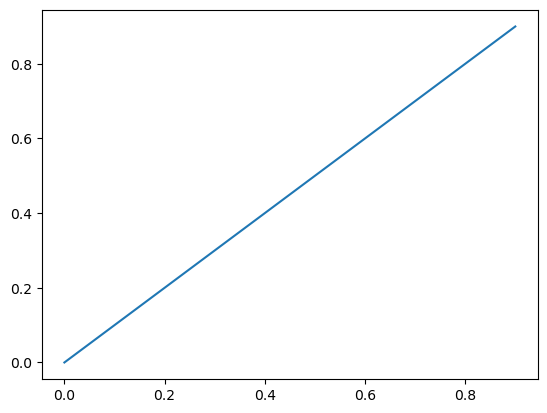

In [1]:
import numpy as np
import matplotlib.pyplot as plt
x=np.arange(0,1,0.1)
plt.figure()
plt.plot(x,x)
plt.show()

In [2]:
from typing import Callable, List, Tuple

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from NFconstants import N_nod, Beta, a, K_nod
from NFandist import get_O
from NFandist import get_diag
from NFandist import get_C
from Data import normal_dist

def set_random_seed(seed):
    torch.manual_seed(seed)
O=(torch.tensor(get_O(N_nod)).float()).to(device)
Ot=(torch.t(O)).to(device)
print(Ot.requires_grad)

O8=(torch.tensor(get_O(8)).float()).to(device)
O8t=(torch.t(O8)).to(device)


#C=(torch.tensor(get_C(N_nod,Beta)).float()).to(device)
#Ct=(torch.t(C)).to(device)




False


In [4]:
class ThetaNetwork(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        num_hidden: int,
        hidden_dim: int,
        num_params: int,
        p_drop: float,
    ):
        super().__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Dropout(p=p_drop),
                nn.LayerNorm(hidden_dim)
            ) for _ in range(num_hidden)]
        )

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)
        
    def configure_theta(num_hidden,hidden_dim,p_drop,in_dim=N_nod//2,out_dim=N_nod//2):
        theta=ThetaNetwork(
                in_dim = in_dim,
                out_dim = out_dim,
                num_hidden = num_hidden,  #2 to 6
                hidden_dim = hidden_dim , #100-1024
                num_params = 2,
                p_drop=p_drop,
        )
        return theta    

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x),negative_slope=0.01)
        for h in self.hidden:
            x = F.leaky_relu(h(x),negative_slope=0.01)

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1) 
        params = batch_params.chunk(self.num_params, dim=-1) 
        return [p.squeeze(-1) for p in params]

In [5]:
class AffineCouplingLayer(nn.Module):
    def __init__(
        self,
        theta: nn.Module,
        split,
        swap: int
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap = swap

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        """g : z -> x. The inverse of f."""
        mask1=self.split[self.swap]
        mask2=self.split[(self.swap+1)%2]
        z1, z2 = z[:,mask1], z[:,mask2]
        z1 = torch.cat((z1,params),dim=-1)
        t, s = self.theta(z1)
        x2 = z2 * torch.exp(s) + t
        log_det = s.sum(-1) 
        z[:,mask2]=x2
        return z, log_det

    def f(self, x: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        mask1=self.split[self.swap]
        mask2=self.split[(self.swap+1)%2]
        x1, x2 = x[:,mask1], x[:,mask2]
        x1 = torch.cat((x1,params),dim=-1)
        t, s = self.theta(x1)
        z1, z2 = x1, torch.exp(-s)*(x2-t) 
        log_det = s.sum(-1) 
        x[:,mask2] = z2
        return x, log_det    

In [6]:
def get_split_masks(dim=N_nod):
    mask1=list(range(0,dim,2))
    mask2=list(range(1,dim,2))
    split_masks=[mask1,mask2]
    return split_masks
    

In [7]:
def get_pair_split_masks(dim=N_nod):
    mask1=list(range(0,dim,4))
    mask2=list(range(2,dim,4))
    mask1=(mask1+list(map(lambda x:x+1,mask1)))
    mask2=(mask2+list(map(lambda x:x+1,mask2)))
    mask1.sort()
    mask2.sort()
    split_masks=[mask1,mask2]
    return split_masks

In [8]:
class NormalizingFlow(nn.Module):
    
    def __init__(self, latent: Distribution, flows: List[nn.Module], conv_flows = [], ort=False):
        super().__init__()
        self.latent = latent
        self.flows = flows
        self.ort = ort
        self.conv_flows = conv_flows
        
    def configure_flows(n_flows,num_hidden,hidden_dim,p_drop,dim=N_nod,param_dim=0):  # n_flows=8,...,12
        flows = []
        split_masks_d = get_pair_split_masks(dim)
        #split_masks_d = get_split_masks(dim)
    
        for k in range(n_flows):
            theta = ThetaNetwork.configure_theta( num_hidden = num_hidden, hidden_dim = hidden_dim, p_drop=p_drop ,in_dim = dim//2+param_dim,out_dim = dim//2)
            flows.append(AffineCouplingLayer(theta,split=split_masks_d,swap=k%2))
   
        flows = nn.ModuleList(flows)
        return flows     

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        x, sum_log_abs_det = z, torch.zeros(z.size(0)).to(z.device)
        for flow in reversed(self.flows):
            x, log_abs_det = flow.g(x,params)
            sum_log_abs_det += log_abs_det
        
        if self.ort:
            x=torch.matmul(x,Ot.to(x.device))
          
        
        for flow in reversed(self.conv_flows):
            x, log_abs_det = flow.g(x)
            sum_log_abs_det += log_abs_det
        return x, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
    def f(self, x: torch.Tensor,params=torch.tensor([])) -> Tuple[torch.Tensor, torch.Tensor]:
        
        with torch.no_grad():
            if self.ort:
                x=torch.matmul(x,O.to(x.device))
        
            z, sum_log_abs_det = x, torch.zeros(x.size(0)).to(x.device)
        
            for flow in self.flows:
                z, log_abs_det = flow.f(z,params)
                sum_log_abs_det += log_abs_det
        
        return z, sum_log_abs_det
    
 
"""
    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        Maps latent variable z to observation x
        and stores intermediate results.
        
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))
        return xs

    
    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        llp=self.latent.log_prob(z)
        sum_llp= torch.sum(llp,axis=-1)
        return sum_llp
 
    
"""
    

'\n    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:\n        Maps latent variable z to observation x\n        and stores intermediate results.\n        \n        xs = [z]\n        for flow in reversed(self.flows):\n            xs.append(flow.g(xs[-1]))\n        return xs\n\n    \n    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:\n        llp=self.latent.log_prob(z)\n        sum_llp= torch.sum(llp,axis=-1)\n        return sum_llp\n \n    \n'

In [9]:
def get_points(start,stop,step):
    if step == 0:
        print("step = 0 error")
        return 1
    x=start
    Y=[]
    while x < stop:
        Y.append(x)
        Y.append(x+1)
        x += step
    return Y


def config_RG_masks(m,n_nod):
    masks = []
    start = 0
    step = n_nod // (2 ** (m-1))
    tmp = get_points(start,n_nod,step)
    masks.append(tmp)
    if n_nod == 2 ** m:
        return masks
    start = step//2
    masks.append(get_points(start,n_nod,step))
    while step > 4:
        step //= 2
        start = step//2
        masks.append(get_points(start,n_nod,step))
    return masks
    

In [10]:
class RGflows(nn.Module):
    
    def __init__(self,latent: Distribution ,nflist, masks, n_flows_dict,num_hidden_dict,hidden_dim_dict):
        super().__init__()
        self.latent = latent
        self.nflist = nflist
        self.masks = masks
        self.n_flows_dict = n_flows_dict
        self.num_hidden_dict = num_hidden_dict
        self.hidden_dim_dict = hidden_dim_dict
        #self.Projt = [getproj(self.masks[i]) for i in range(len(self.masks)) ]
        #self.Proj = [torch.transpose(getproj(self.masks[i]),0,1) for i in range(len(self.masks)) ]
        
    def configure_RG_flows(masks,n_flows_dict,num_hidden_dict,hidden_dim_dict,p_drop=0):  
        nflist=[]
        dim = len(masks[0])
        param_dim = 0
        for k in range(len(masks)):
            flows =  NormalizingFlow.configure_flows(n_flows = n_flows_dict[dim] , num_hidden = num_hidden_dict[dim] , hidden_dim = hidden_dim_dict[dim], dim = dim , param_dim = param_dim, p_drop = p_drop)
            nflist.append(NormalizingFlow(latent=normal_dist,flows=flows,ort=False))
            param_dim += dim 
            if k!=0: dim *= 2 
        nflist = nn.ModuleList(nflist)        
        return nflist    
        
    def configure_RG_model(latent,masks,n_flows_dict, num_hidden_dict,hidden_dim_dict,p_drop=0):
        flows=RGflows.configure_RG_flows(masks,n_flows_dict,num_hidden_dict,hidden_dim_dict,p_drop=p_drop)
        return RGflows(latent,flows,RGmasks,n_flows_dict,num_hidden_dict,hidden_dim_dict)
    
    def save(self,filename):
        state_dict = self.state_dict()
        model_dict={"state_dict":state_dict,
                    "n_flows_dict":self.n_flows_dict,
                    "num_hidden_dict":self.num_hidden_dict,
                    "hidden_dim_dict":self.hidden_dim_dict,
                    "masks":self.masks}
        torch.save(model_dict,filename)
    
    def load_model(filename):   
        model_dict = torch.load(filename,map_location = device)
        model=RGflows.configure_RG_model(normal_dist,
                                  model_dict["masks"],
                                  model_dict["n_flows_dict"], 
                                  model_dict["num_hidden_dict"],
                                  model_dict["hidden_dim_dict"],
                                  p_drop=0)
        model.load_state_dict(model_dict["state_dict"])
        return model
        

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        """Sample a new observation x by sampling z from
        the latent distribution and pass through g."""
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        sum_log_abs_det = torch.zeros(z.size(0)).to(z.device)
        params=torch.tensor([]).to(z.device)
        
        for i in range(len(self.nflist)):
            x = z[:,self.masks[i]]
            x, log_abs_det = ((self.nflist)[i]).g(x,params)
            sum_log_abs_det += log_abs_det
            params = torch.cat((params,x.detach()),dim=-1)
            z[:,self.masks[i]] = x
        z = torch.matmul(z,Ot.to(z.device))    
        return z, sum_log_abs_det
    
    def f(self, x: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        with torch.no_grad():
            sum_log_abs_det = torch.zeros(x.size(0)).to(x.device)
            params=torch.tensor([]).to(x.device)
            x = torch.matmul(x,O.to(x.device))
        
            for i in range(len(self.nflist)):
                z = x[:,self.masks[i]]
                tmp = z.clone()
                z, log_abs_det = ((self.nflist)[i]).f(z,params)
                sum_log_abs_det += log_abs_det
                params = torch.cat((params,tmp.detach()),dim=-1)
                x[:,self.masks[i]] = z    
        return x, sum_log_abs_det
    
    def log_prob(self,x):
        tmp = x.clone()
        z, lad = self.f(tmp)
        log_prob = -torch.sum(z**2/2,dim=-1)-lad
        return log_prob
    
    
    def g_samp(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        sum_log_abs_det = torch.zeros(z.size(0)).to(z.device)
        params = torch.tensor([]).to(z.device)
        res = torch.zeros((z.shape[0],z.shape[1]))
        
        for i in range(len(self.nflist)):
            x=z[:,self.masks[i]]
            res1, log_abs_det = ((self.nflist)[i]).g(x,params)
            sum_log_abs_det += log_abs_det
            params = torch.cat((params,x),dim=-1)
            res[:,self.masks[i]] = res1
        res = torch.matmul(res,Ot.to(z.device))    
        return res, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
    def forward(self,z,grads=False):
        t=z.clone()
        with torch.no_grad():
            x, log_abs_det=self.g(t)


        return x, log_abs_det
    
 

    

In [11]:
RGmasks = config_RG_masks(3,N_nod)

In [12]:
print(RGmasks)

[[0, 1, 32, 33, 64, 65, 96, 97], [16, 17, 48, 49, 80, 81, 112, 113], [8, 9, 24, 25, 40, 41, 56, 57, 72, 73, 88, 89, 104, 105, 120, 121], [4, 5, 12, 13, 20, 21, 28, 29, 36, 37, 44, 45, 52, 53, 60, 61, 68, 69, 76, 77, 84, 85, 92, 93, 100, 101, 108, 109, 116, 117, 124, 125], [2, 3, 6, 7, 10, 11, 14, 15, 18, 19, 22, 23, 26, 27, 30, 31, 34, 35, 38, 39, 42, 43, 46, 47, 50, 51, 54, 55, 58, 59, 62, 63, 66, 67, 70, 71, 74, 75, 78, 79, 82, 83, 86, 87, 90, 91, 94, 95, 98, 99, 102, 103, 106, 107, 110, 111, 114, 115, 118, 119, 122, 123, 126, 127]]


In [13]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

    """
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer
    """
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-9,
            factor=0.5,
            mode="min",
            threshold=0.1,
            patience = 1,
            verbose=True,
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        self.log('train_loss', loss, prog_bar=True)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [98]:
class Pipeline_new(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        criterion8,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.loss8 = criterion8
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

    """
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer
    """
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-9,
            factor=0.5,
            mode="min",
            threshold=0.1,
            patience = 1,
            verbose=True,
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch
        x8 = z[:,self.model.masks[0]]
        x8, log_abs_det8 = ((self.model.nflist)[0]).g(x8)
        x8 = torch.matmul(x8,O8t.to(x8.device))
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        loss8 = self.loss8(x8,log_abs_det8)
        self.log('train_loss', loss, prog_bar=True)
        return 0.01*loss+0.99*loss8


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [99]:
from NFoscillator import Oscillator
from NFrel_oscillator import Rel_Oscillator
from NFur_oscillator import Ur_Oscillator
from NFx4 import X4
from NFMorse import Morse
from NFrel_Morse import Rel_Morse
from NFrel_Columb import Rel_Columb
from NFnonrel_Columb import NonRel_Columb
from NFbadur_oscillator import BadUr_Oscillator
from NFtwowells import Two_wells
from NFcircle import Circle
from NFrel_twowells import Rel_two_wells 

osc=Oscillator(N_nod,Beta)
KL_osc=osc.get_KL()

rel1=Rel_Oscillator(N_nod,Beta,sigma=1)
KL_rel1=rel1.get_KL()

ur=Ur_Oscillator(N_nod,Beta)
KL_ur=ur.get_KL()

ur8=Ur_Oscillator(8,Beta)
KL_ur8=ur8.get_KL()

rel_columb=Rel_Columb(N_nod,Beta,alpha=1,R=1)
KL_rel_columb=rel_columb.get_KL()

tw = Two_wells(N_nod,Beta,g=1,x0=1.41)
KL_tw = tw.get_KL()


morse = Morse(N_nod,Beta,alpha=0.125)
KL_morse = morse.get_KL()

circ = Circle(N_nod,Beta,g=1,x0=4)
KL_circ = circ.get_KL()

rel_morse = Rel_Morse(N_nod,Beta,m=1,alpha=0.125)
KL_rel_morse = rel_morse.get_KL()

rel_tw = Rel_two_wells(N_nod,Beta,m=1,g=1,x0=1.41)
KL_rel_tw = rel_tw.get_KL()

KL_rel001=Rel_Oscillator(N_nod,Beta,sigma=0.01).get_KL()
KL_rel01=Rel_Oscillator(N_nod,Beta,sigma=0.1).get_KL()
KL_rel10=Rel_Oscillator(N_nod,Beta,sigma=10).get_KL()
KL_rel29=Rel_Oscillator(N_nod,Beta,sigma = 2 ** 9).get_KL()
KL_X4=X4(N_nod,Beta,g=0.05).get_KL()
KL_rel_morse=Rel_Morse(N_nod,Beta,alpha=1,m=1000).get_KL()
KL_nonrel_columb=NonRel_Columb(N_nod,Beta,alpha=1,R=1).get_KL()


In [100]:
hidden_dim_dict1={8:16,16:32,32:64,64:128,128:256}
n_flows_dict1={8:6,16:8,32:10,64:16,128:32}
num_hidden_dict1={8:4,16:8,32:8,64:8,128:8}

In [101]:
hidden_dim_dict2={8:8,16:16,32:16}
n_flows_dict2={8:16,16:16,32:16}
num_hidden_dict2={8:16,16:16,32:16}

In [102]:
hidden_dim_dict3 = {2:8}
n_flows_dict3 = {2:4}
num_hidden_dict3 = {2:8}

In [103]:
from Data import train_loader

set_random_seed(42)
rg = RGflows.configure_RG_model(normal_dist,RGmasks,n_flows_dict1,num_hidden_dict1,hidden_dim_dict1)
pipeline=Pipeline(model=rg, criterion=KL_ur, optimizer_class=torch.optim.Adam, optimizer_kwargs={"lr": 0.0001,"weight_decay":0})
pp=Pipeline_new(model=rg, criterion=KL_ur, criterion8=KL_ur8, optimizer_class=torch.optim.Adam, optimizer_kwargs={"lr": 0.0001,"weight_decay":0})


trainer = pl.Trainer(
    max_epochs=1000,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    enable_checkpointing=False,
    accumulate_grad_batches=2
)

trainer.fit(model=pp, train_dataloaders=train_loader)
rg.save("model_weights2.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | RGflows   | 3.0 M 
1 | loss  | KL_with_S | 0     
2 | loss8 | KL_with_S | 0     
------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.890    Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

In [42]:
from Data import train_loader

set_random_seed(42)
rg = RGflows.load_model("model_weights_rel_N=256_Beta=16.pth")
pipeline=Pipeline(model=rg,criterion=KL_ur, optimizer_class=torch.optim.Adam,optimizer_kwargs={"lr": 0.0001})

trainer = pl.Trainer(
    max_epochs=200,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    enable_checkpointing=False,
    accumulate_grad_batches=8
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
rg.save("model_weights3.pth")

FileNotFoundError: [Errno 2] No such file or directory: 'model_weights_rel_N=256_Beta=16.pth'

In [104]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
RG_trained = RGflows.load_model("model_weights2.pth")
RG_trained.eval()
N_traj=1000
trajs = RG_trained.sample(N_traj)


In [105]:
from NFandist import get_T
from tqdm import tqdm
#T=torch.tensor(get_T(N_nod)).float()
def G(X,n_p=N_nod):
    n_traj=X.shape[0]
    n_nod=X.shape[1]
    G=np.zeros((n_p))
    Y=X.clone()
    Xt=torch.t(X)
    for s in tqdm(range(n_p)):
        G[s]=torch.trace(torch.matmul(Y,Xt))
        Y=torch.roll(Y,-1,1)
        #Y=torch.roll(Y,-1,1)
    return G/(n_traj*n_nod)
g_nf=G(trajs)
#g_nf2=G(trajs2,64)



100%|███████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 135.81it/s]


In [81]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_osc=calc_G(N_nod,Beta,N_nod)


In [31]:
g_ur = [0.476546, 0.148654, 0.060357, 0.0232596, -0.00447499, -0.00224423, -0.00447499, 0.0232596, 0.060357, 0.148654]

In [27]:

g_ur = [0.555858, 0.497988, 0.446597, 0.401115, 0.360415, 0.324316, 0.29138, 0.261791, 0.235658, 0.211969, 0.190536, 0.171994, 0.155133, 0.140335, 0.126598, 0.114471, 0.103514, 0.0941716, 0.0852865, 0.0767528, 0.0691313, 0.0619047, 0.0550745, 0.0490998, 0.0443236, 0.0396256, 0.0358628, 0.0324961, 0.0302019, 0.0276177, 0.0251373, 0.0226234, 0.0203086, 0.0179717, 0.0164385, 0.0152739, 0.0143051, 0.0136778, 0.0127566, 0.0118486, 0.0111658, 0.0111462, 0.011026, 0.0110081, 0.0109681, 0.0106729, 0.0101027, 0.010377, 0.010866, 0.0114044, 0.0119873, 0.0114044, 0.010866, 0.010377, 0.0101027, 0.0106729, 0.0109681, 0.0110081, 0.011026, 0.0111462, 0.0111658, 0.0118486, 0.0127566, 0.0136778, 0.0143051, 0.0152739, 0.0164385, 0.0179717, 0.0203086, 0.0226234, 0.0251373, 0.0276177, 0.0302019, 0.0324961, 0.0358628, 0.0396256, 0.0443236, 0.0490998, 0.0550745, 0.0619047, 0.0691313, 0.0767528, 0.0852865, 0.0941716, 0.103514, 0.114471, 0.126598, 0.140335, 0.155133, 0.171994, 0.190536, 0.211969, 0.235658, 0.261791, 0.29138, 0.324316, 0.360415, 0.401115, 0.446597, 0.497988]


In [106]:
g_ur = np.genfromtxt("g_ur N=256 Beta=16")

In [34]:
g_rel = [0.389004, 0.174591, 0.0750764, 0.0320855, 0.0235634, 0.0204869, 0.0235634, 0.0320855, 0.0750764, 0.174591]

In [27]:
g_rel = [0.392501, 0.361773, 0.333519, 0.307446, 0.283335, 0.261201, 0.240658, 0.221871, 0.204776, 0.188963, 0.174495, 0.161116, 0.148541, 0.136946, 0.126175, 0.116168, 0.106934, 0.0985733, 0.090693, 0.0836987, 0.0773237, 0.0713712, 0.0662134, 0.0611666, 0.0567049, 0.0525145, 0.0489322, 0.045775, 0.043085, 0.0407685, 0.0383386, 0.0365845, 0.0353032, 0.0339074, 0.0324167, 0.0308972, 0.0295226, 0.0285374, 0.0276133, 0.026899, 0.0265193, 0.0267518, 0.027023, 0.0272673, 0.0275789, 0.0277296, 0.0281657, 0.0286108, 0.0289897, 0.0292072, 0.0292838, 0.0292072, 0.0289897, 0.0286108, 0.0281657, 0.0277296, 0.0275789, 0.0272673, 0.027023, 0.0267518, 0.0265193, 0.026899, 0.0276133, 0.0285374, 0.0295226, 0.0308972, 0.0324167, 0.0339074, 0.0353032, 0.0365845, 0.0383386, 0.0407685, 0.043085, 0.045775, 0.0489322, 0.0525145, 0.0567049, 0.0611666, 0.0662134, 0.0713712, 0.0773237, 0.0836987, 0.090693, 0.0985733, 0.106934, 0.116168, 0.126175, 0.136946, 0.148541, 0.161116, 0.174495, 0.188963, 0.204776, 0.221871, 0.240658, 0.261201, 0.283335, 0.307446, 0.333519, 0.361773]


In [30]:

import numpy as np
corr = [0.0049279, 0.00445719, 0.0040318, 0.00364688, 0.00329375, 0.00297512, 0.00268571, 0.00242197, 0.00217813, 0.00195686, 0.00176504, 0.001597, 0.0014406, 0.00130362, 0.00117932, 0.00107197, 0.000971531, 0.000873839, 0.000783014, 0.000698531, 0.000622945, 0.000554938, 0.000497423, 0.000446639, 0.000400234, 0.000360026, 0.000325092, 0.00028936, 0.000252744, 0.000222755, 0.00019756, 0.000178826, 0.000169581, 0.000165766, 0.000161208, 0.000158499, 0.000157808, 0.000156267, 0.000155463, 0.000151827, 0.000137475, 0.000124214, 0.000113485, 0.000104859, 9.63436e-05, 8.8317e-05, 8.17296e-05, 7.9884e-05, 7.83747e-05, 8.01024e-05, 8.44507e-05, 8.01024e-05, 7.83747e-05, 7.9884e-05, 8.17296e-05, 8.8317e-05, 9.63436e-05, 0.000104859, 0.000113485, 0.000124214, 0.000137475, 0.000151827, 0.000155463, 0.000156267, 0.000157808, 0.000158499, 0.000161208, 0.000165766, 0.000169581, 0.000178826, 0.00019756, 0.000222755, 0.000252744, 0.00028936, 0.000325092, 0.000360026, 0.000400234, 0.000446639, 0.000497423, 0.000554938, 0.000622945, 0.000698531, 0.000783014, 0.000873839, 0.000971531, 0.00107197, 0.00117932, 0.00130362, 0.0014406, 0.001597, 0.00176504, 0.00195686, 0.00217813, 0.00242197, 0.00268571, 0.00297512, 0.00329375, 0.00364688, 0.0040318, 0.00445719, 0.0049279]
g_rel_001=(100*np.array(corr))[:-1]



In [31]:
import numpy as np
corr = [0.0482165, 0.0437875, 0.0397512, 0.0361339, 0.0328051, 0.0297607, 0.0270138, 0.0244825, 0.0222039, 0.0201489, 0.0183026, 0.0166458, 0.0151002, 0.0137192, 0.012421, 0.0112716, 0.0102497, 0.00931179, 0.0084281, 0.00763501, 0.00697282, 0.00637519, 0.00579578, 0.00524782, 0.00469027, 0.00419239, 0.00376016, 0.00335117, 0.00299975, 0.00265075, 0.00236496, 0.00215769, 0.00196452, 0.00178665, 0.00162977, 0.00148276, 0.00135563, 0.00127519, 0.00120796, 0.00115448, 0.0011155, 0.00109623, 0.00112555, 0.00113097, 0.00108849, 0.00108302, 0.00112726, 0.00115736, 0.00118966, 0.00124266, 0.00121678, 0.00124266, 0.00118966, 0.00115736, 0.00112726, 0.00108302, 0.00108849, 0.00113097, 0.00112555, 0.00109623, 0.0011155, 0.00115448, 0.00120796, 0.00127519, 0.00135563, 0.00148276, 0.00162977, 0.00178665, 0.00196452, 0.00215769, 0.00236496, 0.00265075, 0.00299975, 0.00335117, 0.00376016, 0.00419239, 0.00469027, 0.00524782, 0.00579578, 0.00637519, 0.00697282, 0.00763501, 0.0084281, 0.00931179, 0.0102497, 0.0112716, 0.012421, 0.0137192, 0.0151002, 0.0166458, 0.0183026, 0.0201489, 0.0222039, 0.0244825, 0.0270138, 0.0297607, 0.0328051, 0.0361339, 0.0397512, 0.0437875, 0.0482165]
g_rel_01=(10*np.array(corr))[:-1]


In [29]:
print(len(g_nf2))

64


0.4265174865722656


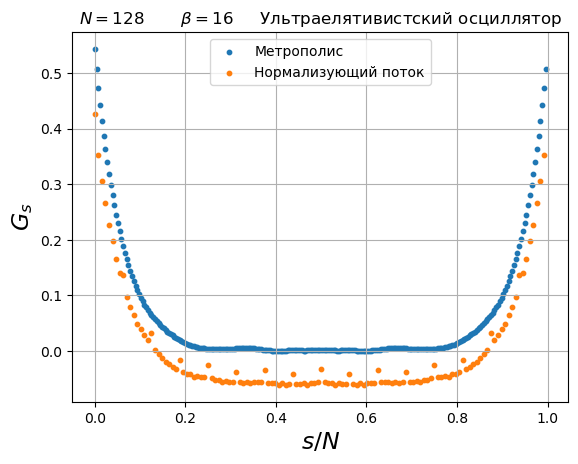

In [107]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta




g=g_ur
print(g_nf[0])
fig=plt.figure()
MCMC_list=np.arange(len(g))/len(g)
NF_list=np.arange(len(g_nf))/len(g_nf)



plt.scatter(MCMC_list,g,s=10)
plt.scatter(NF_list,g_nf,s=10)
plt.legend(["Метрополис","Нормализующий поток"])
plt.title(r"$N=$"+str(N_nod)+"       "r"$\beta=$"+str(Beta)+"     Ультраелятивистский осциллятор")
plt.ylabel(r"$G_s$",fontsize=17)
plt.xlabel(r"$s/N$",fontsize=17)
#plt.yscale("log")
plt.grid(True)
plt.show()


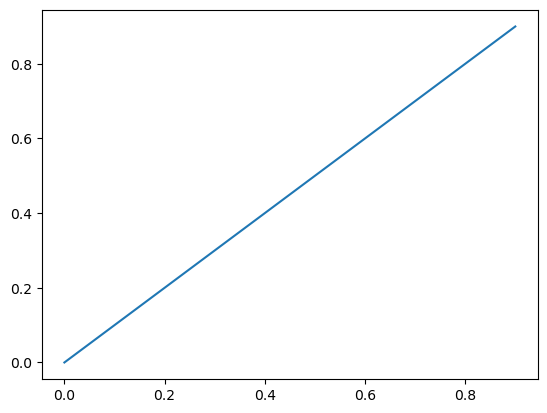

In [84]:
import numpy as np
import matplotlib.pyplot as plt
x=np.arange(0,1,0.1)
plt.figure()
plt.plot(x,x)
plt.show()

In [38]:
K = (1 - 2 * (g_nf[0]-g_nf[1]) / a) / (2 * a)

In [39]:
print(K)

6.691316406249996


In [40]:
np.savetxt("Rel oscillator m=w=1 N=256 Beta=16.txt",trajs.numpy())

In [3]:


! du -sh logs






20K	logs


In [4]:
! rm -rf logs


In [41]:
import time
class MCMC:
    def __init__(self,system,model="none",d=(a/N_nod)**0.5,N_sweep=100,log_per=1000):
        
        self.system = system
        self.S = 0
        self.model = model
        self.d = d
        self.N_sweep = N_sweep
        self.log_per = log_per
        self.ar = 0
        self.shift_dist = torch.distributions.Uniform(torch.zeros(N_nod), torch.ones(N_nod))
        self.un = torch.distributions.Uniform(0, 1)
        self.res=[]
        self.times=[]
        
    def sweep(self,z):
        shift = self.shift_dist.sample((N_samp,)).to(z.device)
        y = z+self.d*(2*shift-1)
    
        S_new=self.calc_S(y)
    
        dS=S_new-self.S
        prob = torch.exp(-dS)
        #prob=torch.zeros((N_samp))
        ind = self.un.sample((N_samp,)).to(z.device)<prob
    
        mask=ind.nonzero()
        if len(mask)>1:
            mask=mask.squeeze()
    
        if  len(mask)>0:
            self.S[mask]=S_new[mask]
            z[mask,:]=y[mask,:]  
        self.ar = torch.mean(ind.type('torch.FloatTensor'))           
    
    
    def log(self,z):
        if self.model=="none":
            x1=z
        else:    
            x1,_=self.model(z)
        print(torch.mean(x1**2),self.ar)
        self.res.append(torch.mean(x1**2).cpu())
        self.Times.append(time.time()-self.start)
    
    def calc_S(self,z):
        if self.model=="none":
            S=self.system.Full_S(z).to(z.device)
        else:
            x , lad = self.model(z)
            S=self.system.Full_S(x).to(z.device)-lad   
        return S
    
    def init_state(self,z):
        self.start=time.time()
        self.S=self.calc_S(z)
        self.res=[]
        self.Times=[]
        
    
    def run(self,z):
        
        self.init_state(z)
    
        for i in range(self.N_sweep):
            if i%self.log_per==0:
                self.log(z)
            self.sweep(z)
        
        return z    
    
    
        

In [42]:
N_samp = 1000
model1 = RG_trained.to(device)
set_random_seed(42)
z2 = normal_dist.sample((N_samp,)).to(device)
z2,_=model1(z2)
Metropolis_b = MCMC(ur,N_sweep=1000000,log_per=1000,d=(a/N_nod)**0.5)
z2 = Metropolis_b.run(z2)

tensor(0.2936) 0
tensor(0.3064) tensor(0.3690)


KeyboardInterrupt: 

In [50]:
import time
class HMC:
    def __init__(self,system,model="none",eps=0.001,n_steps=10,sigma=1,N_sweep=100,log_per=1000,gamma=0,auto=True,imp=False):
        self.system = system
        self.S = 0
        self.model = model
        self.eps = eps
        self.n_steps = n_steps
        self.N_sweep = N_sweep
        self.log_per = log_per
        self.ar = 0
        self.sigma=sigma
        self.shift_dist = torch.distributions.Normal(torch.zeros(N_nod), sigma * torch.ones(N_nod))
        self.un = torch.distributions.Uniform(0, 1)
        self.auto = auto
        self.imp = imp    
        self.res = []
        self.times = []
    
    def leapfrog_step(self,p,x,eps):
        if self.auto:
            F = self.calc_F(x)
        else:
            F = self.system.F(x)
            
        p_half = p + 0.5 * eps * F  # F=-dS/dx
        y = x + eps * p_half
        q = p_half + 0.5 * eps * F 
        return q, y

    def hmc_new(self,P,X):
        for i in range(self.n_steps): 
            P , X = self.leapfrog_step(P,X,self.eps)
        return P,X       


    def hmc_sweep(self,x):
        p = self.shift_dist.sample((N_samp,)).to(x.device)
        K0 = torch.sum(p**2/2,axis=1)
        
        q , y = self.hmc_new(p.clone(),x.clone())
        S_new = self.calc_S(y)
        dS = S_new-self.S + torch.sum(q**2/2,axis=1)-K0
        
        prob = torch.exp(-dS)
        ind = self.un.sample((N_samp,)).to(x.device)<prob
        mask = ind.nonzero()
        
        if len(mask)>1:
            mask = mask.squeeze()
        if  len(mask)>0:
            self.S[mask] = S_new[mask]
            x[mask,:] = y[mask,:]
        
        self.ar = torch.mean(ind.type('torch.FloatTensor'))    
    
    
    def log(self,z):
        if self.model=="none" or self.imp:
            x1=z
        else:    
            x1,_=self.model(z)
        print(torch.mean(x1**2),self.ar)
        self.res.append(torch.mean(x1**2).cpu())
        self.Times.append(time.time()-self.start)
    
    def calc_S(self,z,grads=False):
        
        if self.model=="none":
            S=self.system.Full_S(z).to(z.device) 
        
        else:
            if self.imp==False:
                if grads :
                    x , lad = self.model.g_samp(z)
                else:
                    x , lad = self.model(z)
                S = self.system.Full_S(x).to(z.device)-lad
            else:
                S = self.system.Full_S(z)+self.model.log_prob(z)
        return S
    
    def calc_F(self,z):
        t = z.clone()
        t.requires_grad = True
        s = torch.sum(self.calc_S(t,grads=True))
        s.backward()
        F =-(t.grad).detach()
        del(t)
        return F
    
    def init_state(self,z):
        self.start=time.time()
        self.S=self.calc_S(z)
        self.res=[]
        self.Times=[]

    def run(self,x):
        self.init_state(x)
        for i in range(self.N_sweep):
            if i%self.log_per==0:
                self.log(x)
            self.hmc_sweep(x)
        return x        

In [58]:
N_samp = 100
model1 = RG_trained.to(device)
set_random_seed(42)
z = normal_dist.sample((N_samp,)).to(device)
HMC_NN = HMC(ur,model=model1,N_sweep=100000,n_steps=500,log_per=1,eps=0.005,auto=True)
z = HMC_NN.run(z)

tensor(0.3685) 0
tensor(0.4279) tensor(0.6500)
tensor(0.4838) tensor(0.6000)
tensor(0.4985) tensor(0.5600)
tensor(0.5229) tensor(0.5100)
tensor(0.5466) tensor(0.6400)
tensor(0.5546) tensor(0.5800)
tensor(0.5378) tensor(0.6500)
tensor(0.5322) tensor(0.5500)
tensor(0.5038) tensor(0.5600)
tensor(0.5068) tensor(0.6000)
tensor(0.5299) tensor(0.5900)
tensor(0.5433) tensor(0.5400)
tensor(0.5444) tensor(0.5700)
tensor(0.5483) tensor(0.6300)
tensor(0.5519) tensor(0.6100)
tensor(0.5841) tensor(0.6200)
tensor(0.5482) tensor(0.6400)
tensor(0.5268) tensor(0.5900)
tensor(0.5188) tensor(0.5800)
tensor(0.5271) tensor(0.5600)
tensor(0.5500) tensor(0.5800)
tensor(0.5172) tensor(0.6000)
tensor(0.5252) tensor(0.5700)
tensor(0.5448) tensor(0.6800)
tensor(0.5386) tensor(0.5600)
tensor(0.5309) tensor(0.5700)
tensor(0.5406) tensor(0.5500)
tensor(0.5433) tensor(0.6700)
tensor(0.5729) tensor(0.6000)
tensor(0.5395) tensor(0.5800)
tensor(0.5152) tensor(0.6900)
tensor(0.5594) tensor(0.5800)
tensor(0.5193) tensor(0

KeyboardInterrupt: 

In [61]:
trajs,_=model1(z)

In [247]:
N_samp = 100
model1 = RG_trained.to(device)
set_random_seed(42)
z1 = normal_dist.sample((N_samp,)).to(device)
z1,_=model1(z1)
HMC_b = HMC(ur,model=model1,N_sweep=100000,n_steps=1000,log_per=1,eps=0.0005,auto=False,imp=True)
z1 = HMC_b.run(z1)

tensor(0.2995) 0
tensor(0.3315) tensor(0.7500)
tensor(0.3661) tensor(0.6700)
tensor(0.4033) tensor(0.6600)
tensor(0.4247) tensor(0.5200)
tensor(0.4449) tensor(0.5000)
tensor(0.4695) tensor(0.5100)
tensor(0.4921) tensor(0.5100)
tensor(0.5094) tensor(0.4000)
tensor(0.5330) tensor(0.3800)
tensor(0.5575) tensor(0.4700)
tensor(0.5828) tensor(0.5000)
tensor(0.6053) tensor(0.3700)
tensor(0.6312) tensor(0.4500)
tensor(0.6515) tensor(0.3800)
tensor(0.6786) tensor(0.4300)
tensor(0.7028) tensor(0.4600)
tensor(0.7247) tensor(0.4700)
tensor(0.7526) tensor(0.4500)
tensor(0.7792) tensor(0.4200)
tensor(0.8042) tensor(0.4000)
tensor(0.8272) tensor(0.4400)
tensor(0.8484) tensor(0.3800)
tensor(0.8732) tensor(0.3900)
tensor(0.8981) tensor(0.4100)
tensor(0.9230) tensor(0.4300)
tensor(0.9421) tensor(0.3200)
tensor(0.9551) tensor(0.3100)
tensor(0.9715) tensor(0.3600)
tensor(0.9931) tensor(0.3000)
tensor(1.0152) tensor(0.3500)
tensor(1.0361) tensor(0.3600)
tensor(1.0564) tensor(0.3100)
tensor(1.0817) tensor(0

tensor(5.7016) tensor(0.1400)
tensor(5.7137) tensor(0.1300)
tensor(5.7260) tensor(0.1100)
tensor(5.7404) tensor(0.1200)
tensor(5.7556) tensor(0.1100)
tensor(5.7735) tensor(0.0900)
tensor(5.7829) tensor(0.1600)
tensor(5.8062) tensor(0.1900)
tensor(5.8144) tensor(0.1600)
tensor(5.8340) tensor(0.1200)
tensor(5.8505) tensor(0.1600)
tensor(5.8721) tensor(0.1300)
tensor(5.8957) tensor(0.1500)
tensor(5.9126) tensor(0.1800)
tensor(5.9222) tensor(0.1100)
tensor(5.9524) tensor(0.2200)
tensor(5.9640) tensor(0.1400)
tensor(5.9843) tensor(0.1800)
tensor(5.9964) tensor(0.1400)
tensor(6.0172) tensor(0.1700)
tensor(6.0302) tensor(0.2200)
tensor(6.0319) tensor(0.0900)
tensor(6.0358) tensor(0.1300)
tensor(6.0553) tensor(0.1700)
tensor(6.0683) tensor(0.1200)
tensor(6.0765) tensor(0.0900)
tensor(6.1062) tensor(0.1700)
tensor(6.1152) tensor(0.1200)
tensor(6.1339) tensor(0.2100)
tensor(6.1389) tensor(0.0300)
tensor(6.1550) tensor(0.1400)
tensor(6.1715) tensor(0.1100)
tensor(6.1880) tensor(0.1500)
tensor(6.2

tensor(9.6633) tensor(0.0800)
tensor(9.6709) tensor(0.0900)
tensor(9.6737) tensor(0.0500)
tensor(9.6883) tensor(0.1600)
tensor(9.6919) tensor(0.0500)
tensor(9.7041) tensor(0.0800)
tensor(9.7132) tensor(0.0900)
tensor(9.7223) tensor(0.1200)
tensor(9.7349) tensor(0.0700)
tensor(9.7423) tensor(0.1400)
tensor(9.7554) tensor(0.0800)
tensor(9.7700) tensor(0.1000)
tensor(9.7837) tensor(0.1100)
tensor(9.7884) tensor(0.0300)
tensor(9.7999) tensor(0.1100)
tensor(9.8081) tensor(0.0900)
tensor(9.8225) tensor(0.1000)
tensor(9.8394) tensor(0.1400)
tensor(9.8469) tensor(0.0900)
tensor(9.8638) tensor(0.1300)
tensor(9.8823) tensor(0.0900)
tensor(9.8856) tensor(0.0600)
tensor(9.8953) tensor(0.0400)
tensor(9.9008) tensor(0.0800)
tensor(9.9093) tensor(0.0900)
tensor(9.9204) tensor(0.1100)
tensor(9.9507) tensor(0.1600)
tensor(9.9587) tensor(0.0700)
tensor(9.9596) tensor(0.0700)
tensor(9.9742) tensor(0.0900)
tensor(9.9938) tensor(0.1200)
tensor(10.0046) tensor(0.1000)
tensor(10.0246) tensor(0.1100)
tensor(1

tensor(12.5873) tensor(0.0900)
tensor(12.5886) tensor(0.0500)
tensor(12.5925) tensor(0.0300)
tensor(12.6038) tensor(0.1000)
tensor(12.6167) tensor(0.0600)
tensor(12.6275) tensor(0.0800)
tensor(12.6369) tensor(0.0700)
tensor(12.6441) tensor(0.0500)
tensor(12.6441) tensor(0.0300)
tensor(12.6557) tensor(0.0600)
tensor(12.6651) tensor(0.0800)
tensor(12.6730) tensor(0.0700)
tensor(12.6845) tensor(0.0500)
tensor(12.6947) tensor(0.1100)
tensor(12.7022) tensor(0.0500)
tensor(12.7102) tensor(0.0800)
tensor(12.7118) tensor(0.0200)
tensor(12.7209) tensor(0.0700)
tensor(12.7326) tensor(0.0500)
tensor(12.7397) tensor(0.0600)
tensor(12.7455) tensor(0.0600)
tensor(12.7598) tensor(0.0900)
tensor(12.7609) tensor(0.0600)
tensor(12.7769) tensor(0.1100)
tensor(12.7861) tensor(0.0500)
tensor(12.7949) tensor(0.0700)
tensor(12.8130) tensor(0.1200)
tensor(12.8204) tensor(0.0600)
tensor(12.8269) tensor(0.0600)
tensor(12.8264) tensor(0.0600)
tensor(12.8298) tensor(0.0300)
tensor(12.8326) tensor(0.0200)
tensor(1

tensor(14.9395) tensor(0.0600)
tensor(14.9577) tensor(0.0900)
tensor(14.9695) tensor(0.0500)
tensor(14.9813) tensor(0.0600)
tensor(14.9939) tensor(0.0800)
tensor(14.9960) tensor(0.0400)
tensor(15.0026) tensor(0.0900)
tensor(15.0093) tensor(0.0400)
tensor(15.0148) tensor(0.0700)
tensor(15.0191) tensor(0.0300)
tensor(15.0330) tensor(0.0600)
tensor(15.0450) tensor(0.0500)
tensor(15.0539) tensor(0.0500)
tensor(15.0585) tensor(0.0600)
tensor(15.0686) tensor(0.0900)
tensor(15.0902) tensor(0.0700)
tensor(15.0922) tensor(0.0300)
tensor(15.1000) tensor(0.0500)
tensor(15.1060) tensor(0.0300)
tensor(15.1120) tensor(0.0500)
tensor(15.1217) tensor(0.0400)
tensor(15.1393) tensor(0.1000)
tensor(15.1425) tensor(0.0100)
tensor(15.1505) tensor(0.0400)
tensor(15.1551) tensor(0.0700)
tensor(15.1553) tensor(0.0400)
tensor(15.1585) tensor(0.0400)
tensor(15.1732) tensor(0.0800)
tensor(15.1843) tensor(0.0300)
tensor(15.1950) tensor(0.0700)
tensor(15.2068) tensor(0.0700)
tensor(15.2119) tensor(0.0600)
tensor(1

tensor(16.8215) tensor(0.0200)
tensor(16.8317) tensor(0.0900)
tensor(16.8326) tensor(0.0200)
tensor(16.8399) tensor(0.0600)
tensor(16.8528) tensor(0.0500)
tensor(16.8579) tensor(0.0300)
tensor(16.8653) tensor(0.0500)
tensor(16.8695) tensor(0.0300)
tensor(16.8772) tensor(0.0100)
tensor(16.8865) tensor(0.0400)
tensor(16.8971) tensor(0.0600)
tensor(16.9008) tensor(0.0200)
tensor(16.9132) tensor(0.0900)
tensor(16.9214) tensor(0.0600)
tensor(16.9285) tensor(0.0500)
tensor(16.9305) tensor(0.0500)
tensor(16.9376) tensor(0.0600)
tensor(16.9402) tensor(0.0800)
tensor(16.9403) tensor(0.0400)
tensor(16.9353) tensor(0.0200)
tensor(16.9397) tensor(0.0500)
tensor(16.9421) tensor(0.0400)
tensor(16.9503) tensor(0.0700)
tensor(16.9540) tensor(0.0300)
tensor(16.9725) tensor(0.0700)
tensor(16.9793) tensor(0.0600)
tensor(16.9801) tensor(0.0400)
tensor(16.9787) tensor(0.0400)
tensor(16.9819) tensor(0.0300)
tensor(16.9829) tensor(0.0300)
tensor(16.9876) tensor(0.0500)
tensor(16.9899) tensor(0.0400)
tensor(1

tensor(18.4913) tensor(0.0400)
tensor(18.4942) tensor(0.0600)
tensor(18.4932) tensor(0.0100)
tensor(18.5058) tensor(0.0700)
tensor(18.5179) tensor(0.0600)
tensor(18.5284) tensor(0.0500)
tensor(18.5351) tensor(0.0400)
tensor(18.5386) tensor(0.0200)
tensor(18.5469) tensor(0.0300)
tensor(18.5498) tensor(0.0500)
tensor(18.5530) tensor(0.0300)
tensor(18.5541) tensor(0.0100)
tensor(18.5528) tensor(0.0100)
tensor(18.5727) tensor(0.0900)
tensor(18.5727) tensor(0.)
tensor(18.5776) tensor(0.0500)
tensor(18.5781) tensor(0.0200)
tensor(18.5811) tensor(0.0400)
tensor(18.5900) tensor(0.0400)
tensor(18.5928) tensor(0.0300)
tensor(18.5981) tensor(0.0400)
tensor(18.6075) tensor(0.0400)
tensor(18.6058) tensor(0.0200)
tensor(18.6079) tensor(0.0200)
tensor(18.6164) tensor(0.0500)
tensor(18.6282) tensor(0.0400)
tensor(18.6307) tensor(0.0600)
tensor(18.6340) tensor(0.0300)
tensor(18.6446) tensor(0.0600)
tensor(18.6497) tensor(0.0400)
tensor(18.6512) tensor(0.0300)
tensor(18.6555) tensor(0.0100)
tensor(18.66

tensor(19.9966) tensor(0.0300)
tensor(20.0104) tensor(0.0300)
tensor(20.0235) tensor(0.0500)
tensor(20.0290) tensor(0.0500)
tensor(20.0319) tensor(0.0100)
tensor(20.0357) tensor(0.0100)
tensor(20.0390) tensor(0.0200)
tensor(20.0390) tensor(0.)
tensor(20.0440) tensor(0.0500)
tensor(20.0520) tensor(0.0300)
tensor(20.0527) tensor(0.0600)
tensor(20.0550) tensor(0.0200)
tensor(20.0626) tensor(0.0600)
tensor(20.0718) tensor(0.0900)
tensor(20.0814) tensor(0.0400)
tensor(20.0830) tensor(0.0100)
tensor(20.0831) tensor(0.0300)
tensor(20.0836) tensor(0.0400)
tensor(20.0896) tensor(0.0200)
tensor(20.0897) tensor(0.0200)
tensor(20.1012) tensor(0.0400)
tensor(20.1135) tensor(0.0500)
tensor(20.1205) tensor(0.0300)
tensor(20.1285) tensor(0.0400)
tensor(20.1365) tensor(0.0600)
tensor(20.1465) tensor(0.0600)
tensor(20.1496) tensor(0.0200)
tensor(20.1535) tensor(0.0200)
tensor(20.1573) tensor(0.0400)
tensor(20.1744) tensor(0.0700)
tensor(20.1743) tensor(0.0300)
tensor(20.1794) tensor(0.0500)
tensor(20.18

tensor(21.2561) tensor(0.0500)
tensor(21.2640) tensor(0.0600)
tensor(21.2706) tensor(0.0600)
tensor(21.2735) tensor(0.0200)
tensor(21.2735) tensor(0.)
tensor(21.2803) tensor(0.0200)
tensor(21.2808) tensor(0.0100)
tensor(21.2835) tensor(0.0300)
tensor(21.2922) tensor(0.0400)
tensor(21.3021) tensor(0.0300)
tensor(21.3125) tensor(0.0500)
tensor(21.3181) tensor(0.0200)
tensor(21.3230) tensor(0.0300)
tensor(21.3246) tensor(0.0500)
tensor(21.3263) tensor(0.0400)
tensor(21.3255) tensor(0.0300)
tensor(21.3282) tensor(0.0300)
tensor(21.3347) tensor(0.0300)
tensor(21.3368) tensor(0.0300)
tensor(21.3368) tensor(0.)
tensor(21.3352) tensor(0.0200)
tensor(21.3430) tensor(0.0400)
tensor(21.3448) tensor(0.0200)
tensor(21.3506) tensor(0.0200)
tensor(21.3664) tensor(0.0800)
tensor(21.3699) tensor(0.0100)
tensor(21.3706) tensor(0.0200)
tensor(21.3721) tensor(0.0200)
tensor(21.3748) tensor(0.0200)
tensor(21.3774) tensor(0.0200)
tensor(21.3824) tensor(0.0100)
tensor(21.3872) tensor(0.0200)
tensor(21.3908) 

tensor(22.4430) tensor(0.0200)
tensor(22.4585) tensor(0.0400)
tensor(22.4601) tensor(0.0300)
tensor(22.4588) tensor(0.0100)
tensor(22.4669) tensor(0.0200)
tensor(22.4715) tensor(0.0100)
tensor(22.4734) tensor(0.0200)
tensor(22.4751) tensor(0.0200)
tensor(22.4792) tensor(0.0300)
tensor(22.4818) tensor(0.0300)
tensor(22.4834) tensor(0.0300)
tensor(22.4959) tensor(0.0900)
tensor(22.5005) tensor(0.0200)
tensor(22.5040) tensor(0.0200)
tensor(22.5091) tensor(0.0200)
tensor(22.5211) tensor(0.0600)
tensor(22.5211) tensor(0.)
tensor(22.5188) tensor(0.0200)
tensor(22.5274) tensor(0.0300)
tensor(22.5394) tensor(0.0500)
tensor(22.5407) tensor(0.0200)
tensor(22.5423) tensor(0.0100)
tensor(22.5476) tensor(0.0400)
tensor(22.5485) tensor(0.0200)
tensor(22.5550) tensor(0.0500)
tensor(22.5714) tensor(0.0600)
tensor(22.5783) tensor(0.0300)
tensor(22.5855) tensor(0.0200)
tensor(22.5831) tensor(0.0300)
tensor(22.5898) tensor(0.0200)
tensor(22.5898) tensor(0.)
tensor(22.5982) tensor(0.0400)
tensor(22.5982) 

tensor(23.5420) tensor(0.0100)
tensor(23.5409) tensor(0.0100)
tensor(23.5466) tensor(0.0300)
tensor(23.5514) tensor(0.0100)
tensor(23.5519) tensor(0.0200)
tensor(23.5583) tensor(0.0200)
tensor(23.5546) tensor(0.0200)
tensor(23.5545) tensor(0.0100)
tensor(23.5597) tensor(0.0300)
tensor(23.5622) tensor(0.0100)
tensor(23.5649) tensor(0.0200)
tensor(23.5649) tensor(0.)
tensor(23.5666) tensor(0.0200)
tensor(23.5667) tensor(0.0100)
tensor(23.5776) tensor(0.0400)
tensor(23.5987) tensor(0.0600)
tensor(23.5985) tensor(0.0100)
tensor(23.6073) tensor(0.0300)
tensor(23.6103) tensor(0.0200)
tensor(23.6104) tensor(0.0200)
tensor(23.6236) tensor(0.0400)
tensor(23.6218) tensor(0.0200)
tensor(23.6255) tensor(0.0200)
tensor(23.6267) tensor(0.0100)
tensor(23.6276) tensor(0.0200)
tensor(23.6353) tensor(0.0300)
tensor(23.6396) tensor(0.0300)
tensor(23.6380) tensor(0.0200)
tensor(23.6474) tensor(0.0400)
tensor(23.6463) tensor(0.0200)
tensor(23.6476) tensor(0.0200)
tensor(23.6487) tensor(0.0100)
tensor(23.64

tensor(24.4423) tensor(0.0200)
tensor(24.4448) tensor(0.0300)
tensor(24.4473) tensor(0.0100)
tensor(24.4521) tensor(0.0200)
tensor(24.4571) tensor(0.0400)
tensor(24.4537) tensor(0.0100)
tensor(24.4525) tensor(0.0100)
tensor(24.4510) tensor(0.0100)
tensor(24.4558) tensor(0.0100)
tensor(24.4578) tensor(0.0100)
tensor(24.4616) tensor(0.0200)
tensor(24.4629) tensor(0.0600)
tensor(24.4618) tensor(0.0300)
tensor(24.4797) tensor(0.0300)
tensor(24.4797) tensor(0.)
tensor(24.4878) tensor(0.0200)
tensor(24.4909) tensor(0.0100)
tensor(24.4894) tensor(0.0200)
tensor(24.4911) tensor(0.0100)
tensor(24.4917) tensor(0.0300)
tensor(24.4954) tensor(0.0100)
tensor(24.5011) tensor(0.0100)
tensor(24.5053) tensor(0.0200)
tensor(24.5021) tensor(0.0400)
tensor(24.5106) tensor(0.0200)
tensor(24.5096) tensor(0.0100)
tensor(24.5122) tensor(0.0100)
tensor(24.5122) tensor(0.)
tensor(24.5122) tensor(0.)
tensor(24.5196) tensor(0.0300)
tensor(24.5186) tensor(0.0100)
tensor(24.5227) tensor(0.0100)
tensor(24.5320) tens

tensor(25.4021) tensor(0.)
tensor(25.4066) tensor(0.0300)
tensor(25.4204) tensor(0.0200)
tensor(25.4215) tensor(0.0400)
tensor(25.4279) tensor(0.0300)
tensor(25.4340) tensor(0.0200)
tensor(25.4401) tensor(0.0100)
tensor(25.4389) tensor(0.0400)
tensor(25.4416) tensor(0.0200)
tensor(25.4467) tensor(0.0200)
tensor(25.4488) tensor(0.0300)
tensor(25.4503) tensor(0.0200)
tensor(25.4556) tensor(0.0300)
tensor(25.4608) tensor(0.0400)
tensor(25.4622) tensor(0.0300)
tensor(25.4654) tensor(0.0200)
tensor(25.4691) tensor(0.0400)
tensor(25.4682) tensor(0.0200)
tensor(25.4740) tensor(0.0300)
tensor(25.4755) tensor(0.0100)
tensor(25.4755) tensor(0.)
tensor(25.4774) tensor(0.0200)
tensor(25.4838) tensor(0.0300)
tensor(25.4916) tensor(0.0200)
tensor(25.4973) tensor(0.0300)
tensor(25.5013) tensor(0.0200)
tensor(25.5095) tensor(0.0400)
tensor(25.5169) tensor(0.0300)
tensor(25.5215) tensor(0.0300)
tensor(25.5239) tensor(0.0100)
tensor(25.5309) tensor(0.0200)
tensor(25.5319) tensor(0.0100)
tensor(25.5357) 

tensor(26.2903) tensor(0.)
tensor(26.2922) tensor(0.0200)
tensor(26.2922) tensor(0.)
tensor(26.2985) tensor(0.0200)
tensor(26.3095) tensor(0.0400)
tensor(26.3151) tensor(0.0100)
tensor(26.3151) tensor(0.)
tensor(26.3175) tensor(0.0100)
tensor(26.3239) tensor(0.0200)
tensor(26.3233) tensor(0.0100)
tensor(26.3233) tensor(0.)
tensor(26.3230) tensor(0.0100)
tensor(26.3321) tensor(0.0400)
tensor(26.3363) tensor(0.0100)
tensor(26.3380) tensor(0.0100)
tensor(26.3380) tensor(0.0100)
tensor(26.3382) tensor(0.0200)
tensor(26.3410) tensor(0.0300)
tensor(26.3422) tensor(0.0100)
tensor(26.3422) tensor(0.)
tensor(26.3474) tensor(0.0400)
tensor(26.3497) tensor(0.0100)
tensor(26.3490) tensor(0.0300)
tensor(26.3444) tensor(0.0200)
tensor(26.3499) tensor(0.0100)
tensor(26.3617) tensor(0.0400)
tensor(26.3718) tensor(0.0200)
tensor(26.3761) tensor(0.0300)
tensor(26.3777) tensor(0.0200)
tensor(26.3880) tensor(0.0600)
tensor(26.3872) tensor(0.0100)
tensor(26.3877) tensor(0.0300)
tensor(26.3961) tensor(0.020

tensor(27.0914) tensor(0.0200)
tensor(27.0979) tensor(0.0200)
tensor(27.0979) tensor(0.)
tensor(27.1040) tensor(0.0100)
tensor(27.1108) tensor(0.0500)
tensor(27.1175) tensor(0.0200)
tensor(27.1184) tensor(0.0100)
tensor(27.1254) tensor(0.0100)
tensor(27.1268) tensor(0.0100)
tensor(27.1267) tensor(0.0100)
tensor(27.1295) tensor(0.0100)
tensor(27.1348) tensor(0.0100)
tensor(27.1409) tensor(0.0200)
tensor(27.1462) tensor(0.0300)
tensor(27.1462) tensor(0.)
tensor(27.1520) tensor(0.0200)
tensor(27.1673) tensor(0.0500)
tensor(27.1673) tensor(0.)
tensor(27.1718) tensor(0.0300)
tensor(27.1713) tensor(0.0200)
tensor(27.1684) tensor(0.0300)
tensor(27.1736) tensor(0.0100)
tensor(27.1746) tensor(0.0100)
tensor(27.1795) tensor(0.0200)
tensor(27.1785) tensor(0.0200)
tensor(27.1834) tensor(0.0200)
tensor(27.1926) tensor(0.0500)
tensor(27.1926) tensor(0.)
tensor(27.1926) tensor(0.)
tensor(27.1924) tensor(0.0100)
tensor(27.1924) tensor(0.)
tensor(27.2007) tensor(0.0400)
tensor(27.2037) tensor(0.0200)
t

tensor(27.8803) tensor(0.0200)
tensor(27.8798) tensor(0.0100)
tensor(27.8813) tensor(0.0100)
tensor(27.8813) tensor(0.)
tensor(27.8891) tensor(0.0400)
tensor(27.8891) tensor(0.)
tensor(27.8903) tensor(0.0100)
tensor(27.8920) tensor(0.0200)
tensor(27.8911) tensor(0.0100)
tensor(27.8925) tensor(0.0400)
tensor(27.8925) tensor(0.)
tensor(27.8978) tensor(0.0300)
tensor(27.8987) tensor(0.0100)
tensor(27.9029) tensor(0.0200)
tensor(27.9036) tensor(0.0100)
tensor(27.9054) tensor(0.0500)
tensor(27.9097) tensor(0.0300)
tensor(27.9097) tensor(0.)
tensor(27.9148) tensor(0.0200)
tensor(27.9234) tensor(0.0300)
tensor(27.9233) tensor(0.0100)
tensor(27.9233) tensor(0.)
tensor(27.9239) tensor(0.0100)
tensor(27.9272) tensor(0.0100)
tensor(27.9304) tensor(0.0300)
tensor(27.9336) tensor(0.0200)
tensor(27.9355) tensor(0.0200)
tensor(27.9406) tensor(0.0100)
tensor(27.9437) tensor(0.0200)
tensor(27.9490) tensor(0.0300)
tensor(27.9498) tensor(0.0300)
tensor(27.9498) tensor(0.)
tensor(27.9498) tensor(0.)
tenso

tensor(28.5623) tensor(0.0100)
tensor(28.5650) tensor(0.0100)
tensor(28.5618) tensor(0.0200)
tensor(28.5727) tensor(0.0300)
tensor(28.5767) tensor(0.0100)
tensor(28.5767) tensor(0.)
tensor(28.5854) tensor(0.0400)
tensor(28.5853) tensor(0.0300)
tensor(28.5887) tensor(0.0200)
tensor(28.5893) tensor(0.0100)
tensor(28.5893) tensor(0.)
tensor(28.5889) tensor(0.0100)
tensor(28.5934) tensor(0.0200)
tensor(28.5947) tensor(0.0100)
tensor(28.5946) tensor(0.0100)
tensor(28.5990) tensor(0.0200)
tensor(28.5990) tensor(0.)
tensor(28.5990) tensor(0.)
tensor(28.6005) tensor(0.0100)
tensor(28.5989) tensor(0.0200)
tensor(28.6136) tensor(0.0500)
tensor(28.6136) tensor(0.)
tensor(28.6136) tensor(0.)
tensor(28.6157) tensor(0.0200)
tensor(28.6207) tensor(0.0100)
tensor(28.6248) tensor(0.0400)
tensor(28.6248) tensor(0.)
tensor(28.6248) tensor(0.)
tensor(28.6238) tensor(0.0200)
tensor(28.6352) tensor(0.0200)
tensor(28.6419) tensor(0.0300)
tensor(28.6431) tensor(0.0300)
tensor(28.6425) tensor(0.0200)
tensor(28

tensor(29.2970) tensor(0.0300)
tensor(29.3005) tensor(0.0200)
tensor(29.3008) tensor(0.0100)
tensor(29.3089) tensor(0.0300)
tensor(29.3121) tensor(0.0100)
tensor(29.3163) tensor(0.0100)
tensor(29.3181) tensor(0.0200)
tensor(29.3189) tensor(0.0100)
tensor(29.3264) tensor(0.0500)
tensor(29.3382) tensor(0.0400)
tensor(29.3361) tensor(0.0100)
tensor(29.3403) tensor(0.0300)
tensor(29.3403) tensor(0.0100)
tensor(29.3440) tensor(0.0100)
tensor(29.3554) tensor(0.0400)
tensor(29.3582) tensor(0.0300)
tensor(29.3644) tensor(0.0200)
tensor(29.3644) tensor(0.)
tensor(29.3727) tensor(0.0200)
tensor(29.3770) tensor(0.0200)
tensor(29.3770) tensor(0.)
tensor(29.3760) tensor(0.0100)
tensor(29.3745) tensor(0.0100)
tensor(29.3733) tensor(0.0300)
tensor(29.3736) tensor(0.0400)
tensor(29.3861) tensor(0.0300)
tensor(29.3930) tensor(0.0400)
tensor(29.3930) tensor(0.)
tensor(29.3964) tensor(0.0300)
tensor(29.3971) tensor(0.0100)
tensor(29.3960) tensor(0.0100)
tensor(29.3960) tensor(0.)
tensor(29.3967) tensor(0

tensor(29.9373) tensor(0.0100)
tensor(29.9473) tensor(0.0200)
tensor(29.9473) tensor(0.)
tensor(29.9515) tensor(0.0300)
tensor(29.9524) tensor(0.0200)
tensor(29.9529) tensor(0.0100)
tensor(29.9529) tensor(0.)
tensor(29.9677) tensor(0.0300)
tensor(29.9671) tensor(0.0100)
tensor(29.9723) tensor(0.0200)
tensor(29.9779) tensor(0.0200)
tensor(29.9828) tensor(0.0300)
tensor(29.9831) tensor(0.0300)
tensor(29.9835) tensor(0.0100)
tensor(29.9871) tensor(0.0200)
tensor(29.9941) tensor(0.0200)
tensor(30.0082) tensor(0.0500)
tensor(30.0031) tensor(0.0200)
tensor(30.0097) tensor(0.0300)
tensor(30.0117) tensor(0.0100)
tensor(30.0154) tensor(0.0500)
tensor(30.0154) tensor(0.)
tensor(30.0229) tensor(0.0200)
tensor(30.0229) tensor(0.)
tensor(30.0225) tensor(0.0100)
tensor(30.0374) tensor(0.0400)
tensor(30.0396) tensor(0.0100)
tensor(30.0396) tensor(0.)
tensor(30.0387) tensor(0.0100)
tensor(30.0387) tensor(0.)
tensor(30.0421) tensor(0.0300)
tensor(30.0406) tensor(0.0100)
tensor(30.0406) tensor(0.)
tenso

tensor(30.6300) tensor(0.0100)
tensor(30.6300) tensor(0.)
tensor(30.6344) tensor(0.0200)
tensor(30.6403) tensor(0.0200)
tensor(30.6412) tensor(0.0100)
tensor(30.6468) tensor(0.0100)
tensor(30.6465) tensor(0.0100)
tensor(30.6471) tensor(0.0100)
tensor(30.6586) tensor(0.0200)
tensor(30.6667) tensor(0.0300)
tensor(30.6669) tensor(0.0100)
tensor(30.6682) tensor(0.0200)
tensor(30.6706) tensor(0.0200)
tensor(30.6706) tensor(0.)
tensor(30.6709) tensor(0.0200)
tensor(30.6709) tensor(0.)
tensor(30.6709) tensor(0.)
tensor(30.6727) tensor(0.0100)
tensor(30.6801) tensor(0.0200)
tensor(30.6801) tensor(0.)
tensor(30.6801) tensor(0.)
tensor(30.6801) tensor(0.)
tensor(30.6801) tensor(0.)
tensor(30.6870) tensor(0.0100)
tensor(30.6912) tensor(0.0200)
tensor(30.6924) tensor(0.0100)
tensor(30.6972) tensor(0.0300)
tensor(30.7077) tensor(0.0500)
tensor(30.7148) tensor(0.0200)
tensor(30.7169) tensor(0.0100)
tensor(30.7169) tensor(0.)
tensor(30.7187) tensor(0.0200)
tensor(30.7244) tensor(0.0100)
tensor(30.724

tensor(31.2421) tensor(0.0100)
tensor(31.2421) tensor(0.)
tensor(31.2421) tensor(0.)
tensor(31.2442) tensor(0.0200)
tensor(31.2532) tensor(0.0300)
tensor(31.2509) tensor(0.0100)
tensor(31.2555) tensor(0.0200)
tensor(31.2577) tensor(0.0100)
tensor(31.2577) tensor(0.)
tensor(31.2577) tensor(0.)
tensor(31.2564) tensor(0.0100)
tensor(31.2532) tensor(0.0100)
tensor(31.2587) tensor(0.0100)
tensor(31.2587) tensor(0.)
tensor(31.2602) tensor(0.0100)
tensor(31.2602) tensor(0.)
tensor(31.2602) tensor(0.)
tensor(31.2691) tensor(0.0100)
tensor(31.2742) tensor(0.0400)
tensor(31.2762) tensor(0.0100)
tensor(31.2795) tensor(0.0100)
tensor(31.2795) tensor(0.)
tensor(31.2843) tensor(0.0200)
tensor(31.2870) tensor(0.0200)
tensor(31.2870) tensor(0.)
tensor(31.2870) tensor(0.)
tensor(31.2990) tensor(0.0200)
tensor(31.2990) tensor(0.)
tensor(31.3001) tensor(0.0100)
tensor(31.3064) tensor(0.0300)
tensor(31.3064) tensor(0.)
tensor(31.3078) tensor(0.0100)
tensor(31.3118) tensor(0.0200)
tensor(31.3144) tensor(0.

tensor(31.8002) tensor(0.0100)
tensor(31.8002) tensor(0.)
tensor(31.8027) tensor(0.0200)
tensor(31.8027) tensor(0.)
tensor(31.8027) tensor(0.)
tensor(31.7995) tensor(0.0100)
tensor(31.7995) tensor(0.)
tensor(31.8036) tensor(0.0500)
tensor(31.8036) tensor(0.)
tensor(31.8030) tensor(0.0100)
tensor(31.8041) tensor(0.0100)
tensor(31.8090) tensor(0.0100)
tensor(31.8090) tensor(0.)
tensor(31.8156) tensor(0.0300)
tensor(31.8202) tensor(0.0400)
tensor(31.8207) tensor(0.0200)
tensor(31.8207) tensor(0.)
tensor(31.8204) tensor(0.0300)
tensor(31.8232) tensor(0.0200)
tensor(31.8232) tensor(0.)
tensor(31.8332) tensor(0.0200)
tensor(31.8361) tensor(0.0200)
tensor(31.8374) tensor(0.0100)
tensor(31.8358) tensor(0.0100)
tensor(31.8358) tensor(0.)
tensor(31.8358) tensor(0.)
tensor(31.8405) tensor(0.0300)
tensor(31.8405) tensor(0.)
tensor(31.8520) tensor(0.0400)
tensor(31.8537) tensor(0.0200)
tensor(31.8540) tensor(0.0100)
tensor(31.8540) tensor(0.)
tensor(31.8553) tensor(0.0100)
tensor(31.8635) tensor(0.

tensor(32.3093) tensor(0.0100)
tensor(32.3093) tensor(0.)
tensor(32.3151) tensor(0.0200)
tensor(32.3213) tensor(0.0100)
tensor(32.3239) tensor(0.0100)
tensor(32.3239) tensor(0.)
tensor(32.3239) tensor(0.)
tensor(32.3239) tensor(0.)
tensor(32.3239) tensor(0.)
tensor(32.3239) tensor(0.)
tensor(32.3298) tensor(0.0200)
tensor(32.3298) tensor(0.)
tensor(32.3298) tensor(0.)
tensor(32.3298) tensor(0.)
tensor(32.3368) tensor(0.0400)
tensor(32.3368) tensor(0.)
tensor(32.3387) tensor(0.0100)
tensor(32.3387) tensor(0.)
tensor(32.3380) tensor(0.0100)
tensor(32.3398) tensor(0.0100)
tensor(32.3462) tensor(0.0200)
tensor(32.3472) tensor(0.0100)
tensor(32.3472) tensor(0.)
tensor(32.3502) tensor(0.0200)
tensor(32.3494) tensor(0.0100)
tensor(32.3559) tensor(0.0100)
tensor(32.3627) tensor(0.0200)
tensor(32.3655) tensor(0.0100)
tensor(32.3655) tensor(0.)
tensor(32.3676) tensor(0.0100)
tensor(32.3676) tensor(0.)
tensor(32.3676) tensor(0.)
tensor(32.3764) tensor(0.0200)
tensor(32.3764) tensor(0.)
tensor(32.

tensor(32.7834) tensor(0.0100)
tensor(32.7829) tensor(0.0100)
tensor(32.7881) tensor(0.0200)
tensor(32.7881) tensor(0.)
tensor(32.7909) tensor(0.0100)
tensor(32.8013) tensor(0.0300)
tensor(32.8018) tensor(0.0100)
tensor(32.8056) tensor(0.0100)
tensor(32.8056) tensor(0.)
tensor(32.8094) tensor(0.0100)
tensor(32.8094) tensor(0.)
tensor(32.8085) tensor(0.0100)
tensor(32.8085) tensor(0.)
tensor(32.8141) tensor(0.0200)
tensor(32.8135) tensor(0.0300)
tensor(32.8135) tensor(0.)
tensor(32.8134) tensor(0.0100)
tensor(32.8123) tensor(0.0100)
tensor(32.8123) tensor(0.)
tensor(32.8144) tensor(0.0100)
tensor(32.8176) tensor(0.0200)
tensor(32.8283) tensor(0.0400)
tensor(32.8283) tensor(0.)
tensor(32.8283) tensor(0.)
tensor(32.8319) tensor(0.0100)
tensor(32.8349) tensor(0.0300)
tensor(32.8376) tensor(0.0100)
tensor(32.8412) tensor(0.0300)
tensor(32.8412) tensor(0.)
tensor(32.8417) tensor(0.0100)
tensor(32.8411) tensor(0.0100)
tensor(32.8411) tensor(0.)
tensor(32.8460) tensor(0.0100)
tensor(32.8471) t

tensor(33.2467) tensor(0.)
tensor(33.2540) tensor(0.0200)
tensor(33.2540) tensor(0.)
tensor(33.2540) tensor(0.)
tensor(33.2555) tensor(0.0100)
tensor(33.2647) tensor(0.0200)
tensor(33.2674) tensor(0.0100)
tensor(33.2669) tensor(0.0100)
tensor(33.2691) tensor(0.0300)
tensor(33.2691) tensor(0.)
tensor(33.2707) tensor(0.0100)
tensor(33.2751) tensor(0.0200)
tensor(33.2751) tensor(0.)
tensor(33.2751) tensor(0.)
tensor(33.2727) tensor(0.0100)
tensor(33.2733) tensor(0.0100)
tensor(33.2733) tensor(0.)
tensor(33.2758) tensor(0.0100)
tensor(33.2758) tensor(0.)
tensor(33.2859) tensor(0.0400)
tensor(33.2859) tensor(0.)
tensor(33.2859) tensor(0.)
tensor(33.2956) tensor(0.0200)
tensor(33.2929) tensor(0.0100)
tensor(33.2945) tensor(0.0100)
tensor(33.2971) tensor(0.0100)
tensor(33.2997) tensor(0.0200)
tensor(33.3017) tensor(0.0300)
tensor(33.3017) tensor(0.)
tensor(33.3009) tensor(0.0100)
tensor(33.3009) tensor(0.)
tensor(33.3009) tensor(0.)
tensor(33.3009) tensor(0.)
tensor(33.3106) tensor(0.0100)
te

tensor(33.6323) tensor(0.0100)
tensor(33.6344) tensor(0.0100)
tensor(33.6344) tensor(0.0100)
tensor(33.6344) tensor(0.)
tensor(33.6451) tensor(0.0300)
tensor(33.6451) tensor(0.)
tensor(33.6451) tensor(0.)
tensor(33.6429) tensor(0.0100)
tensor(33.6431) tensor(0.0200)
tensor(33.6431) tensor(0.)
tensor(33.6427) tensor(0.0100)
tensor(33.6505) tensor(0.0200)
tensor(33.6536) tensor(0.0100)
tensor(33.6536) tensor(0.)
tensor(33.6565) tensor(0.0200)
tensor(33.6565) tensor(0.)
tensor(33.6565) tensor(0.)
tensor(33.6607) tensor(0.0100)
tensor(33.6637) tensor(0.0100)
tensor(33.6637) tensor(0.)
tensor(33.6637) tensor(0.0100)
tensor(33.6637) tensor(0.)
tensor(33.6686) tensor(0.0100)
tensor(33.6747) tensor(0.0200)
tensor(33.6736) tensor(0.0100)
tensor(33.6736) tensor(0.)
tensor(33.6777) tensor(0.0100)
tensor(33.6777) tensor(0.)
tensor(33.6808) tensor(0.0200)
tensor(33.6863) tensor(0.0100)
tensor(33.6863) tensor(0.)
tensor(33.6852) tensor(0.0100)
tensor(33.6852) tensor(0.)
tensor(33.6877) tensor(0.0200

tensor(34.1063) tensor(0.)
tensor(34.1047) tensor(0.0100)
tensor(34.1047) tensor(0.)
tensor(34.1047) tensor(0.)
tensor(34.1043) tensor(0.0100)
tensor(34.1043) tensor(0.)
tensor(34.1040) tensor(0.0100)
tensor(34.1028) tensor(0.0100)
tensor(34.1043) tensor(0.0100)
tensor(34.1058) tensor(0.0100)
tensor(34.1058) tensor(0.)
tensor(34.1058) tensor(0.)
tensor(34.1019) tensor(0.0100)
tensor(34.1037) tensor(0.0100)
tensor(34.1037) tensor(0.)
tensor(34.1045) tensor(0.0100)
tensor(34.1045) tensor(0.)
tensor(34.1045) tensor(0.)
tensor(34.1038) tensor(0.0100)
tensor(34.1017) tensor(0.0200)
tensor(34.1017) tensor(0.)
tensor(34.0991) tensor(0.0200)
tensor(34.0991) tensor(0.)
tensor(34.1020) tensor(0.0100)
tensor(34.1103) tensor(0.0200)
tensor(34.1169) tensor(0.0200)
tensor(34.1174) tensor(0.0100)
tensor(34.1174) tensor(0.)
tensor(34.1174) tensor(0.)
tensor(34.1154) tensor(0.0100)
tensor(34.1183) tensor(0.0100)
tensor(34.1207) tensor(0.0100)
tensor(34.1220) tensor(0.0100)
tensor(34.1220) tensor(0.)
te

tensor(34.4930) tensor(0.)
tensor(34.4951) tensor(0.0100)
tensor(34.5005) tensor(0.0300)
tensor(34.5005) tensor(0.)
tensor(34.5059) tensor(0.0200)
tensor(34.5098) tensor(0.0100)
tensor(34.5098) tensor(0.)
tensor(34.5125) tensor(0.0200)
tensor(34.5125) tensor(0.)
tensor(34.5160) tensor(0.0100)
tensor(34.5205) tensor(0.0200)
tensor(34.5355) tensor(0.0400)
tensor(34.5449) tensor(0.0100)
tensor(34.5449) tensor(0.)
tensor(34.5452) tensor(0.0200)
tensor(34.5452) tensor(0.)
tensor(34.5491) tensor(0.0100)
tensor(34.5491) tensor(0.)
tensor(34.5520) tensor(0.0200)
tensor(34.5520) tensor(0.)
tensor(34.5581) tensor(0.0300)
tensor(34.5667) tensor(0.0200)
tensor(34.5706) tensor(0.0100)
tensor(34.5737) tensor(0.0200)
tensor(34.5737) tensor(0.)
tensor(34.5699) tensor(0.0100)
tensor(34.5699) tensor(0.0100)
tensor(34.5749) tensor(0.0300)
tensor(34.5749) tensor(0.)
tensor(34.5749) tensor(0.)
tensor(34.5776) tensor(0.0100)
tensor(34.5722) tensor(0.0200)
tensor(34.5740) tensor(0.0100)
tensor(34.5740) tenso

tensor(34.9281) tensor(0.)
tensor(34.9256) tensor(0.0100)
tensor(34.9256) tensor(0.)
tensor(34.9252) tensor(0.0100)
tensor(34.9252) tensor(0.)
tensor(34.9288) tensor(0.0100)
tensor(34.9322) tensor(0.0200)
tensor(34.9322) tensor(0.)
tensor(34.9309) tensor(0.0100)
tensor(34.9309) tensor(0.)
tensor(34.9309) tensor(0.)
tensor(34.9309) tensor(0.)
tensor(34.9309) tensor(0.)
tensor(34.9312) tensor(0.0100)
tensor(34.9337) tensor(0.0200)
tensor(34.9370) tensor(0.0100)
tensor(34.9370) tensor(0.)
tensor(34.9396) tensor(0.0200)
tensor(34.9396) tensor(0.)
tensor(34.9396) tensor(0.)
tensor(34.9396) tensor(0.)
tensor(34.9418) tensor(0.0100)
tensor(34.9398) tensor(0.0100)
tensor(34.9426) tensor(0.0100)
tensor(34.9426) tensor(0.)
tensor(34.9455) tensor(0.0100)
tensor(34.9455) tensor(0.)
tensor(34.9496) tensor(0.0100)
tensor(34.9555) tensor(0.0200)
tensor(34.9555) tensor(0.)
tensor(34.9555) tensor(0.)
tensor(34.9565) tensor(0.0200)
tensor(34.9566) tensor(0.0200)
tensor(34.9577) tensor(0.0100)
tensor(34.

tensor(35.3350) tensor(0.)
tensor(35.3394) tensor(0.0200)
tensor(35.3358) tensor(0.0100)
tensor(35.3345) tensor(0.0100)
tensor(35.3345) tensor(0.)
tensor(35.3363) tensor(0.0100)
tensor(35.3363) tensor(0.)
tensor(35.3446) tensor(0.0200)
tensor(35.3433) tensor(0.0100)
tensor(35.3437) tensor(0.0100)
tensor(35.3437) tensor(0.0200)
tensor(35.3465) tensor(0.0200)
tensor(35.3465) tensor(0.)
tensor(35.3465) tensor(0.)
tensor(35.3456) tensor(0.0100)
tensor(35.3575) tensor(0.0200)
tensor(35.3539) tensor(0.0100)
tensor(35.3539) tensor(0.)
tensor(35.3539) tensor(0.)
tensor(35.3539) tensor(0.)
tensor(35.3564) tensor(0.0200)
tensor(35.3600) tensor(0.0200)
tensor(35.3600) tensor(0.)
tensor(35.3600) tensor(0.)
tensor(35.3600) tensor(0.)
tensor(35.3631) tensor(0.0100)
tensor(35.3631) tensor(0.)
tensor(35.3731) tensor(0.0100)
tensor(35.3731) tensor(0.)
tensor(35.3826) tensor(0.0200)
tensor(35.3847) tensor(0.0200)
tensor(35.3847) tensor(0.)
tensor(35.3838) tensor(0.0100)
tensor(35.3854) tensor(0.0100)
te

tensor(35.7219) tensor(0.)
tensor(35.7219) tensor(0.)
tensor(35.7219) tensor(0.)
tensor(35.7219) tensor(0.)
tensor(35.7219) tensor(0.)
tensor(35.7219) tensor(0.)
tensor(35.7251) tensor(0.0200)
tensor(35.7303) tensor(0.0200)
tensor(35.7303) tensor(0.)
tensor(35.7303) tensor(0.)
tensor(35.7334) tensor(0.0100)
tensor(35.7351) tensor(0.0100)
tensor(35.7351) tensor(0.)
tensor(35.7370) tensor(0.0100)
tensor(35.7370) tensor(0.)
tensor(35.7370) tensor(0.)
tensor(35.7438) tensor(0.0100)
tensor(35.7476) tensor(0.0100)
tensor(35.7554) tensor(0.0200)
tensor(35.7605) tensor(0.0300)
tensor(35.7605) tensor(0.)
tensor(35.7572) tensor(0.0100)
tensor(35.7600) tensor(0.0100)
tensor(35.7600) tensor(0.)
tensor(35.7600) tensor(0.)
tensor(35.7624) tensor(0.0100)
tensor(35.7624) tensor(0.)
tensor(35.7624) tensor(0.)
tensor(35.7607) tensor(0.0100)
tensor(35.7654) tensor(0.0100)
tensor(35.7654) tensor(0.)
tensor(35.7705) tensor(0.0200)
tensor(35.7729) tensor(0.0200)
tensor(35.7718) tensor(0.0100)
tensor(35.7793

tensor(36.0694) tensor(0.)
tensor(36.0694) tensor(0.)
tensor(36.0704) tensor(0.0100)
tensor(36.0704) tensor(0.)
tensor(36.0713) tensor(0.0100)
tensor(36.0713) tensor(0.)
tensor(36.0742) tensor(0.0300)
tensor(36.0742) tensor(0.)
tensor(36.0742) tensor(0.)
tensor(36.0775) tensor(0.0100)
tensor(36.0821) tensor(0.0100)
tensor(36.0838) tensor(0.0100)
tensor(36.0838) tensor(0.)
tensor(36.0838) tensor(0.)
tensor(36.0838) tensor(0.)
tensor(36.0861) tensor(0.0100)
tensor(36.0899) tensor(0.0200)
tensor(36.0908) tensor(0.0200)
tensor(36.0896) tensor(0.0200)
tensor(36.0896) tensor(0.)
tensor(36.0896) tensor(0.)
tensor(36.0896) tensor(0.)
tensor(36.0896) tensor(0.)
tensor(36.0896) tensor(0.)
tensor(36.0886) tensor(0.0100)
tensor(36.0886) tensor(0.)
tensor(36.0886) tensor(0.)
tensor(36.0886) tensor(0.)
tensor(36.0883) tensor(0.0200)
tensor(36.0953) tensor(0.0200)
tensor(36.0985) tensor(0.0100)
tensor(36.1048) tensor(0.0100)
tensor(36.1048) tensor(0.)
tensor(36.1062) tensor(0.0200)
tensor(36.1045) te

tensor(36.4123) tensor(0.)
tensor(36.4185) tensor(0.0500)
tensor(36.4178) tensor(0.0100)
tensor(36.4192) tensor(0.0100)
tensor(36.4212) tensor(0.0100)
tensor(36.4212) tensor(0.)
tensor(36.4228) tensor(0.0100)
tensor(36.4228) tensor(0.)
tensor(36.4228) tensor(0.)
tensor(36.4228) tensor(0.)
tensor(36.4215) tensor(0.0100)
tensor(36.4215) tensor(0.)
tensor(36.4212) tensor(0.0100)
tensor(36.4212) tensor(0.)
tensor(36.4210) tensor(0.0100)
tensor(36.4210) tensor(0.)
tensor(36.4248) tensor(0.0200)
tensor(36.4248) tensor(0.)
tensor(36.4327) tensor(0.0200)
tensor(36.4354) tensor(0.0200)
tensor(36.4438) tensor(0.0200)
tensor(36.4438) tensor(0.)
tensor(36.4449) tensor(0.0100)
tensor(36.4449) tensor(0.)
tensor(36.4457) tensor(0.0100)
tensor(36.4457) tensor(0.)
tensor(36.4518) tensor(0.0200)
tensor(36.4474) tensor(0.0200)
tensor(36.4489) tensor(0.0100)
tensor(36.4489) tensor(0.)
tensor(36.4546) tensor(0.0200)
tensor(36.4546) tensor(0.)
tensor(36.4546) tensor(0.)
tensor(36.4590) tensor(0.0200)
tensor

tensor(36.8002) tensor(0.)
tensor(36.8002) tensor(0.)
tensor(36.8012) tensor(0.0100)
tensor(36.8012) tensor(0.)
tensor(36.8012) tensor(0.)
tensor(36.8012) tensor(0.)
tensor(36.8033) tensor(0.0100)
tensor(36.8014) tensor(0.0100)
tensor(36.8014) tensor(0.)
tensor(36.8042) tensor(0.0200)
tensor(36.8038) tensor(0.0100)
tensor(36.8038) tensor(0.)
tensor(36.8066) tensor(0.0100)
tensor(36.8132) tensor(0.0300)
tensor(36.8140) tensor(0.0100)
tensor(36.8178) tensor(0.0200)
tensor(36.8218) tensor(0.0100)
tensor(36.8218) tensor(0.)
tensor(36.8270) tensor(0.0100)
tensor(36.8296) tensor(0.0100)
tensor(36.8247) tensor(0.0100)
tensor(36.8247) tensor(0.)
tensor(36.8237) tensor(0.0100)
tensor(36.8256) tensor(0.0100)
tensor(36.8334) tensor(0.0200)
tensor(36.8334) tensor(0.)
tensor(36.8334) tensor(0.)
tensor(36.8334) tensor(0.)
tensor(36.8334) tensor(0.)
tensor(36.8349) tensor(0.0200)
tensor(36.8349) tensor(0.)
tensor(36.8357) tensor(0.0100)
tensor(36.8357) tensor(0.)
tensor(36.8351) tensor(0.0100)
tensor

tensor(37.0775) tensor(0.)
tensor(37.0802) tensor(0.0100)
tensor(37.0841) tensor(0.0100)
tensor(37.0827) tensor(0.0100)
tensor(37.0908) tensor(0.0200)
tensor(37.0987) tensor(0.0400)
tensor(37.1022) tensor(0.0200)
tensor(37.1003) tensor(0.0100)
tensor(37.1012) tensor(0.0100)
tensor(37.1012) tensor(0.)
tensor(37.1012) tensor(0.)
tensor(37.1028) tensor(0.0100)
tensor(37.1028) tensor(0.)
tensor(37.1004) tensor(0.0100)
tensor(37.1006) tensor(0.0100)
tensor(37.1006) tensor(0.)
tensor(37.1070) tensor(0.0200)
tensor(37.1070) tensor(0.)
tensor(37.1070) tensor(0.)
tensor(37.1070) tensor(0.)
tensor(37.1070) tensor(0.)
tensor(37.1135) tensor(0.0400)
tensor(37.1206) tensor(0.0100)
tensor(37.1206) tensor(0.)
tensor(37.1206) tensor(0.)
tensor(37.1245) tensor(0.0200)
tensor(37.1245) tensor(0.)
tensor(37.1245) tensor(0.)
tensor(37.1245) tensor(0.)
tensor(37.1168) tensor(0.0300)
tensor(37.1168) tensor(0.)
tensor(37.1168) tensor(0.)
tensor(37.1187) tensor(0.0100)
tensor(37.1230) tensor(0.0100)
tensor(37.

tensor(37.4850) tensor(0.)
tensor(37.4850) tensor(0.)
tensor(37.4850) tensor(0.0100)
tensor(37.4915) tensor(0.0100)
tensor(37.4915) tensor(0.)
tensor(37.4915) tensor(0.)
tensor(37.4996) tensor(0.0100)
tensor(37.5005) tensor(0.0100)
tensor(37.5070) tensor(0.0200)
tensor(37.5117) tensor(0.0100)
tensor(37.5117) tensor(0.)
tensor(37.5129) tensor(0.0100)
tensor(37.5129) tensor(0.)
tensor(37.5129) tensor(0.)
tensor(37.5143) tensor(0.0100)
tensor(37.5132) tensor(0.0100)
tensor(37.5132) tensor(0.)
tensor(37.5151) tensor(0.0100)
tensor(37.5151) tensor(0.)
tensor(37.5129) tensor(0.0100)
tensor(37.5129) tensor(0.)
tensor(37.5147) tensor(0.0100)
tensor(37.5132) tensor(0.0100)
tensor(37.5141) tensor(0.0100)
tensor(37.5191) tensor(0.0200)
tensor(37.5226) tensor(0.0200)
tensor(37.5226) tensor(0.)
tensor(37.5226) tensor(0.)
tensor(37.5264) tensor(0.0200)
tensor(37.5308) tensor(0.0100)
tensor(37.5302) tensor(0.0100)
tensor(37.5302) tensor(0.)
tensor(37.5292) tensor(0.0100)
tensor(37.5278) tensor(0.0300

tensor(37.8019) tensor(0.)
tensor(37.8018) tensor(0.0100)
tensor(37.8018) tensor(0.)
tensor(37.7999) tensor(0.0200)
tensor(37.7999) tensor(0.)
tensor(37.8035) tensor(0.0200)
tensor(37.8035) tensor(0.)
tensor(37.8059) tensor(0.0300)
tensor(37.8082) tensor(0.0100)
tensor(37.8082) tensor(0.)
tensor(37.8136) tensor(0.0100)
tensor(37.8198) tensor(0.0100)
tensor(37.8260) tensor(0.0100)
tensor(37.8260) tensor(0.)
tensor(37.8260) tensor(0.)
tensor(37.8276) tensor(0.0100)
tensor(37.8276) tensor(0.)
tensor(37.8299) tensor(0.0100)
tensor(37.8299) tensor(0.)
tensor(37.8299) tensor(0.)
tensor(37.8298) tensor(0.0100)
tensor(37.8312) tensor(0.0100)
tensor(37.8331) tensor(0.0100)
tensor(37.8331) tensor(0.)
tensor(37.8331) tensor(0.)
tensor(37.8308) tensor(0.0200)
tensor(37.8308) tensor(0.)
tensor(37.8308) tensor(0.)
tensor(37.8311) tensor(0.0100)
tensor(37.8321) tensor(0.0100)
tensor(37.8321) tensor(0.)
tensor(37.8382) tensor(0.0200)
tensor(37.8382) tensor(0.)
tensor(37.8529) tensor(0.0200)
tensor(37.

tensor(38.1504) tensor(0.0100)
tensor(38.1504) tensor(0.)
tensor(38.1530) tensor(0.0200)
tensor(38.1530) tensor(0.)
tensor(38.1530) tensor(0.)
tensor(38.1530) tensor(0.)
tensor(38.1530) tensor(0.)
tensor(38.1604) tensor(0.0200)
tensor(38.1643) tensor(0.0100)
tensor(38.1643) tensor(0.)
tensor(38.1645) tensor(0.0100)
tensor(38.1645) tensor(0.)
tensor(38.1645) tensor(0.)
tensor(38.1645) tensor(0.)
tensor(38.1645) tensor(0.)
tensor(38.1645) tensor(0.)
tensor(38.1662) tensor(0.0100)
tensor(38.1662) tensor(0.)
tensor(38.1662) tensor(0.)
tensor(38.1647) tensor(0.0100)
tensor(38.1670) tensor(0.0100)
tensor(38.1670) tensor(0.)
tensor(38.1670) tensor(0.)
tensor(38.1670) tensor(0.)
tensor(38.1664) tensor(0.0200)
tensor(38.1664) tensor(0.)
tensor(38.1664) tensor(0.)
tensor(38.1647) tensor(0.0100)
tensor(38.1647) tensor(0.)
tensor(38.1641) tensor(0.0100)
tensor(38.1641) tensor(0.)
tensor(38.1641) tensor(0.)
tensor(38.1641) tensor(0.)
tensor(38.1764) tensor(0.0200)
tensor(38.1764) tensor(0.)
tensor(

tensor(38.4603) tensor(0.)
tensor(38.4603) tensor(0.)
tensor(38.4603) tensor(0.)
tensor(38.4603) tensor(0.)
tensor(38.4603) tensor(0.)
tensor(38.4646) tensor(0.0100)
tensor(38.4646) tensor(0.)
tensor(38.4646) tensor(0.)
tensor(38.4683) tensor(0.0100)
tensor(38.4715) tensor(0.0100)
tensor(38.4715) tensor(0.)
tensor(38.4715) tensor(0.)
tensor(38.4744) tensor(0.0100)
tensor(38.4764) tensor(0.0100)
tensor(38.4739) tensor(0.0100)
tensor(38.4739) tensor(0.)
tensor(38.4739) tensor(0.)
tensor(38.4739) tensor(0.)
tensor(38.4752) tensor(0.0100)
tensor(38.4728) tensor(0.0100)
tensor(38.4749) tensor(0.0100)
tensor(38.4749) tensor(0.)
tensor(38.4749) tensor(0.)
tensor(38.4749) tensor(0.)
tensor(38.4774) tensor(0.0100)
tensor(38.4774) tensor(0.)
tensor(38.4777) tensor(0.0200)
tensor(38.4791) tensor(0.0100)
tensor(38.4791) tensor(0.)
tensor(38.4888) tensor(0.0300)
tensor(38.4888) tensor(0.)
tensor(38.4981) tensor(0.0200)
tensor(38.4972) tensor(0.0100)
tensor(38.4962) tensor(0.0100)
tensor(38.4973) te

tensor(38.7738) tensor(0.0100)
tensor(38.7738) tensor(0.)
tensor(38.7738) tensor(0.)
tensor(38.7738) tensor(0.)
tensor(38.7738) tensor(0.)
tensor(38.7738) tensor(0.)
tensor(38.7763) tensor(0.0100)
tensor(38.7763) tensor(0.)
tensor(38.7771) tensor(0.0100)
tensor(38.7781) tensor(0.0100)
tensor(38.7781) tensor(0.)
tensor(38.7781) tensor(0.)
tensor(38.7781) tensor(0.)
tensor(38.7781) tensor(0.)
tensor(38.7841) tensor(0.0100)
tensor(38.7841) tensor(0.)
tensor(38.7836) tensor(0.0100)
tensor(38.7861) tensor(0.0100)
tensor(38.7861) tensor(0.)
tensor(38.7861) tensor(0.)
tensor(38.7861) tensor(0.)
tensor(38.7861) tensor(0.)
tensor(38.7861) tensor(0.)
tensor(38.7861) tensor(0.)
tensor(38.7861) tensor(0.)
tensor(38.7937) tensor(0.0100)
tensor(38.7939) tensor(0.0200)
tensor(38.7956) tensor(0.0100)
tensor(38.7956) tensor(0.)
tensor(38.7956) tensor(0.)
tensor(38.8003) tensor(0.0100)
tensor(38.8042) tensor(0.0100)
tensor(38.8118) tensor(0.0300)
tensor(38.8118) tensor(0.)
tensor(38.8118) tensor(0.)
ten

tensor(39.1295) tensor(0.0300)
tensor(39.1295) tensor(0.)
tensor(39.1295) tensor(0.)
tensor(39.1315) tensor(0.0100)
tensor(39.1321) tensor(0.0100)
tensor(39.1333) tensor(0.0100)
tensor(39.1333) tensor(0.)
tensor(39.1344) tensor(0.0100)
tensor(39.1340) tensor(0.0100)
tensor(39.1380) tensor(0.0100)
tensor(39.1449) tensor(0.0200)
tensor(39.1475) tensor(0.0100)
tensor(39.1475) tensor(0.)
tensor(39.1475) tensor(0.)
tensor(39.1475) tensor(0.)
tensor(39.1475) tensor(0.)
tensor(39.1475) tensor(0.)
tensor(39.1505) tensor(0.0100)
tensor(39.1505) tensor(0.)
tensor(39.1523) tensor(0.0200)
tensor(39.1501) tensor(0.0100)
tensor(39.1501) tensor(0.)
tensor(39.1601) tensor(0.0100)
tensor(39.1564) tensor(0.0100)
tensor(39.1564) tensor(0.)
tensor(39.1564) tensor(0.)
tensor(39.1564) tensor(0.)
tensor(39.1646) tensor(0.0100)
tensor(39.1659) tensor(0.0200)
tensor(39.1659) tensor(0.)
tensor(39.1639) tensor(0.0100)
tensor(39.1627) tensor(0.0200)
tensor(39.1638) tensor(0.0100)
tensor(39.1638) tensor(0.)
tensor

tensor(39.3900) tensor(0.)
tensor(39.3979) tensor(0.0200)
tensor(39.3977) tensor(0.0100)
tensor(39.3964) tensor(0.0100)
tensor(39.3940) tensor(0.0200)
tensor(39.3974) tensor(0.0100)
tensor(39.4036) tensor(0.0100)
tensor(39.4036) tensor(0.)
tensor(39.4036) tensor(0.)
tensor(39.4036) tensor(0.)
tensor(39.4036) tensor(0.)
tensor(39.4036) tensor(0.)
tensor(39.4036) tensor(0.)
tensor(39.4048) tensor(0.0100)
tensor(39.4060) tensor(0.0100)
tensor(39.4067) tensor(0.0100)
tensor(39.4067) tensor(0.)
tensor(39.4067) tensor(0.)
tensor(39.4067) tensor(0.)
tensor(39.4067) tensor(0.)
tensor(39.4067) tensor(0.)
tensor(39.4130) tensor(0.0200)
tensor(39.4130) tensor(0.)
tensor(39.4130) tensor(0.)
tensor(39.4128) tensor(0.0100)
tensor(39.4128) tensor(0.)
tensor(39.4118) tensor(0.0100)
tensor(39.4133) tensor(0.0100)
tensor(39.4121) tensor(0.0100)
tensor(39.4161) tensor(0.0100)
tensor(39.4161) tensor(0.)
tensor(39.4161) tensor(0.)
tensor(39.4161) tensor(0.)
tensor(39.4146) tensor(0.0100)
tensor(39.4125) te

tensor(39.6780) tensor(0.)
tensor(39.6780) tensor(0.)
tensor(39.6793) tensor(0.0100)
tensor(39.6793) tensor(0.)
tensor(39.6793) tensor(0.)
tensor(39.6777) tensor(0.0200)
tensor(39.6777) tensor(0.)
tensor(39.6777) tensor(0.)
tensor(39.6777) tensor(0.)
tensor(39.6777) tensor(0.)
tensor(39.6799) tensor(0.0100)
tensor(39.6799) tensor(0.)
tensor(39.6799) tensor(0.)
tensor(39.6799) tensor(0.)
tensor(39.6791) tensor(0.0100)
tensor(39.6829) tensor(0.0100)
tensor(39.6888) tensor(0.0100)
tensor(39.6888) tensor(0.)
tensor(39.6860) tensor(0.0100)
tensor(39.6812) tensor(0.0100)
tensor(39.6898) tensor(0.0200)
tensor(39.6898) tensor(0.)
tensor(39.6898) tensor(0.)
tensor(39.6894) tensor(0.0100)
tensor(39.6978) tensor(0.0200)
tensor(39.7058) tensor(0.0300)
tensor(39.7058) tensor(0.)
tensor(39.7058) tensor(0.)
tensor(39.7078) tensor(0.0100)
tensor(39.7078) tensor(0.)
tensor(39.7078) tensor(0.)
tensor(39.7138) tensor(0.0200)
tensor(39.7138) tensor(0.)
tensor(39.7137) tensor(0.0100)
tensor(39.7137) tensor

tensor(39.8620) tensor(0.)
tensor(39.8620) tensor(0.)
tensor(39.8620) tensor(0.)
tensor(39.8620) tensor(0.)
tensor(39.8664) tensor(0.0100)
tensor(39.8664) tensor(0.)
tensor(39.8686) tensor(0.0100)
tensor(39.8686) tensor(0.)
tensor(39.8686) tensor(0.)
tensor(39.8686) tensor(0.)
tensor(39.8686) tensor(0.)
tensor(39.8686) tensor(0.)
tensor(39.8686) tensor(0.)
tensor(39.8686) tensor(0.)
tensor(39.8762) tensor(0.0100)
tensor(39.8731) tensor(0.0100)
tensor(39.8739) tensor(0.0100)
tensor(39.8739) tensor(0.)
tensor(39.8739) tensor(0.)
tensor(39.8772) tensor(0.0100)
tensor(39.8788) tensor(0.0100)
tensor(39.8833) tensor(0.0100)
tensor(39.8849) tensor(0.0100)
tensor(39.8849) tensor(0.)
tensor(39.8849) tensor(0.)
tensor(39.8849) tensor(0.)
tensor(39.8852) tensor(0.0100)
tensor(39.8878) tensor(0.0100)
tensor(39.8878) tensor(0.)
tensor(39.8878) tensor(0.)
tensor(39.8878) tensor(0.)
tensor(39.8878) tensor(0.)
tensor(39.8878) tensor(0.)
tensor(39.8877) tensor(0.0100)
tensor(39.8816) tensor(0.0100)
ten

tensor(40.0992) tensor(0.0100)
tensor(40.0979) tensor(0.0100)
tensor(40.0979) tensor(0.)
tensor(40.0979) tensor(0.)
tensor(40.0979) tensor(0.)
tensor(40.0979) tensor(0.)
tensor(40.0979) tensor(0.)
tensor(40.0979) tensor(0.)
tensor(40.0979) tensor(0.)
tensor(40.1028) tensor(0.0100)
tensor(40.1028) tensor(0.)
tensor(40.1028) tensor(0.)
tensor(40.1028) tensor(0.)
tensor(40.1028) tensor(0.)
tensor(40.1028) tensor(0.)
tensor(40.1033) tensor(0.0100)
tensor(40.1033) tensor(0.)
tensor(40.1033) tensor(0.)
tensor(40.1024) tensor(0.0100)
tensor(40.1024) tensor(0.)
tensor(40.1018) tensor(0.0100)
tensor(40.1018) tensor(0.)
tensor(40.1052) tensor(0.0200)
tensor(40.1095) tensor(0.0100)
tensor(40.1095) tensor(0.)
tensor(40.1095) tensor(0.)
tensor(40.1095) tensor(0.)
tensor(40.1087) tensor(0.0200)
tensor(40.1087) tensor(0.)
tensor(40.1108) tensor(0.0300)
tensor(40.1108) tensor(0.)
tensor(40.1108) tensor(0.)
tensor(40.1188) tensor(0.0100)
tensor(40.1171) tensor(0.0100)
tensor(40.1228) tensor(0.0200)
ten

tensor(40.3009) tensor(0.0100)
tensor(40.3009) tensor(0.)
tensor(40.3009) tensor(0.0100)
tensor(40.3009) tensor(0.)
tensor(40.3009) tensor(0.)
tensor(40.3009) tensor(0.)
tensor(40.3004) tensor(0.0100)
tensor(40.3004) tensor(0.)
tensor(40.3004) tensor(0.)
tensor(40.3004) tensor(0.)
tensor(40.2966) tensor(0.0100)
tensor(40.2966) tensor(0.)
tensor(40.2983) tensor(0.0100)
tensor(40.2983) tensor(0.)
tensor(40.2983) tensor(0.)
tensor(40.3091) tensor(0.0300)
tensor(40.3091) tensor(0.)
tensor(40.3119) tensor(0.0200)
tensor(40.3162) tensor(0.0200)
tensor(40.3162) tensor(0.)
tensor(40.3222) tensor(0.0200)
tensor(40.3222) tensor(0.)
tensor(40.3237) tensor(0.0100)
tensor(40.3237) tensor(0.)
tensor(40.3237) tensor(0.)
tensor(40.3237) tensor(0.)
tensor(40.3237) tensor(0.)
tensor(40.3237) tensor(0.)
tensor(40.3237) tensor(0.)
tensor(40.3278) tensor(0.0100)
tensor(40.3288) tensor(0.0100)
tensor(40.3288) tensor(0.)
tensor(40.3288) tensor(0.)
tensor(40.3274) tensor(0.0100)
tensor(40.3274) tensor(0.)
ten

tensor(40.4893) tensor(0.)
tensor(40.4978) tensor(0.0200)
tensor(40.4978) tensor(0.)
tensor(40.5055) tensor(0.0100)
tensor(40.5055) tensor(0.)
tensor(40.5059) tensor(0.0200)
tensor(40.5059) tensor(0.)
tensor(40.5075) tensor(0.0100)
tensor(40.5067) tensor(0.0100)
tensor(40.5067) tensor(0.)
tensor(40.5076) tensor(0.0100)
tensor(40.5076) tensor(0.)
tensor(40.5107) tensor(0.0100)
tensor(40.5107) tensor(0.)
tensor(40.5107) tensor(0.)
tensor(40.5107) tensor(0.)
tensor(40.5161) tensor(0.0300)
tensor(40.5174) tensor(0.0100)
tensor(40.5174) tensor(0.)
tensor(40.5174) tensor(0.)
tensor(40.5174) tensor(0.)
tensor(40.5213) tensor(0.0100)
tensor(40.5218) tensor(0.0100)
tensor(40.5218) tensor(0.)
tensor(40.5216) tensor(0.0100)
tensor(40.5216) tensor(0.)
tensor(40.5216) tensor(0.)
tensor(40.5250) tensor(0.0100)
tensor(40.5250) tensor(0.)
tensor(40.5250) tensor(0.)
tensor(40.5250) tensor(0.)
tensor(40.5250) tensor(0.)
tensor(40.5250) tensor(0.)
tensor(40.5250) tensor(0.)
tensor(40.5250) tensor(0.)
ten

tensor(40.8048) tensor(0.)
tensor(40.8144) tensor(0.0200)
tensor(40.8144) tensor(0.)
tensor(40.8179) tensor(0.0100)
tensor(40.8179) tensor(0.)
tensor(40.8234) tensor(0.0100)
tensor(40.8234) tensor(0.)
tensor(40.8234) tensor(0.)
tensor(40.8269) tensor(0.0100)
tensor(40.8266) tensor(0.0100)
tensor(40.8266) tensor(0.)
tensor(40.8266) tensor(0.)
tensor(40.8266) tensor(0.)
tensor(40.8309) tensor(0.0300)
tensor(40.8309) tensor(0.)
tensor(40.8263) tensor(0.0100)
tensor(40.8334) tensor(0.0200)
tensor(40.8334) tensor(0.)
tensor(40.8334) tensor(0.)
tensor(40.8334) tensor(0.)
tensor(40.8334) tensor(0.)
tensor(40.8334) tensor(0.)
tensor(40.8334) tensor(0.)
tensor(40.8327) tensor(0.0200)
tensor(40.8327) tensor(0.)
tensor(40.8327) tensor(0.)
tensor(40.8327) tensor(0.)
tensor(40.8327) tensor(0.)
tensor(40.8327) tensor(0.)
tensor(40.8325) tensor(0.0100)
tensor(40.8325) tensor(0.)
tensor(40.8325) tensor(0.)
tensor(40.8335) tensor(0.0100)
tensor(40.8335) tensor(0.)
tensor(40.8335) tensor(0.)
tensor(40.8

tensor(41.1462) tensor(0.)
tensor(41.1462) tensor(0.)
tensor(41.1462) tensor(0.)
tensor(41.1462) tensor(0.)
tensor(41.1460) tensor(0.0100)
tensor(41.1481) tensor(0.0200)
tensor(41.1481) tensor(0.)
tensor(41.1481) tensor(0.)
tensor(41.1531) tensor(0.0200)
tensor(41.1531) tensor(0.)
tensor(41.1531) tensor(0.)
tensor(41.1531) tensor(0.)
tensor(41.1531) tensor(0.)
tensor(41.1568) tensor(0.0200)
tensor(41.1568) tensor(0.)
tensor(41.1649) tensor(0.0100)
tensor(41.1671) tensor(0.0100)
tensor(41.1646) tensor(0.0100)
tensor(41.1646) tensor(0.)
tensor(41.1660) tensor(0.0100)
tensor(41.1656) tensor(0.0100)
tensor(41.1644) tensor(0.0100)
tensor(41.1644) tensor(0.)
tensor(41.1644) tensor(0.)
tensor(41.1644) tensor(0.)
tensor(41.1659) tensor(0.0100)
tensor(41.1659) tensor(0.)
tensor(41.1659) tensor(0.)
tensor(41.1659) tensor(0.)
tensor(41.1659) tensor(0.)
tensor(41.1696) tensor(0.0100)
tensor(41.1696) tensor(0.)
tensor(41.1702) tensor(0.0100)
tensor(41.1702) tensor(0.)
tensor(41.1702) tensor(0.)
ten

tensor(41.4012) tensor(0.)
tensor(41.4015) tensor(0.0200)
tensor(41.4011) tensor(0.0100)
tensor(41.4011) tensor(0.)
tensor(41.4011) tensor(0.)
tensor(41.3984) tensor(0.0100)
tensor(41.4042) tensor(0.0300)
tensor(41.4042) tensor(0.)
tensor(41.4042) tensor(0.)
tensor(41.4034) tensor(0.0100)
tensor(41.4034) tensor(0.)
tensor(41.4040) tensor(0.0100)
tensor(41.4040) tensor(0.)
tensor(41.4040) tensor(0.)
tensor(41.4040) tensor(0.)
tensor(41.4127) tensor(0.0200)
tensor(41.4127) tensor(0.)
tensor(41.4127) tensor(0.)
tensor(41.4142) tensor(0.0100)
tensor(41.4142) tensor(0.)
tensor(41.4164) tensor(0.0100)
tensor(41.4188) tensor(0.0100)
tensor(41.4188) tensor(0.)
tensor(41.4188) tensor(0.)
tensor(41.4188) tensor(0.)
tensor(41.4188) tensor(0.)
tensor(41.4188) tensor(0.)
tensor(41.4187) tensor(0.0100)
tensor(41.4187) tensor(0.)
tensor(41.4187) tensor(0.)
tensor(41.4187) tensor(0.)
tensor(41.4187) tensor(0.)
tensor(41.4187) tensor(0.)
tensor(41.4187) tensor(0.)
tensor(41.4187) tensor(0.)
tensor(41.4

tensor(41.6514) tensor(0.)
tensor(41.6514) tensor(0.)
tensor(41.6514) tensor(0.)
tensor(41.6514) tensor(0.)
tensor(41.6514) tensor(0.)
tensor(41.6514) tensor(0.)
tensor(41.6514) tensor(0.)
tensor(41.6514) tensor(0.)
tensor(41.6514) tensor(0.)
tensor(41.6514) tensor(0.)
tensor(41.6574) tensor(0.0100)
tensor(41.6574) tensor(0.)
tensor(41.6589) tensor(0.0100)
tensor(41.6621) tensor(0.0100)
tensor(41.6621) tensor(0.)
tensor(41.6621) tensor(0.)
tensor(41.6621) tensor(0.)
tensor(41.6659) tensor(0.0200)
tensor(41.6684) tensor(0.0200)
tensor(41.6684) tensor(0.)
tensor(41.6684) tensor(0.)
tensor(41.6740) tensor(0.0100)
tensor(41.6759) tensor(0.0100)
tensor(41.6808) tensor(0.0200)
tensor(41.6808) tensor(0.)
tensor(41.6808) tensor(0.)
tensor(41.6840) tensor(0.0100)
tensor(41.6869) tensor(0.0100)
tensor(41.6869) tensor(0.)
tensor(41.6869) tensor(0.)
tensor(41.6908) tensor(0.0100)
tensor(41.6908) tensor(0.)
tensor(41.6908) tensor(0.)
tensor(41.6875) tensor(0.0100)
tensor(41.6976) tensor(0.0100)
ten

tensor(41.9263) tensor(0.)
tensor(41.9305) tensor(0.0200)
tensor(41.9305) tensor(0.)
tensor(41.9333) tensor(0.0100)
tensor(41.9353) tensor(0.0100)
tensor(41.9353) tensor(0.)
tensor(41.9353) tensor(0.)
tensor(41.9384) tensor(0.0100)
tensor(41.9399) tensor(0.0100)
tensor(41.9399) tensor(0.)
tensor(41.9399) tensor(0.)
tensor(41.9399) tensor(0.)
tensor(41.9419) tensor(0.0200)
tensor(41.9419) tensor(0.)
tensor(41.9419) tensor(0.)
tensor(41.9413) tensor(0.0100)
tensor(41.9427) tensor(0.0100)
tensor(41.9427) tensor(0.)
tensor(41.9427) tensor(0.)
tensor(41.9473) tensor(0.0100)
tensor(41.9473) tensor(0.)
tensor(41.9485) tensor(0.0100)
tensor(41.9487) tensor(0.0100)
tensor(41.9487) tensor(0.)
tensor(41.9487) tensor(0.)
tensor(41.9487) tensor(0.)
tensor(41.9477) tensor(0.0100)
tensor(41.9477) tensor(0.)
tensor(41.9477) tensor(0.)
tensor(41.9477) tensor(0.)
tensor(41.9477) tensor(0.)
tensor(41.9515) tensor(0.0200)
tensor(41.9466) tensor(0.0100)
tensor(41.9456) tensor(0.0100)
tensor(41.9456) tensor

tensor(42.1307) tensor(0.)
tensor(42.1307) tensor(0.)
tensor(42.1321) tensor(0.0100)
tensor(42.1392) tensor(0.0200)
tensor(42.1392) tensor(0.)
tensor(42.1392) tensor(0.)
tensor(42.1392) tensor(0.)
tensor(42.1435) tensor(0.0300)
tensor(42.1387) tensor(0.0100)
tensor(42.1387) tensor(0.)
tensor(42.1387) tensor(0.)
tensor(42.1426) tensor(0.0100)
tensor(42.1468) tensor(0.0100)
tensor(42.1468) tensor(0.)
tensor(42.1468) tensor(0.)
tensor(42.1522) tensor(0.0200)
tensor(42.1522) tensor(0.)
tensor(42.1522) tensor(0.)
tensor(42.1522) tensor(0.)
tensor(42.1529) tensor(0.0100)
tensor(42.1587) tensor(0.0200)
tensor(42.1576) tensor(0.0100)
tensor(42.1576) tensor(0.)
tensor(42.1576) tensor(0.)
tensor(42.1576) tensor(0.)
tensor(42.1600) tensor(0.0200)
tensor(42.1600) tensor(0.)
tensor(42.1600) tensor(0.)
tensor(42.1600) tensor(0.)
tensor(42.1661) tensor(0.0200)
tensor(42.1661) tensor(0.)
tensor(42.1624) tensor(0.0100)
tensor(42.1624) tensor(0.)
tensor(42.1624) tensor(0.)
tensor(42.1624) tensor(0.)
ten

tensor(42.3478) tensor(0.)
tensor(42.3478) tensor(0.)
tensor(42.3544) tensor(0.0200)
tensor(42.3544) tensor(0.)
tensor(42.3542) tensor(0.0100)
tensor(42.3535) tensor(0.0100)
tensor(42.3535) tensor(0.)
tensor(42.3581) tensor(0.0100)
tensor(42.3606) tensor(0.0100)
tensor(42.3606) tensor(0.)
tensor(42.3606) tensor(0.)
tensor(42.3606) tensor(0.)
tensor(42.3606) tensor(0.)
tensor(42.3606) tensor(0.)
tensor(42.3606) tensor(0.)
tensor(42.3606) tensor(0.)
tensor(42.3607) tensor(0.0100)
tensor(42.3618) tensor(0.0100)
tensor(42.3618) tensor(0.)
tensor(42.3618) tensor(0.)
tensor(42.3618) tensor(0.)
tensor(42.3631) tensor(0.0100)
tensor(42.3631) tensor(0.)
tensor(42.3626) tensor(0.0100)
tensor(42.3626) tensor(0.)
tensor(42.3626) tensor(0.)
tensor(42.3672) tensor(0.0100)
tensor(42.3672) tensor(0.)
tensor(42.3672) tensor(0.)
tensor(42.3672) tensor(0.)
tensor(42.3672) tensor(0.)
tensor(42.3689) tensor(0.0100)
tensor(42.3689) tensor(0.)
tensor(42.3689) tensor(0.)
tensor(42.3685) tensor(0.0100)
tensor(

tensor(42.5521) tensor(0.)
tensor(42.5521) tensor(0.)
tensor(42.5521) tensor(0.)
tensor(42.5521) tensor(0.)
tensor(42.5521) tensor(0.)
tensor(42.5535) tensor(0.0100)
tensor(42.5535) tensor(0.)
tensor(42.5535) tensor(0.)
tensor(42.5535) tensor(0.)
tensor(42.5588) tensor(0.0100)
tensor(42.5588) tensor(0.)
tensor(42.5569) tensor(0.0100)
tensor(42.5542) tensor(0.0200)
tensor(42.5568) tensor(0.0100)
tensor(42.5568) tensor(0.)
tensor(42.5568) tensor(0.)
tensor(42.5568) tensor(0.)
tensor(42.5568) tensor(0.)
tensor(42.5568) tensor(0.)
tensor(42.5659) tensor(0.0100)
tensor(42.5659) tensor(0.)
tensor(42.5659) tensor(0.)
tensor(42.5659) tensor(0.)
tensor(42.5672) tensor(0.0100)
tensor(42.5672) tensor(0.)
tensor(42.5676) tensor(0.0100)
tensor(42.5733) tensor(0.0100)
tensor(42.5733) tensor(0.)
tensor(42.5733) tensor(0.)
tensor(42.5733) tensor(0.)
tensor(42.5733) tensor(0.)
tensor(42.5729) tensor(0.0100)
tensor(42.5735) tensor(0.0100)
tensor(42.5770) tensor(0.0100)
tensor(42.5811) tensor(0.0100)
ten

tensor(42.8416) tensor(0.0200)
tensor(42.8403) tensor(0.0100)
tensor(42.8403) tensor(0.)
tensor(42.8403) tensor(0.)
tensor(42.8434) tensor(0.0100)
tensor(42.8434) tensor(0.)
tensor(42.8434) tensor(0.)
tensor(42.8434) tensor(0.)
tensor(42.8434) tensor(0.)
tensor(42.8410) tensor(0.0100)
tensor(42.8410) tensor(0.)
tensor(42.8410) tensor(0.)
tensor(42.8442) tensor(0.0200)
tensor(42.8442) tensor(0.)
tensor(42.8486) tensor(0.0100)
tensor(42.8515) tensor(0.0100)
tensor(42.8582) tensor(0.0300)
tensor(42.8597) tensor(0.0100)
tensor(42.8564) tensor(0.0100)
tensor(42.8564) tensor(0.)
tensor(42.8564) tensor(0.)
tensor(42.8564) tensor(0.)
tensor(42.8564) tensor(0.)
tensor(42.8564) tensor(0.)
tensor(42.8564) tensor(0.)
tensor(42.8564) tensor(0.)
tensor(42.8561) tensor(0.0100)
tensor(42.8561) tensor(0.)
tensor(42.8561) tensor(0.)
tensor(42.8561) tensor(0.)
tensor(42.8561) tensor(0.)
tensor(42.8561) tensor(0.)
tensor(42.8574) tensor(0.0100)
tensor(42.8574) tensor(0.)
tensor(42.8574) tensor(0.)
tensor(

tensor(43.0282) tensor(0.)
tensor(43.0315) tensor(0.0100)
tensor(43.0315) tensor(0.)
tensor(43.0315) tensor(0.)
tensor(43.0315) tensor(0.)
tensor(43.0334) tensor(0.0200)
tensor(43.0366) tensor(0.0100)
tensor(43.0405) tensor(0.0100)
tensor(43.0415) tensor(0.0100)
tensor(43.0422) tensor(0.0100)
tensor(43.0422) tensor(0.)
tensor(43.0422) tensor(0.)
tensor(43.0422) tensor(0.)
tensor(43.0422) tensor(0.)
tensor(43.0422) tensor(0.)
tensor(43.0417) tensor(0.0100)
tensor(43.0417) tensor(0.)
tensor(43.0435) tensor(0.0100)
tensor(43.0435) tensor(0.)
tensor(43.0435) tensor(0.)
tensor(43.0435) tensor(0.)
tensor(43.0435) tensor(0.)
tensor(43.0435) tensor(0.)
tensor(43.0435) tensor(0.)
tensor(43.0454) tensor(0.0100)
tensor(43.0503) tensor(0.0100)
tensor(43.0503) tensor(0.)
tensor(43.0499) tensor(0.0100)
tensor(43.0499) tensor(0.)
tensor(43.0499) tensor(0.)
tensor(43.0515) tensor(0.0100)
tensor(43.0504) tensor(0.0100)
tensor(43.0551) tensor(0.0100)
tensor(43.0551) tensor(0.)
tensor(43.0545) tensor(0.0

tensor(43.2696) tensor(0.)
tensor(43.2696) tensor(0.)
tensor(43.2696) tensor(0.)
tensor(43.2696) tensor(0.)
tensor(43.2696) tensor(0.)
tensor(43.2696) tensor(0.)
tensor(43.2696) tensor(0.)
tensor(43.2696) tensor(0.)
tensor(43.2820) tensor(0.0300)
tensor(43.2843) tensor(0.0200)
tensor(43.2866) tensor(0.0100)
tensor(43.2866) tensor(0.)
tensor(43.2866) tensor(0.)
tensor(43.2866) tensor(0.)
tensor(43.2866) tensor(0.)
tensor(43.2906) tensor(0.0100)
tensor(43.2906) tensor(0.)
tensor(43.2923) tensor(0.0100)
tensor(43.2923) tensor(0.)
tensor(43.2972) tensor(0.0200)
tensor(43.3005) tensor(0.0100)
tensor(43.3005) tensor(0.)
tensor(43.2964) tensor(0.0100)
tensor(43.2989) tensor(0.0100)
tensor(43.2989) tensor(0.)
tensor(43.3006) tensor(0.0100)
tensor(43.3006) tensor(0.)
tensor(43.2980) tensor(0.0100)
tensor(43.2980) tensor(0.)
tensor(43.2980) tensor(0.)
tensor(43.2979) tensor(0.0100)
tensor(43.2979) tensor(0.)
tensor(43.2984) tensor(0.0100)
tensor(43.2982) tensor(0.0100)
tensor(43.2982) tensor(0.)

tensor(43.4340) tensor(0.0200)
tensor(43.4340) tensor(0.)
tensor(43.4340) tensor(0.)
tensor(43.4340) tensor(0.)
tensor(43.4340) tensor(0.)
tensor(43.4340) tensor(0.)
tensor(43.4340) tensor(0.)
tensor(43.4440) tensor(0.0100)
tensor(43.4492) tensor(0.0100)
tensor(43.4492) tensor(0.)
tensor(43.4492) tensor(0.)
tensor(43.4492) tensor(0.)
tensor(43.4492) tensor(0.)
tensor(43.4492) tensor(0.0100)
tensor(43.4492) tensor(0.)
tensor(43.4492) tensor(0.)
tensor(43.4492) tensor(0.)
tensor(43.4492) tensor(0.)
tensor(43.4492) tensor(0.)
tensor(43.4533) tensor(0.0100)
tensor(43.4533) tensor(0.)
tensor(43.4533) tensor(0.)
tensor(43.4536) tensor(0.0100)
tensor(43.4536) tensor(0.)
tensor(43.4570) tensor(0.0100)
tensor(43.4611) tensor(0.0200)
tensor(43.4611) tensor(0.)
tensor(43.4611) tensor(0.)
tensor(43.4614) tensor(0.0200)
tensor(43.4614) tensor(0.)
tensor(43.4599) tensor(0.0100)
tensor(43.4599) tensor(0.)
tensor(43.4599) tensor(0.)
tensor(43.4599) tensor(0.)
tensor(43.4720) tensor(0.0200)
tensor(43.4

tensor(43.6789) tensor(0.0200)
tensor(43.6851) tensor(0.0100)
tensor(43.6910) tensor(0.0200)
tensor(43.6910) tensor(0.)
tensor(43.6960) tensor(0.0100)
tensor(43.6979) tensor(0.0100)
tensor(43.6979) tensor(0.)
tensor(43.6982) tensor(0.0100)
tensor(43.6982) tensor(0.)
tensor(43.6982) tensor(0.)
tensor(43.6958) tensor(0.0100)
tensor(43.6957) tensor(0.0100)
tensor(43.6957) tensor(0.)
tensor(43.6957) tensor(0.)
tensor(43.6979) tensor(0.0100)
tensor(43.7049) tensor(0.0100)
tensor(43.7049) tensor(0.)
tensor(43.7049) tensor(0.)
tensor(43.7092) tensor(0.0200)
tensor(43.7092) tensor(0.)
tensor(43.7124) tensor(0.0200)
tensor(43.7124) tensor(0.)
tensor(43.7147) tensor(0.0100)
tensor(43.7147) tensor(0.)
tensor(43.7201) tensor(0.0100)
tensor(43.7206) tensor(0.0100)
tensor(43.7197) tensor(0.0100)
tensor(43.7197) tensor(0.)
tensor(43.7197) tensor(0.)
tensor(43.7197) tensor(0.)
tensor(43.7197) tensor(0.)
tensor(43.7197) tensor(0.)
tensor(43.7170) tensor(0.0100)
tensor(43.7257) tensor(0.0100)
tensor(43.

tensor(43.9025) tensor(0.)
tensor(43.9025) tensor(0.)
tensor(43.9048) tensor(0.0100)
tensor(43.9099) tensor(0.0100)
tensor(43.9099) tensor(0.)
tensor(43.9099) tensor(0.)
tensor(43.9079) tensor(0.0100)
tensor(43.9079) tensor(0.)
tensor(43.9079) tensor(0.)
tensor(43.9096) tensor(0.0100)
tensor(43.9137) tensor(0.0100)
tensor(43.9137) tensor(0.)
tensor(43.9137) tensor(0.)
tensor(43.9163) tensor(0.0100)
tensor(43.9163) tensor(0.)
tensor(43.9163) tensor(0.)
tensor(43.9163) tensor(0.)
tensor(43.9159) tensor(0.0100)
tensor(43.9142) tensor(0.0100)
tensor(43.9142) tensor(0.)
tensor(43.9133) tensor(0.0100)
tensor(43.9135) tensor(0.0100)
tensor(43.9156) tensor(0.0100)
tensor(43.9156) tensor(0.)
tensor(43.9156) tensor(0.)
tensor(43.9156) tensor(0.)
tensor(43.9156) tensor(0.)
tensor(43.9156) tensor(0.)
tensor(43.9156) tensor(0.)
tensor(43.9156) tensor(0.)
tensor(43.9156) tensor(0.)
tensor(43.9156) tensor(0.)
tensor(43.9156) tensor(0.)
tensor(43.9137) tensor(0.0100)
tensor(43.9137) tensor(0.)
tensor(

tensor(44.0986) tensor(0.)
tensor(44.0986) tensor(0.)
tensor(44.0986) tensor(0.)
tensor(44.1042) tensor(0.0100)
tensor(44.1022) tensor(0.0100)
tensor(44.1049) tensor(0.0200)
tensor(44.1049) tensor(0.)
tensor(44.1049) tensor(0.)
tensor(44.1049) tensor(0.)
tensor(44.1049) tensor(0.)
tensor(44.1049) tensor(0.)
tensor(44.1049) tensor(0.)
tensor(44.1049) tensor(0.)
tensor(44.1025) tensor(0.0100)
tensor(44.1025) tensor(0.)
tensor(44.1025) tensor(0.)
tensor(44.1025) tensor(0.)
tensor(44.1025) tensor(0.)
tensor(44.1025) tensor(0.)
tensor(44.1025) tensor(0.)
tensor(44.1025) tensor(0.)
tensor(44.0999) tensor(0.0100)
tensor(44.0999) tensor(0.)
tensor(44.0999) tensor(0.)
tensor(44.0999) tensor(0.)
tensor(44.0941) tensor(0.0100)
tensor(44.0941) tensor(0.)
tensor(44.0947) tensor(0.0100)
tensor(44.0947) tensor(0.)
tensor(44.0947) tensor(0.)
tensor(44.0947) tensor(0.)
tensor(44.0962) tensor(0.0100)
tensor(44.0971) tensor(0.0100)
tensor(44.0971) tensor(0.)
tensor(44.0971) tensor(0.)
tensor(44.0971) ten

tensor(44.2318) tensor(0.)
tensor(44.2318) tensor(0.)
tensor(44.2318) tensor(0.)
tensor(44.2345) tensor(0.0100)
tensor(44.2345) tensor(0.)
tensor(44.2303) tensor(0.0200)
tensor(44.2303) tensor(0.)
tensor(44.2344) tensor(0.0100)
tensor(44.2344) tensor(0.)
tensor(44.2344) tensor(0.)
tensor(44.2344) tensor(0.)
tensor(44.2394) tensor(0.0100)
tensor(44.2394) tensor(0.)
tensor(44.2394) tensor(0.)
tensor(44.2394) tensor(0.)
tensor(44.2456) tensor(0.0100)
tensor(44.2456) tensor(0.)
tensor(44.2456) tensor(0.)
tensor(44.2456) tensor(0.)
tensor(44.2456) tensor(0.)
tensor(44.2464) tensor(0.0100)
tensor(44.2464) tensor(0.)
tensor(44.2464) tensor(0.)
tensor(44.2464) tensor(0.)
tensor(44.2464) tensor(0.)
tensor(44.2483) tensor(0.0100)
tensor(44.2483) tensor(0.)
tensor(44.2483) tensor(0.)
tensor(44.2483) tensor(0.)
tensor(44.2483) tensor(0.)
tensor(44.2483) tensor(0.)
tensor(44.2483) tensor(0.)
tensor(44.2483) tensor(0.)
tensor(44.2483) tensor(0.)
tensor(44.2498) tensor(0.0100)
tensor(44.2498) tensor(

tensor(44.4750) tensor(0.)
tensor(44.4750) tensor(0.)
tensor(44.4750) tensor(0.)
tensor(44.4745) tensor(0.0100)
tensor(44.4745) tensor(0.)
tensor(44.4745) tensor(0.)
tensor(44.4745) tensor(0.)
tensor(44.4762) tensor(0.0100)
tensor(44.4760) tensor(0.0100)
tensor(44.4765) tensor(0.0100)
tensor(44.4765) tensor(0.)
tensor(44.4804) tensor(0.0100)
tensor(44.4804) tensor(0.)
tensor(44.4804) tensor(0.)
tensor(44.4804) tensor(0.)
tensor(44.4804) tensor(0.)
tensor(44.4804) tensor(0.)
tensor(44.4804) tensor(0.)
tensor(44.4804) tensor(0.)
tensor(44.4841) tensor(0.0200)
tensor(44.4841) tensor(0.)
tensor(44.4888) tensor(0.0200)
tensor(44.4918) tensor(0.0100)
tensor(44.4918) tensor(0.)
tensor(44.4918) tensor(0.)
tensor(44.4918) tensor(0.)
tensor(44.4918) tensor(0.)
tensor(44.4933) tensor(0.0100)
tensor(44.4933) tensor(0.)
tensor(44.4933) tensor(0.)
tensor(44.4933) tensor(0.)
tensor(44.4919) tensor(0.0100)
tensor(44.4939) tensor(0.0100)
tensor(44.4939) tensor(0.)
tensor(44.4939) tensor(0.)
tensor(44.4

tensor(44.6180) tensor(0.)
tensor(44.6180) tensor(0.)
tensor(44.6180) tensor(0.)
tensor(44.6180) tensor(0.)
tensor(44.6164) tensor(0.0100)
tensor(44.6164) tensor(0.)
tensor(44.6164) tensor(0.)
tensor(44.6164) tensor(0.)
tensor(44.6164) tensor(0.)
tensor(44.6164) tensor(0.)
tensor(44.6162) tensor(0.0100)
tensor(44.6162) tensor(0.)
tensor(44.6162) tensor(0.)
tensor(44.6162) tensor(0.)
tensor(44.6184) tensor(0.0100)
tensor(44.6195) tensor(0.0200)
tensor(44.6195) tensor(0.)
tensor(44.6250) tensor(0.0100)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(44.6250) tensor(0.)
tensor(4

tensor(44.8186) tensor(0.)
tensor(44.8194) tensor(0.0100)
tensor(44.8221) tensor(0.0100)
tensor(44.8221) tensor(0.)
tensor(44.8221) tensor(0.)
tensor(44.8194) tensor(0.0100)
tensor(44.8194) tensor(0.)
tensor(44.8230) tensor(0.0100)
tensor(44.8230) tensor(0.)
tensor(44.8230) tensor(0.)
tensor(44.8230) tensor(0.)
tensor(44.8230) tensor(0.)
tensor(44.8230) tensor(0.)
tensor(44.8241) tensor(0.0100)
tensor(44.8241) tensor(0.)
tensor(44.8241) tensor(0.)
tensor(44.8241) tensor(0.)
tensor(44.8241) tensor(0.)
tensor(44.8241) tensor(0.)
tensor(44.8266) tensor(0.0100)
tensor(44.8266) tensor(0.)
tensor(44.8249) tensor(0.0100)
tensor(44.8249) tensor(0.)
tensor(44.8249) tensor(0.)
tensor(44.8249) tensor(0.)
tensor(44.8249) tensor(0.)
tensor(44.8249) tensor(0.)
tensor(44.8249) tensor(0.)
tensor(44.8249) tensor(0.)
tensor(44.8249) tensor(0.)
tensor(44.8249) tensor(0.)
tensor(44.8251) tensor(0.0100)
tensor(44.8251) tensor(0.)
tensor(44.8241) tensor(0.0100)
tensor(44.8251) tensor(0.0100)
tensor(44.8252)

tensor(44.9289) tensor(0.)
tensor(44.9289) tensor(0.)
tensor(44.9289) tensor(0.)
tensor(44.9361) tensor(0.0100)
tensor(44.9361) tensor(0.)
tensor(44.9394) tensor(0.0100)
tensor(44.9394) tensor(0.)
tensor(44.9406) tensor(0.0100)
tensor(44.9406) tensor(0.)
tensor(44.9406) tensor(0.)
tensor(44.9406) tensor(0.)
tensor(44.9440) tensor(0.0100)
tensor(44.9423) tensor(0.0100)
tensor(44.9423) tensor(0.)
tensor(44.9412) tensor(0.0300)
tensor(44.9412) tensor(0.)
tensor(44.9412) tensor(0.)
tensor(44.9412) tensor(0.)
tensor(44.9412) tensor(0.)
tensor(44.9477) tensor(0.0100)
tensor(44.9477) tensor(0.)
tensor(44.9477) tensor(0.)
tensor(44.9477) tensor(0.)
tensor(44.9477) tensor(0.)
tensor(44.9477) tensor(0.)
tensor(44.9550) tensor(0.0200)
tensor(44.9550) tensor(0.)
tensor(44.9550) tensor(0.)
tensor(44.9550) tensor(0.)
tensor(44.9550) tensor(0.)
tensor(44.9550) tensor(0.)
tensor(44.9557) tensor(0.0100)
tensor(44.9557) tensor(0.)
tensor(44.9574) tensor(0.0100)
tensor(44.9604) tensor(0.0200)
tensor(44.9

tensor(45.1550) tensor(0.)
tensor(45.1550) tensor(0.)
tensor(45.1582) tensor(0.0100)
tensor(45.1582) tensor(0.)
tensor(45.1582) tensor(0.)
tensor(45.1582) tensor(0.)
tensor(45.1582) tensor(0.)
tensor(45.1582) tensor(0.)
tensor(45.1634) tensor(0.0100)
tensor(45.1634) tensor(0.)
tensor(45.1674) tensor(0.0100)
tensor(45.1708) tensor(0.0100)
tensor(45.1708) tensor(0.)
tensor(45.1731) tensor(0.0100)
tensor(45.1744) tensor(0.0100)
tensor(45.1744) tensor(0.)
tensor(45.1744) tensor(0.)
tensor(45.1744) tensor(0.)
tensor(45.1744) tensor(0.)
tensor(45.1744) tensor(0.)
tensor(45.1744) tensor(0.)
tensor(45.1761) tensor(0.0200)
tensor(45.1782) tensor(0.0100)
tensor(45.1782) tensor(0.)
tensor(45.1782) tensor(0.)
tensor(45.1782) tensor(0.)
tensor(45.1782) tensor(0.)
tensor(45.1765) tensor(0.0100)
tensor(45.1765) tensor(0.)
tensor(45.1829) tensor(0.0100)
tensor(45.1898) tensor(0.0200)
tensor(45.1898) tensor(0.)
tensor(45.1898) tensor(0.)
tensor(45.1898) tensor(0.)
tensor(45.1907) tensor(0.0100)
tensor(

tensor(45.3467) tensor(0.)
tensor(45.3545) tensor(0.0100)
tensor(45.3545) tensor(0.)
tensor(45.3548) tensor(0.0100)
tensor(45.3584) tensor(0.0200)
tensor(45.3584) tensor(0.)
tensor(45.3584) tensor(0.)
tensor(45.3584) tensor(0.)
tensor(45.3587) tensor(0.0100)
tensor(45.3587) tensor(0.)
tensor(45.3587) tensor(0.)
tensor(45.3587) tensor(0.)
tensor(45.3587) tensor(0.)
tensor(45.3587) tensor(0.)
tensor(45.3587) tensor(0.)
tensor(45.3598) tensor(0.0100)
tensor(45.3598) tensor(0.)
tensor(45.3650) tensor(0.0100)
tensor(45.3643) tensor(0.0100)
tensor(45.3635) tensor(0.0200)
tensor(45.3647) tensor(0.0100)
tensor(45.3647) tensor(0.)
tensor(45.3647) tensor(0.)
tensor(45.3647) tensor(0.)
tensor(45.3710) tensor(0.0100)
tensor(45.3710) tensor(0.)
tensor(45.3710) tensor(0.)
tensor(45.3710) tensor(0.)
tensor(45.3764) tensor(0.0100)
tensor(45.3764) tensor(0.)
tensor(45.3757) tensor(0.0100)
tensor(45.3757) tensor(0.)
tensor(45.3757) tensor(0.)
tensor(45.3757) tensor(0.)
tensor(45.3757) tensor(0.)
tensor(

tensor(45.5254) tensor(0.0400)
tensor(45.5254) tensor(0.)
tensor(45.5254) tensor(0.)
tensor(45.5254) tensor(0.)
tensor(45.5267) tensor(0.0100)
tensor(45.5267) tensor(0.)
tensor(45.5267) tensor(0.)
tensor(45.5267) tensor(0.)
tensor(45.5267) tensor(0.)
tensor(45.5268) tensor(0.0100)
tensor(45.5268) tensor(0.)
tensor(45.5264) tensor(0.0100)
tensor(45.5327) tensor(0.0100)
tensor(45.5327) tensor(0.)
tensor(45.5327) tensor(0.)
tensor(45.5327) tensor(0.)
tensor(45.5327) tensor(0.)
tensor(45.5327) tensor(0.)
tensor(45.5327) tensor(0.)
tensor(45.5327) tensor(0.)
tensor(45.5327) tensor(0.)
tensor(45.5354) tensor(0.0100)
tensor(45.5354) tensor(0.)
tensor(45.5354) tensor(0.)
tensor(45.5370) tensor(0.0100)
tensor(45.5370) tensor(0.)
tensor(45.5370) tensor(0.)
tensor(45.5377) tensor(0.0100)
tensor(45.5377) tensor(0.)
tensor(45.5377) tensor(0.)
tensor(45.5402) tensor(0.0100)
tensor(45.5402) tensor(0.)
tensor(45.5402) tensor(0.)
tensor(45.5402) tensor(0.)
tensor(45.5402) tensor(0.)
tensor(45.5402) ten

tensor(45.7092) tensor(0.0200)
tensor(45.7092) tensor(0.)
tensor(45.7092) tensor(0.)
tensor(45.7092) tensor(0.)
tensor(45.7092) tensor(0.)
tensor(45.7095) tensor(0.0100)
tensor(45.7095) tensor(0.)
tensor(45.7117) tensor(0.0100)
tensor(45.7126) tensor(0.0100)
tensor(45.7216) tensor(0.0300)
tensor(45.7216) tensor(0.)
tensor(45.7216) tensor(0.)
tensor(45.7216) tensor(0.)
tensor(45.7216) tensor(0.)
tensor(45.7216) tensor(0.)
tensor(45.7216) tensor(0.)
tensor(45.7216) tensor(0.)
tensor(45.7216) tensor(0.)
tensor(45.7216) tensor(0.)
tensor(45.7216) tensor(0.)
tensor(45.7271) tensor(0.0100)
tensor(45.7351) tensor(0.0200)
tensor(45.7351) tensor(0.)
tensor(45.7351) tensor(0.)
tensor(45.7302) tensor(0.0100)
tensor(45.7299) tensor(0.0200)
tensor(45.7299) tensor(0.)
tensor(45.7309) tensor(0.0100)
tensor(45.7309) tensor(0.)
tensor(45.7305) tensor(0.0100)
tensor(45.7305) tensor(0.)
tensor(45.7305) tensor(0.)
tensor(45.7305) tensor(0.)
tensor(45.7305) tensor(0.)
tensor(45.7311) tensor(0.0100)
tensor(

tensor(45.9189) tensor(0.)
tensor(45.9228) tensor(0.0200)
tensor(45.9228) tensor(0.)
tensor(45.9228) tensor(0.)
tensor(45.9228) tensor(0.)
tensor(45.9228) tensor(0.)
tensor(45.9228) tensor(0.)
tensor(45.9296) tensor(0.0200)
tensor(45.9296) tensor(0.)
tensor(45.9296) tensor(0.)
tensor(45.9296) tensor(0.)
tensor(45.9329) tensor(0.0100)
tensor(45.9329) tensor(0.)
tensor(45.9329) tensor(0.)
tensor(45.9329) tensor(0.)
tensor(45.9329) tensor(0.0100)
tensor(45.9329) tensor(0.)
tensor(45.9329) tensor(0.)
tensor(45.9329) tensor(0.)
tensor(45.9324) tensor(0.0100)
tensor(45.9324) tensor(0.)
tensor(45.9324) tensor(0.)
tensor(45.9324) tensor(0.)
tensor(45.9324) tensor(0.)
tensor(45.9324) tensor(0.)
tensor(45.9315) tensor(0.0100)
tensor(45.9315) tensor(0.)
tensor(45.9275) tensor(0.0100)
tensor(45.9302) tensor(0.0100)
tensor(45.9302) tensor(0.)
tensor(45.9302) tensor(0.)
tensor(45.9302) tensor(0.)
tensor(45.9302) tensor(0.)
tensor(45.9302) tensor(0.)
tensor(45.9302) tensor(0.)
tensor(45.9376) tensor(

tensor(46.1454) tensor(0.)
tensor(46.1454) tensor(0.)
tensor(46.1454) tensor(0.)
tensor(46.1454) tensor(0.)
tensor(46.1454) tensor(0.)
tensor(46.1454) tensor(0.)
tensor(46.1454) tensor(0.)
tensor(46.1454) tensor(0.)
tensor(46.1454) tensor(0.)
tensor(46.1454) tensor(0.)
tensor(46.1414) tensor(0.0100)
tensor(46.1414) tensor(0.)
tensor(46.1393) tensor(0.0100)
tensor(46.1393) tensor(0.)
tensor(46.1355) tensor(0.0100)
tensor(46.1355) tensor(0.)
tensor(46.1355) tensor(0.)
tensor(46.1355) tensor(0.)
tensor(46.1355) tensor(0.)
tensor(46.1355) tensor(0.)
tensor(46.1355) tensor(0.)
tensor(46.1389) tensor(0.0100)
tensor(46.1389) tensor(0.)
tensor(46.1389) tensor(0.)
tensor(46.1389) tensor(0.)
tensor(46.1427) tensor(0.0100)
tensor(46.1457) tensor(0.0100)
tensor(46.1457) tensor(0.)
tensor(46.1457) tensor(0.)
tensor(46.1482) tensor(0.0200)
tensor(46.1469) tensor(0.0100)
tensor(46.1469) tensor(0.)
tensor(46.1469) tensor(0.)
tensor(46.1469) tensor(0.)
tensor(46.1441) tensor(0.0100)
tensor(46.1441) ten

tensor(46.3040) tensor(0.)
tensor(46.3078) tensor(0.0200)
tensor(46.3078) tensor(0.)
tensor(46.3078) tensor(0.)
tensor(46.3078) tensor(0.)
tensor(46.3078) tensor(0.)
tensor(46.3097) tensor(0.0100)
tensor(46.3097) tensor(0.)
tensor(46.3071) tensor(0.0100)
tensor(46.3071) tensor(0.)
tensor(46.3071) tensor(0.)
tensor(46.3071) tensor(0.)
tensor(46.3071) tensor(0.)
tensor(46.3071) tensor(0.)
tensor(46.3071) tensor(0.)
tensor(46.3071) tensor(0.)
tensor(46.3078) tensor(0.0100)
tensor(46.3078) tensor(0.)
tensor(46.3078) tensor(0.)
tensor(46.3130) tensor(0.0100)
tensor(46.3130) tensor(0.)
tensor(46.3130) tensor(0.)
tensor(46.3130) tensor(0.)
tensor(46.3145) tensor(0.0200)
tensor(46.3145) tensor(0.)
tensor(46.3168) tensor(0.0200)
tensor(46.3151) tensor(0.0100)
tensor(46.3151) tensor(0.)
tensor(46.3151) tensor(0.)
tensor(46.3151) tensor(0.)
tensor(46.3151) tensor(0.)
tensor(46.3151) tensor(0.)
tensor(46.3151) tensor(0.)
tensor(46.3103) tensor(0.0100)
tensor(46.3103) tensor(0.)
tensor(46.3103) ten

tensor(46.4466) tensor(0.)
tensor(46.4460) tensor(0.0100)
tensor(46.4460) tensor(0.)
tensor(46.4460) tensor(0.)
tensor(46.4460) tensor(0.)
tensor(46.4460) tensor(0.)
tensor(46.4473) tensor(0.0100)
tensor(46.4473) tensor(0.)
tensor(46.4473) tensor(0.)
tensor(46.4529) tensor(0.0100)
tensor(46.4596) tensor(0.0100)
tensor(46.4596) tensor(0.)
tensor(46.4596) tensor(0.)
tensor(46.4596) tensor(0.)
tensor(46.4596) tensor(0.)
tensor(46.4596) tensor(0.)
tensor(46.4577) tensor(0.0200)
tensor(46.4578) tensor(0.0100)
tensor(46.4635) tensor(0.0100)
tensor(46.4635) tensor(0.)
tensor(46.4635) tensor(0.)
tensor(46.4635) tensor(0.)
tensor(46.4635) tensor(0.)
tensor(46.4692) tensor(0.0100)
tensor(46.4765) tensor(0.0100)
tensor(46.4787) tensor(0.0100)
tensor(46.4787) tensor(0.)
tensor(46.4787) tensor(0.)
tensor(46.4782) tensor(0.0100)
tensor(46.4782) tensor(0.)
tensor(46.4782) tensor(0.)
tensor(46.4782) tensor(0.)
tensor(46.4815) tensor(0.0100)
tensor(46.4795) tensor(0.0100)
tensor(46.4795) tensor(0.)
ten

tensor(46.5919) tensor(0.)
tensor(46.5919) tensor(0.)
tensor(46.5983) tensor(0.0100)
tensor(46.6090) tensor(0.0100)
tensor(46.6090) tensor(0.)
tensor(46.6165) tensor(0.0100)
tensor(46.6147) tensor(0.0100)
tensor(46.6147) tensor(0.)
tensor(46.6147) tensor(0.)
tensor(46.6147) tensor(0.)
tensor(46.6147) tensor(0.)
tensor(46.6147) tensor(0.)
tensor(46.6169) tensor(0.0200)
tensor(46.6169) tensor(0.)
tensor(46.6169) tensor(0.)
tensor(46.6169) tensor(0.)
tensor(46.6171) tensor(0.0100)
tensor(46.6192) tensor(0.0100)
tensor(46.6199) tensor(0.0100)
tensor(46.6199) tensor(0.)
tensor(46.6277) tensor(0.0100)
tensor(46.6278) tensor(0.0100)
tensor(46.6278) tensor(0.)
tensor(46.6278) tensor(0.)
tensor(46.6282) tensor(0.0100)
tensor(46.6282) tensor(0.)
tensor(46.6282) tensor(0.)
tensor(46.6368) tensor(0.0100)
tensor(46.6368) tensor(0.)
tensor(46.6368) tensor(0.)
tensor(46.6401) tensor(0.0100)
tensor(46.6401) tensor(0.)
tensor(46.6401) tensor(0.)
tensor(46.6417) tensor(0.0100)
tensor(46.6417) tensor(0.)

tensor(46.7990) tensor(0.)
tensor(46.7994) tensor(0.0100)
tensor(46.7994) tensor(0.)
tensor(46.7994) tensor(0.)
tensor(46.7994) tensor(0.)
tensor(46.7994) tensor(0.)
tensor(46.7999) tensor(0.0100)
tensor(46.7999) tensor(0.)
tensor(46.7999) tensor(0.)
tensor(46.7999) tensor(0.)
tensor(46.7999) tensor(0.)
tensor(46.8014) tensor(0.0100)
tensor(46.8014) tensor(0.)
tensor(46.8014) tensor(0.)
tensor(46.8049) tensor(0.0100)
tensor(46.8067) tensor(0.0100)
tensor(46.8064) tensor(0.0100)
tensor(46.8057) tensor(0.0100)
tensor(46.8069) tensor(0.0100)
tensor(46.8069) tensor(0.)
tensor(46.8069) tensor(0.)
tensor(46.8069) tensor(0.)
tensor(46.8086) tensor(0.0100)
tensor(46.8049) tensor(0.0100)
tensor(46.8045) tensor(0.0100)
tensor(46.8045) tensor(0.)
tensor(46.8045) tensor(0.)
tensor(46.8045) tensor(0.)
tensor(46.8085) tensor(0.0100)
tensor(46.8064) tensor(0.0100)
tensor(46.8064) tensor(0.)
tensor(46.8114) tensor(0.0100)
tensor(46.8114) tensor(0.)
tensor(46.8114) tensor(0.)
tensor(46.8114) tensor(0.)

tensor(46.9757) tensor(0.)
tensor(46.9758) tensor(0.0100)
tensor(46.9758) tensor(0.)
tensor(46.9758) tensor(0.)
tensor(46.9758) tensor(0.)
tensor(46.9758) tensor(0.)
tensor(46.9758) tensor(0.)
tensor(46.9758) tensor(0.)
tensor(46.9758) tensor(0.0100)
tensor(46.9758) tensor(0.)
tensor(46.9758) tensor(0.)
tensor(46.9758) tensor(0.)
tensor(46.9810) tensor(0.0100)
tensor(46.9810) tensor(0.)
tensor(46.9810) tensor(0.)
tensor(46.9810) tensor(0.)
tensor(46.9810) tensor(0.)
tensor(46.9810) tensor(0.)
tensor(46.9810) tensor(0.)
tensor(46.9810) tensor(0.)
tensor(46.9810) tensor(0.)
tensor(46.9766) tensor(0.0100)
tensor(46.9766) tensor(0.)
tensor(46.9766) tensor(0.)
tensor(46.9766) tensor(0.)
tensor(46.9766) tensor(0.)
tensor(46.9833) tensor(0.0100)
tensor(46.9833) tensor(0.)
tensor(46.9833) tensor(0.)
tensor(46.9833) tensor(0.)
tensor(46.9833) tensor(0.)
tensor(46.9833) tensor(0.)
tensor(46.9833) tensor(0.)
tensor(46.9833) tensor(0.)
tensor(46.9833) tensor(0.)
tensor(46.9789) tensor(0.0100)
tens

tensor(47.1173) tensor(0.)
tensor(47.1173) tensor(0.)
tensor(47.1173) tensor(0.)
tensor(47.1147) tensor(0.0100)
tensor(47.1129) tensor(0.0100)
tensor(47.1129) tensor(0.)
tensor(47.1132) tensor(0.0100)
tensor(47.1132) tensor(0.)
tensor(47.1132) tensor(0.)
tensor(47.1141) tensor(0.0100)
tensor(47.1141) tensor(0.)
tensor(47.1141) tensor(0.)
tensor(47.1141) tensor(0.)
tensor(47.1141) tensor(0.)
tensor(47.1141) tensor(0.)
tensor(47.1141) tensor(0.)
tensor(47.1141) tensor(0.)
tensor(47.1167) tensor(0.0100)
tensor(47.1167) tensor(0.)
tensor(47.1167) tensor(0.)
tensor(47.1167) tensor(0.)
tensor(47.1167) tensor(0.)
tensor(47.1204) tensor(0.0100)
tensor(47.1204) tensor(0.)
tensor(47.1204) tensor(0.)
tensor(47.1204) tensor(0.)
tensor(47.1204) tensor(0.)
tensor(47.1204) tensor(0.)
tensor(47.1204) tensor(0.)
tensor(47.1204) tensor(0.)
tensor(47.1201) tensor(0.0100)
tensor(47.1201) tensor(0.)
tensor(47.1201) tensor(0.)
tensor(47.1201) tensor(0.)
tensor(47.1201) tensor(0.)
tensor(47.1201) tensor(0.)


tensor(47.2629) tensor(0.)
tensor(47.2629) tensor(0.)
tensor(47.2629) tensor(0.)
tensor(47.2629) tensor(0.)
tensor(47.2629) tensor(0.)
tensor(47.2629) tensor(0.)
tensor(47.2663) tensor(0.0100)
tensor(47.2663) tensor(0.)
tensor(47.2663) tensor(0.)
tensor(47.2665) tensor(0.0100)
tensor(47.2735) tensor(0.0100)
tensor(47.2735) tensor(0.)
tensor(47.2747) tensor(0.0100)
tensor(47.2747) tensor(0.)
tensor(47.2747) tensor(0.)
tensor(47.2720) tensor(0.0100)
tensor(47.2758) tensor(0.0100)
tensor(47.2780) tensor(0.0100)
tensor(47.2744) tensor(0.0100)
tensor(47.2803) tensor(0.0200)
tensor(47.2803) tensor(0.)
tensor(47.2803) tensor(0.)
tensor(47.2803) tensor(0.)
tensor(47.2803) tensor(0.)
tensor(47.2803) tensor(0.)
tensor(47.2803) tensor(0.)
tensor(47.2803) tensor(0.)
tensor(47.2803) tensor(0.)
tensor(47.2803) tensor(0.)
tensor(47.2839) tensor(0.0100)
tensor(47.2839) tensor(0.)
tensor(47.2839) tensor(0.)
tensor(47.2839) tensor(0.)
tensor(47.2839) tensor(0.)
tensor(47.2839) tensor(0.)
tensor(47.2839)

tensor(47.4123) tensor(0.0100)
tensor(47.4113) tensor(0.0100)
tensor(47.4113) tensor(0.)
tensor(47.4113) tensor(0.)
tensor(47.4113) tensor(0.)
tensor(47.4113) tensor(0.)
tensor(47.4153) tensor(0.0100)
tensor(47.4153) tensor(0.)
tensor(47.4153) tensor(0.)
tensor(47.4153) tensor(0.)
tensor(47.4153) tensor(0.)
tensor(47.4153) tensor(0.)
tensor(47.4153) tensor(0.)
tensor(47.4153) tensor(0.)
tensor(47.4153) tensor(0.)
tensor(47.4153) tensor(0.)
tensor(47.4153) tensor(0.)
tensor(47.4153) tensor(0.)
tensor(47.4175) tensor(0.0100)
tensor(47.4175) tensor(0.)
tensor(47.4175) tensor(0.)
tensor(47.4175) tensor(0.)
tensor(47.4175) tensor(0.)
tensor(47.4185) tensor(0.0100)
tensor(47.4185) tensor(0.)
tensor(47.4261) tensor(0.0100)
tensor(47.4261) tensor(0.)
tensor(47.4261) tensor(0.)
tensor(47.4261) tensor(0.)
tensor(47.4261) tensor(0.)
tensor(47.4261) tensor(0.)
tensor(47.4231) tensor(0.0200)
tensor(47.4231) tensor(0.)
tensor(47.4231) tensor(0.)
tensor(47.4231) tensor(0.)
tensor(47.4231) tensor(0.)


tensor(47.5151) tensor(0.)
tensor(47.5151) tensor(0.)
tensor(47.5130) tensor(0.0100)
tensor(47.5130) tensor(0.)
tensor(47.5130) tensor(0.)
tensor(47.5175) tensor(0.0100)
tensor(47.5175) tensor(0.)
tensor(47.5182) tensor(0.0100)
tensor(47.5182) tensor(0.)
tensor(47.5217) tensor(0.0100)
tensor(47.5217) tensor(0.)
tensor(47.5217) tensor(0.)
tensor(47.5241) tensor(0.0100)
tensor(47.5241) tensor(0.)
tensor(47.5272) tensor(0.0100)
tensor(47.5272) tensor(0.)
tensor(47.5298) tensor(0.0100)
tensor(47.5298) tensor(0.)
tensor(47.5317) tensor(0.0100)
tensor(47.5317) tensor(0.)
tensor(47.5317) tensor(0.)
tensor(47.5372) tensor(0.0200)
tensor(47.5372) tensor(0.)
tensor(47.5372) tensor(0.)
tensor(47.5372) tensor(0.)
tensor(47.5372) tensor(0.)
tensor(47.5372) tensor(0.)
tensor(47.5372) tensor(0.)
tensor(47.5372) tensor(0.)
tensor(47.5372) tensor(0.)
tensor(47.5372) tensor(0.)
tensor(47.5372) tensor(0.)
tensor(47.5384) tensor(0.0100)
tensor(47.5420) tensor(0.0200)
tensor(47.5420) tensor(0.)
tensor(47.5

tensor(47.6735) tensor(0.)
tensor(47.6735) tensor(0.)
tensor(47.6735) tensor(0.)
tensor(47.6735) tensor(0.)
tensor(47.6735) tensor(0.)
tensor(47.6754) tensor(0.0100)
tensor(47.6754) tensor(0.)
tensor(47.6754) tensor(0.)
tensor(47.6754) tensor(0.)
tensor(47.6754) tensor(0.)
tensor(47.6754) tensor(0.)
tensor(47.6754) tensor(0.)
tensor(47.6754) tensor(0.)
tensor(47.6754) tensor(0.)
tensor(47.6786) tensor(0.0100)
tensor(47.6817) tensor(0.0100)
tensor(47.6857) tensor(0.0100)
tensor(47.6830) tensor(0.0100)
tensor(47.6830) tensor(0.)
tensor(47.6830) tensor(0.)
tensor(47.6830) tensor(0.)
tensor(47.6872) tensor(0.0100)
tensor(47.6872) tensor(0.)
tensor(47.6885) tensor(0.0100)
tensor(47.6885) tensor(0.)
tensor(47.6885) tensor(0.)
tensor(47.6885) tensor(0.)
tensor(47.6913) tensor(0.0200)
tensor(47.6913) tensor(0.)
tensor(47.6913) tensor(0.)
tensor(47.6884) tensor(0.0200)
tensor(47.6884) tensor(0.)
tensor(47.6884) tensor(0.)
tensor(47.6884) tensor(0.)
tensor(47.6884) tensor(0.)
tensor(47.6884) ten

tensor(47.8091) tensor(0.)
tensor(47.8091) tensor(0.)
tensor(47.8091) tensor(0.)
tensor(47.8091) tensor(0.)
tensor(47.8091) tensor(0.)
tensor(47.8091) tensor(0.)
tensor(47.8121) tensor(0.0100)
tensor(47.8121) tensor(0.)
tensor(47.8121) tensor(0.)
tensor(47.8121) tensor(0.)
tensor(47.8191) tensor(0.0100)
tensor(47.8191) tensor(0.)
tensor(47.8191) tensor(0.)
tensor(47.8191) tensor(0.)
tensor(47.8191) tensor(0.)
tensor(47.8191) tensor(0.)
tensor(47.8259) tensor(0.0100)
tensor(47.8259) tensor(0.)
tensor(47.8259) tensor(0.)
tensor(47.8259) tensor(0.)
tensor(47.8259) tensor(0.)
tensor(47.8259) tensor(0.)
tensor(47.8259) tensor(0.)
tensor(47.8259) tensor(0.)
tensor(47.8259) tensor(0.)
tensor(47.8259) tensor(0.)
tensor(47.8259) tensor(0.)
tensor(47.8288) tensor(0.0100)
tensor(47.8288) tensor(0.)
tensor(47.8295) tensor(0.0100)
tensor(47.8295) tensor(0.)
tensor(47.8295) tensor(0.)
tensor(47.8295) tensor(0.)
tensor(47.8309) tensor(0.0100)
tensor(47.8320) tensor(0.0100)
tensor(47.8320) tensor(0.)


tensor(47.9549) tensor(0.)
tensor(47.9549) tensor(0.)
tensor(47.9542) tensor(0.0200)
tensor(47.9598) tensor(0.0100)
tensor(47.9598) tensor(0.)
tensor(47.9598) tensor(0.)
tensor(47.9598) tensor(0.)
tensor(47.9598) tensor(0.)
tensor(47.9598) tensor(0.)
tensor(47.9598) tensor(0.)
tensor(47.9598) tensor(0.)
tensor(47.9598) tensor(0.)
tensor(47.9604) tensor(0.0100)
tensor(47.9604) tensor(0.)
tensor(47.9604) tensor(0.)
tensor(47.9604) tensor(0.)
tensor(47.9659) tensor(0.0100)
tensor(47.9678) tensor(0.0100)
tensor(47.9678) tensor(0.)
tensor(47.9678) tensor(0.)
tensor(47.9678) tensor(0.)
tensor(47.9678) tensor(0.)
tensor(47.9678) tensor(0.)
tensor(47.9678) tensor(0.)
tensor(47.9678) tensor(0.)
tensor(47.9678) tensor(0.)
tensor(47.9686) tensor(0.0100)
tensor(47.9686) tensor(0.)
tensor(47.9686) tensor(0.)
tensor(47.9655) tensor(0.0100)
tensor(47.9687) tensor(0.0100)
tensor(47.9687) tensor(0.)
tensor(47.9687) tensor(0.)
tensor(47.9687) tensor(0.)
tensor(47.9723) tensor(0.0100)
tensor(47.9760) ten

tensor(48.1115) tensor(0.)
tensor(48.1115) tensor(0.)
tensor(48.1157) tensor(0.0100)
tensor(48.1157) tensor(0.)
tensor(48.1157) tensor(0.)
tensor(48.1157) tensor(0.)
tensor(48.1157) tensor(0.)
tensor(48.1192) tensor(0.0100)
tensor(48.1168) tensor(0.0100)
tensor(48.1168) tensor(0.)
tensor(48.1168) tensor(0.)
tensor(48.1168) tensor(0.)
tensor(48.1168) tensor(0.)
tensor(48.1213) tensor(0.0200)
tensor(48.1213) tensor(0.)
tensor(48.1239) tensor(0.0100)
tensor(48.1239) tensor(0.)
tensor(48.1239) tensor(0.)
tensor(48.1239) tensor(0.)
tensor(48.1239) tensor(0.)
tensor(48.1239) tensor(0.)
tensor(48.1239) tensor(0.)
tensor(48.1239) tensor(0.)
tensor(48.1239) tensor(0.)
tensor(48.1239) tensor(0.)
tensor(48.1284) tensor(0.0100)
tensor(48.1301) tensor(0.0100)
tensor(48.1301) tensor(0.)
tensor(48.1301) tensor(0.)
tensor(48.1295) tensor(0.0100)
tensor(48.1295) tensor(0.)
tensor(48.1313) tensor(0.0100)
tensor(48.1334) tensor(0.0100)
tensor(48.1334) tensor(0.)
tensor(48.1334) tensor(0.)
tensor(48.1334)

tensor(48.2479) tensor(0.)
tensor(48.2516) tensor(0.0100)
tensor(48.2516) tensor(0.)
tensor(48.2516) tensor(0.)
tensor(48.2516) tensor(0.)
tensor(48.2516) tensor(0.)
tensor(48.2516) tensor(0.)
tensor(48.2516) tensor(0.)
tensor(48.2516) tensor(0.)
tensor(48.2535) tensor(0.0100)
tensor(48.2510) tensor(0.0100)
tensor(48.2510) tensor(0.)
tensor(48.2510) tensor(0.)
tensor(48.2607) tensor(0.0300)
tensor(48.2607) tensor(0.)
tensor(48.2607) tensor(0.)
tensor(48.2616) tensor(0.0100)
tensor(48.2625) tensor(0.0100)
tensor(48.2671) tensor(0.0100)
tensor(48.2648) tensor(0.0100)
tensor(48.2652) tensor(0.0100)
tensor(48.2652) tensor(0.)
tensor(48.2652) tensor(0.)
tensor(48.2652) tensor(0.)
tensor(48.2652) tensor(0.)
tensor(48.2652) tensor(0.)
tensor(48.2652) tensor(0.)
tensor(48.2652) tensor(0.)
tensor(48.2675) tensor(0.0100)
tensor(48.2769) tensor(0.0100)
tensor(48.2769) tensor(0.)
tensor(48.2769) tensor(0.)
tensor(48.2892) tensor(0.0200)
tensor(48.2892) tensor(0.)
tensor(48.2892) tensor(0.)
tensor(

tensor(48.4101) tensor(0.)
tensor(48.4101) tensor(0.)
tensor(48.4101) tensor(0.)
tensor(48.4101) tensor(0.)
tensor(48.4101) tensor(0.)
tensor(48.4151) tensor(0.0100)
tensor(48.4151) tensor(0.)
tensor(48.4151) tensor(0.)
tensor(48.4158) tensor(0.0100)
tensor(48.4177) tensor(0.0100)
tensor(48.4177) tensor(0.)
tensor(48.4177) tensor(0.)
tensor(48.4180) tensor(0.0100)
tensor(48.4153) tensor(0.0100)
tensor(48.4153) tensor(0.)
tensor(48.4153) tensor(0.)
tensor(48.4158) tensor(0.0100)
tensor(48.4158) tensor(0.)
tensor(48.4158) tensor(0.)
tensor(48.4157) tensor(0.0100)
tensor(48.4212) tensor(0.0100)
tensor(48.4212) tensor(0.)
tensor(48.4230) tensor(0.0100)
tensor(48.4181) tensor(0.0100)
tensor(48.4216) tensor(0.0300)
tensor(48.4216) tensor(0.)
tensor(48.4216) tensor(0.)
tensor(48.4197) tensor(0.0100)
tensor(48.4197) tensor(0.)
tensor(48.4197) tensor(0.)
tensor(48.4197) tensor(0.)
tensor(48.4197) tensor(0.)
tensor(48.4197) tensor(0.)
tensor(48.4197) tensor(0.)
tensor(48.4197) tensor(0.)
tensor(

tensor(48.5096) tensor(0.)
tensor(48.5116) tensor(0.0100)
tensor(48.5116) tensor(0.)
tensor(48.5116) tensor(0.)
tensor(48.5138) tensor(0.0100)
tensor(48.5138) tensor(0.)
tensor(48.5138) tensor(0.)
tensor(48.5138) tensor(0.)
tensor(48.5138) tensor(0.)
tensor(48.5140) tensor(0.0100)
tensor(48.5140) tensor(0.)
tensor(48.5197) tensor(0.0100)
tensor(48.5206) tensor(0.0100)
tensor(48.5228) tensor(0.0300)
tensor(48.5228) tensor(0.)
tensor(48.5295) tensor(0.0200)
tensor(48.5279) tensor(0.0100)
tensor(48.5350) tensor(0.0100)
tensor(48.5350) tensor(0.)
tensor(48.5350) tensor(0.)
tensor(48.5350) tensor(0.)
tensor(48.5350) tensor(0.)
tensor(48.5350) tensor(0.)
tensor(48.5300) tensor(0.0100)
tensor(48.5300) tensor(0.)
tensor(48.5300) tensor(0.)
tensor(48.5301) tensor(0.0100)
tensor(48.5301) tensor(0.)
tensor(48.5279) tensor(0.0100)
tensor(48.5279) tensor(0.)
tensor(48.5275) tensor(0.0100)
tensor(48.5275) tensor(0.)
tensor(48.5275) tensor(0.)
tensor(48.5275) tensor(0.)
tensor(48.5275) tensor(0.)
ten

tensor(48.6687) tensor(0.)
tensor(48.6687) tensor(0.)
tensor(48.6687) tensor(0.)
tensor(48.6687) tensor(0.)
tensor(48.6687) tensor(0.)
tensor(48.6687) tensor(0.)
tensor(48.6744) tensor(0.0100)
tensor(48.6744) tensor(0.)
tensor(48.6744) tensor(0.)
tensor(48.6716) tensor(0.0100)
tensor(48.6716) tensor(0.)
tensor(48.6716) tensor(0.)
tensor(48.6716) tensor(0.)
tensor(48.6716) tensor(0.)
tensor(48.6716) tensor(0.)
tensor(48.6716) tensor(0.)
tensor(48.6711) tensor(0.0100)
tensor(48.6756) tensor(0.0100)
tensor(48.6756) tensor(0.)
tensor(48.6756) tensor(0.)
tensor(48.6756) tensor(0.)
tensor(48.6757) tensor(0.0100)
tensor(48.6757) tensor(0.)
tensor(48.6757) tensor(0.)
tensor(48.6757) tensor(0.)
tensor(48.6757) tensor(0.)
tensor(48.6757) tensor(0.)
tensor(48.6757) tensor(0.)
tensor(48.6794) tensor(0.0100)
tensor(48.6794) tensor(0.)
tensor(48.6794) tensor(0.)
tensor(48.6794) tensor(0.)
tensor(48.6794) tensor(0.)
tensor(48.6794) tensor(0.)
tensor(48.6794) tensor(0.)
tensor(48.6794) tensor(0.)
tens

tensor(48.7817) tensor(0.)
tensor(48.7817) tensor(0.)
tensor(48.7817) tensor(0.)
tensor(48.7817) tensor(0.)
tensor(48.7817) tensor(0.)
tensor(48.7817) tensor(0.)
tensor(48.7817) tensor(0.)
tensor(48.7817) tensor(0.)
tensor(48.7817) tensor(0.)
tensor(48.7817) tensor(0.)
tensor(48.7834) tensor(0.0100)
tensor(48.7834) tensor(0.)
tensor(48.7834) tensor(0.)
tensor(48.7834) tensor(0.)
tensor(48.7834) tensor(0.)
tensor(48.7834) tensor(0.)
tensor(48.7875) tensor(0.0100)
tensor(48.7875) tensor(0.)
tensor(48.7875) tensor(0.)
tensor(48.7875) tensor(0.)
tensor(48.7875) tensor(0.)
tensor(48.7898) tensor(0.0100)
tensor(48.7898) tensor(0.)
tensor(48.7898) tensor(0.)
tensor(48.7898) tensor(0.)
tensor(48.7898) tensor(0.)
tensor(48.7898) tensor(0.)
tensor(48.7893) tensor(0.0100)
tensor(48.7893) tensor(0.)
tensor(48.7893) tensor(0.)
tensor(48.7893) tensor(0.)
tensor(48.7867) tensor(0.0100)
tensor(48.7865) tensor(0.0100)
tensor(48.7865) tensor(0.)
tensor(48.7865) tensor(0.)
tensor(48.7943) tensor(0.0100)


tensor(48.9167) tensor(0.)
tensor(48.9167) tensor(0.)
tensor(48.9157) tensor(0.0100)
tensor(48.9157) tensor(0.)
tensor(48.9155) tensor(0.0100)
tensor(48.9155) tensor(0.)
tensor(48.9155) tensor(0.)
tensor(48.9155) tensor(0.)
tensor(48.9155) tensor(0.)
tensor(48.9197) tensor(0.0100)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9197) tensor(0.)
tensor(48.9198) tensor(0.0100)
tensor(48.9206) tensor(0.0100)
tensor(48.9206) tensor(0.)
tensor(48.9206) tensor(0.)
tensor(48.9206) tensor(0.)
tensor(48.9206) tensor(0.)
tensor(48.9206) tensor(0.)
tensor(48.9206) tensor(0.)
tensor(48.9206) tensor(0.)
tensor(48.9224) tensor(0.0200)
tens

tensor(49.0936) tensor(0.)
tensor(49.0936) tensor(0.)
tensor(49.0936) tensor(0.)
tensor(49.0936) tensor(0.)
tensor(49.0936) tensor(0.)
tensor(49.0936) tensor(0.)
tensor(49.0936) tensor(0.)
tensor(49.0996) tensor(0.0100)
tensor(49.0985) tensor(0.0100)
tensor(49.0985) tensor(0.)
tensor(49.0985) tensor(0.)
tensor(49.1001) tensor(0.0100)
tensor(49.1001) tensor(0.)
tensor(49.1001) tensor(0.)
tensor(49.1001) tensor(0.)
tensor(49.1063) tensor(0.0200)
tensor(49.1063) tensor(0.)
tensor(49.1098) tensor(0.0100)
tensor(49.1131) tensor(0.0100)
tensor(49.1131) tensor(0.)
tensor(49.1140) tensor(0.0100)
tensor(49.1140) tensor(0.)
tensor(49.1140) tensor(0.)
tensor(49.1140) tensor(0.)
tensor(49.1140) tensor(0.)
tensor(49.1140) tensor(0.)
tensor(49.1167) tensor(0.0200)
tensor(49.1167) tensor(0.)
tensor(49.1167) tensor(0.)
tensor(49.1167) tensor(0.)
tensor(49.1167) tensor(0.)
tensor(49.1167) tensor(0.)
tensor(49.1167) tensor(0.)
tensor(49.1201) tensor(0.0100)
tensor(49.1201) tensor(0.)
tensor(49.1235) ten

tensor(49.2447) tensor(0.)
tensor(49.2447) tensor(0.)
tensor(49.2447) tensor(0.)
tensor(49.2439) tensor(0.0100)
tensor(49.2451) tensor(0.0100)
tensor(49.2451) tensor(0.)
tensor(49.2451) tensor(0.)
tensor(49.2451) tensor(0.)
tensor(49.2451) tensor(0.)
tensor(49.2451) tensor(0.)
tensor(49.2451) tensor(0.)
tensor(49.2433) tensor(0.0100)
tensor(49.2433) tensor(0.)
tensor(49.2392) tensor(0.0100)
tensor(49.2392) tensor(0.)
tensor(49.2392) tensor(0.)
tensor(49.2392) tensor(0.)
tensor(49.2392) tensor(0.)
tensor(49.2410) tensor(0.0100)
tensor(49.2410) tensor(0.)
tensor(49.2410) tensor(0.)
tensor(49.2490) tensor(0.0100)
tensor(49.2505) tensor(0.0200)
tensor(49.2505) tensor(0.)
tensor(49.2505) tensor(0.)
tensor(49.2544) tensor(0.0100)
tensor(49.2544) tensor(0.)
tensor(49.2544) tensor(0.)
tensor(49.2576) tensor(0.0100)
tensor(49.2576) tensor(0.)
tensor(49.2591) tensor(0.0200)
tensor(49.2591) tensor(0.)
tensor(49.2591) tensor(0.)
tensor(49.2591) tensor(0.)
tensor(49.2591) tensor(0.)
tensor(49.2591)

tensor(49.3401) tensor(0.)
tensor(49.3401) tensor(0.)
tensor(49.3401) tensor(0.)
tensor(49.3401) tensor(0.)
tensor(49.3401) tensor(0.)
tensor(49.3401) tensor(0.)
tensor(49.3401) tensor(0.)
tensor(49.3442) tensor(0.0100)
tensor(49.3477) tensor(0.0100)
tensor(49.3477) tensor(0.)
tensor(49.3477) tensor(0.)
tensor(49.3477) tensor(0.)
tensor(49.3477) tensor(0.)
tensor(49.3480) tensor(0.0100)
tensor(49.3480) tensor(0.)
tensor(49.3520) tensor(0.0100)
tensor(49.3520) tensor(0.)
tensor(49.3520) tensor(0.)
tensor(49.3520) tensor(0.)
tensor(49.3530) tensor(0.0100)
tensor(49.3530) tensor(0.)
tensor(49.3530) tensor(0.)
tensor(49.3576) tensor(0.0100)
tensor(49.3576) tensor(0.)
tensor(49.3576) tensor(0.)
tensor(49.3576) tensor(0.)
tensor(49.3607) tensor(0.0100)
tensor(49.3595) tensor(0.0100)
tensor(49.3675) tensor(0.0100)
tensor(49.3675) tensor(0.)
tensor(49.3675) tensor(0.0100)
tensor(49.3675) tensor(0.)
tensor(49.3675) tensor(0.)
tensor(49.3723) tensor(0.0100)
tensor(49.3723) tensor(0.)
tensor(49.3

tensor(49.4741) tensor(0.)
tensor(49.4741) tensor(0.)
tensor(49.4741) tensor(0.)
tensor(49.4741) tensor(0.)
tensor(49.4741) tensor(0.)
tensor(49.4741) tensor(0.)
tensor(49.4741) tensor(0.)
tensor(49.4741) tensor(0.)
tensor(49.4741) tensor(0.)
tensor(49.4741) tensor(0.)
tensor(49.4741) tensor(0.)
tensor(49.4745) tensor(0.0100)
tensor(49.4745) tensor(0.)
tensor(49.4745) tensor(0.)
tensor(49.4745) tensor(0.)
tensor(49.4745) tensor(0.)
tensor(49.4745) tensor(0.)
tensor(49.4745) tensor(0.)
tensor(49.4745) tensor(0.)
tensor(49.4745) tensor(0.)
tensor(49.4745) tensor(0.)
tensor(49.4745) tensor(0.)
tensor(49.4745) tensor(0.)
tensor(49.4816) tensor(0.0100)
tensor(49.4841) tensor(0.0100)
tensor(49.4841) tensor(0.)
tensor(49.4841) tensor(0.)
tensor(49.4841) tensor(0.)
tensor(49.4841) tensor(0.)
tensor(49.4821) tensor(0.0100)
tensor(49.4821) tensor(0.)
tensor(49.4821) tensor(0.)
tensor(49.4800) tensor(0.0100)
tensor(49.4800) tensor(0.)
tensor(49.4800) tensor(0.)
tensor(49.4800) tensor(0.)
tensor(4

tensor(49.5956) tensor(0.)
tensor(49.5966) tensor(0.0100)
tensor(49.5966) tensor(0.)
tensor(49.5966) tensor(0.)
tensor(49.5966) tensor(0.)
tensor(49.5988) tensor(0.0100)
tensor(49.5988) tensor(0.)
tensor(49.5988) tensor(0.)
tensor(49.5988) tensor(0.)
tensor(49.5988) tensor(0.)
tensor(49.5988) tensor(0.)
tensor(49.5988) tensor(0.)
tensor(49.5988) tensor(0.)
tensor(49.6033) tensor(0.0100)
tensor(49.6033) tensor(0.)
tensor(49.6033) tensor(0.)
tensor(49.6033) tensor(0.)
tensor(49.6033) tensor(0.)
tensor(49.6033) tensor(0.)
tensor(49.6025) tensor(0.0100)
tensor(49.6025) tensor(0.)
tensor(49.6025) tensor(0.)
tensor(49.6073) tensor(0.0100)
tensor(49.6073) tensor(0.)
tensor(49.6081) tensor(0.0100)
tensor(49.6081) tensor(0.)
tensor(49.6081) tensor(0.)
tensor(49.6081) tensor(0.0100)
tensor(49.6081) tensor(0.)
tensor(49.6081) tensor(0.)
tensor(49.6081) tensor(0.)
tensor(49.6081) tensor(0.)
tensor(49.6081) tensor(0.)
tensor(49.6081) tensor(0.)
tensor(49.6076) tensor(0.0100)
tensor(49.6076) tensor(

tensor(49.6858) tensor(0.0300)
tensor(49.6858) tensor(0.)
tensor(49.6858) tensor(0.)
tensor(49.6858) tensor(0.)
tensor(49.6884) tensor(0.0100)
tensor(49.6884) tensor(0.)
tensor(49.6884) tensor(0.)
tensor(49.6884) tensor(0.)
tensor(49.6884) tensor(0.)
tensor(49.6884) tensor(0.)
tensor(49.6884) tensor(0.)
tensor(49.6850) tensor(0.0100)
tensor(49.6921) tensor(0.0100)
tensor(49.6929) tensor(0.0100)
tensor(49.6929) tensor(0.)
tensor(49.6949) tensor(0.0100)
tensor(49.6949) tensor(0.)
tensor(49.6949) tensor(0.)
tensor(49.6949) tensor(0.)
tensor(49.6979) tensor(0.0100)
tensor(49.6979) tensor(0.)
tensor(49.6975) tensor(0.0100)
tensor(49.6975) tensor(0.)
tensor(49.6975) tensor(0.)
tensor(49.6975) tensor(0.)
tensor(49.6975) tensor(0.)
tensor(49.6975) tensor(0.)
tensor(49.6975) tensor(0.)
tensor(49.7079) tensor(0.0200)
tensor(49.7079) tensor(0.)
tensor(49.7079) tensor(0.)
tensor(49.7079) tensor(0.)
tensor(49.7079) tensor(0.)
tensor(49.7117) tensor(0.0100)
tensor(49.7117) tensor(0.)
tensor(49.7117)

tensor(49.8453) tensor(0.)
tensor(49.8453) tensor(0.)
tensor(49.8525) tensor(0.0100)
tensor(49.8525) tensor(0.)
tensor(49.8525) tensor(0.)
tensor(49.8556) tensor(0.0100)
tensor(49.8556) tensor(0.)
tensor(49.8556) tensor(0.)
tensor(49.8556) tensor(0.)
tensor(49.8556) tensor(0.)
tensor(49.8614) tensor(0.0100)
tensor(49.8614) tensor(0.)
tensor(49.8614) tensor(0.)
tensor(49.8643) tensor(0.0200)
tensor(49.8643) tensor(0.)
tensor(49.8643) tensor(0.)
tensor(49.8643) tensor(0.)
tensor(49.8643) tensor(0.)
tensor(49.8643) tensor(0.)
tensor(49.8650) tensor(0.0200)
tensor(49.8737) tensor(0.0200)
tensor(49.8681) tensor(0.0100)
tensor(49.8681) tensor(0.)
tensor(49.8681) tensor(0.)
tensor(49.8681) tensor(0.)
tensor(49.8673) tensor(0.0100)
tensor(49.8728) tensor(0.0100)
tensor(49.8728) tensor(0.)
tensor(49.8728) tensor(0.)
tensor(49.8728) tensor(0.)
tensor(49.8752) tensor(0.0100)
tensor(49.8752) tensor(0.)
tensor(49.8752) tensor(0.)
tensor(49.8752) tensor(0.)
tensor(49.8752) tensor(0.)
tensor(49.8823)

tensor(50.0025) tensor(0.)
tensor(50.0025) tensor(0.)
tensor(50.0025) tensor(0.)
tensor(50.0025) tensor(0.)
tensor(50.0025) tensor(0.)
tensor(50.0025) tensor(0.)
tensor(50.0025) tensor(0.)
tensor(50.0025) tensor(0.)
tensor(50.0025) tensor(0.)
tensor(50.0025) tensor(0.)
tensor(50.0025) tensor(0.)
tensor(50.0025) tensor(0.)
tensor(50.0025) tensor(0.)
tensor(50.0025) tensor(0.)
tensor(50.0070) tensor(0.0200)
tensor(50.0081) tensor(0.0100)
tensor(50.0081) tensor(0.)
tensor(50.0109) tensor(0.0100)
tensor(50.0095) tensor(0.0100)
tensor(50.0169) tensor(0.0100)
tensor(50.0169) tensor(0.)
tensor(50.0169) tensor(0.)
tensor(50.0169) tensor(0.)
tensor(50.0255) tensor(0.0200)
tensor(50.0255) tensor(0.)
tensor(50.0255) tensor(0.)
tensor(50.0255) tensor(0.)
tensor(50.0277) tensor(0.0100)
tensor(50.0287) tensor(0.0100)
tensor(50.0287) tensor(0.)
tensor(50.0270) tensor(0.0100)
tensor(50.0270) tensor(0.)
tensor(50.0270) tensor(0.)
tensor(50.0270) tensor(0.)
tensor(50.0270) tensor(0.)
tensor(50.0270) ten

tensor(50.1744) tensor(0.)
tensor(50.1744) tensor(0.)
tensor(50.1744) tensor(0.)
tensor(50.1744) tensor(0.)
tensor(50.1744) tensor(0.)
tensor(50.1744) tensor(0.)
tensor(50.1762) tensor(0.0100)
tensor(50.1762) tensor(0.)
tensor(50.1762) tensor(0.)
tensor(50.1762) tensor(0.)
tensor(50.1762) tensor(0.)
tensor(50.1762) tensor(0.)
tensor(50.1762) tensor(0.)
tensor(50.1817) tensor(0.0100)
tensor(50.1817) tensor(0.)
tensor(50.1817) tensor(0.)
tensor(50.1800) tensor(0.0100)
tensor(50.1800) tensor(0.)
tensor(50.1800) tensor(0.)
tensor(50.1800) tensor(0.)
tensor(50.1800) tensor(0.)
tensor(50.1800) tensor(0.)
tensor(50.1800) tensor(0.)
tensor(50.1800) tensor(0.)
tensor(50.1800) tensor(0.)
tensor(50.1800) tensor(0.)
tensor(50.1799) tensor(0.0100)
tensor(50.1886) tensor(0.0200)
tensor(50.1886) tensor(0.)
tensor(50.1886) tensor(0.)
tensor(50.1949) tensor(0.0100)
tensor(50.1948) tensor(0.0100)
tensor(50.1948) tensor(0.)
tensor(50.1948) tensor(0.)
tensor(50.1948) tensor(0.)
tensor(50.1948) tensor(0.)


tensor(50.2859) tensor(0.)
tensor(50.2859) tensor(0.)
tensor(50.2859) tensor(0.)
tensor(50.2843) tensor(0.0100)
tensor(50.2843) tensor(0.)
tensor(50.2922) tensor(0.0200)
tensor(50.2922) tensor(0.)
tensor(50.2922) tensor(0.)
tensor(50.2922) tensor(0.)
tensor(50.2939) tensor(0.0100)
tensor(50.2939) tensor(0.)
tensor(50.2939) tensor(0.)
tensor(50.2948) tensor(0.0100)
tensor(50.2948) tensor(0.)
tensor(50.2948) tensor(0.)
tensor(50.2948) tensor(0.)
tensor(50.2948) tensor(0.0100)
tensor(50.2948) tensor(0.)
tensor(50.2948) tensor(0.)
tensor(50.2948) tensor(0.)
tensor(50.2948) tensor(0.)
tensor(50.2948) tensor(0.)
tensor(50.2948) tensor(0.)
tensor(50.2948) tensor(0.)
tensor(50.2942) tensor(0.0100)
tensor(50.2942) tensor(0.)
tensor(50.2972) tensor(0.0100)
tensor(50.2972) tensor(0.)
tensor(50.2972) tensor(0.)
tensor(50.2972) tensor(0.)
tensor(50.2972) tensor(0.)
tensor(50.2972) tensor(0.)
tensor(50.2972) tensor(0.)
tensor(50.2972) tensor(0.)
tensor(50.2972) tensor(0.)
tensor(50.2972) tensor(0.)


tensor(50.3958) tensor(0.)
tensor(50.3958) tensor(0.)
tensor(50.3958) tensor(0.)
tensor(50.3958) tensor(0.)
tensor(50.3958) tensor(0.)
tensor(50.3958) tensor(0.)
tensor(50.3958) tensor(0.)
tensor(50.3958) tensor(0.)
tensor(50.3958) tensor(0.)
tensor(50.3958) tensor(0.)
tensor(50.3958) tensor(0.)
tensor(50.3958) tensor(0.)
tensor(50.3958) tensor(0.)
tensor(50.3958) tensor(0.)
tensor(50.3964) tensor(0.0100)
tensor(50.3964) tensor(0.)
tensor(50.3999) tensor(0.0100)
tensor(50.3999) tensor(0.)
tensor(50.4035) tensor(0.0100)
tensor(50.4035) tensor(0.)
tensor(50.4035) tensor(0.)
tensor(50.4035) tensor(0.)
tensor(50.4035) tensor(0.)
tensor(50.4035) tensor(0.)
tensor(50.4035) tensor(0.)
tensor(50.4035) tensor(0.)
tensor(50.4086) tensor(0.0200)
tensor(50.4106) tensor(0.0100)
tensor(50.4106) tensor(0.)
tensor(50.4106) tensor(0.)
tensor(50.4112) tensor(0.0100)
tensor(50.4112) tensor(0.)
tensor(50.4112) tensor(0.)
tensor(50.4190) tensor(0.0100)
tensor(50.4225) tensor(0.0100)
tensor(50.4225) tensor(

tensor(50.5682) tensor(0.0100)
tensor(50.5682) tensor(0.)
tensor(50.5682) tensor(0.)
tensor(50.5682) tensor(0.)
tensor(50.5682) tensor(0.)
tensor(50.5682) tensor(0.)
tensor(50.5682) tensor(0.)
tensor(50.5654) tensor(0.0100)
tensor(50.5654) tensor(0.)
tensor(50.5654) tensor(0.)
tensor(50.5708) tensor(0.0100)
tensor(50.5717) tensor(0.0100)
tensor(50.5717) tensor(0.)
tensor(50.5717) tensor(0.)
tensor(50.5717) tensor(0.)
tensor(50.5717) tensor(0.)
tensor(50.5717) tensor(0.)
tensor(50.5708) tensor(0.0100)
tensor(50.5708) tensor(0.)
tensor(50.5708) tensor(0.)
tensor(50.5708) tensor(0.)
tensor(50.5708) tensor(0.)
tensor(50.5695) tensor(0.0200)
tensor(50.5720) tensor(0.0200)
tensor(50.5720) tensor(0.)
tensor(50.5720) tensor(0.)
tensor(50.5720) tensor(0.)
tensor(50.5720) tensor(0.)
tensor(50.5727) tensor(0.0100)
tensor(50.5727) tensor(0.)
tensor(50.5727) tensor(0.)
tensor(50.5727) tensor(0.)
tensor(50.5727) tensor(0.)
tensor(50.5727) tensor(0.)
tensor(50.5727) tensor(0.)
tensor(50.5727) tensor(

tensor(50.6754) tensor(0.)
tensor(50.6754) tensor(0.)
tensor(50.6754) tensor(0.)
tensor(50.6728) tensor(0.0100)
tensor(50.6728) tensor(0.)
tensor(50.6728) tensor(0.)
tensor(50.6728) tensor(0.)
tensor(50.6728) tensor(0.)
tensor(50.6728) tensor(0.)
tensor(50.6728) tensor(0.)
tensor(50.6745) tensor(0.0100)
tensor(50.6745) tensor(0.)
tensor(50.6745) tensor(0.)
tensor(50.6745) tensor(0.)
tensor(50.6745) tensor(0.)
tensor(50.6780) tensor(0.0100)
tensor(50.6780) tensor(0.)
tensor(50.6780) tensor(0.)
tensor(50.6780) tensor(0.)
tensor(50.6780) tensor(0.)
tensor(50.6780) tensor(0.)
tensor(50.6780) tensor(0.)
tensor(50.6780) tensor(0.)
tensor(50.6780) tensor(0.)
tensor(50.6780) tensor(0.)
tensor(50.6780) tensor(0.)
tensor(50.6767) tensor(0.0100)
tensor(50.6767) tensor(0.)
tensor(50.6767) tensor(0.)
tensor(50.6767) tensor(0.)
tensor(50.6767) tensor(0.)
tensor(50.6767) tensor(0.)
tensor(50.6767) tensor(0.)
tensor(50.6767) tensor(0.)
tensor(50.6815) tensor(0.0100)
tensor(50.6839) tensor(0.0100)
tens

tensor(50.7965) tensor(0.)
tensor(50.7965) tensor(0.)
tensor(50.7965) tensor(0.)
tensor(50.7999) tensor(0.0200)
tensor(50.7999) tensor(0.)
tensor(50.7999) tensor(0.)
tensor(50.7999) tensor(0.)
tensor(50.7999) tensor(0.)
tensor(50.7999) tensor(0.)
tensor(50.7999) tensor(0.)
tensor(50.7979) tensor(0.0100)
tensor(50.8015) tensor(0.0100)
tensor(50.8015) tensor(0.)
tensor(50.8015) tensor(0.)
tensor(50.8024) tensor(0.0100)
tensor(50.8024) tensor(0.)
tensor(50.8024) tensor(0.)
tensor(50.8136) tensor(0.0100)
tensor(50.8136) tensor(0.)
tensor(50.8136) tensor(0.)
tensor(50.8140) tensor(0.0100)
tensor(50.8140) tensor(0.)
tensor(50.8140) tensor(0.)
tensor(50.8140) tensor(0.)
tensor(50.8140) tensor(0.)
tensor(50.8140) tensor(0.)
tensor(50.8203) tensor(0.0100)
tensor(50.8203) tensor(0.)
tensor(50.8203) tensor(0.)
tensor(50.8203) tensor(0.)
tensor(50.8203) tensor(0.)
tensor(50.8203) tensor(0.)
tensor(50.8203) tensor(0.)
tensor(50.8203) tensor(0.)
tensor(50.8203) tensor(0.)
tensor(50.8203) tensor(0.)


tensor(50.9627) tensor(0.0100)
tensor(50.9627) tensor(0.)
tensor(50.9627) tensor(0.)
tensor(50.9627) tensor(0.)
tensor(50.9627) tensor(0.)
tensor(50.9629) tensor(0.0100)
tensor(50.9629) tensor(0.)
tensor(50.9654) tensor(0.0100)
tensor(50.9654) tensor(0.)
tensor(50.9654) tensor(0.)
tensor(50.9667) tensor(0.0100)
tensor(50.9667) tensor(0.)
tensor(50.9667) tensor(0.)
tensor(50.9667) tensor(0.)
tensor(50.9667) tensor(0.)
tensor(50.9660) tensor(0.0100)
tensor(50.9660) tensor(0.)
tensor(50.9605) tensor(0.0100)
tensor(50.9605) tensor(0.)
tensor(50.9605) tensor(0.)
tensor(50.9605) tensor(0.)
tensor(50.9655) tensor(0.0200)
tensor(50.9655) tensor(0.)
tensor(50.9655) tensor(0.)
tensor(50.9655) tensor(0.)
tensor(50.9655) tensor(0.)
tensor(50.9655) tensor(0.)
tensor(50.9655) tensor(0.)
tensor(50.9655) tensor(0.)
tensor(50.9655) tensor(0.)
tensor(50.9655) tensor(0.)
tensor(50.9655) tensor(0.)
tensor(50.9655) tensor(0.)
tensor(50.9655) tensor(0.)
tensor(50.9649) tensor(0.0100)
tensor(50.9642) tensor(

tensor(51.0687) tensor(0.)
tensor(51.0687) tensor(0.)
tensor(51.0687) tensor(0.)
tensor(51.0687) tensor(0.)
tensor(51.0727) tensor(0.0100)
tensor(51.0727) tensor(0.)
tensor(51.0727) tensor(0.)
tensor(51.0727) tensor(0.0100)
tensor(51.0727) tensor(0.)
tensor(51.0727) tensor(0.)
tensor(51.0727) tensor(0.)
tensor(51.0727) tensor(0.)
tensor(51.0727) tensor(0.)
tensor(51.0718) tensor(0.0100)
tensor(51.0718) tensor(0.)
tensor(51.0718) tensor(0.)
tensor(51.0718) tensor(0.)
tensor(51.0688) tensor(0.0100)
tensor(51.0688) tensor(0.)
tensor(51.0706) tensor(0.0200)
tensor(51.0667) tensor(0.0100)
tensor(51.0667) tensor(0.)
tensor(51.0667) tensor(0.)
tensor(51.0713) tensor(0.0100)
tensor(51.0713) tensor(0.)
tensor(51.0713) tensor(0.)
tensor(51.0713) tensor(0.)
tensor(51.0713) tensor(0.)
tensor(51.0713) tensor(0.)
tensor(51.0713) tensor(0.)
tensor(51.0713) tensor(0.)
tensor(51.0713) tensor(0.)
tensor(51.0713) tensor(0.)
tensor(51.0713) tensor(0.)
tensor(51.0713) tensor(0.)
tensor(51.0713) tensor(0.)


tensor(51.1337) tensor(0.)
tensor(51.1337) tensor(0.)
tensor(51.1337) tensor(0.)
tensor(51.1338) tensor(0.0100)
tensor(51.1338) tensor(0.)
tensor(51.1344) tensor(0.0100)
tensor(51.1344) tensor(0.)
tensor(51.1396) tensor(0.0100)
tensor(51.1396) tensor(0.)
tensor(51.1396) tensor(0.)
tensor(51.1396) tensor(0.)
tensor(51.1396) tensor(0.)
tensor(51.1374) tensor(0.0100)
tensor(51.1374) tensor(0.)
tensor(51.1426) tensor(0.0200)
tensor(51.1458) tensor(0.0100)
tensor(51.1458) tensor(0.)
tensor(51.1473) tensor(0.0100)
tensor(51.1473) tensor(0.)
tensor(51.1493) tensor(0.0100)
tensor(51.1493) tensor(0.)
tensor(51.1493) tensor(0.)
tensor(51.1493) tensor(0.)
tensor(51.1493) tensor(0.)
tensor(51.1493) tensor(0.)
tensor(51.1493) tensor(0.)
tensor(51.1493) tensor(0.)
tensor(51.1493) tensor(0.)
tensor(51.1493) tensor(0.)
tensor(51.1481) tensor(0.0100)
tensor(51.1481) tensor(0.)
tensor(51.1481) tensor(0.)
tensor(51.1481) tensor(0.)
tensor(51.1481) tensor(0.)
tensor(51.1481) tensor(0.)
tensor(51.1481) ten

tensor(51.2207) tensor(0.)
tensor(51.2207) tensor(0.)
tensor(51.2207) tensor(0.)
tensor(51.2207) tensor(0.)
tensor(51.2207) tensor(0.)
tensor(51.2207) tensor(0.)
tensor(51.2272) tensor(0.0100)
tensor(51.2272) tensor(0.)
tensor(51.2272) tensor(0.)
tensor(51.2277) tensor(0.0100)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.0100)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2277) tensor(0.)
tensor(51.2241) tensor(0.0100)
tensor(51.2241) tensor(0.)
tensor(51.2241) tensor(0.)
tensor(51.2329) tensor(0.0100)
tensor(51.2329) tensor(0.)
tensor(51.2329) tensor(0.)
tensor(51.2329) tensor(0.)
tensor(51.2329) tensor(0.)
tensor(5

tensor(51.3606) tensor(0.)
tensor(51.3606) tensor(0.)
tensor(51.3606) tensor(0.)
tensor(51.3606) tensor(0.)
tensor(51.3606) tensor(0.)
tensor(51.3606) tensor(0.)
tensor(51.3606) tensor(0.)
tensor(51.3606) tensor(0.)
tensor(51.3699) tensor(0.0100)
tensor(51.3687) tensor(0.0200)
tensor(51.3687) tensor(0.)
tensor(51.3687) tensor(0.)
tensor(51.3687) tensor(0.)
tensor(51.3687) tensor(0.)
tensor(51.3687) tensor(0.)
tensor(51.3687) tensor(0.)
tensor(51.3685) tensor(0.0100)
tensor(51.3685) tensor(0.)
tensor(51.3685) tensor(0.)
tensor(51.3685) tensor(0.)
tensor(51.3685) tensor(0.)
tensor(51.3685) tensor(0.)
tensor(51.3704) tensor(0.0100)
tensor(51.3704) tensor(0.)
tensor(51.3704) tensor(0.)
tensor(51.3704) tensor(0.)
tensor(51.3704) tensor(0.)
tensor(51.3704) tensor(0.)
tensor(51.3704) tensor(0.)
tensor(51.3704) tensor(0.)
tensor(51.3715) tensor(0.0100)
tensor(51.3715) tensor(0.)
tensor(51.3715) tensor(0.)
tensor(51.3715) tensor(0.)
tensor(51.3715) tensor(0.)
tensor(51.3715) tensor(0.)
tensor(5

tensor(51.4352) tensor(0.)
tensor(51.4352) tensor(0.)
tensor(51.4352) tensor(0.)
tensor(51.4352) tensor(0.)
tensor(51.4352) tensor(0.)
tensor(51.4352) tensor(0.)
tensor(51.4352) tensor(0.)
tensor(51.4352) tensor(0.)
tensor(51.4352) tensor(0.)
tensor(51.4352) tensor(0.)
tensor(51.4352) tensor(0.)
tensor(51.4352) tensor(0.)
tensor(51.4395) tensor(0.0100)
tensor(51.4395) tensor(0.)
tensor(51.4395) tensor(0.)
tensor(51.4395) tensor(0.)
tensor(51.4395) tensor(0.)
tensor(51.4449) tensor(0.0200)
tensor(51.4449) tensor(0.)
tensor(51.4449) tensor(0.)
tensor(51.4449) tensor(0.)
tensor(51.4449) tensor(0.)
tensor(51.4449) tensor(0.)
tensor(51.4449) tensor(0.)
tensor(51.4461) tensor(0.0100)
tensor(51.4461) tensor(0.)
tensor(51.4461) tensor(0.)
tensor(51.4509) tensor(0.0100)
tensor(51.4509) tensor(0.)
tensor(51.4509) tensor(0.)
tensor(51.4509) tensor(0.)
tensor(51.4505) tensor(0.0100)
tensor(51.4505) tensor(0.)
tensor(51.4505) tensor(0.)
tensor(51.4505) tensor(0.)
tensor(51.4505) tensor(0.)
tensor(5

tensor(51.5589) tensor(0.)
tensor(51.5619) tensor(0.0100)
tensor(51.5619) tensor(0.)
tensor(51.5615) tensor(0.0100)
tensor(51.5615) tensor(0.)
tensor(51.5615) tensor(0.)
tensor(51.5637) tensor(0.0100)
tensor(51.5637) tensor(0.)
tensor(51.5637) tensor(0.)
tensor(51.5637) tensor(0.)
tensor(51.5629) tensor(0.0100)
tensor(51.5629) tensor(0.)
tensor(51.5629) tensor(0.)
tensor(51.5629) tensor(0.)
tensor(51.5629) tensor(0.)
tensor(51.5629) tensor(0.)
tensor(51.5649) tensor(0.0100)
tensor(51.5662) tensor(0.0100)
tensor(51.5662) tensor(0.)
tensor(51.5662) tensor(0.)
tensor(51.5662) tensor(0.)
tensor(51.5662) tensor(0.)
tensor(51.5662) tensor(0.)
tensor(51.5662) tensor(0.)
tensor(51.5760) tensor(0.0100)
tensor(51.5760) tensor(0.)
tensor(51.5760) tensor(0.)
tensor(51.5760) tensor(0.)
tensor(51.5760) tensor(0.)
tensor(51.5833) tensor(0.0100)
tensor(51.5833) tensor(0.)
tensor(51.5833) tensor(0.)
tensor(51.5955) tensor(0.0100)
tensor(51.5975) tensor(0.0100)
tensor(51.5975) tensor(0.)
tensor(51.5975)

tensor(51.6747) tensor(0.)
tensor(51.6747) tensor(0.)
tensor(51.6747) tensor(0.)
tensor(51.6747) tensor(0.)
tensor(51.6747) tensor(0.)
tensor(51.6773) tensor(0.0100)
tensor(51.6773) tensor(0.)
tensor(51.6858) tensor(0.0100)
tensor(51.6858) tensor(0.)
tensor(51.6858) tensor(0.)
tensor(51.6866) tensor(0.0100)
tensor(51.6866) tensor(0.)
tensor(51.6866) tensor(0.)
tensor(51.6866) tensor(0.)
tensor(51.6866) tensor(0.)
tensor(51.6866) tensor(0.)
tensor(51.6866) tensor(0.)
tensor(51.6866) tensor(0.)
tensor(51.6866) tensor(0.)
tensor(51.6899) tensor(0.0100)
tensor(51.6899) tensor(0.)
tensor(51.6899) tensor(0.)
tensor(51.6899) tensor(0.)
tensor(51.6899) tensor(0.)
tensor(51.6899) tensor(0.)
tensor(51.6899) tensor(0.)
tensor(51.6899) tensor(0.)
tensor(51.6899) tensor(0.)
tensor(51.6899) tensor(0.)
tensor(51.6899) tensor(0.)
tensor(51.6909) tensor(0.0100)
tensor(51.6909) tensor(0.)
tensor(51.6909) tensor(0.)
tensor(51.6909) tensor(0.)
tensor(51.6909) tensor(0.)
tensor(51.6909) tensor(0.)
tensor(5

tensor(51.8444) tensor(0.)
tensor(51.8480) tensor(0.0100)
tensor(51.8480) tensor(0.)
tensor(51.8480) tensor(0.)
tensor(51.8481) tensor(0.0100)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.0100)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8481) tensor(0.)
tensor(51.8569) tensor(0.0100)
tensor(51.8569) tensor(0.)
tensor(51.8569) tensor(0.)
tensor(51.8569) tensor(0.)
tensor(51.8569) tensor(0.)
tensor(51.8569) tensor(0.)
tensor(51.8569) tensor(0.)
tensor(51.8569) tensor(0.)
tensor(51.8569) tensor(0.)
tensor(51.8569) tensor(0.)
tensor(51.8569) tensor(0.)
tensor(51.8569) tensor(0.)
tensor(51.8567) tensor(0.0100)
tensor(51.8567) tensor(0.)
tensor(5

tensor(51.9818) tensor(0.)
tensor(51.9818) tensor(0.)
tensor(51.9818) tensor(0.)
tensor(51.9862) tensor(0.0100)
tensor(51.9862) tensor(0.)
tensor(51.9867) tensor(0.0100)
tensor(51.9867) tensor(0.)
tensor(51.9867) tensor(0.)
tensor(51.9867) tensor(0.)
tensor(51.9867) tensor(0.)
tensor(51.9867) tensor(0.)
tensor(51.9867) tensor(0.)
tensor(51.9901) tensor(0.0100)
tensor(51.9901) tensor(0.)
tensor(51.9901) tensor(0.)
tensor(51.9901) tensor(0.)
tensor(51.9901) tensor(0.)
tensor(51.9901) tensor(0.)
tensor(51.9901) tensor(0.)
tensor(51.9901) tensor(0.)
tensor(51.9901) tensor(0.)
tensor(51.9901) tensor(0.)
tensor(51.9901) tensor(0.)
tensor(51.9928) tensor(0.0100)
tensor(51.9942) tensor(0.0100)
tensor(51.9942) tensor(0.)
tensor(51.9942) tensor(0.)
tensor(51.9942) tensor(0.)
tensor(51.9942) tensor(0.)
tensor(51.9942) tensor(0.)
tensor(51.9942) tensor(0.)
tensor(51.9942) tensor(0.)
tensor(51.9942) tensor(0.)
tensor(51.9942) tensor(0.)
tensor(51.9942) tensor(0.)
tensor(51.9942) tensor(0.)
tensor(5

tensor(52.0631) tensor(0.0300)
tensor(52.0631) tensor(0.)
tensor(52.0657) tensor(0.0100)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0657) tensor(0.)
tensor(52.0704) tensor(0.0100)
tensor(52.0704) tensor(0.)
tensor(52.0704) tensor(0.)
tensor(52.0730) tensor(0.0300)
tensor(52.0746) tensor(0.0100)
tensor(52.0711) tensor(0.0100)
tens

tensor(52.1708) tensor(0.0100)
tensor(52.1708) tensor(0.)
tensor(52.1767) tensor(0.0100)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1767) tensor(0.)
tensor(52.1740) tensor(0.0100)
tensor(52.1756) tensor(0.0100)
tensor(52.1756) tensor(0.)
tensor(52.1756) tensor(0.)
tensor(52.1756) tensor(0.)
tensor(52.1756) tensor(0.)
tensor(52.1756) tensor(0.)
tensor(52.1764) tensor(0.0100)
tensor(52.1811) tensor(0.0100)
tensor(52.1811) tensor(0.)
tensor(52.1811) tensor(0.)
tensor(52.1811) tensor(0.)
tensor(52.1811) tensor(0.)
tensor(52.1811) tensor(0.)
tensor(52.1811) tensor(0.)
tensor(52.1811) tensor(0.)
tensor(52.1811) tensor(0.)
tensor(52.1821) tensor(0.0100)


tensor(52.2929) tensor(0.0100)
tensor(52.2929) tensor(0.)
tensor(52.2929) tensor(0.)
tensor(52.2929) tensor(0.)
tensor(52.2929) tensor(0.)
tensor(52.2929) tensor(0.)
tensor(52.2952) tensor(0.0100)
tensor(52.2952) tensor(0.)
tensor(52.2952) tensor(0.)
tensor(52.2952) tensor(0.)
tensor(52.2952) tensor(0.)
tensor(52.2952) tensor(0.)
tensor(52.2952) tensor(0.)
tensor(52.2952) tensor(0.)
tensor(52.2952) tensor(0.)
tensor(52.2952) tensor(0.)
tensor(52.2952) tensor(0.)
tensor(52.2952) tensor(0.)
tensor(52.2952) tensor(0.)
tensor(52.2949) tensor(0.0100)
tensor(52.2949) tensor(0.)
tensor(52.2949) tensor(0.)
tensor(52.2949) tensor(0.)
tensor(52.2949) tensor(0.)
tensor(52.3006) tensor(0.0200)
tensor(52.3006) tensor(0.)
tensor(52.2956) tensor(0.0100)
tensor(52.2956) tensor(0.)
tensor(52.2956) tensor(0.)
tensor(52.2956) tensor(0.)
tensor(52.2956) tensor(0.)
tensor(52.2956) tensor(0.)
tensor(52.2956) tensor(0.)
tensor(52.2956) tensor(0.)
tensor(52.2956) tensor(0.)
tensor(52.2956) tensor(0.)
tensor(5

tensor(52.3798) tensor(0.)
tensor(52.3798) tensor(0.)
tensor(52.3798) tensor(0.)
tensor(52.3880) tensor(0.0100)
tensor(52.3880) tensor(0.0100)
tensor(52.3880) tensor(0.)
tensor(52.3880) tensor(0.)
tensor(52.3880) tensor(0.)
tensor(52.3880) tensor(0.)
tensor(52.3886) tensor(0.0100)
tensor(52.3886) tensor(0.)
tensor(52.3886) tensor(0.)
tensor(52.3886) tensor(0.)
tensor(52.3886) tensor(0.)
tensor(52.3886) tensor(0.)
tensor(52.3881) tensor(0.0100)
tensor(52.3881) tensor(0.)
tensor(52.3914) tensor(0.0200)
tensor(52.3914) tensor(0.)
tensor(52.3914) tensor(0.)
tensor(52.3914) tensor(0.)
tensor(52.3914) tensor(0.)
tensor(52.3914) tensor(0.)
tensor(52.3914) tensor(0.)
tensor(52.3914) tensor(0.)
tensor(52.3915) tensor(0.0100)
tensor(52.3915) tensor(0.)
tensor(52.3915) tensor(0.)
tensor(52.3915) tensor(0.)
tensor(52.3915) tensor(0.)
tensor(52.3915) tensor(0.)
tensor(52.3915) tensor(0.)
tensor(52.3915) tensor(0.)
tensor(52.3915) tensor(0.)
tensor(52.3915) tensor(0.)
tensor(52.3915) tensor(0.)
tens

tensor(52.5109) tensor(0.)
tensor(52.5109) tensor(0.)
tensor(52.5114) tensor(0.0100)
tensor(52.5114) tensor(0.)
tensor(52.5074) tensor(0.0100)
tensor(52.5088) tensor(0.0100)
tensor(52.5088) tensor(0.)
tensor(52.5088) tensor(0.)
tensor(52.5088) tensor(0.)
tensor(52.5088) tensor(0.)
tensor(52.5088) tensor(0.)
tensor(52.5088) tensor(0.)
tensor(52.5088) tensor(0.)
tensor(52.5088) tensor(0.0100)
tensor(52.5088) tensor(0.)
tensor(52.5088) tensor(0.)
tensor(52.5088) tensor(0.)
tensor(52.5088) tensor(0.)
tensor(52.5074) tensor(0.0100)
tensor(52.5074) tensor(0.)
tensor(52.5134) tensor(0.0100)
tensor(52.5108) tensor(0.0100)
tensor(52.5108) tensor(0.)
tensor(52.5108) tensor(0.)
tensor(52.5112) tensor(0.0100)
tensor(52.5119) tensor(0.0100)
tensor(52.5119) tensor(0.)
tensor(52.5120) tensor(0.0100)
tensor(52.5158) tensor(0.0200)
tensor(52.5158) tensor(0.)
tensor(52.5161) tensor(0.0100)
tensor(52.5161) tensor(0.)
tensor(52.5161) tensor(0.)
tensor(52.5161) tensor(0.)
tensor(52.5161) tensor(0.)
tensor(

tensor(52.6074) tensor(0.)
tensor(52.6074) tensor(0.)
tensor(52.6074) tensor(0.)
tensor(52.6122) tensor(0.0100)
tensor(52.6122) tensor(0.)
tensor(52.6122) tensor(0.)
tensor(52.6122) tensor(0.)
tensor(52.6122) tensor(0.)
tensor(52.6122) tensor(0.)
tensor(52.6117) tensor(0.0200)
tensor(52.6117) tensor(0.)
tensor(52.6084) tensor(0.0100)
tensor(52.6084) tensor(0.)
tensor(52.6084) tensor(0.)
tensor(52.6084) tensor(0.)
tensor(52.6084) tensor(0.)
tensor(52.6084) tensor(0.)
tensor(52.6084) tensor(0.)
tensor(52.6084) tensor(0.)
tensor(52.6084) tensor(0.)
tensor(52.6084) tensor(0.)
tensor(52.6084) tensor(0.)
tensor(52.6084) tensor(0.)
tensor(52.6084) tensor(0.)
tensor(52.6084) tensor(0.)
tensor(52.6075) tensor(0.0100)
tensor(52.6110) tensor(0.0100)
tensor(52.6107) tensor(0.0100)
tensor(52.6107) tensor(0.)
tensor(52.6107) tensor(0.)
tensor(52.6132) tensor(0.0100)
tensor(52.6132) tensor(0.)
tensor(52.6132) tensor(0.)
tensor(52.6127) tensor(0.0100)
tensor(52.6142) tensor(0.0100)
tensor(52.6142) ten

tensor(52.7280) tensor(0.)
tensor(52.7280) tensor(0.)
tensor(52.7280) tensor(0.)
tensor(52.7323) tensor(0.0100)
tensor(52.7323) tensor(0.)
tensor(52.7323) tensor(0.)
tensor(52.7323) tensor(0.)
tensor(52.7323) tensor(0.)
tensor(52.7323) tensor(0.)
tensor(52.7346) tensor(0.0100)
tensor(52.7364) tensor(0.0100)
tensor(52.7364) tensor(0.)
tensor(52.7364) tensor(0.)
tensor(52.7364) tensor(0.)
tensor(52.7364) tensor(0.)
tensor(52.7364) tensor(0.)
tensor(52.7364) tensor(0.)
tensor(52.7364) tensor(0.)
tensor(52.7364) tensor(0.)
tensor(52.7364) tensor(0.)
tensor(52.7364) tensor(0.)
tensor(52.7364) tensor(0.)
tensor(52.7381) tensor(0.0100)
tensor(52.7381) tensor(0.)
tensor(52.7381) tensor(0.)
tensor(52.7455) tensor(0.0200)
tensor(52.7455) tensor(0.)
tensor(52.7455) tensor(0.)
tensor(52.7455) tensor(0.)
tensor(52.7455) tensor(0.)
tensor(52.7455) tensor(0.)
tensor(52.7455) tensor(0.)
tensor(52.7455) tensor(0.)
tensor(52.7455) tensor(0.)
tensor(52.7455) tensor(0.)
tensor(52.7455) tensor(0.)
tensor(5

tensor(52.8522) tensor(0.)
tensor(52.8522) tensor(0.)
tensor(52.8522) tensor(0.)
tensor(52.8522) tensor(0.)
tensor(52.8517) tensor(0.0100)
tensor(52.8517) tensor(0.)
tensor(52.8517) tensor(0.)
tensor(52.8517) tensor(0.)
tensor(52.8555) tensor(0.0100)
tensor(52.8642) tensor(0.0300)
tensor(52.8642) tensor(0.)
tensor(52.8642) tensor(0.)
tensor(52.8642) tensor(0.)
tensor(52.8642) tensor(0.)
tensor(52.8642) tensor(0.)
tensor(52.8658) tensor(0.0100)
tensor(52.8658) tensor(0.)
tensor(52.8677) tensor(0.0100)
tensor(52.8749) tensor(0.0100)
tensor(52.8749) tensor(0.)
tensor(52.8749) tensor(0.)
tensor(52.8749) tensor(0.)
tensor(52.8749) tensor(0.)
tensor(52.8749) tensor(0.)
tensor(52.8749) tensor(0.)
tensor(52.8749) tensor(0.)
tensor(52.8749) tensor(0.)
tensor(52.8749) tensor(0.)
tensor(52.8776) tensor(0.0100)
tensor(52.8789) tensor(0.0100)
tensor(52.8823) tensor(0.0100)
tensor(52.8823) tensor(0.)
tensor(52.8829) tensor(0.0100)
tensor(52.8829) tensor(0.)
tensor(52.8829) tensor(0.)
tensor(52.8829)

tensor(53.0005) tensor(0.)
tensor(53.0005) tensor(0.)
tensor(53.0006) tensor(0.0100)
tensor(53.0006) tensor(0.)
tensor(53.0006) tensor(0.)
tensor(53.0006) tensor(0.)
tensor(53.0006) tensor(0.)
tensor(53.0006) tensor(0.)
tensor(53.0006) tensor(0.)
tensor(53.0006) tensor(0.)
tensor(53.0006) tensor(0.)
tensor(53.0006) tensor(0.)
tensor(53.0006) tensor(0.)
tensor(53.0006) tensor(0.)
tensor(53.0058) tensor(0.0100)
tensor(53.0087) tensor(0.0100)
tensor(53.0087) tensor(0.)
tensor(53.0119) tensor(0.0100)
tensor(53.0119) tensor(0.)
tensor(53.0125) tensor(0.0100)
tensor(53.0125) tensor(0.)
tensor(53.0125) tensor(0.)
tensor(53.0125) tensor(0.)
tensor(53.0125) tensor(0.)
tensor(53.0159) tensor(0.0100)
tensor(53.0159) tensor(0.)
tensor(53.0159) tensor(0.)
tensor(53.0159) tensor(0.)
tensor(53.0159) tensor(0.)
tensor(53.0159) tensor(0.)
tensor(53.0159) tensor(0.)
tensor(53.0159) tensor(0.)
tensor(53.0159) tensor(0.)
tensor(53.0159) tensor(0.)
tensor(53.0159) tensor(0.)
tensor(53.0159) tensor(0.)
tens

tensor(53.1189) tensor(0.)
tensor(53.1251) tensor(0.0100)
tensor(53.1239) tensor(0.0100)
tensor(53.1288) tensor(0.0100)
tensor(53.1288) tensor(0.)
tensor(53.1325) tensor(0.0100)
tensor(53.1359) tensor(0.0100)
tensor(53.1359) tensor(0.)
tensor(53.1359) tensor(0.)
tensor(53.1359) tensor(0.)
tensor(53.1359) tensor(0.)
tensor(53.1375) tensor(0.0100)
tensor(53.1371) tensor(0.0100)
tensor(53.1413) tensor(0.0200)
tensor(53.1413) tensor(0.)
tensor(53.1413) tensor(0.)
tensor(53.1413) tensor(0.)
tensor(53.1413) tensor(0.)
tensor(53.1413) tensor(0.)
tensor(53.1413) tensor(0.)
tensor(53.1413) tensor(0.)
tensor(53.1413) tensor(0.)
tensor(53.1427) tensor(0.0100)
tensor(53.1427) tensor(0.)
tensor(53.1427) tensor(0.)
tensor(53.1427) tensor(0.)
tensor(53.1427) tensor(0.)
tensor(53.1427) tensor(0.)
tensor(53.1427) tensor(0.)
tensor(53.1407) tensor(0.0100)
tensor(53.1407) tensor(0.)
tensor(53.1444) tensor(0.0100)
tensor(53.1444) tensor(0.)
tensor(53.1444) tensor(0.)
tensor(53.1444) tensor(0.)
tensor(53.1

tensor(53.2308) tensor(0.)
tensor(53.2308) tensor(0.)
tensor(53.2308) tensor(0.)
tensor(53.2308) tensor(0.)
tensor(53.2308) tensor(0.)
tensor(53.2308) tensor(0.)
tensor(53.2308) tensor(0.)
tensor(53.2308) tensor(0.)
tensor(53.2339) tensor(0.0100)
tensor(53.2339) tensor(0.)
tensor(53.2339) tensor(0.)
tensor(53.2339) tensor(0.)
tensor(53.2339) tensor(0.)
tensor(53.2339) tensor(0.)
tensor(53.2339) tensor(0.)
tensor(53.2345) tensor(0.0100)
tensor(53.2307) tensor(0.0100)
tensor(53.2307) tensor(0.)
tensor(53.2307) tensor(0.)
tensor(53.2307) tensor(0.)
tensor(53.2345) tensor(0.0100)
tensor(53.2345) tensor(0.)
tensor(53.2364) tensor(0.0100)
tensor(53.2364) tensor(0.)
tensor(53.2364) tensor(0.)
tensor(53.2364) tensor(0.)
tensor(53.2393) tensor(0.0100)
tensor(53.2393) tensor(0.)
tensor(53.2393) tensor(0.)
tensor(53.2393) tensor(0.)
tensor(53.2393) tensor(0.)
tensor(53.2393) tensor(0.)
tensor(53.2393) tensor(0.)
tensor(53.2393) tensor(0.)
tensor(53.2393) tensor(0.)
tensor(53.2393) tensor(0.)
tens

tensor(53.3409) tensor(0.)
tensor(53.3409) tensor(0.)
tensor(53.3409) tensor(0.)
tensor(53.3417) tensor(0.0100)
tensor(53.3417) tensor(0.)
tensor(53.3417) tensor(0.)
tensor(53.3422) tensor(0.0100)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3422) tensor(0.)
tensor(53.3427) tensor(0.0100)
tensor(53.3427) tensor(0.)
tensor(53.3457) tensor(0.0200)
tensor(53.3457) tensor(0.)
tensor(53.3457) tensor(0.)
tensor(53.3457) tensor(0.)
tensor(53.3457) tensor(0.)
tensor(53.34

tensor(53.4331) tensor(0.)
tensor(53.4331) tensor(0.)
tensor(53.4331) tensor(0.)
tensor(53.4331) tensor(0.)
tensor(53.4331) tensor(0.)
tensor(53.4331) tensor(0.)
tensor(53.4294) tensor(0.0100)
tensor(53.4294) tensor(0.)
tensor(53.4321) tensor(0.0100)
tensor(53.4321) tensor(0.)
tensor(53.4321) tensor(0.)
tensor(53.4321) tensor(0.)
tensor(53.4321) tensor(0.)
tensor(53.4321) tensor(0.)
tensor(53.4321) tensor(0.)
tensor(53.4321) tensor(0.)
tensor(53.4321) tensor(0.)
tensor(53.4326) tensor(0.0100)
tensor(53.4326) tensor(0.)
tensor(53.4326) tensor(0.)
tensor(53.4326) tensor(0.)
tensor(53.4326) tensor(0.)
tensor(53.4349) tensor(0.0100)
tensor(53.4349) tensor(0.)
tensor(53.4349) tensor(0.)
tensor(53.4349) tensor(0.)
tensor(53.4349) tensor(0.)
tensor(53.4349) tensor(0.)
tensor(53.4349) tensor(0.)
tensor(53.4335) tensor(0.0100)
tensor(53.4335) tensor(0.)
tensor(53.4335) tensor(0.)
tensor(53.4335) tensor(0.)
tensor(53.4346) tensor(0.0100)
tensor(53.4346) tensor(0.)
tensor(53.4351) tensor(0.0100)


tensor(53.4840) tensor(0.)
tensor(53.4840) tensor(0.)
tensor(53.4840) tensor(0.)
tensor(53.4840) tensor(0.)
tensor(53.4840) tensor(0.)
tensor(53.4840) tensor(0.)
tensor(53.4840) tensor(0.)
tensor(53.4892) tensor(0.0100)
tensor(53.4892) tensor(0.)
tensor(53.4900) tensor(0.0100)
tensor(53.4900) tensor(0.)
tensor(53.4900) tensor(0.)
tensor(53.4900) tensor(0.)
tensor(53.4900) tensor(0.)
tensor(53.4900) tensor(0.)
tensor(53.4900) tensor(0.)
tensor(53.4900) tensor(0.)
tensor(53.4900) tensor(0.)
tensor(53.4900) tensor(0.)
tensor(53.4900) tensor(0.)
tensor(53.4900) tensor(0.)
tensor(53.4936) tensor(0.0100)
tensor(53.4936) tensor(0.)
tensor(53.4936) tensor(0.)
tensor(53.4960) tensor(0.0100)
tensor(53.4960) tensor(0.)
tensor(53.4960) tensor(0.)
tensor(53.4950) tensor(0.0200)
tensor(53.4950) tensor(0.)
tensor(53.4950) tensor(0.)
tensor(53.4950) tensor(0.)
tensor(53.4950) tensor(0.)
tensor(53.4950) tensor(0.)
tensor(53.4950) tensor(0.)
tensor(53.4950) tensor(0.)
tensor(53.4950) tensor(0.)
tensor(5

tensor(53.5660) tensor(0.0100)
tensor(53.5704) tensor(0.0100)
tensor(53.5746) tensor(0.0100)
tensor(53.5746) tensor(0.)
tensor(53.5746) tensor(0.)
tensor(53.5775) tensor(0.0100)
tensor(53.5775) tensor(0.)
tensor(53.5775) tensor(0.)
tensor(53.5769) tensor(0.0100)
tensor(53.5769) tensor(0.)
tensor(53.5769) tensor(0.)
tensor(53.5769) tensor(0.)
tensor(53.5769) tensor(0.)
tensor(53.5769) tensor(0.)
tensor(53.5769) tensor(0.)
tensor(53.5769) tensor(0.)
tensor(53.5769) tensor(0.)
tensor(53.5768) tensor(0.0100)
tensor(53.5768) tensor(0.)
tensor(53.5768) tensor(0.)
tensor(53.5768) tensor(0.)
tensor(53.5768) tensor(0.)
tensor(53.5768) tensor(0.)
tensor(53.5768) tensor(0.)
tensor(53.5783) tensor(0.0100)
tensor(53.5783) tensor(0.)
tensor(53.5783) tensor(0.)
tensor(53.5783) tensor(0.)
tensor(53.5783) tensor(0.)
tensor(53.5783) tensor(0.)
tensor(53.5783) tensor(0.)
tensor(53.5783) tensor(0.)
tensor(53.5783) tensor(0.)
tensor(53.5783) tensor(0.)
tensor(53.5783) tensor(0.)
tensor(53.5783) tensor(0.)


tensor(53.6785) tensor(0.)
tensor(53.6785) tensor(0.)
tensor(53.6785) tensor(0.)
tensor(53.6788) tensor(0.0100)
tensor(53.6788) tensor(0.)
tensor(53.6788) tensor(0.)
tensor(53.6788) tensor(0.)
tensor(53.6788) tensor(0.)
tensor(53.6788) tensor(0.)
tensor(53.6788) tensor(0.)
tensor(53.6788) tensor(0.)
tensor(53.6788) tensor(0.)
tensor(53.6788) tensor(0.)
tensor(53.6788) tensor(0.)
tensor(53.6769) tensor(0.0100)
tensor(53.6769) tensor(0.)
tensor(53.6769) tensor(0.)
tensor(53.6769) tensor(0.)
tensor(53.6780) tensor(0.0100)
tensor(53.6743) tensor(0.0100)
tensor(53.6743) tensor(0.)
tensor(53.6743) tensor(0.)
tensor(53.6743) tensor(0.)
tensor(53.6743) tensor(0.)
tensor(53.6743) tensor(0.)
tensor(53.6745) tensor(0.0100)
tensor(53.6745) tensor(0.)
tensor(53.6745) tensor(0.)
tensor(53.6745) tensor(0.)
tensor(53.6745) tensor(0.)
tensor(53.6745) tensor(0.)
tensor(53.6745) tensor(0.)
tensor(53.6745) tensor(0.)
tensor(53.6759) tensor(0.0100)
tensor(53.6759) tensor(0.)
tensor(53.6776) tensor(0.0100)


tensor(53.7263) tensor(0.0100)
tensor(53.7263) tensor(0.)
tensor(53.7263) tensor(0.)
tensor(53.7263) tensor(0.)
tensor(53.7318) tensor(0.0100)
tensor(53.7318) tensor(0.)
tensor(53.7360) tensor(0.0100)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7360) tensor(0.)
tensor(53.7383) tensor(0.0100)
tensor(53.7383) tensor(0.)
tensor(53.7383) tensor(0.)
tensor(53.7383) tensor(0.)
tensor(53.7383) tensor(0.)
tensor(53.7419) tensor(0.0200)
tensor(5

tensor(53.8653) tensor(0.0100)
tensor(53.8653) tensor(0.)
tensor(53.8653) tensor(0.)
tensor(53.8653) tensor(0.)
tensor(53.8669) tensor(0.0100)
tensor(53.8669) tensor(0.)
tensor(53.8695) tensor(0.0100)
tensor(53.8695) tensor(0.)
tensor(53.8695) tensor(0.)
tensor(53.8695) tensor(0.)
tensor(53.8695) tensor(0.)
tensor(53.8695) tensor(0.)
tensor(53.8695) tensor(0.)
tensor(53.8717) tensor(0.0200)
tensor(53.8717) tensor(0.)
tensor(53.8750) tensor(0.0100)
tensor(53.8750) tensor(0.)
tensor(53.8750) tensor(0.)
tensor(53.8750) tensor(0.)
tensor(53.8753) tensor(0.0100)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tensor(53.8753) tensor(0.)
tens

tensor(53.9701) tensor(0.0100)
tensor(53.9701) tensor(0.)
tensor(53.9699) tensor(0.0200)
tensor(53.9699) tensor(0.)
tensor(53.9699) tensor(0.)
tensor(53.9699) tensor(0.)
tensor(53.9699) tensor(0.)
tensor(53.9699) tensor(0.)
tensor(53.9699) tensor(0.)
tensor(53.9699) tensor(0.)
tensor(53.9699) tensor(0.)
tensor(53.9699) tensor(0.)
tensor(53.9699) tensor(0.)
tensor(53.9699) tensor(0.)
tensor(53.9699) tensor(0.)
tensor(53.9680) tensor(0.0100)
tensor(53.9680) tensor(0.)
tensor(53.9680) tensor(0.)
tensor(53.9680) tensor(0.)
tensor(53.9680) tensor(0.)
tensor(53.9680) tensor(0.)
tensor(53.9680) tensor(0.)
tensor(53.9680) tensor(0.)
tensor(53.9680) tensor(0.)
tensor(53.9680) tensor(0.)
tensor(53.9680) tensor(0.)
tensor(53.9687) tensor(0.0100)
tensor(53.9687) tensor(0.)
tensor(53.9687) tensor(0.)
tensor(53.9687) tensor(0.)
tensor(53.9687) tensor(0.)
tensor(53.9687) tensor(0.)
tensor(53.9687) tensor(0.)
tensor(53.9687) tensor(0.)
tensor(53.9687) tensor(0.)
tensor(53.9697) tensor(0.0100)
tensor(5

tensor(54.0301) tensor(0.)
tensor(54.0304) tensor(0.0100)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0304) tensor(0.)
tensor(54.0330) tensor(0.0100)
tensor(54.0330) tensor(0.)
tensor(54.0330) tensor(0.)
tensor(54.0330) tensor(0.)
tensor(54.0330) tensor(0.)
tensor(54.0330) tensor(0.)
tensor(54.0330) tensor(0.)
tensor(54.0330) tensor(0.)
tensor(54.0330) tensor(0.)
tensor(54.0330) tensor(0.)
tensor(54.0318) tensor(0.0100)
tensor(54.0318) tensor(0.)
tensor(54.0318) tensor(0.)
tensor(54.0318) 

tensor(54.0766) tensor(0.)
tensor(54.0766) tensor(0.)
tensor(54.0766) tensor(0.)
tensor(54.0766) tensor(0.)
tensor(54.0766) tensor(0.)
tensor(54.0766) tensor(0.)
tensor(54.0766) tensor(0.)
tensor(54.0725) tensor(0.0100)
tensor(54.0726) tensor(0.0100)
tensor(54.0726) tensor(0.)
tensor(54.0713) tensor(0.0100)
tensor(54.0713) tensor(0.)
tensor(54.0713) tensor(0.)
tensor(54.0713) tensor(0.)
tensor(54.0713) tensor(0.)
tensor(54.0713) tensor(0.)
tensor(54.0713) tensor(0.)
tensor(54.0745) tensor(0.0100)
tensor(54.0745) tensor(0.)
tensor(54.0790) tensor(0.0100)
tensor(54.0790) tensor(0.)
tensor(54.0790) tensor(0.)
tensor(54.0790) tensor(0.)
tensor(54.0773) tensor(0.0100)
tensor(54.0773) tensor(0.)
tensor(54.0773) tensor(0.)
tensor(54.0773) tensor(0.)
tensor(54.0773) tensor(0.)
tensor(54.0773) tensor(0.)
tensor(54.0773) tensor(0.)
tensor(54.0773) tensor(0.)
tensor(54.0773) tensor(0.)
tensor(54.0773) tensor(0.)
tensor(54.0773) tensor(0.)
tensor(54.0773) tensor(0.)
tensor(54.0773) tensor(0.)
tens

tensor(54.1266) tensor(0.)
tensor(54.1266) tensor(0.)
tensor(54.1266) tensor(0.)
tensor(54.1266) tensor(0.)
tensor(54.1266) tensor(0.)
tensor(54.1266) tensor(0.)
tensor(54.1266) tensor(0.)
tensor(54.1266) tensor(0.)
tensor(54.1266) tensor(0.)
tensor(54.1266) tensor(0.)
tensor(54.1321) tensor(0.0100)
tensor(54.1321) tensor(0.)
tensor(54.1321) tensor(0.)
tensor(54.1321) tensor(0.)
tensor(54.1321) tensor(0.)
tensor(54.1321) tensor(0.)
tensor(54.1321) tensor(0.)
tensor(54.1346) tensor(0.0100)
tensor(54.1346) tensor(0.)
tensor(54.1346) tensor(0.)
tensor(54.1346) tensor(0.)
tensor(54.1352) tensor(0.0100)
tensor(54.1352) tensor(0.)
tensor(54.1352) tensor(0.)
tensor(54.1352) tensor(0.)
tensor(54.1352) tensor(0.)
tensor(54.1352) tensor(0.)
tensor(54.1352) tensor(0.)
tensor(54.1352) tensor(0.)
tensor(54.1352) tensor(0.)
tensor(54.1352) tensor(0.)
tensor(54.1376) tensor(0.0100)
tensor(54.1376) tensor(0.)
tensor(54.1376) tensor(0.)
tensor(54.1376) tensor(0.)
tensor(54.1376) tensor(0.)
tensor(54.13

tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2600) tensor(0.)
tensor(54.2690) tensor(0.0100)
tensor(54.2720) tensor(0.0100)
tensor(54.2720) tensor(0.)
tensor(54.2720) tensor(0.)
tensor(54.2720) tensor(0.)
tensor(54.2720) tensor(0.)
tensor(54.2720) tensor(0.)
tensor(54.2720) tensor(0.)
tensor(54.2720) tensor(0.)
tensor(54.2720) tensor(0.)
tensor(54.2740) tensor(0.0100)
tensor(54.2740) tensor(0.)
tensor(54.2740) 

tensor(54.3698) tensor(0.)
tensor(54.3698) tensor(0.)
tensor(54.3698) tensor(0.)
tensor(54.3698) tensor(0.)
tensor(54.3698) tensor(0.)
tensor(54.3698) tensor(0.)
tensor(54.3698) tensor(0.)
tensor(54.3698) tensor(0.)
tensor(54.3698) tensor(0.)
tensor(54.3698) tensor(0.)
tensor(54.3698) tensor(0.)
tensor(54.3698) tensor(0.)
tensor(54.3698) tensor(0.)
tensor(54.3698) tensor(0.)
tensor(54.3740) tensor(0.0100)
tensor(54.3740) tensor(0.)
tensor(54.3740) tensor(0.)
tensor(54.3712) tensor(0.0100)
tensor(54.3712) tensor(0.)
tensor(54.3712) tensor(0.)
tensor(54.3712) tensor(0.)
tensor(54.3712) tensor(0.)
tensor(54.3712) tensor(0.)
tensor(54.3712) tensor(0.)
tensor(54.3712) tensor(0.)
tensor(54.3712) tensor(0.)
tensor(54.3712) tensor(0.)
tensor(54.3712) tensor(0.)
tensor(54.3712) tensor(0.)
tensor(54.3712) tensor(0.)
tensor(54.3712) tensor(0.)
tensor(54.3737) tensor(0.0100)
tensor(54.3737) tensor(0.)
tensor(54.3737) tensor(0.)
tensor(54.3737) tensor(0.)
tensor(54.3737) tensor(0.)
tensor(54.3737) 

tensor(54.4127) tensor(0.)
tensor(54.4150) tensor(0.0100)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4150) tensor(0.)
tensor(54.4155) tensor(0.0100)
tensor(54.4155) tensor(0.)
tensor(54.4155) tensor(0.)
tensor(54.4187) tensor(0.0100)
tensor(54.4187) tensor(0.)
tensor(54.4187) tensor(0.)
tensor(54.4187) tensor(0.)
tensor(54.4187) tensor(0.)
tensor(54.4187) tensor(0.)
tensor(54.4187) tensor(0.)
tensor(54.4225) tensor(0.0100)
tensor(54.4262) tensor(0.0100)
tensor(54.4262) tensor(0.)
tensor(54.4262) tensor(0.)
tensor(54.4262) tensor(0.)
tensor(54.4262) tensor(0.)
tensor(54.4262) tensor(0.)
tensor(5

tensor(54.5053) tensor(0.)
tensor(54.5053) tensor(0.)
tensor(54.5053) tensor(0.)
tensor(54.5053) tensor(0.)
tensor(54.5053) tensor(0.)
tensor(54.5053) tensor(0.)
tensor(54.5053) tensor(0.)
tensor(54.5053) tensor(0.)
tensor(54.5053) tensor(0.)
tensor(54.5053) tensor(0.)
tensor(54.5053) tensor(0.)
tensor(54.5053) tensor(0.)
tensor(54.5029) tensor(0.0100)
tensor(54.5029) tensor(0.)
tensor(54.5029) tensor(0.)
tensor(54.5029) tensor(0.)
tensor(54.5068) tensor(0.0100)
tensor(54.5141) tensor(0.0100)
tensor(54.5141) tensor(0.)
tensor(54.5141) tensor(0.)
tensor(54.5141) tensor(0.)
tensor(54.5141) tensor(0.)
tensor(54.5141) tensor(0.)
tensor(54.5141) tensor(0.)
tensor(54.5141) tensor(0.)
tensor(54.5141) tensor(0.)
tensor(54.5141) tensor(0.)
tensor(54.5141) tensor(0.)
tensor(54.5154) tensor(0.0100)
tensor(54.5154) tensor(0.)
tensor(54.5154) tensor(0.)
tensor(54.5169) tensor(0.0100)
tensor(54.5169) tensor(0.)
tensor(54.5169) tensor(0.)
tensor(54.5169) tensor(0.)
tensor(54.5169) tensor(0.)
tensor(5

tensor(54.5871) tensor(0.)
tensor(54.5871) tensor(0.)
tensor(54.5871) tensor(0.)
tensor(54.5871) tensor(0.)
tensor(54.5871) tensor(0.)
tensor(54.5871) tensor(0.)
tensor(54.5859) tensor(0.0100)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5859) tensor(0.)
tensor(54.5901) tensor(0.0100)
tensor(54.5901) tensor(0.)
tensor(54.5901) tensor(0.)
tensor(54.5901) tensor(0.)
tensor(54.5901) tensor(0.)
tensor(54.5901) tensor(0.)
tensor(54.5901) tensor(0.)
tensor(54.5901) tensor(0.)
tensor(54.5938) tensor(0.0100)
tensor(54.5938) tensor(0.)
tensor(54.5938) tensor(0.)
tensor(54.5938) 

tensor(54.7060) tensor(0.)
tensor(54.7060) tensor(0.)
tensor(54.7060) tensor(0.)
tensor(54.7060) tensor(0.)
tensor(54.7060) tensor(0.)
tensor(54.7060) tensor(0.)
tensor(54.7060) tensor(0.)
tensor(54.7060) tensor(0.)
tensor(54.7060) tensor(0.)
tensor(54.7060) tensor(0.)
tensor(54.7033) tensor(0.0100)
tensor(54.7033) tensor(0.)
tensor(54.7033) tensor(0.)
tensor(54.7070) tensor(0.0100)
tensor(54.7070) tensor(0.)
tensor(54.7070) tensor(0.)
tensor(54.7070) tensor(0.)
tensor(54.7070) tensor(0.)
tensor(54.7132) tensor(0.0100)
tensor(54.7132) tensor(0.)
tensor(54.7132) tensor(0.)
tensor(54.7132) tensor(0.)
tensor(54.7180) tensor(0.0100)
tensor(54.7180) tensor(0.)
tensor(54.7180) tensor(0.)
tensor(54.7180) tensor(0.)
tensor(54.7180) tensor(0.)
tensor(54.7180) tensor(0.)
tensor(54.7180) tensor(0.)
tensor(54.7180) tensor(0.)
tensor(54.7180) tensor(0.)
tensor(54.7259) tensor(0.0100)
tensor(54.7259) tensor(0.)
tensor(54.7259) tensor(0.)
tensor(54.7259) tensor(0.)
tensor(54.7259) tensor(0.)
tensor(5

tensor(54.8451) tensor(0.)
tensor(54.8479) tensor(0.0100)
tensor(54.8479) tensor(0.)
tensor(54.8479) tensor(0.)
tensor(54.8540) tensor(0.0100)
tensor(54.8540) tensor(0.)
tensor(54.8540) tensor(0.)
tensor(54.8540) tensor(0.)
tensor(54.8607) tensor(0.0100)
tensor(54.8594) tensor(0.0100)
tensor(54.8594) tensor(0.)
tensor(54.8651) tensor(0.0100)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.0100)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.)
tensor(54.8651) tensor(0.)
tensor(54.8610) tensor(0.0100)
tensor(54.8610) tensor(0.)
tensor(54.8610) tensor(0.)
tensor(54.8668) tensor(0.0100)
tensor(54.8667) tensor(0.0100)
tensor(54.8667) tensor(0.)
tensor(54.8667) tensor(0.)
tensor(54.8667) ten

tensor(54.9238) tensor(0.)
tensor(54.9238) tensor(0.)
tensor(54.9238) tensor(0.0100)
tensor(54.9238) tensor(0.)
tensor(54.9238) tensor(0.)
tensor(54.9238) tensor(0.)
tensor(54.9238) tensor(0.)
tensor(54.9238) tensor(0.)
tensor(54.9238) tensor(0.)
tensor(54.9238) tensor(0.)
tensor(54.9238) tensor(0.)
tensor(54.9238) tensor(0.)
tensor(54.9238) tensor(0.)
tensor(54.9259) tensor(0.0100)
tensor(54.9325) tensor(0.0100)
tensor(54.9325) tensor(0.)
tensor(54.9325) tensor(0.)
tensor(54.9325) tensor(0.)
tensor(54.9325) tensor(0.)
tensor(54.9325) tensor(0.)
tensor(54.9325) tensor(0.)
tensor(54.9325) tensor(0.)
tensor(54.9321) tensor(0.0100)
tensor(54.9351) tensor(0.0100)
tensor(54.9351) tensor(0.)
tensor(54.9351) tensor(0.)
tensor(54.9351) tensor(0.)
tensor(54.9351) tensor(0.)
tensor(54.9351) tensor(0.)
tensor(54.9351) tensor(0.)
tensor(54.9351) tensor(0.)
tensor(54.9403) tensor(0.0100)
tensor(54.9403) tensor(0.)
tensor(54.9403) tensor(0.)
tensor(54.9403) tensor(0.)
tensor(54.9403) tensor(0.)
tens

tensor(55.0109) tensor(0.)
tensor(55.0109) tensor(0.)
tensor(55.0109) tensor(0.)
tensor(55.0109) tensor(0.)
tensor(55.0109) tensor(0.)
tensor(55.0109) tensor(0.)
tensor(55.0109) tensor(0.)
tensor(55.0161) tensor(0.0100)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0161) tensor(0.)
tensor(55.0188) tensor(0.0100)
tensor(55.0188) tensor(0.)
tensor(55.0188) tensor(0.)
tensor(55.0188) tensor(0.)
tensor(55.0188) tensor(0.)
tensor(55.0188) tensor(0.)
tensor(55.0188) tensor(0.)
tensor(55.0165) tensor(0.0200)
tensor(55.0165) tensor(0.)
tensor(55.0165) tensor(0.)
tensor(55.0165) 

tensor(55.0929) tensor(0.)
tensor(55.0917) tensor(0.0100)
tensor(55.0917) tensor(0.)
tensor(55.0928) tensor(0.0100)
tensor(55.0928) tensor(0.)
tensor(55.0928) tensor(0.)
tensor(55.0928) tensor(0.)
tensor(55.0928) tensor(0.)
tensor(55.0928) tensor(0.)
tensor(55.0928) tensor(0.)
tensor(55.0928) tensor(0.)
tensor(55.0928) tensor(0.)
tensor(55.0914) tensor(0.0100)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0914) tensor(0.)
tensor(55.0893) 

tensor(55.1860) tensor(0.0100)
tensor(55.1860) tensor(0.)
tensor(55.1860) tensor(0.)
tensor(55.1860) tensor(0.)
tensor(55.1860) tensor(0.)
tensor(55.1860) tensor(0.)
tensor(55.1860) tensor(0.)
tensor(55.1900) tensor(0.0100)
tensor(55.1929) tensor(0.0100)
tensor(55.1929) tensor(0.)
tensor(55.1990) tensor(0.0100)
tensor(55.1990) tensor(0.)
tensor(55.1972) tensor(0.0100)
tensor(55.1972) tensor(0.)
tensor(55.1972) tensor(0.)
tensor(55.1972) tensor(0.)
tensor(55.1972) tensor(0.)
tensor(55.1972) tensor(0.)
tensor(55.1972) tensor(0.)
tensor(55.1972) tensor(0.)
tensor(55.1972) tensor(0.)
tensor(55.1972) tensor(0.)
tensor(55.1972) tensor(0.)
tensor(55.1972) tensor(0.)
tensor(55.1972) tensor(0.)
tensor(55.1972) tensor(0.)
tensor(55.2015) tensor(0.0100)
tensor(55.2015) tensor(0.)
tensor(55.2015) tensor(0.)
tensor(55.2015) tensor(0.)
tensor(55.2015) tensor(0.)
tensor(55.2015) tensor(0.)
tensor(55.2015) tensor(0.)
tensor(55.2020) tensor(0.0100)
tensor(55.2171) tensor(0.0100)
tensor(55.2171) tensor(

tensor(55.2522) tensor(0.)
tensor(55.2522) tensor(0.)
tensor(55.2522) tensor(0.)
tensor(55.2522) tensor(0.)
tensor(55.2522) tensor(0.)
tensor(55.2522) tensor(0.)
tensor(55.2522) tensor(0.)
tensor(55.2522) tensor(0.)
tensor(55.2522) tensor(0.)
tensor(55.2522) tensor(0.)
tensor(55.2522) tensor(0.)
tensor(55.2556) tensor(0.0100)
tensor(55.2556) tensor(0.)
tensor(55.2556) tensor(0.)
tensor(55.2594) tensor(0.0100)
tensor(55.2594) tensor(0.)
tensor(55.2600) tensor(0.0100)
tensor(55.2600) tensor(0.)
tensor(55.2662) tensor(0.0100)
tensor(55.2662) tensor(0.)
tensor(55.2670) tensor(0.0100)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(55.2670) tensor(0.)
tensor(5

tensor(55.3290) tensor(0.)
tensor(55.3290) tensor(0.)
tensor(55.3290) tensor(0.)
tensor(55.3290) tensor(0.)
tensor(55.3290) tensor(0.)
tensor(55.3290) tensor(0.)
tensor(55.3290) tensor(0.)
tensor(55.3357) tensor(0.0100)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3357) tensor(0.)
tensor(55.3384) tensor(0.0100)
tensor(55.3384) tensor(0.)
tensor(55.3384) tensor(0.)
tensor(55.3443) tensor(0.0100)
tensor(55.3498) tensor(0.0100)
tensor(55.3498) tensor(0.)
tensor(55.34

tensor(55.4393) tensor(0.)
tensor(55.4393) tensor(0.)
tensor(55.4393) tensor(0.)
tensor(55.4393) tensor(0.)
tensor(55.4393) tensor(0.)
tensor(55.4393) tensor(0.)
tensor(55.4370) tensor(0.0100)
tensor(55.4370) tensor(0.)
tensor(55.4370) tensor(0.)
tensor(55.4370) tensor(0.)
tensor(55.4370) tensor(0.)
tensor(55.4370) tensor(0.)
tensor(55.4370) tensor(0.)
tensor(55.4370) tensor(0.)
tensor(55.4370) tensor(0.)
tensor(55.4370) tensor(0.)
tensor(55.4370) tensor(0.)
tensor(55.4370) tensor(0.)
tensor(55.4352) tensor(0.0100)
tensor(55.4352) tensor(0.)
tensor(55.4352) tensor(0.)
tensor(55.4352) tensor(0.)
tensor(55.4352) tensor(0.)
tensor(55.4352) tensor(0.)
tensor(55.4352) tensor(0.)
tensor(55.4352) tensor(0.)
tensor(55.4352) tensor(0.)
tensor(55.4352) tensor(0.)
tensor(55.4352) tensor(0.)
tensor(55.4352) tensor(0.)
tensor(55.4352) tensor(0.)
tensor(55.4362) tensor(0.0100)
tensor(55.4362) tensor(0.)
tensor(55.4362) tensor(0.)
tensor(55.4362) tensor(0.)
tensor(55.4362) tensor(0.)
tensor(55.4362) 

tensor(55.4802) tensor(0.)
tensor(55.4802) tensor(0.)
tensor(55.4802) tensor(0.)
tensor(55.4802) tensor(0.)
tensor(55.4802) tensor(0.)
tensor(55.4802) tensor(0.)
tensor(55.4802) tensor(0.)
tensor(55.4802) tensor(0.)
tensor(55.4802) tensor(0.)
tensor(55.4802) tensor(0.)
tensor(55.4802) tensor(0.)
tensor(55.4868) tensor(0.0100)
tensor(55.4868) tensor(0.)
tensor(55.4868) tensor(0.)
tensor(55.4868) tensor(0.)
tensor(55.4854) tensor(0.0100)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4854) tensor(0.)
tensor(55.4892) tensor(0.0100)
tensor(55.4892) tensor(0.)
tensor(55.4892) tensor(0.)
tensor(55.4892) tensor(0.)
tensor(55.4892) 

tensor(55.5764) tensor(0.)
tensor(55.5764) tensor(0.)
tensor(55.5764) tensor(0.)
tensor(55.5764) tensor(0.)
tensor(55.5799) tensor(0.0100)
tensor(55.5799) tensor(0.)
tensor(55.5799) tensor(0.)
tensor(55.5799) tensor(0.)
tensor(55.5799) tensor(0.)
tensor(55.5799) tensor(0.)
tensor(55.5846) tensor(0.0100)
tensor(55.5846) tensor(0.)
tensor(55.5939) tensor(0.0100)
tensor(55.5939) tensor(0.)
tensor(55.5939) tensor(0.)
tensor(55.5929) tensor(0.0100)
tensor(55.5935) tensor(0.0100)
tensor(55.5935) tensor(0.)
tensor(55.5935) tensor(0.)
tensor(55.5935) tensor(0.)
tensor(55.5935) tensor(0.)
tensor(55.5922) tensor(0.0100)
tensor(55.5922) tensor(0.)
tensor(55.5922) tensor(0.)
tensor(55.5922) tensor(0.)
tensor(55.5948) tensor(0.0100)
tensor(55.5948) tensor(0.)
tensor(55.5948) tensor(0.)
tensor(55.5948) tensor(0.)
tensor(55.5947) tensor(0.0100)
tensor(55.5947) tensor(0.)
tensor(55.5947) tensor(0.)
tensor(55.5999) tensor(0.0200)
tensor(55.6012) tensor(0.0100)
tensor(55.6012) tensor(0.)
tensor(55.6012)

tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6727) tensor(0.)
tensor(55.6762) tensor(0.0100)
tensor(55.6762) tensor(0.)
tensor(55.6762) tensor(0.)
tensor(55.6762) tensor(0.)
tensor(55.6768) tensor(0.0100)
tensor(55.6768) tensor(0.)
tensor(55.6768) tensor(0.)
tensor(55.6768) tensor(0.)
tensor(55.6756) tensor(0.0100)
tensor(55.6756) tensor(0.)
tensor(55.6756) tensor(0.)
tensor(55.6756) tensor(0.)
tensor(55.6756) tensor(0.)
tensor(55.6756) tensor(0.)
tensor(55.6756) tensor(0.)
tensor(55.6756) tensor(0.)
tensor(55.6756) tensor(0.)
tensor(55.6754) tensor(0.0100)
tensor(55.6754) tensor(0.)
tensor(55.6754) tensor(0.)
tensor(55.67

tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7227) tensor(0.)
tensor(55.7203) tensor(0.0100)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7203) tensor(0.)
tensor(55.7250) tensor(0.0100)
tensor(55.7250) tensor(0.)
tensor(55.7250) tensor(0.)
tensor(55.7250) tensor(0.)
tensor(55.7250) tens

tensor(55.7958) tensor(0.)
tensor(55.7958) tensor(0.)
tensor(55.7958) tensor(0.)
tensor(55.7958) tensor(0.)
tensor(55.7940) tensor(0.0100)
tensor(55.7940) tensor(0.)
tensor(55.7940) tensor(0.)
tensor(55.7940) tensor(0.)
tensor(55.7940) tensor(0.)
tensor(55.7940) tensor(0.)
tensor(55.7940) tensor(0.)
tensor(55.7888) tensor(0.0100)
tensor(55.7888) tensor(0.)
tensor(55.7888) tensor(0.)
tensor(55.7888) tensor(0.)
tensor(55.7862) tensor(0.0100)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7862) tensor(0.)
tensor(55.7877) tensor(0.0100)
tensor(55.79

tensor(55.8550) tensor(0.0100)
tensor(55.8550) tensor(0.)
tensor(55.8550) tensor(0.)
tensor(55.8550) tensor(0.)
tensor(55.8550) tensor(0.)
tensor(55.8550) tensor(0.)
tensor(55.8550) tensor(0.)
tensor(55.8550) tensor(0.)
tensor(55.8550) tensor(0.)
tensor(55.8550) tensor(0.)
tensor(55.8550) tensor(0.)
tensor(55.8550) tensor(0.)
tensor(55.8550) tensor(0.)
tensor(55.8585) tensor(0.0100)
tensor(55.8585) tensor(0.)
tensor(55.8629) tensor(0.0100)
tensor(55.8629) tensor(0.)
tensor(55.8614) tensor(0.0100)
tensor(55.8612) tensor(0.0100)
tensor(55.8612) tensor(0.)
tensor(55.8671) tensor(0.0100)
tensor(55.8671) tensor(0.)
tensor(55.8671) tensor(0.)
tensor(55.8671) tensor(0.)
tensor(55.8671) tensor(0.)
tensor(55.8671) tensor(0.)
tensor(55.8671) tensor(0.)
tensor(55.8671) tensor(0.)
tensor(55.8671) tensor(0.)
tensor(55.8665) tensor(0.0100)
tensor(55.8665) tensor(0.)
tensor(55.8665) tensor(0.)
tensor(55.8665) tensor(0.)
tensor(55.8665) tensor(0.)
tensor(55.8750) tensor(0.0100)
tensor(55.8750) tensor(

tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9067) tensor(0.)
tensor(55.9068) tensor(0.0200)
tensor(55.9068) tensor(0.)
tensor(55.9068) tensor(0.)
tensor(55.9068) tensor(0.)
tensor(55.9068) tensor(0.)
tensor(55.9068) tensor(0.)
tensor(55.9077) tensor(0.0100)
tensor(55.9077) tensor(0.)
tensor(55.9077) tensor(0.)
tensor(55.9077) tensor(0.)
tensor(55.9077) tensor(0.)
tensor(55.9077) tensor(0.)
tensor(55.9077) tensor(0.)
tensor(55.9077) tensor(0.)
tensor(55.9077) tensor(0.)
tensor(55.9077) tensor(0.)
tensor(55.9077) tensor(0.)
tensor(55.9077) tensor(0.)
tensor(55.9066) tensor(0.0100)
tensor(55.9066) tensor(0.)
tensor(55.9094) 

tensor(55.9824) tensor(0.)
tensor(55.9824) tensor(0.)
tensor(55.9824) tensor(0.)
tensor(55.9824) tensor(0.)
tensor(55.9824) tensor(0.)
tensor(55.9824) tensor(0.)
tensor(55.9824) tensor(0.)
tensor(55.9824) tensor(0.)
tensor(55.9824) tensor(0.)
tensor(55.9824) tensor(0.)
tensor(55.9824) tensor(0.)
tensor(55.9871) tensor(0.0100)
tensor(55.9871) tensor(0.)
tensor(55.9871) tensor(0.)
tensor(55.9911) tensor(0.0100)
tensor(55.9989) tensor(0.0100)
tensor(55.9989) tensor(0.)
tensor(55.9989) tensor(0.)
tensor(55.9979) tensor(0.0100)
tensor(55.9979) tensor(0.)
tensor(55.9979) tensor(0.)
tensor(55.9979) tensor(0.)
tensor(55.9979) tensor(0.)
tensor(55.9979) tensor(0.)
tensor(55.9979) tensor(0.)
tensor(56.0010) tensor(0.0100)
tensor(56.0018) tensor(0.0100)
tensor(56.0018) tensor(0.)
tensor(56.0018) tensor(0.)
tensor(56.0018) tensor(0.)
tensor(56.0018) tensor(0.)
tensor(56.0018) tensor(0.)
tensor(56.0018) tensor(0.)
tensor(56.0018) tensor(0.)
tensor(56.0018) tensor(0.)
tensor(56.0018) tensor(0.)
tens

tensor(56.0469) tensor(0.)
tensor(56.0456) tensor(0.0200)
tensor(56.0456) tensor(0.)
tensor(56.0456) tensor(0.)
tensor(56.0456) tensor(0.)
tensor(56.0456) tensor(0.)
tensor(56.0456) tensor(0.)
tensor(56.0456) tensor(0.)
tensor(56.0456) tensor(0.)
tensor(56.0456) tensor(0.)
tensor(56.0456) tensor(0.)
tensor(56.0456) tensor(0.)
tensor(56.0456) tensor(0.)
tensor(56.0456) tensor(0.)
tensor(56.0425) tensor(0.0100)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tensor(0.)
tensor(56.0425) tens

tensor(56.0886) tensor(0.0100)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0.)
tensor(56.0886) tensor(0

tensor(56.1465) tensor(0.)
tensor(56.1465) tensor(0.)
tensor(56.1465) tensor(0.)
tensor(56.1480) tensor(0.0200)
tensor(56.1480) tensor(0.)
tensor(56.1480) tensor(0.)
tensor(56.1480) tensor(0.)
tensor(56.1480) tensor(0.)
tensor(56.1503) tensor(0.0100)
tensor(56.1503) tensor(0.)
tensor(56.1503) tensor(0.)
tensor(56.1503) tensor(0.)
tensor(56.1530) tensor(0.0100)
tensor(56.1530) tensor(0.)
tensor(56.1530) tensor(0.)
tensor(56.1576) tensor(0.0100)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1576) tensor(0.)
tensor(56.1550) tensor(0.0100)
tensor(56.1550) tensor(0.)
tensor(56.1550) tensor(0.)
tensor(56.1550) tensor(0.)
tensor(56.1550) tensor(0.)
tensor(5

tensor(56.2256) tensor(0.)
tensor(56.2256) tensor(0.)
tensor(56.2256) tensor(0.)
tensor(56.2256) tensor(0.)
tensor(56.2256) tensor(0.)
tensor(56.2256) tensor(0.)
tensor(56.2256) tensor(0.)
tensor(56.2256) tensor(0.)
tensor(56.2256) tensor(0.)
tensor(56.2256) tensor(0.)
tensor(56.2256) tensor(0.)
tensor(56.2256) tensor(0.)
tensor(56.2256) tensor(0.)
tensor(56.2225) tensor(0.0100)
tensor(56.2198) tensor(0.0100)
tensor(56.2198) tensor(0.)
tensor(56.2172) tensor(0.0200)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) tensor(0.)
tensor(56.2172) 

tensor(56.3034) tensor(0.)
tensor(56.3034) tensor(0.)
tensor(56.3034) tensor(0.)
tensor(56.3034) tensor(0.)
tensor(56.3034) tensor(0.)
tensor(56.3034) tensor(0.)
tensor(56.3034) tensor(0.)
tensor(56.3034) tensor(0.)
tensor(56.3034) tensor(0.)
tensor(56.3034) tensor(0.)
tensor(56.3034) tensor(0.)
tensor(56.3034) tensor(0.)
tensor(56.3034) tensor(0.)
tensor(56.3029) tensor(0.0100)
tensor(56.3029) tensor(0.)
tensor(56.3029) tensor(0.)
tensor(56.3029) tensor(0.)
tensor(56.3029) tensor(0.)
tensor(56.3029) tensor(0.)
tensor(56.3029) tensor(0.)
tensor(56.3029) tensor(0.)
tensor(56.3029) tensor(0.)
tensor(56.3029) tensor(0.)
tensor(56.3029) tensor(0.)
tensor(56.3029) tensor(0.)
tensor(56.3055) tensor(0.0100)
tensor(56.3055) tensor(0.)
tensor(56.3106) tensor(0.0100)
tensor(56.3106) tensor(0.)
tensor(56.3124) tensor(0.0100)
tensor(56.3124) tensor(0.)
tensor(56.3118) tensor(0.0100)
tensor(56.3118) tensor(0.)
tensor(56.3118) tensor(0.)
tensor(56.3118) tensor(0.)
tensor(56.3118) tensor(0.)
tensor(5

tensor(56.3627) tensor(0.)
tensor(56.3627) tensor(0.)
tensor(56.3627) tensor(0.)
tensor(56.3611) tensor(0.0100)
tensor(56.3611) tensor(0.)
tensor(56.3620) tensor(0.0100)
tensor(56.3691) tensor(0.0100)
tensor(56.3691) tensor(0.)
tensor(56.3688) tensor(0.0100)
tensor(56.3763) tensor(0.0100)
tensor(56.3763) tensor(0.)
tensor(56.3763) tensor(0.)
tensor(56.3806) tensor(0.0100)
tensor(56.3806) tensor(0.)
tensor(56.3844) tensor(0.0200)
tensor(56.3844) tensor(0.)
tensor(56.3844) tensor(0.)
tensor(56.3844) tensor(0.)
tensor(56.3844) tensor(0.)
tensor(56.3844) tensor(0.)
tensor(56.3844) tensor(0.)
tensor(56.3844) tensor(0.)
tensor(56.3844) tensor(0.)
tensor(56.3844) tensor(0.)
tensor(56.3844) tensor(0.)
tensor(56.3844) tensor(0.)
tensor(56.3844) tensor(0.)
tensor(56.3929) tensor(0.0100)
tensor(56.3929) tensor(0.)
tensor(56.3995) tensor(0.0100)
tensor(56.3995) tensor(0.)
tensor(56.3995) tensor(0.)
tensor(56.3995) tensor(0.)
tensor(56.3995) tensor(0.)
tensor(56.3995) tensor(0.)
tensor(56.3995) ten

tensor(56.4673) tensor(0.)
tensor(56.4673) tensor(0.)
tensor(56.4673) tensor(0.)
tensor(56.4673) tensor(0.)
tensor(56.4673) tensor(0.)
tensor(56.4673) tensor(0.)
tensor(56.4673) tensor(0.)
tensor(56.4673) tensor(0.)
tensor(56.4673) tensor(0.)
tensor(56.4673) tensor(0.)
tensor(56.4673) tensor(0.)
tensor(56.4706) tensor(0.0200)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0.)
tensor(56.4706) tensor(0

tensor(56.5209) tensor(0.)
tensor(56.5209) tensor(0.)
tensor(56.5209) tensor(0.)
tensor(56.5209) tensor(0.)
tensor(56.5209) tensor(0.)
tensor(56.5209) tensor(0.)
tensor(56.5209) tensor(0.)
tensor(56.5209) tensor(0.)
tensor(56.5279) tensor(0.0200)
tensor(56.5279) tensor(0.)
tensor(56.5279) tensor(0.)
tensor(56.5279) tensor(0.)
tensor(56.5279) tensor(0.)
tensor(56.5242) tensor(0.0100)
tensor(56.5242) tensor(0.)
tensor(56.5242) tensor(0.)
tensor(56.5229) tensor(0.0100)
tensor(56.5229) tensor(0.)
tensor(56.5229) tensor(0.)
tensor(56.5229) tensor(0.)
tensor(56.5229) tensor(0.)
tensor(56.5229) tensor(0.)
tensor(56.5229) tensor(0.)
tensor(56.5229) tensor(0.)
tensor(56.5229) tensor(0.)
tensor(56.5229) tensor(0.)
tensor(56.5229) tensor(0.)
tensor(56.5229) tensor(0.)
tensor(56.5229) tensor(0.)
tensor(56.5229) tensor(0.)
tensor(56.5282) tensor(0.0100)
tensor(56.5282) tensor(0.)
tensor(56.5282) tensor(0.)
tensor(56.5268) tensor(0.0100)
tensor(56.5268) tensor(0.)
tensor(56.5268) tensor(0.)
tensor(5

tensor(56.5554) tensor(0.0100)
tensor(56.5554) tensor(0.)
tensor(56.5554) tensor(0.)
tensor(56.5554) tensor(0.)
tensor(56.5554) tensor(0.)
tensor(56.5590) tensor(0.0100)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5590) tensor(0.)
tensor(56.5554) tensor(0.0100)
tensor(56.5554) tensor(0.)
tensor(56.5554) tensor(0.)
tensor(56.5537) tensor(0.0100)
tensor(56.5537) tensor(0.)
tensor(56.5564) tensor(0.0100)
tensor(56.5564) tensor(0.)
tensor(56.5564) tensor(0.)
tensor(56.5564) tensor(0.)
tensor(56.5564) tensor(0.)
tensor(56.5564) tensor(0.)
tensor(56.5564) tensor(0.)
tensor(5

tensor(56.6055) tensor(0.)
tensor(56.6055) tensor(0.)
tensor(56.6055) tensor(0.)
tensor(56.6055) tensor(0.)
tensor(56.6055) tensor(0.)
tensor(56.6055) tensor(0.)
tensor(56.6055) tensor(0.)
tensor(56.6029) tensor(0.0100)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6029) tensor(0.)
tensor(56.6085) tensor(0.0100)
tensor(56.6159) tensor(0.0100)
tensor(56.6159) tensor(0.)
tensor(56.6159) tensor(0.)
tensor(56.6159) tensor(0.)
tensor(56.6159) tensor(0.)
tensor(56.6159) tensor(0.)
tensor(56.6159) tensor(0.)
tensor(56.6159) tensor(0.)
tensor(56.6159) tensor(0.)
tensor(56.6159) tensor(0.)
tensor(56.6159) 

tensor(56.6848) tensor(0.)
tensor(56.6848) tensor(0.)
tensor(56.6848) tensor(0.)
tensor(56.6792) tensor(0.0100)
tensor(56.6792) tensor(0.)
tensor(56.6775) tensor(0.0100)
tensor(56.6775) tensor(0.)
tensor(56.6775) tensor(0.)
tensor(56.6775) tensor(0.)
tensor(56.6775) tensor(0.)
tensor(56.6775) tensor(0.)
tensor(56.6775) tensor(0.)
tensor(56.6775) tensor(0.)
tensor(56.6775) tensor(0.)
tensor(56.6775) tensor(0.)
tensor(56.6775) tensor(0.)
tensor(56.6775) tensor(0.)
tensor(56.6775) tensor(0.)
tensor(56.6775) tensor(0.)
tensor(56.6782) tensor(0.0100)
tensor(56.6782) tensor(0.)
tensor(56.6782) tensor(0.)
tensor(56.6782) tensor(0.)
tensor(56.6782) tensor(0.)
tensor(56.6782) tensor(0.)
tensor(56.6782) tensor(0.)
tensor(56.6782) tensor(0.)
tensor(56.6782) tensor(0.)
tensor(56.6782) tensor(0.)
tensor(56.6782) tensor(0.)
tensor(56.6817) tensor(0.0100)
tensor(56.6852) tensor(0.0100)
tensor(56.6852) tensor(0.)
tensor(56.6852) tensor(0.)
tensor(56.6852) tensor(0.)
tensor(56.6852) tensor(0.)
tensor(5

tensor(56.7505) tensor(0.)
tensor(56.7505) tensor(0.)
tensor(56.7505) tensor(0.)
tensor(56.7551) tensor(0.0100)
tensor(56.7551) tensor(0.)
tensor(56.7563) tensor(0.0100)
tensor(56.7563) tensor(0.)
tensor(56.7563) tensor(0.)
tensor(56.7563) tensor(0.)
tensor(56.7563) tensor(0.)
tensor(56.7563) tensor(0.)
tensor(56.7563) tensor(0.)
tensor(56.7563) tensor(0.)
tensor(56.7563) tensor(0.)
tensor(56.7563) tensor(0.)
tensor(56.7563) tensor(0.)
tensor(56.7563) tensor(0.)
tensor(56.7563) tensor(0.)
tensor(56.7567) tensor(0.0100)
tensor(56.7567) tensor(0.)
tensor(56.7567) tensor(0.)
tensor(56.7567) tensor(0.)
tensor(56.7567) tensor(0.)
tensor(56.7567) tensor(0.)
tensor(56.7567) tensor(0.)
tensor(56.7567) tensor(0.)
tensor(56.7582) tensor(0.0100)
tensor(56.7582) tensor(0.)
tensor(56.7582) tensor(0.)
tensor(56.7582) tensor(0.)
tensor(56.7582) tensor(0.)
tensor(56.7582) tensor(0.)
tensor(56.7582) tensor(0.)
tensor(56.7582) tensor(0.)
tensor(56.7582) tensor(0.)
tensor(56.7582) tensor(0.)
tensor(56.75

tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8215) tensor(0.)
tensor(56.8209) tensor(0.0100)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8209) tensor(0.)
tensor(56.8244) tensor(0.0100)
tensor(56.8244) tens

tensor(56.8655) tensor(0.)
tensor(56.8655) tensor(0.)
tensor(56.8685) tensor(0.0100)
tensor(56.8685) tensor(0.)
tensor(56.8685) tensor(0.)
tensor(56.8685) tensor(0.)
tensor(56.8685) tensor(0.)
tensor(56.8685) tensor(0.)
tensor(56.8685) tensor(0.)
tensor(56.8685) tensor(0.)
tensor(56.8685) tensor(0.)
tensor(56.8685) tensor(0.)
tensor(56.8685) tensor(0.)
tensor(56.8738) tensor(0.0100)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8738) tensor(0.)
tensor(56.8785) tensor(0.0100)
tensor(56.8785) tensor(0.)
tensor(56.8785) tensor(0.)
tensor(56.8785) tensor(0.)
tensor(56.8785) tensor(0.)
tensor(56.8785) 

tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9353) tensor(0.)
tensor(56.9384) tensor(0.0100)
tensor(56.9384) tensor(0.)
tensor(56.9384) tensor(0.)
tensor(56.9384) tensor(0.)
tensor(56.9384) tensor(0.)
tensor(56.9384) tensor(0.)
tensor(56.9384) tensor(0.)
tensor(56.9384) tensor(0.)
tensor(56.9384) tensor(0.)
tensor(56.9384) tensor(0.)
tensor(56.9451) tensor(0.0100)
tensor(56.9471) tensor(0.0100)
tensor(56.9471) tensor(0.)
tensor(56.9510) tensor(0.0100)
tensor(56.9510) tensor(0.)
tensor(56.9510) tensor(0.)
tensor(56.9510) tensor(0.)
tensor(56.95

tensor(57.0247) tensor(0.)
tensor(57.0359) tensor(0.0200)
tensor(57.0359) tensor(0.)
tensor(57.0359) tensor(0.)
tensor(57.0359) tensor(0.)
tensor(57.0359) tensor(0.)
tensor(57.0352) tensor(0.0100)
tensor(57.0352) tensor(0.)
tensor(57.0352) tensor(0.)
tensor(57.0352) tensor(0.)
tensor(57.0352) tensor(0.)
tensor(57.0352) tensor(0.)
tensor(57.0352) tensor(0.)
tensor(57.0352) tensor(0.)
tensor(57.0352) tensor(0.)
tensor(57.0352) tensor(0.)
tensor(57.0352) tensor(0.)
tensor(57.0352) tensor(0.)
tensor(57.0352) tensor(0.)
tensor(57.0438) tensor(0.0100)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) tensor(0.)
tensor(57.0438) 

tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0941) tensor(0.)
tensor(57.0945) tensor(0.0100)
tensor(57.0945) tensor(0.)
tensor(57.0945) tensor(0.)
tensor(57.0945) tensor(0.)
tensor(57.0945) tensor(0.)
tensor(57.0945) tensor(0.)
tensor(57.0945) tensor(0.)
tensor(57.0945) tensor(0.)
tensor(57.0945) tensor(0.)
tensor(57.0945) tensor(0.)
tensor(57.0945) tensor(0.)
tensor(57.0945) tensor(0

tensor(57.1104) tensor(0.)
tensor(57.1104) tensor(0.)
tensor(57.1104) tensor(0.)
tensor(57.1104) tensor(0.)
tensor(57.1104) tensor(0.)
tensor(57.1104) tensor(0.)
tensor(57.1104) tensor(0.)
tensor(57.1104) tensor(0.)
tensor(57.1100) tensor(0.0100)
tensor(57.1100) tensor(0.)
tensor(57.1097) tensor(0.0100)
tensor(57.1097) tensor(0.)
tensor(57.1097) tensor(0.)
tensor(57.1097) tensor(0.)
tensor(57.1097) tensor(0.)
tensor(57.1097) tensor(0.)
tensor(57.1097) tensor(0.)
tensor(57.1097) tensor(0.)
tensor(57.1105) tensor(0.0100)
tensor(57.1105) tensor(0.)
tensor(57.1105) tensor(0.)
tensor(57.1105) tensor(0.)
tensor(57.1105) tensor(0.)
tensor(57.1105) tensor(0.)
tensor(57.1105) tensor(0.)
tensor(57.1105) tensor(0.)
tensor(57.1105) tensor(0.)
tensor(57.1106) tensor(0.0100)
tensor(57.1106) tensor(0.)
tensor(57.1106) tensor(0.)
tensor(57.1106) tensor(0.)
tensor(57.1106) tensor(0.)
tensor(57.1106) tensor(0.)
tensor(57.1106) tensor(0.)
tensor(57.1106) tensor(0.)
tensor(57.1106) tensor(0.)
tensor(57.11

tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1623) tensor(0.)
tensor(57.1585) tensor(0.0100)
tensor(57.1585) tensor(0.)
tensor(57.1585) tensor(0.)
tensor(57.1585) tensor(0.)
tensor(57.1585) tensor(0.)
tensor(57.1585) tensor(0.)
tensor(57.1620) tensor(0.0100)
tensor(57.1538) tensor(0.0100)
tensor(57.1538) tensor(0.)
tensor(57.1538) tensor(0.)
tensor(57.1538) tensor(0.)
tensor(57.1538) tensor(0.)
tensor(57.1538) tensor(0.)
tensor(57.1538) tensor(0.)
tensor(57.1538) tensor(0.)
tensor(57.1538) tensor(0.)
tensor(57.1538) tensor(0.)
tensor(57.1538) tensor(0.)
tensor(57.1538) tensor(0.)
tensor(57.1538) 

tensor(57.2175) tensor(0.)
tensor(57.2211) tensor(0.0100)
tensor(57.2211) tensor(0.)
tensor(57.2211) tensor(0.)
tensor(57.2211) tensor(0.)
tensor(57.2211) tensor(0.)
tensor(57.2215) tensor(0.0100)
tensor(57.2246) tensor(0.0100)
tensor(57.2246) tensor(0.)
tensor(57.2246) tensor(0.)
tensor(57.2246) tensor(0.)
tensor(57.2246) tensor(0.)
tensor(57.2246) tensor(0.)
tensor(57.2246) tensor(0.)
tensor(57.2282) tensor(0.0100)
tensor(57.2282) tensor(0.)
tensor(57.2282) tensor(0.)
tensor(57.2375) tensor(0.0100)
tensor(57.2375) tensor(0.)
tensor(57.2375) tensor(0.)
tensor(57.2375) tensor(0.)
tensor(57.2375) tensor(0.)
tensor(57.2375) tensor(0.)
tensor(57.2375) tensor(0.)
tensor(57.2375) tensor(0.)
tensor(57.2375) tensor(0.)
tensor(57.2375) tensor(0.)
tensor(57.2375) tensor(0.)
tensor(57.2375) tensor(0.)
tensor(57.2375) tensor(0.)
tensor(57.2375) tensor(0.)
tensor(57.2346) tensor(0.0100)
tensor(57.2346) tensor(0.)
tensor(57.2346) tensor(0.)
tensor(57.2346) tensor(0.)
tensor(57.2346) tensor(0.)
tens

tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2860) tensor(0.)
tensor(57.2865) tensor(0.0200)
tensor(57.2865) tensor(0.)
tensor(57.2865) tensor(0.)
tensor(57.2887) tensor(0.0100)
tensor(57.2887) tensor(0.)
tensor(57.2887) tensor(0.)
tensor(57.2887) tensor(0.)
tensor(57.2932) tensor(0.0100)
tensor(57.2932) tensor(0.)
tensor(57.2903) tensor(0.0100)
tensor(57.2903) tensor(0.)
tensor(57.2903) tensor(0.)
tensor(57.2903) tensor(0.)
tensor(57.2903) tensor(0.)
tensor(57.2888) tensor(0.0100)
tensor(57.2885) tensor(0.0100)
tensor(57.2885) tensor(0.)
tens

tensor(57.3391) tensor(0.)
tensor(57.3410) tensor(0.0100)
tensor(57.3410) tensor(0.)
tensor(57.3410) tensor(0.)
tensor(57.3390) tensor(0.0100)
tensor(57.3439) tensor(0.0100)
tensor(57.3477) tensor(0.0100)
tensor(57.3477) tensor(0.)
tensor(57.3477) tensor(0.)
tensor(57.3477) tensor(0.)
tensor(57.3477) tensor(0.)
tensor(57.3477) tensor(0.)
tensor(57.3546) tensor(0.0100)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3546) tensor(0.)
tensor(57.3498) tensor(0.0100)
tensor(57.3498) tensor(0.)
tensor(57.3498) tensor(0.)
tensor(57.3498) tensor(0.)
tensor(57.3498) tensor(0.)
tensor(57.3498) tensor(0.)
tensor(57.3498) tensor(0.)
tens

tensor(57.4079) tensor(0.)
tensor(57.4079) tensor(0.)
tensor(57.4114) tensor(0.0200)
tensor(57.4114) tensor(0.)
tensor(57.4114) tensor(0.)
tensor(57.4114) tensor(0.)
tensor(57.4151) tensor(0.0100)
tensor(57.4151) tensor(0.)
tensor(57.4151) tensor(0.)
tensor(57.4151) tensor(0.)
tensor(57.4152) tensor(0.0100)
tensor(57.4152) tensor(0.)
tensor(57.4108) tensor(0.0100)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4108) tensor(0.)
tensor(57.4141) tensor(0.0100)
tensor(57.4141) tensor(0.)
tensor(57.4141) tensor(0.)
tensor(57.4141) tensor(0.)
tensor(57.4141) tensor(0.)
tensor(57.4141) tensor(0.)
tensor(57.4141) tensor(0.)
tensor(5

tensor(57.4406) tensor(0.)
tensor(57.4406) tensor(0.)
tensor(57.4406) tensor(0.)
tensor(57.4406) tensor(0.)
tensor(57.4406) tensor(0.)
tensor(57.4406) tensor(0.)
tensor(57.4406) tensor(0.)
tensor(57.4406) tensor(0.)
tensor(57.4442) tensor(0.0100)
tensor(57.4470) tensor(0.0100)
tensor(57.4470) tensor(0.)
tensor(57.4492) tensor(0.0100)
tensor(57.4492) tensor(0.)
tensor(57.4543) tensor(0.0100)
tensor(57.4543) tensor(0.)
tensor(57.4543) tensor(0.)
tensor(57.4543) tensor(0.)
tensor(57.4543) tensor(0.)
tensor(57.4543) tensor(0.)
tensor(57.4543) tensor(0.)
tensor(57.4543) tensor(0.)
tensor(57.4543) tensor(0.)
tensor(57.4543) tensor(0.)
tensor(57.4543) tensor(0.)
tensor(57.4543) tensor(0.)
tensor(57.4543) tensor(0.)
tensor(57.4594) tensor(0.0100)
tensor(57.4594) tensor(0.)
tensor(57.4594) tensor(0.)
tensor(57.4594) tensor(0.)
tensor(57.4594) tensor(0.)
tensor(57.4594) tensor(0.)
tensor(57.4594) tensor(0.)
tensor(57.4594) tensor(0.)
tensor(57.4594) tensor(0.)
tensor(57.4594) tensor(0.)
tensor(5

tensor(57.5029) tensor(0.)
tensor(57.5029) tensor(0.)
tensor(57.5029) tensor(0.)
tensor(57.5029) tensor(0.)
tensor(57.5029) tensor(0.)
tensor(57.5029) tensor(0.)
tensor(57.5029) tensor(0.)
tensor(57.5006) tensor(0.0100)
tensor(57.5006) tensor(0.)
tensor(57.5006) tensor(0.)
tensor(57.5006) tensor(0.)
tensor(57.5006) tensor(0.)
tensor(57.5006) tensor(0.)
tensor(57.5006) tensor(0.)
tensor(57.5006) tensor(0.)
tensor(57.5025) tensor(0.0100)
tensor(57.5025) tensor(0.)
tensor(57.5025) tensor(0.)
tensor(57.5025) tensor(0.)
tensor(57.5025) tensor(0.)
tensor(57.5025) tensor(0.)
tensor(57.5025) tensor(0.)
tensor(57.5025) tensor(0.)
tensor(57.5025) tensor(0.)
tensor(57.5025) tensor(0.)
tensor(57.5025) tensor(0.)
tensor(57.5025) tensor(0.)
tensor(57.5037) tensor(0.0100)
tensor(57.5037) tensor(0.)
tensor(57.5098) tensor(0.0100)
tensor(57.5098) tensor(0.)
tensor(57.5116) tensor(0.0100)
tensor(57.5116) tensor(0.)
tensor(57.5116) tensor(0.)
tensor(57.5116) tensor(0.)
tensor(57.5137) tensor(0.0100)
tens

tensor(57.5833) tensor(0.)
tensor(57.5833) tensor(0.)
tensor(57.5833) tensor(0.)
tensor(57.5833) tensor(0.)
tensor(57.5833) tensor(0.)
tensor(57.5865) tensor(0.0100)
tensor(57.5865) tensor(0.)
tensor(57.5865) tensor(0.)
tensor(57.5833) tensor(0.0100)
tensor(57.5833) tensor(0.)
tensor(57.5833) tensor(0.)
tensor(57.5833) tensor(0.)
tensor(57.5833) tensor(0.)
tensor(57.5863) tensor(0.0100)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) tensor(0.)
tensor(57.5863) 

tensor(57.6423) tensor(0.)
tensor(57.6423) tensor(0.)
tensor(57.6423) tensor(0.)
tensor(57.6423) tensor(0.)
tensor(57.6423) tensor(0.)
tensor(57.6423) tensor(0.)
tensor(57.6423) tensor(0.)
tensor(57.6423) tensor(0.)
tensor(57.6423) tensor(0.)
tensor(57.6423) tensor(0.)
tensor(57.6437) tensor(0.0100)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6437) tensor(0.)
tensor(57.6451) tensor(0.0100)
tensor(57.6451) tensor(0.)
tensor(57.6451) tensor(0.)
tensor(57.6451) tens

tensor(57.7004) tensor(0.)
tensor(57.7004) tensor(0.)
tensor(57.7004) tensor(0.)
tensor(57.7040) tensor(0.0100)
tensor(57.7040) tensor(0.)
tensor(57.7021) tensor(0.0200)
tensor(57.7021) tensor(0.)
tensor(57.7021) tensor(0.)
tensor(57.7021) tensor(0.)
tensor(57.7021) tensor(0.)
tensor(57.7021) tensor(0.)
tensor(57.7021) tensor(0.)
tensor(57.7021) tensor(0.)
tensor(57.7021) tensor(0.)
tensor(57.7021) tensor(0.)
tensor(57.7021) tensor(0.)
tensor(57.7021) tensor(0.)
tensor(57.7042) tensor(0.0100)
tensor(57.7042) tensor(0.)
tensor(57.7042) tensor(0.)
tensor(57.7061) tensor(0.0100)
tensor(57.7061) tensor(0.)
tensor(57.7061) tensor(0.)
tensor(57.7061) tensor(0.)
tensor(57.7061) tensor(0.)
tensor(57.7061) tensor(0.)
tensor(57.7061) tensor(0.)
tensor(57.7102) tensor(0.0100)
tensor(57.7102) tensor(0.)
tensor(57.7102) tensor(0.)
tensor(57.7102) tensor(0.)
tensor(57.7102) tensor(0.)
tensor(57.7102) tensor(0.)
tensor(57.7128) tensor(0.0100)
tensor(57.7128) tensor(0.)
tensor(57.7128) tensor(0.)
tens

tensor(57.7814) tensor(0.)
tensor(57.7814) tensor(0.)
tensor(57.7814) tensor(0.)
tensor(57.7850) tensor(0.0100)
tensor(57.7850) tensor(0.)
tensor(57.7850) tensor(0.)
tensor(57.7850) tensor(0.)
tensor(57.7850) tensor(0.)
tensor(57.7850) tensor(0.)
tensor(57.7850) tensor(0.)
tensor(57.7855) tensor(0.0100)
tensor(57.7855) tensor(0.)
tensor(57.7851) tensor(0.0100)
tensor(57.7851) tensor(0.)
tensor(57.7851) tensor(0.)
tensor(57.7851) tensor(0.)
tensor(57.7851) tensor(0.)
tensor(57.7840) tensor(0.0100)
tensor(57.7840) tensor(0.)
tensor(57.7840) tensor(0.)
tensor(57.7840) tensor(0.)
tensor(57.7840) tensor(0.)
tensor(57.7840) tensor(0.)
tensor(57.7840) tensor(0.)
tensor(57.7840) tensor(0.)
tensor(57.7901) tensor(0.0300)
tensor(57.7901) tensor(0.)
tensor(57.7901) tensor(0.)
tensor(57.7901) tensor(0.)
tensor(57.7901) tensor(0.)
tensor(57.7901) tensor(0.)
tensor(57.7892) tensor(0.0100)
tensor(57.7898) tensor(0.0100)
tensor(57.7898) tensor(0.)
tensor(57.7898) tensor(0.)
tensor(57.7898) tensor(0.)


tensor(57.8481) tensor(0.)
tensor(57.8481) tensor(0.)
tensor(57.8481) tensor(0.)
tensor(57.8481) tensor(0.)
tensor(57.8481) tensor(0.)
tensor(57.8481) tensor(0.)
tensor(57.8481) tensor(0.)
tensor(57.8481) tensor(0.)
tensor(57.8481) tensor(0.)
tensor(57.8481) tensor(0.)
tensor(57.8481) tensor(0.)
tensor(57.8481) tensor(0.)
tensor(57.8521) tensor(0.0100)
tensor(57.8521) tensor(0.)
tensor(57.8544) tensor(0.0100)
tensor(57.8544) tensor(0.)
tensor(57.8544) tensor(0.)
tensor(57.8605) tensor(0.0100)
tensor(57.8605) tensor(0.)
tensor(57.8605) tensor(0.)
tensor(57.8605) tensor(0.)
tensor(57.8605) tensor(0.)
tensor(57.8605) tensor(0.)
tensor(57.8596) tensor(0.0100)
tensor(57.8641) tensor(0.0100)
tensor(57.8641) tensor(0.)
tensor(57.8641) tensor(0.)
tensor(57.8641) tensor(0.)
tensor(57.8690) tensor(0.0100)
tensor(57.8659) tensor(0.0100)
tensor(57.8659) tensor(0.)
tensor(57.8659) tensor(0.)
tensor(57.8659) tensor(0.)
tensor(57.8659) tensor(0.)
tensor(57.8659) tensor(0.)
tensor(57.8659) tensor(0.)


tensor(57.9357) tensor(0.)
tensor(57.9357) tensor(0.)
tensor(57.9357) tensor(0.)
tensor(57.9357) tensor(0.)
tensor(57.9357) tensor(0.)
tensor(57.9357) tensor(0.)
tensor(57.9357) tensor(0.)
tensor(57.9363) tensor(0.0100)
tensor(57.9363) tensor(0.)
tensor(57.9363) tensor(0.)
tensor(57.9363) tensor(0.)
tensor(57.9363) tensor(0.)
tensor(57.9361) tensor(0.0100)
tensor(57.9361) tensor(0.)
tensor(57.9361) tensor(0.)
tensor(57.9361) tensor(0.)
tensor(57.9361) tensor(0.)
tensor(57.9361) tensor(0.)
tensor(57.9361) tensor(0.)
tensor(57.9361) tensor(0.)
tensor(57.9361) tensor(0.)
tensor(57.9361) tensor(0.)
tensor(57.9361) tensor(0.)
tensor(57.9361) tensor(0.)
tensor(57.9361) tensor(0.)
tensor(57.9361) tensor(0.)
tensor(57.9361) tensor(0.)
tensor(57.9448) tensor(0.0100)
tensor(57.9448) tensor(0.)
tensor(57.9448) tensor(0.)
tensor(57.9488) tensor(0.0100)
tensor(57.9488) tensor(0.)
tensor(57.9488) tensor(0.)
tensor(57.9488) tensor(0.)
tensor(57.9511) tensor(0.0100)
tensor(57.9511) tensor(0.)
tensor(5

tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9742) tensor(0.)
tensor(57.9735) tensor(0.0100)
tensor(57.9735) tensor(0.)
tensor(57.9735) tensor(0.)
tensor(57.9735) tensor(0.)
tensor(57.9755) tensor(0.0100)
tensor(57.9755) tensor(0.)
tensor(57.9755) tensor(0.)
tensor(57.9755) tensor(0.)
tensor(57.9755) tensor(0.)
tensor(57.9755) tens

tensor(58.0123) tensor(0.)
tensor(58.0123) tensor(0.)
tensor(58.0123) tensor(0.)
tensor(58.0123) tensor(0.)
tensor(58.0123) tensor(0.)
tensor(58.0123) tensor(0.)
tensor(58.0123) tensor(0.)
tensor(58.0123) tensor(0.)
tensor(58.0139) tensor(0.0100)
tensor(58.0139) tensor(0.)
tensor(58.0139) tensor(0.)
tensor(58.0166) tensor(0.0100)
tensor(58.0166) tensor(0.)
tensor(58.0166) tensor(0.)
tensor(58.0166) tensor(0.)
tensor(58.0166) tensor(0.)
tensor(58.0166) tensor(0.)
tensor(58.0166) tensor(0.)
tensor(58.0166) tensor(0.)
tensor(58.0166) tensor(0.)
tensor(58.0166) tensor(0.)
tensor(58.0166) tensor(0.)
tensor(58.0166) tensor(0.)
tensor(58.0166) tensor(0.)
tensor(58.0166) tensor(0.)
tensor(58.0166) tensor(0.)
tensor(58.0188) tensor(0.0100)
tensor(58.0188) tensor(0.)
tensor(58.0188) tensor(0.)
tensor(58.0188) tensor(0.)
tensor(58.0188) tensor(0.)
tensor(58.0188) tensor(0.)
tensor(58.0188) tensor(0.)
tensor(58.0188) tensor(0.)
tensor(58.0188) tensor(0.)
tensor(58.0188) tensor(0.)
tensor(58.0188) 

tensor(58.1094) tensor(0.)
tensor(58.1094) tensor(0.)
tensor(58.1085) tensor(0.0100)
tensor(58.1085) tensor(0.)
tensor(58.1085) tensor(0.)
tensor(58.1085) tensor(0.)
tensor(58.1085) tensor(0.)
tensor(58.1085) tensor(0.)
tensor(58.1085) tensor(0.)
tensor(58.1085) tensor(0.)
tensor(58.1085) tensor(0.)
tensor(58.1085) tensor(0.)
tensor(58.1139) tensor(0.0100)
tensor(58.1139) tensor(0.)
tensor(58.1139) tensor(0.)
tensor(58.1139) tensor(0.)
tensor(58.1139) tensor(0.)
tensor(58.1139) tensor(0.)
tensor(58.1139) tensor(0.)
tensor(58.1139) tensor(0.)
tensor(58.1139) tensor(0.)
tensor(58.1139) tensor(0.)
tensor(58.1139) tensor(0.)
tensor(58.1139) tensor(0.)
tensor(58.1139) tensor(0.)
tensor(58.1139) tensor(0.)
tensor(58.1168) tensor(0.0100)
tensor(58.1168) tensor(0.)
tensor(58.1168) tensor(0.)
tensor(58.1168) tensor(0.)
tensor(58.1168) tensor(0.)
tensor(58.1168) tensor(0.)
tensor(58.1168) tensor(0.)
tensor(58.1168) tensor(0.)
tensor(58.1168) tensor(0.)
tensor(58.1168) tensor(0.)
tensor(58.1168) 

tensor(58.1667) tensor(0.)
tensor(58.1667) tensor(0.)
tensor(58.1667) tensor(0.)
tensor(58.1705) tensor(0.0100)
tensor(58.1705) tensor(0.)
tensor(58.1664) tensor(0.0100)
tensor(58.1664) tensor(0.)
tensor(58.1664) tensor(0.)
tensor(58.1664) tensor(0.)
tensor(58.1664) tensor(0.)
tensor(58.1664) tensor(0.)
tensor(58.1707) tensor(0.0100)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1707) tensor(0.)
tensor(58.1668) tensor(0.0100)
tensor(58.1668) tensor(0.)
tensor(58.1668) tensor(0.)
tensor(58.1668) tensor(0.)
tensor(58.1668) tensor(0.)
tensor(58.16

tensor(58.2192) tensor(0.)
tensor(58.2192) tensor(0.)
tensor(58.2192) tensor(0.)
tensor(58.2192) tensor(0.)
tensor(58.2192) tensor(0.)
tensor(58.2192) tensor(0.)
tensor(58.2192) tensor(0.)
tensor(58.2192) tensor(0.)
tensor(58.2200) tensor(0.0100)
tensor(58.2200) tensor(0.)
tensor(58.2200) tensor(0.)
tensor(58.2200) tensor(0.)
tensor(58.2200) tensor(0.)
tensor(58.2183) tensor(0.0100)
tensor(58.2183) tensor(0.)
tensor(58.2183) tensor(0.)
tensor(58.2183) tensor(0.)
tensor(58.2183) tensor(0.)
tensor(58.2183) tensor(0.)
tensor(58.2183) tensor(0.)
tensor(58.2183) tensor(0.)
tensor(58.2183) tensor(0.)
tensor(58.2183) tensor(0.)
tensor(58.2183) tensor(0.)
tensor(58.2211) tensor(0.0100)
tensor(58.2211) tensor(0.)
tensor(58.2193) tensor(0.0100)
tensor(58.2193) tensor(0.)
tensor(58.2193) tensor(0.)
tensor(58.2193) tensor(0.)
tensor(58.2193) tensor(0.)
tensor(58.2193) tensor(0.)
tensor(58.2193) tensor(0.)
tensor(58.2193) tensor(0.)
tensor(58.2193) tensor(0.)
tensor(58.2193) tensor(0.)
tensor(58.21

tensor(58.2732) tensor(0.)
tensor(58.2717) tensor(0.0100)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2717) tensor(0.)
tensor(58.2733) tensor(0.0100)
tensor(58.2733) tensor(0.)
tensor(58.2733) tensor(0.)
tensor(58.2733) tensor(0.)
tensor(58.2733) tensor(0.)
tensor(58.2733) tensor(0.)
tensor(58.2733) tensor(0.)
tensor(58.2733) tensor(0.)
tensor(58.2733) tensor(0.)
tensor(58.2733) tensor(0.)
tensor(58.2733) tensor(0.)
tensor(58.2733) tens

tensor(58.3517) tensor(0.)
tensor(58.3517) tensor(0.)
tensor(58.3517) tensor(0.)
tensor(58.3517) tensor(0.)
tensor(58.3517) tensor(0.)
tensor(58.3517) tensor(0.)
tensor(58.3517) tensor(0.)
tensor(58.3517) tensor(0.)
tensor(58.3517) tensor(0.)
tensor(58.3517) tensor(0.)
tensor(58.3517) tensor(0.)
tensor(58.3517) tensor(0.)
tensor(58.3517) tensor(0.)
tensor(58.3517) tensor(0.)
tensor(58.3585) tensor(0.0100)
tensor(58.3585) tensor(0.)
tensor(58.3585) tensor(0.)
tensor(58.3585) tensor(0.)
tensor(58.3543) tensor(0.0100)
tensor(58.3543) tensor(0.)
tensor(58.3543) tensor(0.)
tensor(58.3543) tensor(0.)
tensor(58.3543) tensor(0.)
tensor(58.3543) tensor(0.)
tensor(58.3543) tensor(0.)
tensor(58.3543) tensor(0.)
tensor(58.3543) tensor(0.)
tensor(58.3543) tensor(0.)
tensor(58.3543) tensor(0.)
tensor(58.3543) tensor(0.)
tensor(58.3514) tensor(0.0100)
tensor(58.3529) tensor(0.0100)
tensor(58.3529) tensor(0.)
tensor(58.3529) tensor(0.)
tensor(58.3529) tensor(0.)
tensor(58.3529) tensor(0.)
tensor(58.35

tensor(58.4178) tensor(0.0100)
tensor(58.4178) tensor(0.)
tensor(58.4247) tensor(0.0200)
tensor(58.4247) tensor(0.)
tensor(58.4247) tensor(0.)
tensor(58.4247) tensor(0.)
tensor(58.4247) tensor(0.)
tensor(58.4247) tensor(0.)
tensor(58.4247) tensor(0.)
tensor(58.4236) tensor(0.0100)
tensor(58.4236) tensor(0.)
tensor(58.4236) tensor(0.)
tensor(58.4236) tensor(0.)
tensor(58.4236) tensor(0.)
tensor(58.4236) tensor(0.)
tensor(58.4236) tensor(0.)
tensor(58.4236) tensor(0.)
tensor(58.4236) tensor(0.)
tensor(58.4216) tensor(0.0100)
tensor(58.4216) tensor(0.)
tensor(58.4216) tensor(0.)
tensor(58.4216) tensor(0.)
tensor(58.4216) tensor(0.)
tensor(58.4216) tensor(0.)
tensor(58.4216) tensor(0.)
tensor(58.4216) tensor(0.)
tensor(58.4216) tensor(0.)
tensor(58.4216) tensor(0.)
tensor(58.4216) tensor(0.)
tensor(58.4256) tensor(0.0100)
tensor(58.4256) tensor(0.)
tensor(58.4256) tensor(0.)
tensor(58.4256) tensor(0.)
tensor(58.4281) tensor(0.0100)
tensor(58.4281) tensor(0.)
tensor(58.4281) tensor(0.)
tens

tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4857) tensor(0.)
tensor(58.4890) tensor(0.0100)
tensor(58.4869) tensor(0.0100)
tensor(58.4869) tensor(0.)
tensor(58.4869) tensor(0.)
tensor(58.4869) tensor(0.)
tensor(58.4869) tensor(0.)
tensor(58.4869) tensor(0.)
tensor(58.4869) tensor(0.)
tensor(58.4869) tensor(0.)
tensor(58.4869) tensor(0.)
tensor(58.4869) tensor(0.)
tensor(58.4869) tensor(0.)
tensor(58.4869) tensor(0.)
tensor(58.4869) tensor(0.)
tensor(58.4949) tensor(0.0100)
tensor(58.4949) tensor(0.)
tensor(58.4949) tensor(0.)
tensor(58.4949) tensor(0.)
tensor(58.4949) tensor(0.)
tensor(58.4949) 

tensor(58.5547) tensor(0.0100)
tensor(58.5547) tensor(0.)
tensor(58.5519) tensor(0.0100)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5519) tensor(0.)
tensor(58.5480) tensor(0.0100)
tensor(58.5480) 

tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5828) tensor(0.)
tensor(58.5871) tensor(0.0100)
tensor(58.5871) tensor(0.)
tensor(58.5871) tensor(0.)
tensor(58.5871) tensor(0.)
tensor(58.5871) tensor(0.)
tensor(58.5872) tensor(0.0100)
tensor(58.5872) tensor(0.)
tensor(58.5872) tens

tensor(58.6173) tensor(0.)
tensor(58.6186) tensor(0.0100)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6186) tensor(0.)
tensor(58.6227) tensor(0.0100)
tensor(58.6200) tensor(0.0100)
tensor(58.6200) tensor(0.)
tensor(58.6200) 

tensor(58.6703) tensor(0.)
tensor(58.6703) tensor(0.)
tensor(58.6703) tensor(0.)
tensor(58.6779) tensor(0.0100)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6779) tensor(0.)
tensor(58.6761) tensor(0.0100)
tensor(58.6761) tens

tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7308) tensor(0.)
tensor(58.7320) tensor(0.0100)
tensor(58.7320) tensor(0.)
tensor(58.7320) tensor(0.)
tensor(58.7320) tensor(0.)
tensor(58.7320) tensor(0.)
tensor(58.7320) tensor(0.)
tensor(58.7320) tensor(0.)
tensor(58.7320) tensor(0.)
tensor(58.7320) tensor(0.)
tensor(58.7320) tensor(0.)
tensor(58.7320) tensor(0.)
tensor(58.7320) tensor(0.)
tensor(58.7320) tensor(0.)
tensor(58.7299) tensor(0.0100)
tensor(58.7299) tensor(0.)
tensor(58.7299) tensor(0.)
tensor(58.7313) tensor(0.0100)
tensor(58.7313) tensor(0.)
tensor(58.7313) tensor(0.)
tensor(58.7313) 

tensor(58.7652) tensor(0.)
tensor(58.7652) tensor(0.)
tensor(58.7652) tensor(0.)
tensor(58.7652) tensor(0.)
tensor(58.7652) tensor(0.)
tensor(58.7652) tensor(0.)
tensor(58.7652) tensor(0.)
tensor(58.7652) tensor(0.)
tensor(58.7652) tensor(0.)
tensor(58.7652) tensor(0.)
tensor(58.7652) tensor(0.)
tensor(58.7652) tensor(0.)
tensor(58.7652) tensor(0.)
tensor(58.7652) tensor(0.)
tensor(58.7673) tensor(0.0100)
tensor(58.7673) tensor(0.)
tensor(58.7673) tensor(0.)
tensor(58.7673) tensor(0.)
tensor(58.7673) tensor(0.)
tensor(58.7718) tensor(0.0100)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tensor(0.)
tensor(58.7718) tens

tensor(58.8176) tensor(0.)
tensor(58.8253) tensor(0.0100)
tensor(58.8253) tensor(0.)
tensor(58.8302) tensor(0.0100)
tensor(58.8302) tensor(0.)
tensor(58.8302) tensor(0.)
tensor(58.8302) tensor(0.)
tensor(58.8319) tensor(0.0100)
tensor(58.8319) tensor(0.)
tensor(58.8319) tensor(0.)
tensor(58.8319) tensor(0.)
tensor(58.8350) tensor(0.0100)
tensor(58.8350) tensor(0.)
tensor(58.8350) tensor(0.)
tensor(58.8350) tensor(0.)
tensor(58.8350) tensor(0.)
tensor(58.8380) tensor(0.0100)
tensor(58.8380) tensor(0.)
tensor(58.8380) tensor(0.)
tensor(58.8380) tensor(0.)
tensor(58.8380) tensor(0.)
tensor(58.8371) tensor(0.0100)
tensor(58.8481) tensor(0.0100)
tensor(58.8481) tensor(0.)
tensor(58.8481) tensor(0.)
tensor(58.8481) tensor(0.)
tensor(58.8481) tensor(0.)
tensor(58.8481) tensor(0.)
tensor(58.8481) tensor(0.)
tensor(58.8481) tensor(0.)
tensor(58.8481) tensor(0.)
tensor(58.8481) tensor(0.)
tensor(58.8476) tensor(0.0100)
tensor(58.8476) tensor(0.)
tensor(58.8476) tensor(0.)
tensor(58.8476) tensor(

tensor(58.8901) tensor(0.)
tensor(58.8901) tensor(0.)
tensor(58.8901) tensor(0.)
tensor(58.8901) tensor(0.)
tensor(58.8901) tensor(0.)
tensor(58.8901) tensor(0.)
tensor(58.8901) tensor(0.)
tensor(58.8901) tensor(0.)
tensor(58.8901) tensor(0.)
tensor(58.8901) tensor(0.)
tensor(58.8909) tensor(0.0100)
tensor(58.8909) tensor(0.)
tensor(58.8909) tensor(0.)
tensor(58.8909) tensor(0.)
tensor(58.8922) tensor(0.0200)
tensor(58.8922) tensor(0.)
tensor(58.8922) tensor(0.)
tensor(58.8922) tensor(0.)
tensor(58.8922) tensor(0.)
tensor(58.8922) tensor(0.)
tensor(58.8928) tensor(0.0100)
tensor(58.8928) tensor(0.)
tensor(58.8928) tensor(0.)
tensor(58.8928) tensor(0.)
tensor(58.8928) tensor(0.)
tensor(58.8928) tensor(0.)
tensor(58.8928) tensor(0.)
tensor(58.8928) tensor(0.)
tensor(58.8928) tensor(0.)
tensor(58.8928) tensor(0.)
tensor(58.8928) tensor(0.)
tensor(58.8928) tensor(0.)
tensor(58.8935) tensor(0.0100)
tensor(58.8935) tensor(0.)
tensor(58.8964) tensor(0.0100)
tensor(58.8964) tensor(0.)
tensor(5

tensor(58.9324) tensor(0.0100)
tensor(58.9324) tensor(0.)
tensor(58.9324) tensor(0.)
tensor(58.9324) tensor(0.)
tensor(58.9324) tensor(0.)
tensor(58.9322) tensor(0.0100)
tensor(58.9322) tensor(0.)
tensor(58.9322) tensor(0.)
tensor(58.9360) tensor(0.0100)
tensor(58.9360) tensor(0.)
tensor(58.9360) tensor(0.)
tensor(58.9430) tensor(0.0100)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9430) tensor(0.)
tensor(58.9434) tensor(0.0100)
tensor(58.9434) tensor(0.)
tensor(58.9434) tensor(0.)
tensor(58.9434) tensor(0.)
tensor(58.9457) tensor(0.0100)
tensor(58.9457) tensor(0.)
tensor(58.9457) tensor(0.)
tens

tensor(59.0125) tensor(0.)
tensor(59.0125) tensor(0.)
tensor(59.0151) tensor(0.0100)
tensor(59.0151) tensor(0.)
tensor(59.0151) tensor(0.)
tensor(59.0151) tensor(0.)
tensor(59.0151) tensor(0.)
tensor(59.0151) tensor(0.)
tensor(59.0151) tensor(0.)
tensor(59.0151) tensor(0.)
tensor(59.0151) tensor(0.)
tensor(59.0151) tensor(0.)
tensor(59.0151) tensor(0.)
tensor(59.0151) tensor(0.)
tensor(59.0208) tensor(0.0100)
tensor(59.0208) tensor(0.0100)
tensor(59.0208) tensor(0.)
tensor(59.0208) tensor(0.)
tensor(59.0208) tensor(0.)
tensor(59.0208) tensor(0.)
tensor(59.0208) tensor(0.)
tensor(59.0208) tensor(0.)
tensor(59.0208) tensor(0.)
tensor(59.0208) tensor(0.)
tensor(59.0208) tensor(0.)
tensor(59.0208) tensor(0.)
tensor(59.0208) tensor(0.)
tensor(59.0208) tensor(0.)
tensor(59.0201) tensor(0.0100)
tensor(59.0201) tensor(0.)
tensor(59.0201) tensor(0.)
tensor(59.0201) tensor(0.)
tensor(59.0201) tensor(0.)
tensor(59.0201) tensor(0.)
tensor(59.0201) tensor(0.)
tensor(59.0201) tensor(0.)
tensor(59.02

tensor(59.0551) tensor(0.)
tensor(59.0561) tensor(0.0100)
tensor(59.0561) tensor(0.)
tensor(59.0561) tensor(0.)
tensor(59.0561) tensor(0.)
tensor(59.0561) tensor(0.)
tensor(59.0624) tensor(0.0100)
tensor(59.0624) tensor(0.)
tensor(59.0624) tensor(0.)
tensor(59.0624) tensor(0.)
tensor(59.0624) tensor(0.)
tensor(59.0624) tensor(0.)
tensor(59.0624) tensor(0.)
tensor(59.0624) tensor(0.)
tensor(59.0624) tensor(0.)
tensor(59.0624) tensor(0.)
tensor(59.0624) tensor(0.)
tensor(59.0624) tensor(0.)
tensor(59.0632) tensor(0.0100)
tensor(59.0705) tensor(0.0100)
tensor(59.0705) tensor(0.)
tensor(59.0705) tensor(0.)
tensor(59.0784) tensor(0.0100)
tensor(59.0784) tensor(0.)
tensor(59.0784) tensor(0.)
tensor(59.0784) tensor(0.)
tensor(59.0784) tensor(0.)
tensor(59.0784) tensor(0.)
tensor(59.0784) tensor(0.)
tensor(59.0784) tensor(0.)
tensor(59.0784) tensor(0.)
tensor(59.0784) tensor(0.)
tensor(59.0784) tensor(0.)
tensor(59.0784) tensor(0.)
tensor(59.0784) tensor(0.)
tensor(59.0784) tensor(0.)
tensor(5

tensor(59.1004) tensor(0.)
tensor(59.1023) tensor(0.0100)
tensor(59.1023) tensor(0.)
tensor(59.1023) tensor(0.)
tensor(59.1023) tensor(0.)
tensor(59.1023) tensor(0.)
tensor(59.1023) tensor(0.)
tensor(59.1023) tensor(0.)
tensor(59.1023) tensor(0.)
tensor(59.1023) tensor(0.)
tensor(59.1023) tensor(0.)
tensor(59.1023) tensor(0.)
tensor(59.1057) tensor(0.0100)
tensor(59.1057) tensor(0.)
tensor(59.1057) tensor(0.)
tensor(59.1057) tensor(0.)
tensor(59.1057) tensor(0.)
tensor(59.1057) tensor(0.)
tensor(59.1057) tensor(0.)
tensor(59.1057) tensor(0.)
tensor(59.1057) tensor(0.)
tensor(59.1057) tensor(0.)
tensor(59.1057) tensor(0.)
tensor(59.1069) tensor(0.0100)
tensor(59.1069) tensor(0.)
tensor(59.1069) tensor(0.)
tensor(59.1069) tensor(0.)
tensor(59.1069) tensor(0.)
tensor(59.1069) tensor(0.)
tensor(59.1069) tensor(0.)
tensor(59.1069) tensor(0.)
tensor(59.1069) tensor(0.)
tensor(59.1069) tensor(0.)
tensor(59.1069) tensor(0.)
tensor(59.1069) tensor(0.)
tensor(59.1117) tensor(0.0100)
tensor(59.11

tensor(59.1432) tensor(0.)
tensor(59.1432) tensor(0.)
tensor(59.1432) tensor(0.)
tensor(59.1420) tensor(0.0100)
tensor(59.1420) tensor(0.)
tensor(59.1420) tensor(0.)
tensor(59.1420) tensor(0.)
tensor(59.1420) tensor(0.)
tensor(59.1420) tensor(0.)
tensor(59.1420) tensor(0.)
tensor(59.1420) tensor(0.)
tensor(59.1420) tensor(0.)
tensor(59.1420) tensor(0.)
tensor(59.1420) tensor(0.)
tensor(59.1420) tensor(0.)
tensor(59.1420) tensor(0.)
tensor(59.1450) tensor(0.0100)
tensor(59.1450) tensor(0.)
tensor(59.1464) tensor(0.0100)
tensor(59.1464) tensor(0.)
tensor(59.1444) tensor(0.0100)
tensor(59.1444) tensor(0.)
tensor(59.1444) tensor(0.)
tensor(59.1444) tensor(0.)
tensor(59.1444) tensor(0.)
tensor(59.1444) tensor(0.)
tensor(59.1444) tensor(0.)
tensor(59.1444) tensor(0.)
tensor(59.1444) tensor(0.)
tensor(59.1444) tensor(0.)
tensor(59.1444) tensor(0.)
tensor(59.1444) tensor(0.)
tensor(59.1444) tensor(0.0100)
tensor(59.1444) tensor(0.)
tensor(59.1444) tensor(0.)
tensor(59.1444) tensor(0.)
tensor(5

tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2154) tensor(0.)
tensor(59.2219) tensor(0.0100)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0.)
tensor(59.2219) tensor(0

tensor(59.2690) tensor(0.)
tensor(59.2690) tensor(0.)
tensor(59.2690) tensor(0.)
tensor(59.2665) tensor(0.0100)
tensor(59.2665) tensor(0.)
tensor(59.2665) tensor(0.)
tensor(59.2665) tensor(0.)
tensor(59.2665) tensor(0.)
tensor(59.2665) tensor(0.)
tensor(59.2665) tensor(0.)
tensor(59.2665) tensor(0.)
tensor(59.2665) tensor(0.)
tensor(59.2665) tensor(0.)
tensor(59.2665) tensor(0.)
tensor(59.2665) tensor(0.)
tensor(59.2665) tensor(0.)
tensor(59.2665) tensor(0.)
tensor(59.2680) tensor(0.0100)
tensor(59.2680) tensor(0.)
tensor(59.2728) tensor(0.0100)
tensor(59.2721) tensor(0.0100)
tensor(59.2721) tensor(0.)
tensor(59.2721) tensor(0.)
tensor(59.2721) tensor(0.)
tensor(59.2721) tensor(0.)
tensor(59.2721) tensor(0.)
tensor(59.2721) tensor(0.)
tensor(59.2721) tensor(0.)
tensor(59.2721) tensor(0.)
tensor(59.2721) tensor(0.)
tensor(59.2721) tensor(0.)
tensor(59.2721) tensor(0.)
tensor(59.2721) tensor(0.)
tensor(59.2759) tensor(0.0100)
tensor(59.2759) tensor(0.)
tensor(59.2759) tensor(0.)
tensor(5

tensor(59.3556) tensor(0.)
tensor(59.3556) tensor(0.)
tensor(59.3556) tensor(0.)
tensor(59.3556) tensor(0.)
tensor(59.3556) tensor(0.)
tensor(59.3556) tensor(0.)
tensor(59.3556) tensor(0.)
tensor(59.3556) tensor(0.)
tensor(59.3556) tensor(0.)
tensor(59.3556) tensor(0.)
tensor(59.3556) tensor(0.)
tensor(59.3689) tensor(0.0100)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3689) tensor(0.)
tensor(59.3693) tensor(0.0100)
tensor(59.3693) tensor(0.)
tensor(59.3709) tensor(0.0100)
tensor(59.3709) 

tensor(59.4093) tensor(0.)
tensor(59.4093) tensor(0.)
tensor(59.4093) tensor(0.)
tensor(59.4093) tensor(0.)
tensor(59.4093) tensor(0.)
tensor(59.4093) tensor(0.)
tensor(59.4093) tensor(0.)
tensor(59.4093) tensor(0.)
tensor(59.4093) tensor(0.)
tensor(59.4140) tensor(0.0100)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4140) tensor(0.)
tensor(59.4163) tensor(0.0100)
tensor(59.4163) tensor(0.)
tensor(59.4163) tensor(0.)
tensor(59.4174) tensor(0.0100)
tensor(59.4174) tensor(0.)
tensor(59.4174) tensor(0.)
tensor(59.4122) 

tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4803) tensor(0.)
tensor(59.4844) tensor(0.0100)
tensor(59.4844) tensor(0.)
tensor(59.4844) tensor(0

tensor(59.5202) tensor(0.)
tensor(59.5260) tensor(0.0100)
tensor(59.5260) tensor(0.)
tensor(59.5260) tensor(0.)
tensor(59.5271) tensor(0.0100)
tensor(59.5271) tensor(0.)
tensor(59.5271) tensor(0.)
tensor(59.5311) tensor(0.0100)
tensor(59.5248) tensor(0.0100)
tensor(59.5307) tensor(0.0100)
tensor(59.5307) tensor(0.)
tensor(59.5307) tensor(0.)
tensor(59.5291) tensor(0.0100)
tensor(59.5291) tensor(0.)
tensor(59.5291) tensor(0.)
tensor(59.5291) tensor(0.)
tensor(59.5291) tensor(0.)
tensor(59.5291) tensor(0.)
tensor(59.5291) tensor(0.)
tensor(59.5291) tensor(0.)
tensor(59.5291) tensor(0.)
tensor(59.5291) tensor(0.)
tensor(59.5336) tensor(0.0100)
tensor(59.5336) tensor(0.)
tensor(59.5336) tensor(0.)
tensor(59.5336) tensor(0.)
tensor(59.5336) tensor(0.)
tensor(59.5336) tensor(0.)
tensor(59.5336) tensor(0.)
tensor(59.5335) tensor(0.0100)
tensor(59.5335) tensor(0.)
tensor(59.5335) tensor(0.)
tensor(59.5335) tensor(0.)
tensor(59.5335) tensor(0.)
tensor(59.5335) tensor(0.)
tensor(59.5335) tensor(

tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6143) tensor(0.)
tensor(59.6147) tensor(0.0100)
tensor(59.6147) tensor(0.)
tensor(59.6147) tensor(0.)
tensor(59.6147) tensor(0.)
tensor(59.6147) tensor(0.)
tensor(59.6147) tensor(0.)
tensor(59.6147) tensor(0.)
tensor(59.6147) tensor(0.)
tensor(59.6147) tensor(0.)
tensor(59.6147) tensor(0.)
tensor(59.6157) tensor(0.0100)
tensor(59.6157) tensor(0.)
tensor(59.6157) tensor(0.)
tensor(59.6157) tensor(0.)
tensor(59.6157) tensor(0.)
tensor(59.6157) tensor(0.)
tensor(59.6157) tens

tensor(59.6541) tensor(0.)
tensor(59.6541) tensor(0.)
tensor(59.6541) tensor(0.)
tensor(59.6541) tensor(0.)
tensor(59.6541) tensor(0.)
tensor(59.6541) tensor(0.)
tensor(59.6553) tensor(0.0100)
tensor(59.6562) tensor(0.0100)
tensor(59.6562) tensor(0.)
tensor(59.6689) tensor(0.0100)
tensor(59.6689) tensor(0.)
tensor(59.6689) tensor(0.)
tensor(59.6689) tensor(0.)
tensor(59.6689) tensor(0.)
tensor(59.6689) tensor(0.)
tensor(59.6689) tensor(0.)
tensor(59.6689) tensor(0.)
tensor(59.6689) tensor(0.)
tensor(59.6689) tensor(0.)
tensor(59.6689) tensor(0.)
tensor(59.6689) tensor(0.)
tensor(59.6689) tensor(0.)
tensor(59.6689) tensor(0.)
tensor(59.6724) tensor(0.0100)
tensor(59.6724) tensor(0.)
tensor(59.6724) tensor(0.)
tensor(59.6724) tensor(0.)
tensor(59.6724) tensor(0.)
tensor(59.6767) tensor(0.0100)
tensor(59.6767) tensor(0.)
tensor(59.6767) tensor(0.)
tensor(59.6767) tensor(0.)
tensor(59.6767) tensor(0.)
tensor(59.6767) tensor(0.)
tensor(59.6767) tensor(0.)
tensor(59.6767) tensor(0.)
tensor(5

tensor(59.7157) tensor(0.)
tensor(59.7157) tensor(0.)
tensor(59.7157) tensor(0.)
tensor(59.7157) tensor(0.)
tensor(59.7167) tensor(0.0100)
tensor(59.7167) tensor(0.)
tensor(59.7165) tensor(0.0100)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7165) tensor(0.)
tensor(59.7156) tensor(0.0100)
tensor(59.7156) tensor(0.)
tensor(59.7156) tensor(0.)
tensor(59.7156) tensor(0.)
tensor(59.7156) tensor(0.)
tensor(59.7156) tensor(0.)
tensor(59.7151) tensor(0.0100)
tensor(59.7151) tensor(0.)
tensor(59.7151) tensor(0.)
tensor(59.71

tensor(59.7697) tensor(0.0100)
tensor(59.7697) tensor(0.)
tensor(59.7706) tensor(0.0100)
tensor(59.7706) tensor(0.)
tensor(59.7706) tensor(0.)
tensor(59.7706) tensor(0.)
tensor(59.7726) tensor(0.0100)
tensor(59.7726) tensor(0.)
tensor(59.7726) tensor(0.)
tensor(59.7726) tensor(0.)
tensor(59.7726) tensor(0.)
tensor(59.7726) tensor(0.)
tensor(59.7745) tensor(0.0100)
tensor(59.7745) tensor(0.)
tensor(59.7745) tensor(0.)
tensor(59.7745) tensor(0.)
tensor(59.7745) tensor(0.)
tensor(59.7745) tensor(0.)
tensor(59.7745) tensor(0.)
tensor(59.7745) tensor(0.)
tensor(59.7745) tensor(0.)
tensor(59.7745) tensor(0.)
tensor(59.7745) tensor(0.)
tensor(59.7735) tensor(0.0100)
tensor(59.7735) tensor(0.)
tensor(59.7735) tensor(0.)
tensor(59.7730) tensor(0.0100)
tensor(59.7730) tensor(0.)
tensor(59.7730) tensor(0.)
tensor(59.7730) tensor(0.)
tensor(59.7730) tensor(0.)
tensor(59.7730) tensor(0.)
tensor(59.7730) tensor(0.)
tensor(59.7730) tensor(0.)
tensor(59.7730) tensor(0.)
tensor(59.7730) tensor(0.)
tens

tensor(59.8149) tensor(0.)
tensor(59.8149) tensor(0.)
tensor(59.8149) tensor(0.)
tensor(59.8149) tensor(0.)
tensor(59.8149) tensor(0.)
tensor(59.8149) tensor(0.)
tensor(59.8149) tensor(0.)
tensor(59.8149) tensor(0.)
tensor(59.8149) tensor(0.)
tensor(59.8149) tensor(0.)
tensor(59.8149) tensor(0.)
tensor(59.8149) tensor(0.)
tensor(59.8149) tensor(0.)
tensor(59.8149) tensor(0.)
tensor(59.8124) tensor(0.0100)
tensor(59.8124) tensor(0.)
tensor(59.8124) tensor(0.)
tensor(59.8124) tensor(0.)
tensor(59.8199) tensor(0.0100)
tensor(59.8199) tensor(0.)
tensor(59.8199) tensor(0.)
tensor(59.8200) tensor(0.0100)
tensor(59.8200) tensor(0.)
tensor(59.8200) tensor(0.)
tensor(59.8200) tensor(0.)
tensor(59.8200) tensor(0.)
tensor(59.8200) tensor(0.)
tensor(59.8200) tensor(0.)
tensor(59.8229) tensor(0.0100)
tensor(59.8229) tensor(0.)
tensor(59.8250) tensor(0.0100)
tensor(59.8250) tensor(0.)
tensor(59.8250) tensor(0.)
tensor(59.8250) tensor(0.)
tensor(59.8250) tensor(0.)
tensor(59.8250) tensor(0.)
tensor(5

tensor(59.8708) tensor(0.)
tensor(59.8708) tensor(0.)
tensor(59.8708) tensor(0.)
tensor(59.8708) tensor(0.)
tensor(59.8708) tensor(0.)
tensor(59.8708) tensor(0.)
tensor(59.8708) tensor(0.)
tensor(59.8708) tensor(0.)
tensor(59.8708) tensor(0.)
tensor(59.8710) tensor(0.0100)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8710) tensor(0.)
tensor(59.8746) tensor(0.0200)
tensor(59.8746) tensor(0.)
tensor(59.8746) tensor(0.)
tensor(59.8746) tensor(0.)
tensor(59.8746) tensor(0.)
tensor(59.8746) tens

tensor(59.9382) tensor(0.)
tensor(59.9382) tensor(0.)
tensor(59.9382) tensor(0.)
tensor(59.9387) tensor(0.0100)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9387) tensor(0.)
tensor(59.9380) tensor(0.0100)
tensor(59.9380) tensor(0.)
tensor(59.9380) tensor(0.)
tensor(59.9380) tensor(0.)
tensor(59.9380) tensor(0.)
tensor(59.9380) tensor(0.)
tensor(59.9392) tensor(0.0100)
tensor(59.9392) tensor(0.)
tensor(59.9423) tensor(0.0100)
tensor(59.9439) tensor(0.0100)
tensor(59.9439) tensor(0.)
tensor(59.9374) tensor(0.0100)
tensor(59.9414) tensor(0.0100)
tensor(59.9414) tensor(0.)
tensor(59.9414) tensor(0.)
tensor(59.9366) tensor(0.01

tensor(59.9724) tensor(0.)
tensor(59.9724) tensor(0.)
tensor(59.9724) tensor(0.)
tensor(59.9724) tensor(0.)
tensor(59.9724) tensor(0.)
tensor(59.9724) tensor(0.)
tensor(59.9724) tensor(0.)
tensor(59.9752) tensor(0.0100)
tensor(59.9752) tensor(0.)
tensor(59.9752) tensor(0.)
tensor(59.9752) tensor(0.)
tensor(59.9752) tensor(0.)
tensor(59.9752) tensor(0.)
tensor(59.9752) tensor(0.)
tensor(59.9752) tensor(0.)
tensor(59.9752) tensor(0.)
tensor(59.9752) tensor(0.)
tensor(59.9752) tensor(0.)
tensor(59.9752) tensor(0.)
tensor(59.9752) tensor(0.)
tensor(59.9752) tensor(0.)
tensor(59.9761) tensor(0.0100)
tensor(59.9761) tensor(0.)
tensor(59.9761) tensor(0.)
tensor(59.9761) tensor(0.)
tensor(59.9761) tensor(0.)
tensor(59.9761) tensor(0.)
tensor(59.9761) tensor(0.)
tensor(59.9761) tensor(0.)
tensor(59.9761) tensor(0.)
tensor(59.9761) tensor(0.)
tensor(59.9761) tensor(0.)
tensor(59.9761) tensor(0.)
tensor(59.9761) tensor(0.)
tensor(59.9761) tensor(0.)
tensor(59.9761) tensor(0.)
tensor(59.9761) tens

tensor(60.0182) tensor(0.)
tensor(60.0182) tensor(0.)
tensor(60.0182) tensor(0.)
tensor(60.0182) tensor(0.)
tensor(60.0182) tensor(0.)
tensor(60.0182) tensor(0.)
tensor(60.0182) tensor(0.)
tensor(60.0182) tensor(0.)
tensor(60.0182) tensor(0.)
tensor(60.0182) tensor(0.)
tensor(60.0198) tensor(0.0100)
tensor(60.0198) tensor(0.)
tensor(60.0198) tensor(0.)
tensor(60.0198) tensor(0.)
tensor(60.0198) tensor(0.)
tensor(60.0198) tensor(0.)
tensor(60.0232) tensor(0.0100)
tensor(60.0232) tensor(0.)
tensor(60.0232) tensor(0.)
tensor(60.0232) tensor(0.)
tensor(60.0232) tensor(0.)
tensor(60.0232) tensor(0.)
tensor(60.0232) tensor(0.)
tensor(60.0240) tensor(0.0100)
tensor(60.0240) tensor(0.)
tensor(60.0240) tensor(0.)
tensor(60.0240) tensor(0.)
tensor(60.0240) tensor(0.)
tensor(60.0240) tensor(0.)
tensor(60.0215) tensor(0.0100)
tensor(60.0215) tensor(0.)
tensor(60.0215) tensor(0.)
tensor(60.0215) tensor(0.)
tensor(60.0215) tensor(0.)
tensor(60.0215) tensor(0.)
tensor(60.0215) tensor(0.)
tensor(60.02

tensor(60.0353) tensor(0.0100)
tensor(60.0353) tensor(0.)
tensor(60.0353) tensor(0.)
tensor(60.0353) tensor(0.)
tensor(60.0353) tensor(0.)
tensor(60.0353) tensor(0.)
tensor(60.0353) tensor(0.)
tensor(60.0387) tensor(0.0100)
tensor(60.0387) tensor(0.)
tensor(60.0387) tensor(0.)
tensor(60.0387) tensor(0.)
tensor(60.0387) tensor(0.)
tensor(60.0387) tensor(0.)
tensor(60.0412) tensor(0.0100)
tensor(60.0412) tensor(0.)
tensor(60.0412) tensor(0.)
tensor(60.0412) tensor(0.)
tensor(60.0412) tensor(0.)
tensor(60.0412) tensor(0.)
tensor(60.0412) tensor(0.)
tensor(60.0412) tensor(0.)
tensor(60.0412) tensor(0.)
tensor(60.0412) tensor(0.)
tensor(60.0416) tensor(0.0100)
tensor(60.0416) tensor(0.)
tensor(60.0416) tensor(0.)
tensor(60.0416) tensor(0.)
tensor(60.0416) tensor(0.)
tensor(60.0416) tensor(0.)
tensor(60.0416) tensor(0.)
tensor(60.0416) tensor(0.)
tensor(60.0416) tensor(0.)
tensor(60.0416) tensor(0.)
tensor(60.0416) tensor(0.)
tensor(60.0416) tensor(0.)
tensor(60.0416) tensor(0.)
tensor(60.04

tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0703) tensor(0.)
tensor(60.0658) tensor(0.0100)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0.)
tensor(60.0658) tensor(0

tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1090) tensor(0.)
tensor(60.1123) tensor(0.0100)
tensor(60.1123) tensor(0.)
tensor(60.1123) tensor(0.)
tensor(60.1123) tensor(0.)
tensor(60.1123) tensor(0.)
tensor(60.1123) tensor(0.)
tensor(60.1123) tensor(0.)
tensor(60.1123) tensor(0.)
tensor(60.1123) tensor(0.)
tensor(60.1123) tensor(0.)
tensor(60.1123) tensor(0.)
tensor(60.1123) tensor(0.)
tensor(60.1123) tensor(0.)
tensor(60.1123) tensor(0.)
tensor(60.1125) tensor(0.0100)
tensor(60.1125) tensor(0.)
tensor(60.1125) tensor(0.)
tensor(60.1125) tensor(0.)
tensor(60.1125) tens

tensor(60.1459) tensor(0.)
tensor(60.1459) tensor(0.)
tensor(60.1459) tensor(0.)
tensor(60.1444) tensor(0.0100)
tensor(60.1444) tensor(0.)
tensor(60.1444) tensor(0.)
tensor(60.1444) tensor(0.)
tensor(60.1444) tensor(0.)
tensor(60.1444) tensor(0.)
tensor(60.1444) tensor(0.)
tensor(60.1444) tensor(0.)
tensor(60.1438) tensor(0.0100)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1438) tensor(0.)
tensor(60.1425) tensor(0.0100)
tensor(60.1425) tensor(0.)
tensor(60.1437) tensor(0.0100)
tensor(60.1439) tensor(0.0100)
tensor(60.1439) tensor(0.)
tensor(6

tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
tensor(60.1955) tensor(0.)
t

tensor(60.2533) tensor(0.)
tensor(60.2533) tensor(0.)
tensor(60.2533) tensor(0.)
tensor(60.2533) tensor(0.)
tensor(60.2533) tensor(0.)
tensor(60.2533) tensor(0.)
tensor(60.2533) tensor(0.)
tensor(60.2533) tensor(0.)
tensor(60.2533) tensor(0.)
tensor(60.2480) tensor(0.0100)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0.)
tensor(60.2480) tensor(0

tensor(60.2756) tensor(0.0100)
tensor(60.2756) tensor(0.)
tensor(60.2756) tensor(0.)
tensor(60.2756) tensor(0.)
tensor(60.2756) tensor(0.)
tensor(60.2756) tensor(0.)
tensor(60.2783) tensor(0.0100)
tensor(60.2783) tensor(0.)
tensor(60.2783) tensor(0.)
tensor(60.2783) tensor(0.)
tensor(60.2783) tensor(0.)
tensor(60.2783) tensor(0.)
tensor(60.2783) tensor(0.)
tensor(60.2818) tensor(0.0100)
tensor(60.2818) tensor(0.)
tensor(60.2818) tensor(0.)
tensor(60.2818) tensor(0.)
tensor(60.2818) tensor(0.)
tensor(60.2818) tensor(0.)
tensor(60.2818) tensor(0.)
tensor(60.2818) tensor(0.)
tensor(60.2818) tensor(0.)
tensor(60.2818) tensor(0.)
tensor(60.2818) tensor(0.)
tensor(60.2818) tensor(0.)
tensor(60.2818) tensor(0.)
tensor(60.2882) tensor(0.0100)
tensor(60.2882) tensor(0.)
tensor(60.2882) tensor(0.)
tensor(60.2882) tensor(0.)
tensor(60.2882) tensor(0.)
tensor(60.2919) tensor(0.0100)
tensor(60.2919) tensor(0.)
tensor(60.2919) tensor(0.)
tensor(60.2919) tensor(0.)
tensor(60.2919) tensor(0.)
tensor(6

tensor(60.3233) tensor(0.)
tensor(60.3270) tensor(0.0100)
tensor(60.3270) tensor(0.)
tensor(60.3270) tensor(0.)
tensor(60.3270) tensor(0.)
tensor(60.3270) tensor(0.)
tensor(60.3250) tensor(0.0100)
tensor(60.3250) tensor(0.)
tensor(60.3250) tensor(0.)
tensor(60.3250) tensor(0.)
tensor(60.3250) tensor(0.)
tensor(60.3250) tensor(0.)
tensor(60.3250) tensor(0.)
tensor(60.3250) tensor(0.)
tensor(60.3250) tensor(0.)
tensor(60.3250) tensor(0.)
tensor(60.3250) tensor(0.)
tensor(60.3250) tensor(0.)
tensor(60.3218) tensor(0.0100)
tensor(60.3218) tensor(0.)
tensor(60.3218) tensor(0.)
tensor(60.3218) tensor(0.)
tensor(60.3218) tensor(0.)
tensor(60.3218) tensor(0.)
tensor(60.3218) tensor(0.)
tensor(60.3218) tensor(0.)
tensor(60.3218) tensor(0.)
tensor(60.3218) tensor(0.)
tensor(60.3218) tensor(0.)
tensor(60.3218) tensor(0.)
tensor(60.3273) tensor(0.0100)
tensor(60.3291) tensor(0.0100)
tensor(60.3291) tensor(0.)
tensor(60.3291) tensor(0.)
tensor(60.3278) tensor(0.0100)
tensor(60.3278) tensor(0.)
tens

tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4046) tensor(0.)
tensor(60.4045) tensor(0.0100)
tensor(60.4045) tensor(0.)
tensor(60.4045) tensor(0.)
tensor(60.4045) tensor(0.)
tensor(60.4136) tensor(0.0100)
tensor(60.4136) tensor(0.)
tensor(60.4230) tensor(0.0200)
tensor(60.4230) tensor(0.)
tensor(60.4230) tensor(0.)
tensor(60.4230) tensor(0.)
tensor(60.4230) tensor(0.)
tensor(60.4230) tensor(0.)
tensor(60.4230) tensor(0.)
tensor(60.4230) tensor(0.)
tensor(60.4230) tensor(0.)
tensor(60.4254) tensor(0.0100)
tensor(60.4254) tensor(0.)
tensor(60.4254) tensor(0.)
tensor(60.4254) tensor(0.)
tensor(60.4254) tensor(0.)
tensor(60.42

tensor(60.5033) tensor(0.)
tensor(60.5033) tensor(0.)
tensor(60.5033) tensor(0.)
tensor(60.5033) tensor(0.)
tensor(60.5033) tensor(0.)
tensor(60.5033) tensor(0.)
tensor(60.5033) tensor(0.)
tensor(60.5033) tensor(0.)
tensor(60.5033) tensor(0.)
tensor(60.5033) tensor(0.)
tensor(60.5033) tensor(0.)
tensor(60.5033) tensor(0.)
tensor(60.5030) tensor(0.0100)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5030) tensor(0.)
tensor(60.5056) tensor(0.0100)
tensor(60.5056) tensor(0.)
tensor(60.5082) tensor(0.0100)
tensor(60.5082) tensor(0.)
tensor(60.5082) tensor(0.)
tensor(60.5082) tensor(0.)
tensor(60.5082) tensor(0.)
tensor(60.5082) 

tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5426) tensor(0.)
tensor(60.5459) tensor(0.0100)
tensor(60.5459) tensor(0.)
tensor(60.5459) tensor(0.)
tensor(60.5459) tensor(0.)
tensor(60.5459) tensor(0.)
tensor(60.5459) tensor(0.)
tensor(60.5459) tensor(0.)
tensor(60.5459) tensor(0.)
tensor(60.5459) tensor(0.)
tensor(60.5459) tensor(0.)
tensor(60.5459) tensor(0.)
tensor(60.5459) tensor(0.)
tensor(60.5459) tensor(0.)
tensor(60.5459) tensor(0.)
tensor(60.5459) tensor(0

tensor(60.6120) tensor(0.)
tensor(60.6120) tensor(0.)
tensor(60.6120) tensor(0.)
tensor(60.6120) tensor(0.)
tensor(60.6120) tensor(0.)
tensor(60.6120) tensor(0.)
tensor(60.6123) tensor(0.0100)
tensor(60.6123) tensor(0.)
tensor(60.6123) tensor(0.)
tensor(60.6123) tensor(0.)
tensor(60.6123) tensor(0.)
tensor(60.6123) tensor(0.)
tensor(60.6123) tensor(0.)
tensor(60.6123) tensor(0.)
tensor(60.6123) tensor(0.)
tensor(60.6188) tensor(0.0200)
tensor(60.6188) tensor(0.)
tensor(60.6262) tensor(0.0100)
tensor(60.6245) tensor(0.0100)
tensor(60.6220) tensor(0.0100)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(60.6220) tensor(0.)
tensor(6

tensor(60.7117) tensor(0.)
tensor(60.7117) tensor(0.)
tensor(60.7117) tensor(0.)
tensor(60.7102) tensor(0.0100)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7102) tensor(0.)
tensor(60.7146) tensor(0.0200)
tensor(60.7146) tensor(0.0100)
tensor(60.7146) tensor(0.)
tensor(60.7146) tensor(0.)
tensor(60.7146) tensor(0.)
tensor(60.7146) tensor(0.)
tensor(60.7146) tensor(0.)
tensor(60.7154) tensor(0.0100)
tensor(60.7154) tensor(0.)
tensor(60.7154) tensor(0.)
tensor(60.7154) tensor(0.)
tensor(60.7154) tensor(0.)
tensor(60.7154) tensor(0.)
tensor(60.71

tensor(60.7499) tensor(0.)
tensor(60.7499) tensor(0.)
tensor(60.7499) tensor(0.)
tensor(60.7499) tensor(0.)
tensor(60.7499) tensor(0.)
tensor(60.7499) tensor(0.)
tensor(60.7499) tensor(0.)
tensor(60.7499) tensor(0.)
tensor(60.7499) tensor(0.)
tensor(60.7499) tensor(0.)
tensor(60.7499) tensor(0.)
tensor(60.7499) tensor(0.)
tensor(60.7499) tensor(0.)
tensor(60.7569) tensor(0.0100)
tensor(60.7569) tensor(0.)
tensor(60.7569) tensor(0.)
tensor(60.7569) tensor(0.)
tensor(60.7598) tensor(0.0100)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tensor(0.)
tensor(60.7598) tens

tensor(60.8191) tensor(0.)
tensor(60.8262) tensor(0.0100)
tensor(60.8262) tensor(0.)
tensor(60.8262) tensor(0.)
tensor(60.8262) tensor(0.)
tensor(60.8262) tensor(0.)
tensor(60.8262) tensor(0.)
tensor(60.8262) tensor(0.)
tensor(60.8262) tensor(0.)
tensor(60.8262) tensor(0.)
tensor(60.8209) tensor(0.0100)
tensor(60.8209) tensor(0.)
tensor(60.8209) tensor(0.)
tensor(60.8184) tensor(0.0100)
tensor(60.8184) tensor(0.)
tensor(60.8184) tensor(0.)
tensor(60.8184) tensor(0.)
tensor(60.8184) tensor(0.)
tensor(60.8184) tensor(0.)
tensor(60.8184) tensor(0.)
tensor(60.8184) tensor(0.)
tensor(60.8184) tensor(0.)
tensor(60.8184) tensor(0.)
tensor(60.8184) tensor(0.)
tensor(60.8184) tensor(0.)
tensor(60.8184) tensor(0.)
tensor(60.8200) tensor(0.0100)
tensor(60.8200) tensor(0.)
tensor(60.8200) tensor(0.)
tensor(60.8224) tensor(0.0100)
tensor(60.8224) tensor(0.)
tensor(60.8224) tensor(0.)
tensor(60.8224) tensor(0.)
tensor(60.8224) tensor(0.)
tensor(60.8224) tensor(0.)
tensor(60.8224) tensor(0.)
tensor(6

tensor(60.8927) tensor(0.)
tensor(60.8927) tensor(0.)
tensor(60.8927) tensor(0.)
tensor(60.8927) tensor(0.)
tensor(60.8927) tensor(0.)
tensor(60.8927) tensor(0.)
tensor(60.8927) tensor(0.)
tensor(60.8948) tensor(0.0100)
tensor(60.8948) tensor(0.)
tensor(60.8948) tensor(0.)
tensor(60.8948) tensor(0.)
tensor(60.8948) tensor(0.)
tensor(60.8948) tensor(0.)
tensor(60.8965) tensor(0.0100)
tensor(60.8965) tensor(0.)
tensor(60.8965) tensor(0.)
tensor(60.8965) tensor(0.)
tensor(60.8965) tensor(0.)
tensor(60.9005) tensor(0.0100)
tensor(60.9005) tensor(0.)
tensor(60.9005) tensor(0.)
tensor(60.8968) tensor(0.0100)
tensor(60.8968) tensor(0.)
tensor(60.8968) tensor(0.)
tensor(60.8968) tensor(0.)
tensor(60.8968) tensor(0.)
tensor(60.8968) tensor(0.)
tensor(60.8968) tensor(0.)
tensor(60.8968) tensor(0.)
tensor(60.8968) tensor(0.)
tensor(60.8968) tensor(0.)
tensor(60.8968) tensor(0.)
tensor(60.8968) tensor(0.)
tensor(60.8968) tensor(0.)
tensor(60.8968) tensor(0.)
tensor(60.8968) tensor(0.)
tensor(60.89

tensor(60.9530) tensor(0.0200)
tensor(60.9530) tensor(0.)
tensor(60.9530) tensor(0.)
tensor(60.9530) tensor(0.)
tensor(60.9530) tensor(0.)
tensor(60.9530) tensor(0.)
tensor(60.9530) tensor(0.)
tensor(60.9570) tensor(0.0100)
tensor(60.9570) tensor(0.)
tensor(60.9570) tensor(0.)
tensor(60.9570) tensor(0.)
tensor(60.9570) tensor(0.)
tensor(60.9570) tensor(0.)
tensor(60.9614) tensor(0.0100)
tensor(60.9561) tensor(0.0100)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9561) tensor(0.)
tensor(60.9604) tensor(0.0100)
tensor(60.9604) tensor(0.)
tensor(60.9604) tensor(0.)
tensor(60.9604) tensor(0.)
tensor(60.9604) tensor(0.)
tensor(60.9604) tensor(0.)
tensor(6

tensor(61.0123) tensor(0.0100)
tensor(61.0123) tensor(0.)
tensor(61.0123) tensor(0.)
tensor(61.0214) tensor(0.0100)
tensor(61.0247) tensor(0.0100)
tensor(61.0247) tensor(0.)
tensor(61.0247) tensor(0.)
tensor(61.0247) tensor(0.)
tensor(61.0247) tensor(0.)
tensor(61.0247) tensor(0.)
tensor(61.0244) tensor(0.0100)
tensor(61.0240) tensor(0.0100)
tensor(61.0269) tensor(0.0100)
tensor(61.0388) tensor(0.0100)
tensor(61.0388) tensor(0.)
tensor(61.0388) tensor(0.)
tensor(61.0388) tensor(0.)
tensor(61.0388) tensor(0.)
tensor(61.0389) tensor(0.0100)
tensor(61.0389) tensor(0.)
tensor(61.0389) tensor(0.)
tensor(61.0389) tensor(0.)
tensor(61.0389) tensor(0.)
tensor(61.0389) tensor(0.)
tensor(61.0389) tensor(0.)
tensor(61.0389) tensor(0.)
tensor(61.0389) tensor(0.)
tensor(61.0389) tensor(0.)
tensor(61.0389) tensor(0.)
tensor(61.0389) tensor(0.)
tensor(61.0389) tensor(0.)
tensor(61.0389) tensor(0.)
tensor(61.0389) tensor(0.)
tensor(61.0437) tensor(0.0100)
tensor(61.0437) tensor(0.)
tensor(61.0437) ten

tensor(61.0956) tensor(0.0100)
tensor(61.0956) tensor(0.)
tensor(61.0956) tensor(0.)
tensor(61.0956) tensor(0.)
tensor(61.0956) tensor(0.)
tensor(61.0956) tensor(0.)
tensor(61.0956) tensor(0.)
tensor(61.0956) tensor(0.)
tensor(61.0985) tensor(0.0100)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0985) tensor(0.)
tensor(61.0996) tensor(0.0100)
tensor(61.0996) 

tensor(61.1416) tensor(0.0100)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1416) tensor(0.)
tensor(61.1421) tensor(0.0100)
tensor(61.1437) tensor(0.0100)
tensor(61.1437) tensor(0.)
tensor(61.1437) tensor(0.)
tensor(61.1474) tensor(0.0100)
tensor(61.1474) tensor(0.)
tensor(61.1474) tensor(0.)
tensor(61.1474) tensor(0.)
tensor(61.1474) tensor(0.)
tensor(61.1474) tensor(0.)
tensor(61.1474) tensor(0.)
tensor(61.1474) tensor(0.)
tensor(61.1474) tensor(0.)
tensor(61.1474) tensor(0.)
tensor(61.1474) tensor(0.)
tensor(61.1474) tensor(0.)
tensor(61.1474) tensor(0.)
tensor(61.1474) tensor(0.)
tensor(61.1474) tensor(0.)
tensor(61.14

tensor(61.1719) tensor(0.)
tensor(61.1751) tensor(0.0100)
tensor(61.1724) tensor(0.0100)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tensor(0.)
tensor(61.1724) tens

tensor(61.1884) tensor(0.)
tensor(61.1884) tensor(0.)
tensor(61.1884) tensor(0.)
tensor(61.1884) tensor(0.)
tensor(61.1884) tensor(0.)
tensor(61.1884) tensor(0.)
tensor(61.1856) tensor(0.0100)
tensor(61.1856) tensor(0.)
tensor(61.1856) tensor(0.)
tensor(61.1856) tensor(0.)
tensor(61.1856) tensor(0.)
tensor(61.1856) tensor(0.)
tensor(61.1856) tensor(0.)
tensor(61.1856) tensor(0.)
tensor(61.1856) tensor(0.)
tensor(61.1869) tensor(0.0100)
tensor(61.1869) tensor(0.)
tensor(61.1869) tensor(0.)
tensor(61.1869) tensor(0.)
tensor(61.1869) tensor(0.)
tensor(61.1838) tensor(0.0100)
tensor(61.1838) tensor(0.)
tensor(61.1838) tensor(0.)
tensor(61.1838) tensor(0.)
tensor(61.1838) tensor(0.)
tensor(61.1838) tensor(0.)
tensor(61.1838) tensor(0.)
tensor(61.1838) tensor(0.)
tensor(61.1838) tensor(0.)
tensor(61.1838) tensor(0.)
tensor(61.1838) tensor(0.)
tensor(61.1838) tensor(0.)
tensor(61.1838) tensor(0.)
tensor(61.1838) tensor(0.)
tensor(61.1828) tensor(0.0200)
tensor(61.1828) tensor(0.)
tensor(61.18

tensor(61.2335) tensor(0.)
tensor(61.2335) tensor(0.)
tensor(61.2335) tensor(0.)
tensor(61.2335) tensor(0.)
tensor(61.2335) tensor(0.)
tensor(61.2335) tensor(0.)
tensor(61.2335) tensor(0.)
tensor(61.2335) tensor(0.)
tensor(61.2335) tensor(0.)
tensor(61.2335) tensor(0.)
tensor(61.2335) tensor(0.)
tensor(61.2367) tensor(0.0100)
tensor(61.2367) tensor(0.)
tensor(61.2416) tensor(0.0100)
tensor(61.2416) tensor(0.)
tensor(61.2416) tensor(0.)
tensor(61.2416) tensor(0.)
tensor(61.2416) tensor(0.)
tensor(61.2416) tensor(0.)
tensor(61.2416) tensor(0.)
tensor(61.2416) tensor(0.)
tensor(61.2416) tensor(0.)
tensor(61.2438) tensor(0.0100)
tensor(61.2438) tensor(0.)
tensor(61.2438) tensor(0.)
tensor(61.2438) tensor(0.)
tensor(61.2438) tensor(0.)
tensor(61.2438) tensor(0.)
tensor(61.2438) tensor(0.)
tensor(61.2438) tensor(0.)
tensor(61.2438) tensor(0.)
tensor(61.2438) tensor(0.)
tensor(61.2438) tensor(0.)
tensor(61.2438) tensor(0.)
tensor(61.2438) tensor(0.)
tensor(61.2462) tensor(0.0100)
tensor(61.24

tensor(61.3060) tensor(0.)
tensor(61.3060) tensor(0.)
tensor(61.3060) tensor(0.)
tensor(61.3060) tensor(0.)
tensor(61.3085) tensor(0.0100)
tensor(61.3085) tensor(0.)
tensor(61.3085) tensor(0.)
tensor(61.3085) tensor(0.)
tensor(61.3085) tensor(0.)
tensor(61.3085) tensor(0.)
tensor(61.3085) tensor(0.)
tensor(61.3085) tensor(0.)
tensor(61.3085) tensor(0.)
tensor(61.3085) tensor(0.)
tensor(61.3085) tensor(0.)
tensor(61.3074) tensor(0.0100)
tensor(61.3074) tensor(0.)
tensor(61.3074) tensor(0.)
tensor(61.3074) tensor(0.)
tensor(61.3074) tensor(0.)
tensor(61.3074) tensor(0.)
tensor(61.3074) tensor(0.)
tensor(61.3074) tensor(0.)
tensor(61.3074) tensor(0.)
tensor(61.3074) tensor(0.)
tensor(61.3148) tensor(0.0200)
tensor(61.3148) tensor(0.)
tensor(61.3148) tensor(0.)
tensor(61.3148) tensor(0.)
tensor(61.3148) tensor(0.)
tensor(61.3148) tensor(0.)
tensor(61.3148) tensor(0.)
tensor(61.3148) tensor(0.)
tensor(61.3222) tensor(0.0100)
tensor(61.3222) tensor(0.)
tensor(61.3222) tensor(0.)
tensor(61.32

tensor(61.3580) tensor(0.0100)
tensor(61.3580) tensor(0.)
tensor(61.3580) tensor(0.)
tensor(61.3580) tensor(0.)
tensor(61.3580) tensor(0.)
tensor(61.3580) tensor(0.)
tensor(61.3580) tensor(0.)
tensor(61.3591) tensor(0.0100)
tensor(61.3591) tensor(0.)
tensor(61.3591) tensor(0.)
tensor(61.3591) tensor(0.)
tensor(61.3625) tensor(0.0100)
tensor(61.3625) tensor(0.)
tensor(61.3625) tensor(0.)
tensor(61.3625) tensor(0.)
tensor(61.3625) tensor(0.)
tensor(61.3625) tensor(0.)
tensor(61.3625) tensor(0.)
tensor(61.3668) tensor(0.0100)
tensor(61.3668) tensor(0.)
tensor(61.3668) tensor(0.)
tensor(61.3668) tensor(0.)
tensor(61.3695) tensor(0.0100)
tensor(61.3695) tensor(0.)
tensor(61.3695) tensor(0.)
tensor(61.3695) tensor(0.)
tensor(61.3695) tensor(0.)
tensor(61.3695) tensor(0.)
tensor(61.3695) tensor(0.)
tensor(61.3695) tensor(0.)
tensor(61.3695) tensor(0.)
tensor(61.3695) tensor(0.)
tensor(61.3695) tensor(0.)
tensor(61.3695) tensor(0.)
tensor(61.3695) tensor(0.)
tensor(61.3695) tensor(0.)
tensor(6

tensor(61.4412) tensor(0.)
tensor(61.4412) tensor(0.)
tensor(61.4412) tensor(0.)
tensor(61.4412) tensor(0.)
tensor(61.4412) tensor(0.)
tensor(61.4412) tensor(0.)
tensor(61.4412) tensor(0.)
tensor(61.4412) tensor(0.)
tensor(61.4422) tensor(0.0100)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4422) tensor(0.)
tensor(61.4474) tensor(0.0100)
tensor(61.4474) tens

tensor(61.5082) tensor(0.)
tensor(61.5073) tensor(0.0100)
tensor(61.5073) tensor(0.)
tensor(61.5073) tensor(0.)
tensor(61.5073) tensor(0.)
tensor(61.5073) tensor(0.)
tensor(61.5073) tensor(0.)
tensor(61.5073) tensor(0.)
tensor(61.5073) tensor(0.)
tensor(61.5073) tensor(0.)
tensor(61.5073) tensor(0.)
tensor(61.5073) tensor(0.)
tensor(61.5016) tensor(0.0100)
tensor(61.5016) tensor(0.)
tensor(61.5016) tensor(0.)
tensor(61.5016) tensor(0.)
tensor(61.5016) tensor(0.)
tensor(61.5024) tensor(0.0100)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5024) tensor(0.)
tensor(61.5005) 

tensor(61.5338) tensor(0.)
tensor(61.5338) tensor(0.)
tensor(61.5338) tensor(0.)
tensor(61.5338) tensor(0.)
tensor(61.5338) tensor(0.)
tensor(61.5338) tensor(0.)
tensor(61.5405) tensor(0.0200)
tensor(61.5405) tensor(0.)
tensor(61.5405) tensor(0.)
tensor(61.5405) tensor(0.)
tensor(61.5379) tensor(0.0100)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tensor(0.)
tensor(61.5379) tens

tensor(61.5638) tensor(0.0100)
tensor(61.5638) tensor(0.)
tensor(61.5638) tensor(0.)
tensor(61.5638) tensor(0.)
tensor(61.5638) tensor(0.)
tensor(61.5638) tensor(0.)
tensor(61.5638) tensor(0.)
tensor(61.5638) tensor(0.)
tensor(61.5638) tensor(0.)
tensor(61.5637) tensor(0.0100)
tensor(61.5637) tensor(0.)
tensor(61.5637) tensor(0.)
tensor(61.5637) tensor(0.)
tensor(61.5637) tensor(0.)
tensor(61.5637) tensor(0.)
tensor(61.5637) tensor(0.)
tensor(61.5668) tensor(0.0100)
tensor(61.5668) tensor(0.)
tensor(61.5668) tensor(0.)
tensor(61.5668) tensor(0.)
tensor(61.5668) tensor(0.)
tensor(61.5668) tensor(0.)
tensor(61.5717) tensor(0.0100)
tensor(61.5717) tensor(0.)
tensor(61.5717) tensor(0.)
tensor(61.5717) tensor(0.)
tensor(61.5717) tensor(0.)
tensor(61.5717) tensor(0.)
tensor(61.5717) tensor(0.)
tensor(61.5717) tensor(0.)
tensor(61.5717) tensor(0.)
tensor(61.5717) tensor(0.)
tensor(61.5717) tensor(0.)
tensor(61.5717) tensor(0.)
tensor(61.5717) tensor(0.)
tensor(61.5717) tensor(0.)
tensor(61.57

tensor(61.5908) tensor(0.)
tensor(61.5908) tensor(0.)
tensor(61.5908) tensor(0.)
tensor(61.5908) tensor(0.)
tensor(61.5908) tensor(0.)
tensor(61.5936) tensor(0.0100)
tensor(61.5936) tensor(0.)
tensor(61.5936) tensor(0.)
tensor(61.5936) tensor(0.)
tensor(61.5936) tensor(0.)
tensor(61.5936) tensor(0.)
tensor(61.5936) tensor(0.)
tensor(61.5936) tensor(0.)
tensor(61.5936) tensor(0.)
tensor(61.5954) tensor(0.0100)
tensor(61.5954) tensor(0.)
tensor(61.5954) tensor(0.)
tensor(61.5954) tensor(0.)
tensor(61.5954) tensor(0.)
tensor(61.5954) tensor(0.)
tensor(61.5954) tensor(0.)
tensor(61.5994) tensor(0.0100)
tensor(61.5994) tensor(0.)
tensor(61.5994) tensor(0.)
tensor(61.6012) tensor(0.0100)
tensor(61.6012) tensor(0.)
tensor(61.6012) tensor(0.)
tensor(61.6012) tensor(0.)
tensor(61.6025) tensor(0.0100)
tensor(61.6025) tensor(0.)
tensor(61.6025) tensor(0.)
tensor(61.6025) tensor(0.)
tensor(61.6025) tensor(0.)
tensor(61.6025) tensor(0.)
tensor(61.6025) tensor(0.)
tensor(61.6025) tensor(0.)
tensor(6

tensor(61.6279) tensor(0.)
tensor(61.6279) tensor(0.)
tensor(61.6279) tensor(0.)
tensor(61.6268) tensor(0.0100)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6268) tensor(0.)
tensor(61.6295) tensor(0.0100)
tensor(61.6295) tensor(0.)
tensor(61.6308) tensor(0.0100)
tensor(61.6308) tensor(0.)
tensor(61.6308) tensor(0.)
tensor(61.6308) tensor(0.)
tensor(61.6308) 

tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6515) tensor(0.)
tensor(61.6475) tensor(0.0100)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6475) tensor(0.)
tensor(61.6533) tensor(0.0100)
tensor(61.6533) tensor(0.)
tensor(61.6533) tensor(0.)
tensor(61.6533) tensor(0.)
tensor(61.6533) tensor(0.)
tensor(61.6533) tens

tensor(61.6780) tensor(0.)
tensor(61.6780) tensor(0.)
tensor(61.6780) tensor(0.)
tensor(61.6838) tensor(0.0200)
tensor(61.6838) tensor(0.)
tensor(61.6838) tensor(0.)
tensor(61.6838) tensor(0.)
tensor(61.6836) tensor(0.0100)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6836) tensor(0.)
tensor(61.6850) tensor(0.0100)
tensor(61.6850) tensor(0.)
tensor(61.6850) tensor(0.)
tensor(61.6850) tensor(0.)
tensor(61.6850) tensor(0.)
tensor(61.6850) tensor(0.)
tensor(61.6850) tensor(0.)
tensor(61.6850) tensor(0.)
tensor(61.6850) tensor(0.)
tensor(61.6850) 

tensor(61.7125) tensor(0.)
tensor(61.7125) tensor(0.)
tensor(61.7125) tensor(0.)
tensor(61.7125) tensor(0.)
tensor(61.7125) tensor(0.)
tensor(61.7125) tensor(0.)
tensor(61.7125) tensor(0.)
tensor(61.7125) tensor(0.)
tensor(61.7125) tensor(0.)
tensor(61.7125) tensor(0.)
tensor(61.7125) tensor(0.)
tensor(61.7125) tensor(0.)
tensor(61.7201) tensor(0.0100)
tensor(61.7192) tensor(0.0100)
tensor(61.7192) tensor(0.)
tensor(61.7192) tensor(0.)
tensor(61.7192) tensor(0.)
tensor(61.7192) tensor(0.)
tensor(61.7192) tensor(0.)
tensor(61.7192) tensor(0.)
tensor(61.7192) tensor(0.)
tensor(61.7248) tensor(0.0100)
tensor(61.7248) tensor(0.)
tensor(61.7248) tensor(0.)
tensor(61.7248) tensor(0.)
tensor(61.7248) tensor(0.)
tensor(61.7248) tensor(0.)
tensor(61.7248) tensor(0.)
tensor(61.7248) tensor(0.)
tensor(61.7248) tensor(0.)
tensor(61.7248) tensor(0.)
tensor(61.7235) tensor(0.0100)
tensor(61.7235) tensor(0.)
tensor(61.7235) tensor(0.)
tensor(61.7235) tensor(0.)
tensor(61.7312) tensor(0.0100)
tensor(6

tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7540) tensor(0.)
tensor(61.7599) tensor(0.0100)
tensor(61.7649) tensor(0.0100)
tensor(61.7647) tensor(0.0100)
tensor(61.7647) tensor(0.)
tensor(61.7647) tensor(0.)
tensor(61.7647) tensor(0.)
tensor(61.7647) tensor(0.)
tensor(61.7647) tensor(0.)
tensor(61.7647) tensor(0.)
tensor(61.7647) tensor(0.)
tensor(61.7647) tensor(0.)
tensor(61.7647) tensor(0.)
tensor(61.7647) tensor(0.)
tensor(61.7647) tensor(0.)
tensor(61.7647) tensor(0.)
tensor(61.7647) 

tensor(61.7923) tensor(0.)
tensor(61.7923) tensor(0.)
tensor(61.7923) tensor(0.)
tensor(61.7923) tensor(0.)
tensor(61.7923) tensor(0.)
tensor(61.7923) tensor(0.)
tensor(61.7923) tensor(0.)
tensor(61.7900) tensor(0.0100)
tensor(61.7900) tensor(0.)
tensor(61.7900) tensor(0.)
tensor(61.7900) tensor(0.)
tensor(61.7900) tensor(0.)
tensor(61.7900) tensor(0.)
tensor(61.7900) tensor(0.)
tensor(61.7900) tensor(0.)
tensor(61.7900) tensor(0.)
tensor(61.7900) tensor(0.)
tensor(61.7881) tensor(0.0100)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tensor(0.)
tensor(61.7881) tens

tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8546) tensor(0.)
tensor(61.8570) tensor(0.0100)
tensor(61.8570) tensor(0.)
tensor(61.8570) tensor(0.)
tensor(61.8570) tensor(0.)
tensor(61.8570) tensor(0.)
tensor(61.8570) tensor(0.)
tensor(61.8570) tensor(0.)
tensor(61.8570) tensor(0.)
tensor(61.8570) tensor(0.)
tensor(61.8570) tensor(0

tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8801) tensor(0.)
tensor(61.8873) tensor(0.0100)
tensor(61.8873) tensor(0.)
tensor(61.8873) tensor(0.)
tensor(61.8873) tensor(0.)
tensor(61.8873) tensor(0.)
tensor(61.8873) tensor(0.)
tensor(61.8873) tensor(0.)
tensor(61.8873) tensor(0.)
tensor(61.8873) tensor(0.)
tensor(61.8908) tensor(0.0200)
tensor(61.8908) tensor(0.)
tensor(61.8908) tensor(0.)
tensor(61.8908) tensor(0.)
tensor(61.8908) tens

tensor(61.8974) tensor(0.)
tensor(61.8974) tensor(0.)
tensor(61.9036) tensor(0.0100)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9036) tensor(0.)
tensor(61.9019) tensor(0.0100)
tensor(61.9019) tensor(0.)
tensor(61.9019) tensor(0.)
tensor(61.9019) tensor(0.)
tensor(61.9019) tensor(0.)
tensor(61.9019) tensor(0.)
tensor(61.9019) tensor(0.)
tensor(61.9019) tensor(0.)
tensor(61.9019) tens

tensor(61.9712) tensor(0.)
tensor(61.9712) tensor(0.)
tensor(61.9712) tensor(0.)
tensor(61.9712) tensor(0.)
tensor(61.9712) tensor(0.)
tensor(61.9712) tensor(0.)
tensor(61.9712) tensor(0.)
tensor(61.9712) tensor(0.)
tensor(61.9712) tensor(0.)
tensor(61.9712) tensor(0.)
tensor(61.9712) tensor(0.)
tensor(61.9712) tensor(0.)
tensor(61.9712) tensor(0.)
tensor(61.9705) tensor(0.0100)
tensor(61.9705) tensor(0.)
tensor(61.9705) tensor(0.)
tensor(61.9705) tensor(0.)
tensor(61.9705) tensor(0.)
tensor(61.9705) tensor(0.)
tensor(61.9705) tensor(0.)
tensor(61.9705) tensor(0.)
tensor(61.9705) tensor(0.)
tensor(61.9695) tensor(0.0100)
tensor(61.9695) tensor(0.)
tensor(61.9695) tensor(0.)
tensor(61.9695) tensor(0.)
tensor(61.9695) tensor(0.)
tensor(61.9695) tensor(0.)
tensor(61.9695) tensor(0.)
tensor(61.9695) tensor(0.)
tensor(61.9695) tensor(0.)
tensor(61.9695) tensor(0.)
tensor(61.9744) tensor(0.0100)
tensor(61.9744) tensor(0.)
tensor(61.9775) tensor(0.0100)
tensor(61.9775) tensor(0.)
tensor(61.97

tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9891) tensor(0.)
tensor(61.9881) tensor(0.0100)
tensor(61.9881) tensor(0.)
tensor(61.9881) tensor(0.)
tensor(61.9881) tensor(0.)
tensor(61.9881) tensor(0.)
tensor(61.9881) tensor(0.)
tensor(61.9881) tensor(0.)
tensor(61.9881) tensor(0.)
tensor(61.9881) tensor(0.)
tensor(61.9881) tensor(0.)
tensor(61.9881) tensor(0.)
tensor(61.9881) tensor(0.)
tensor(61.9897) tensor(0.0100)
tensor(61.9897) tensor(0.)
tensor(61.9897) tens

tensor(62.0234) tensor(0.)
tensor(62.0234) tensor(0.)
tensor(62.0234) tensor(0.)
tensor(62.0234) tensor(0.)
tensor(62.0234) tensor(0.)
tensor(62.0234) tensor(0.)
tensor(62.0234) tensor(0.)
tensor(62.0234) tensor(0.)
tensor(62.0208) tensor(0.0100)
tensor(62.0208) tensor(0.)
tensor(62.0208) tensor(0.)
tensor(62.0208) tensor(0.)
tensor(62.0208) tensor(0.)
tensor(62.0208) tensor(0.)
tensor(62.0182) tensor(0.0100)
tensor(62.0182) tensor(0.)
tensor(62.0182) tensor(0.)
tensor(62.0182) tensor(0.)
tensor(62.0182) tensor(0.)
tensor(62.0182) tensor(0.)
tensor(62.0182) tensor(0.)
tensor(62.0182) tensor(0.)
tensor(62.0182) tensor(0.)
tensor(62.0182) tensor(0.)
tensor(62.0182) tensor(0.)
tensor(62.0182) tensor(0.)
tensor(62.0182) tensor(0.)
tensor(62.0199) tensor(0.0100)
tensor(62.0199) tensor(0.)
tensor(62.0199) tensor(0.)
tensor(62.0199) tensor(0.)
tensor(62.0199) tensor(0.)
tensor(62.0199) tensor(0.)
tensor(62.0199) tensor(0.)
tensor(62.0199) tensor(0.)
tensor(62.0199) tensor(0.)
tensor(62.0199) 

tensor(62.0461) tensor(0.)
tensor(62.0525) tensor(0.0100)
tensor(62.0525) tensor(0.)
tensor(62.0525) tensor(0.)
tensor(62.0525) tensor(0.)
tensor(62.0560) tensor(0.0100)
tensor(62.0560) tensor(0.)
tensor(62.0560) tensor(0.)
tensor(62.0560) tensor(0.)
tensor(62.0535) tensor(0.0100)
tensor(62.0535) tensor(0.)
tensor(62.0535) tensor(0.)
tensor(62.0535) tensor(0.)
tensor(62.0556) tensor(0.0100)
tensor(62.0556) tensor(0.)
tensor(62.0556) tensor(0.)
tensor(62.0556) tensor(0.)
tensor(62.0502) tensor(0.0100)
tensor(62.0502) tensor(0.)
tensor(62.0475) tensor(0.0100)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tensor(62.0475) tensor(0.)
tens

tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
tensor(62.0839) tensor(0.)
t

tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
tensor(62.1317) tensor(0.)
t

tensor(62.1801) tensor(0.)
tensor(62.1801) tensor(0.)
tensor(62.1801) tensor(0.)
tensor(62.1852) tensor(0.0100)
tensor(62.1852) tensor(0.)
tensor(62.1852) tensor(0.)
tensor(62.1852) tensor(0.)
tensor(62.1852) tensor(0.)
tensor(62.1852) tensor(0.)
tensor(62.1866) tensor(0.0100)
tensor(62.1866) tensor(0.)
tensor(62.1866) tensor(0.)
tensor(62.1906) tensor(0.0100)
tensor(62.1906) tensor(0.)
tensor(62.1906) tensor(0.)
tensor(62.1906) tensor(0.)
tensor(62.1906) tensor(0.)
tensor(62.1906) tensor(0.)
tensor(62.1843) tensor(0.0100)
tensor(62.1843) tensor(0.)
tensor(62.1843) tensor(0.)
tensor(62.1843) tensor(0.)
tensor(62.1843) tensor(0.)
tensor(62.1843) tensor(0.)
tensor(62.1880) tensor(0.0100)
tensor(62.1880) tensor(0.)
tensor(62.1880) tensor(0.)
tensor(62.1880) tensor(0.)
tensor(62.1880) tensor(0.)
tensor(62.1880) tensor(0.)
tensor(62.1880) tensor(0.)
tensor(62.1880) tensor(0.)
tensor(62.1880) tensor(0.)
tensor(62.1880) tensor(0.)
tensor(62.1880) tensor(0.)
tensor(62.1880) tensor(0.)
tensor(6

tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2237) tensor(0.)
tensor(62.2258) tensor(0.0100)
tensor(62.2258) tensor(0.)
tensor(62.2258) tensor(0.)
tensor(62.2258) tensor(0.)
tensor(62.2258) tensor(0.)
tensor(62.2258) tensor(0.)
tensor(62.2258) tensor(0.)
tensor(62.2258) tensor(0.)
tensor(62.2258) tensor(0.)
tensor(62.2258) tensor(0.)
tensor(62.2258) tensor(0.)
tensor(62.2258) tensor(0.)
tensor(62.2258) tensor(0.)
tensor(62.2239) tensor(0.0100)
tensor(62.2226) tensor(0.0100)
tensor(62.2226) tensor(0.)
tensor(62.2226) tensor(0.)
tensor(62.2226) tensor(0.)
tensor(62.2226) 

tensor(62.2542) tensor(0.)
tensor(62.2542) tensor(0.)
tensor(62.2536) tensor(0.0100)
tensor(62.2536) tensor(0.)
tensor(62.2536) tensor(0.)
tensor(62.2536) tensor(0.)
tensor(62.2536) tensor(0.)
tensor(62.2536) tensor(0.)
tensor(62.2536) tensor(0.)
tensor(62.2536) tensor(0.)
tensor(62.2536) tensor(0.)
tensor(62.2536) tensor(0.)
tensor(62.2584) tensor(0.0100)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tensor(0.)
tensor(62.2584) tens

tensor(62.2901) tensor(0.)
tensor(62.2901) tensor(0.)
tensor(62.2901) tensor(0.)
tensor(62.2901) tensor(0.)
tensor(62.2901) tensor(0.)
tensor(62.2901) tensor(0.)
tensor(62.2901) tensor(0.)
tensor(62.2901) tensor(0.)
tensor(62.2901) tensor(0.)
tensor(62.2901) tensor(0.)
tensor(62.2934) tensor(0.0100)
tensor(62.2934) tensor(0.)
tensor(62.2934) tensor(0.)
tensor(62.2934) tensor(0.)
tensor(62.2934) tensor(0.)
tensor(62.2934) tensor(0.)
tensor(62.2934) tensor(0.)
tensor(62.2934) tensor(0.)
tensor(62.2934) tensor(0.)
tensor(62.2934) tensor(0.)
tensor(62.2934) tensor(0.)
tensor(62.2934) tensor(0.)
tensor(62.2934) tensor(0.)
tensor(62.2934) tensor(0.)
tensor(62.2973) tensor(0.0100)
tensor(62.2973) tensor(0.)
tensor(62.2973) tensor(0.)
tensor(62.2973) tensor(0.)
tensor(62.2994) tensor(0.0100)
tensor(62.2994) tensor(0.)
tensor(62.2994) tensor(0.)
tensor(62.2994) tensor(0.)
tensor(62.2981) tensor(0.0100)
tensor(62.2981) tensor(0.)
tensor(62.2981) tensor(0.)
tensor(62.2981) tensor(0.)
tensor(62.29

tensor(62.3205) tensor(0.0100)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3205) tensor(0.)
tensor(62.3256) tensor(0.0100)
tensor(62.3256) tensor(0.)
tensor(62.3256) tensor(0.)
tensor(62.3256) tensor(0.)
tensor(62.3256) tensor(0.)
tensor(62.3339) tensor(0.0100)
tensor(62.3339) tensor(0.)
tensor(62.3315) tensor(0.0100)
tensor(62.3315) tensor(0.)
tensor(62.3315) tensor(0.)
tensor(62.3315) tensor(0.)
tensor(62.3315) tensor(0.)
tensor(62.33

tensor(62.3556) tensor(0.0100)
tensor(62.3570) tensor(0.0100)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3570) tensor(0.)
tensor(62.3595) tensor(0.0100)
tensor(62.3601) tensor(0.0100)
tensor(62.3601) tensor(0.)
tensor(62.3601) tensor(0.)
tensor(62.3601) tensor(0.)
tensor(62.3601) tensor(0.)
tensor(62.36

tensor(62.4184) tensor(0.)
tensor(62.4184) tensor(0.)
tensor(62.4184) tensor(0.)
tensor(62.4184) tensor(0.)
tensor(62.4184) tensor(0.)
tensor(62.4184) tensor(0.)
tensor(62.4184) tensor(0.)
tensor(62.4184) tensor(0.)
tensor(62.4184) tensor(0.)
tensor(62.4184) tensor(0.)
tensor(62.4184) tensor(0.)
tensor(62.4184) tensor(0.)
tensor(62.4177) tensor(0.0100)
tensor(62.4147) tensor(0.0100)
tensor(62.4147) tensor(0.)
tensor(62.4147) tensor(0.)
tensor(62.4147) tensor(0.)
tensor(62.4147) tensor(0.)
tensor(62.4147) tensor(0.)
tensor(62.4147) tensor(0.)
tensor(62.4147) tensor(0.)
tensor(62.4147) tensor(0.)
tensor(62.4147) tensor(0.)
tensor(62.4145) tensor(0.0100)
tensor(62.4145) tensor(0.)
tensor(62.4204) tensor(0.0100)
tensor(62.4204) tensor(0.)
tensor(62.4204) tensor(0.)
tensor(62.4204) tensor(0.)
tensor(62.4204) tensor(0.)
tensor(62.4204) tensor(0.)
tensor(62.4204) tensor(0.)
tensor(62.4204) tensor(0.)
tensor(62.4204) tensor(0.)
tensor(62.4202) tensor(0.0100)
tensor(62.4142) tensor(0.0100)
tens

tensor(62.4484) tensor(0.)
tensor(62.4484) tensor(0.)
tensor(62.4484) tensor(0.)
tensor(62.4484) tensor(0.)
tensor(62.4484) tensor(0.)
tensor(62.4484) tensor(0.)
tensor(62.4484) tensor(0.)
tensor(62.4484) tensor(0.)
tensor(62.4484) tensor(0.0100)
tensor(62.4484) tensor(0.)
tensor(62.4470) tensor(0.0100)
tensor(62.4470) tensor(0.)
tensor(62.4470) tensor(0.)
tensor(62.4470) tensor(0.)
tensor(62.4470) tensor(0.)
tensor(62.4528) tensor(0.0100)
tensor(62.4528) tensor(0.)
tensor(62.4528) tensor(0.)
tensor(62.4528) tensor(0.)
tensor(62.4528) tensor(0.)
tensor(62.4528) tensor(0.)
tensor(62.4528) tensor(0.)
tensor(62.4528) tensor(0.)
tensor(62.4528) tensor(0.)
tensor(62.4528) tensor(0.)
tensor(62.4528) tensor(0.)
tensor(62.4528) tensor(0.)
tensor(62.4588) tensor(0.0100)
tensor(62.4588) tensor(0.)
tensor(62.4588) tensor(0.)
tensor(62.4588) tensor(0.)
tensor(62.4588) tensor(0.)
tensor(62.4588) tensor(0.)
tensor(62.4588) tensor(0.)
tensor(62.4588) tensor(0.)
tensor(62.4588) tensor(0.)
tensor(62.45

tensor(62.5077) tensor(0.)
tensor(62.5077) tensor(0.)
tensor(62.5077) tensor(0.)
tensor(62.5077) tensor(0.)
tensor(62.5077) tensor(0.)
tensor(62.5077) tensor(0.)
tensor(62.5077) tensor(0.)
tensor(62.5077) tensor(0.)
tensor(62.5077) tensor(0.)
tensor(62.5036) tensor(0.0100)
tensor(62.5036) tensor(0.)
tensor(62.5036) tensor(0.)
tensor(62.5036) tensor(0.)
tensor(62.5036) tensor(0.)
tensor(62.5036) tensor(0.)
tensor(62.5036) tensor(0.)
tensor(62.5036) tensor(0.)
tensor(62.5036) tensor(0.)
tensor(62.5036) tensor(0.)
tensor(62.5036) tensor(0.)
tensor(62.5052) tensor(0.0100)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tensor(0.)
tensor(62.5052) tens

tensor(62.5431) tensor(0.0100)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5431) tensor(0.)
tensor(62.5445) tensor(0.0100)
tensor(62.5475) tensor(0.0100)
tensor(62.5475) tensor(0.)
tensor(62.5475) tensor(0.)
tensor(62.5475) tensor(0.)
tensor(62.5475) tensor(0.)
tensor(62.5475) tensor(0.)
tensor(62.5475) tensor(0.)
tensor(62.5475) tensor(0.)
tensor(62.5475) tensor(0.)
tensor(62.5475) tensor(0.)
tensor(62.5475) tensor(0.)
tensor(62.5475) tensor(0.)
tensor(62.5475) tensor(0.)
tensor(62.5475) tensor(0.)
tensor(62.5475) 

tensor(62.6080) tensor(0.)
tensor(62.6080) tensor(0.)
tensor(62.6119) tensor(0.0100)
tensor(62.6119) tensor(0.)
tensor(62.6119) tensor(0.)
tensor(62.6119) tensor(0.)
tensor(62.6119) tensor(0.)
tensor(62.6119) tensor(0.)
tensor(62.6119) tensor(0.)
tensor(62.6119) tensor(0.)
tensor(62.6119) tensor(0.)
tensor(62.6119) tensor(0.)
tensor(62.6119) tensor(0.)
tensor(62.6119) tensor(0.)
tensor(62.6119) tensor(0.)
tensor(62.6150) tensor(0.0100)
tensor(62.6150) tensor(0.)
tensor(62.6150) tensor(0.)
tensor(62.6150) tensor(0.)
tensor(62.6150) tensor(0.)
tensor(62.6150) tensor(0.)
tensor(62.6150) tensor(0.)
tensor(62.6150) tensor(0.)
tensor(62.6195) tensor(0.0100)
tensor(62.6128) tensor(0.0100)
tensor(62.6128) tensor(0.)
tensor(62.6128) tensor(0.)
tensor(62.6128) tensor(0.)
tensor(62.6137) tensor(0.0100)
tensor(62.6137) tensor(0.)
tensor(62.6137) tensor(0.)
tensor(62.6137) tensor(0.)
tensor(62.6137) tensor(0.)
tensor(62.6137) tensor(0.)
tensor(62.6137) tensor(0.)
tensor(62.6137) tensor(0.)
tensor(6

tensor(62.6610) tensor(0.)
tensor(62.6610) tensor(0.)
tensor(62.6610) tensor(0.)
tensor(62.6610) tensor(0.)
tensor(62.6610) tensor(0.0100)
tensor(62.6610) tensor(0.)
tensor(62.6610) tensor(0.)
tensor(62.6610) tensor(0.)
tensor(62.6610) tensor(0.)
tensor(62.6610) tensor(0.)
tensor(62.6637) tensor(0.0100)
tensor(62.6639) tensor(0.0100)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) tensor(0.)
tensor(62.6639) 

tensor(62.7051) tensor(0.0100)
tensor(62.7051) tensor(0.)
tensor(62.7051) tensor(0.)
tensor(62.7051) tensor(0.)
tensor(62.7051) tensor(0.)
tensor(62.7051) tensor(0.)
tensor(62.7051) tensor(0.)
tensor(62.7051) tensor(0.)
tensor(62.7051) tensor(0.)
tensor(62.7051) tensor(0.)
tensor(62.7051) tensor(0.)
tensor(62.7051) tensor(0.)
tensor(62.7085) tensor(0.0100)
tensor(62.7085) tensor(0.)
tensor(62.7085) tensor(0.)
tensor(62.7085) tensor(0.)
tensor(62.7085) tensor(0.)
tensor(62.7085) tensor(0.)
tensor(62.7085) tensor(0.)
tensor(62.7075) tensor(0.0100)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.0100)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.)
tensor(62.7075) tensor(0.)
tensor(62.70

tensor(62.7641) tensor(0.)
tensor(62.7641) tensor(0.)
tensor(62.7641) tensor(0.)
tensor(62.7617) tensor(0.0100)
tensor(62.7682) tensor(0.0100)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.0100)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7682) tensor(0.)
tensor(62.7704) tensor(0.0100)
tensor(62.7704) tensor(0.)
tensor(62.7704) tensor(0.)
tensor(62.7704) tensor(0.)
tensor(62.7686) tensor(0.0100)
tensor(62.7686) tensor(0.)
tensor(62.7679) tensor(0.0100)
tens

tensor(62.7935) tensor(0.)
tensor(62.7935) tensor(0.)
tensor(62.7935) tensor(0.)
tensor(62.7935) tensor(0.)
tensor(62.7935) tensor(0.)
tensor(62.7935) tensor(0.)
tensor(62.7935) tensor(0.)
tensor(62.7935) tensor(0.)
tensor(62.7935) tensor(0.)
tensor(62.7916) tensor(0.0100)
tensor(62.7916) tensor(0.)
tensor(62.7916) tensor(0.)
tensor(62.7916) tensor(0.)
tensor(62.7916) tensor(0.)
tensor(62.7916) tensor(0.)
tensor(62.7973) tensor(0.0100)
tensor(62.7973) tensor(0.)
tensor(62.7973) tensor(0.)
tensor(62.7973) tensor(0.)
tensor(62.7973) tensor(0.)
tensor(62.7973) tensor(0.)
tensor(62.7973) tensor(0.)
tensor(62.7973) tensor(0.)
tensor(62.7961) tensor(0.0100)
tensor(62.7961) tensor(0.)
tensor(62.7961) tensor(0.)
tensor(62.7961) tensor(0.)
tensor(62.7961) tensor(0.)
tensor(62.7961) tensor(0.)
tensor(62.7961) tensor(0.)
tensor(62.7961) tensor(0.)
tensor(62.7961) tensor(0.)
tensor(62.7961) tensor(0.)
tensor(62.7961) tensor(0.)
tensor(62.7961) tensor(0.)
tensor(62.7961) tensor(0.)
tensor(62.7961) 

tensor(62.8238) tensor(0.)
tensor(62.8238) tensor(0.)
tensor(62.8275) tensor(0.0100)
tensor(62.8275) tensor(0.)
tensor(62.8275) tensor(0.)
tensor(62.8275) tensor(0.)
tensor(62.8275) tensor(0.)
tensor(62.8275) tensor(0.)
tensor(62.8275) tensor(0.)
tensor(62.8275) tensor(0.)
tensor(62.8275) tensor(0.)
tensor(62.8275) tensor(0.)
tensor(62.8275) tensor(0.)
tensor(62.8275) tensor(0.)
tensor(62.8275) tensor(0.)
tensor(62.8314) tensor(0.0100)
tensor(62.8314) tensor(0.)
tensor(62.8314) tensor(0.)
tensor(62.8314) tensor(0.)
tensor(62.8314) tensor(0.)
tensor(62.8314) tensor(0.)
tensor(62.8354) tensor(0.0100)
tensor(62.8354) tensor(0.)
tensor(62.8354) tensor(0.)
tensor(62.8354) tensor(0.)
tensor(62.8351) tensor(0.0100)
tensor(62.8351) tensor(0.)
tensor(62.8351) tensor(0.)
tensor(62.8351) tensor(0.)
tensor(62.8351) tensor(0.)
tensor(62.8364) tensor(0.0100)
tensor(62.8364) tensor(0.)
tensor(62.8364) tensor(0.)
tensor(62.8364) tensor(0.)
tensor(62.8364) tensor(0.)
tensor(62.8364) tensor(0.)
tensor(6

tensor(62.8508) tensor(0.)
tensor(62.8508) tensor(0.)
tensor(62.8508) tensor(0.)
tensor(62.8508) tensor(0.)
tensor(62.8508) tensor(0.)
tensor(62.8508) tensor(0.)
tensor(62.8508) tensor(0.)
tensor(62.8508) tensor(0.)
tensor(62.8508) tensor(0.)
tensor(62.8508) tensor(0.)
tensor(62.8617) tensor(0.0100)
tensor(62.8617) tensor(0.)
tensor(62.8681) tensor(0.0100)
tensor(62.8719) tensor(0.0100)
tensor(62.8719) tensor(0.)
tensor(62.8719) tensor(0.)
tensor(62.8719) tensor(0.)
tensor(62.8719) tensor(0.)
tensor(62.8719) tensor(0.)
tensor(62.8719) tensor(0.)
tensor(62.8719) tensor(0.)
tensor(62.8719) tensor(0.)
tensor(62.8719) tensor(0.0100)
tensor(62.8719) tensor(0.)
tensor(62.8756) tensor(0.0100)
tensor(62.8721) tensor(0.0100)
tensor(62.8721) tensor(0.)
tensor(62.8721) tensor(0.)
tensor(62.8721) tensor(0.)
tensor(62.8721) tensor(0.)
tensor(62.8721) tensor(0.)
tensor(62.8721) tensor(0.)
tensor(62.8721) tensor(0.)
tensor(62.8721) tensor(0.)
tensor(62.8721) tensor(0.)
tensor(62.8737) tensor(0.0100)


tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8890) tensor(0.)
tensor(62.8920) tensor(0.0100)
tensor(62.8920) tensor(0.)
tensor(62.8920) tensor(0.)
tensor(62.9004) tensor(0.0100)
tensor(62.9004) tensor(0.)
tensor(62.9015) tensor(0.0100)
tensor(62.9015) tensor(0.)
tensor(62.9015) 

tensor(62.9475) tensor(0.0100)
tensor(62.9475) tensor(0.)
tensor(62.9475) tensor(0.)
tensor(62.9475) tensor(0.)
tensor(62.9475) tensor(0.)
tensor(62.9475) tensor(0.)
tensor(62.9475) tensor(0.)
tensor(62.9475) tensor(0.)
tensor(62.9475) tensor(0.)
tensor(62.9475) tensor(0.)
tensor(62.9475) tensor(0.)
tensor(62.9475) tensor(0.)
tensor(62.9475) tensor(0.)
tensor(62.9475) tensor(0.)
tensor(62.9511) tensor(0.0100)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9511) tensor(0.)
tensor(62.9536) tensor(0.0100)
tensor(62.9536) tensor(0.)
tensor(62.9536) tensor(0.)
tensor(62.9536) tensor(0.)
tensor(62.9536) tensor(0.)
tensor(62.9536) 

tensor(63.0005) tensor(0.)
tensor(63.0005) tensor(0.)
tensor(63.0005) tensor(0.)
tensor(63.0005) tensor(0.)
tensor(63.0005) tensor(0.)
tensor(63.0005) tensor(0.)
tensor(63.0005) tensor(0.)
tensor(63.0005) tensor(0.)
tensor(63.0005) tensor(0.)
tensor(62.9990) tensor(0.0100)
tensor(62.9990) tensor(0.)
tensor(62.9990) tensor(0.)
tensor(62.9990) tensor(0.)
tensor(62.9990) tensor(0.)
tensor(62.9990) tensor(0.)
tensor(62.9990) tensor(0.)
tensor(62.9988) tensor(0.0100)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tensor(0.)
tensor(62.9988) tens

tensor(63.0720) tensor(0.)
tensor(63.0720) tensor(0.)
tensor(63.0720) tensor(0.)
tensor(63.0715) tensor(0.0100)
tensor(63.0715) tensor(0.)
tensor(63.0715) tensor(0.)
tensor(63.0715) tensor(0.)
tensor(63.0715) tensor(0.)
tensor(63.0715) tensor(0.)
tensor(63.0715) tensor(0.)
tensor(63.0715) tensor(0.)
tensor(63.0715) tensor(0.)
tensor(63.0715) tensor(0.)
tensor(63.0715) tensor(0.)
tensor(63.0715) tensor(0.)
tensor(63.0754) tensor(0.0100)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tensor(0.)
tensor(63.0754) tens

tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.1062) tensor(0.)
tensor(63.0996) tensor(0.0100)
tensor(63.0996) tensor(0.)
tensor(63.0996) tensor(0.)
tensor(63.0996) tensor(0.)
tensor(63.0996) tensor(0.)
tensor(63.0996) tensor(0.)
tensor(63.0996) tensor(0.)
tensor(63.0996) tensor(0.)
tensor(63.0996) tensor(0.)
tensor(63.0996) tensor(0.)
tensor(63.0998) tensor(0.0100)
tensor(63.0998) tensor(0.)
tensor(63.0998) tensor(0.)
tensor(63.0998) tensor(0.)
tensor(63.0998) tensor(0.)
tensor(63.0998) tensor(0.)
tensor(63.0998) tensor(0.)
tensor(63.0998) tensor(0.)
tensor(63.0998) tensor(0.)
tensor(63.0998) tensor(0.)
tensor(63.0998) tens

tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1583) tensor(0.)
tensor(63.1597) tensor(0.0100)
tensor(63.1597) tensor(0.)
tensor(63.1731) tensor(0

tensor(63.2328) tensor(0.)
tensor(63.2328) tensor(0.)
tensor(63.2328) tensor(0.)
tensor(63.2328) tensor(0.)
tensor(63.2328) tensor(0.)
tensor(63.2328) tensor(0.)
tensor(63.2320) tensor(0.0100)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2320) tensor(0.)
tensor(63.2315) tensor(0.0100)
tensor(63.2315) tensor(0.)
tensor(63.2315) tensor(0.)
tensor(63.2315) tensor(0.)
tensor(63.2315) tensor(0.)
tensor(63.2315) tens

tensor(63.2535) tensor(0.)
tensor(63.2535) tensor(0.)
tensor(63.2535) tensor(0.)
tensor(63.2535) tensor(0.)
tensor(63.2535) tensor(0.)
tensor(63.2535) tensor(0.)
tensor(63.2535) tensor(0.)
tensor(63.2535) tensor(0.)
tensor(63.2535) tensor(0.)
tensor(63.2535) tensor(0.)
tensor(63.2535) tensor(0.)
tensor(63.2535) tensor(0.)
tensor(63.2535) tensor(0.)
tensor(63.2522) tensor(0.0100)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2522) tensor(0.)
tensor(63.2558) tensor(0.0100)
tensor(63.2558) tensor(0.)
tensor(63.2558) tensor(0.)
tensor(63.2558) tensor(0.)
tensor(63.2558) tensor(0.)
tensor(63.2558) tensor(0.)
tensor(63.2558) tensor(0.)
tensor(63.2558) tens

tensor(63.2968) tensor(0.)
tensor(63.2968) tensor(0.)
tensor(63.2968) tensor(0.)
tensor(63.2965) tensor(0.0100)
tensor(63.2965) tensor(0.)
tensor(63.2980) tensor(0.0100)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2980) tensor(0.)
tensor(63.2970) tensor(0.0100)
tensor(63.2970) tensor(0.)
tensor(63.2970) tensor(0.)
tensor(63.2970) tensor(0.)
tensor(63.2970) tensor(0.)
tensor(63.2990) tensor(0.0100)
tensor(63.29

tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3367) tensor(0.)
tensor(63.3360) tensor(0.0100)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0.)
tensor(63.3360) tensor(0

tensor(63.3557) tensor(0.)
tensor(63.3557) tensor(0.)
tensor(63.3557) tensor(0.)
tensor(63.3557) tensor(0.)
tensor(63.3557) tensor(0.)
tensor(63.3597) tensor(0.0200)
tensor(63.3597) tensor(0.)
tensor(63.3597) tensor(0.)
tensor(63.3597) tensor(0.)
tensor(63.3597) tensor(0.)
tensor(63.3597) tensor(0.)
tensor(63.3597) tensor(0.)
tensor(63.3597) tensor(0.)
tensor(63.3597) tensor(0.)
tensor(63.3561) tensor(0.0100)
tensor(63.3561) tensor(0.)
tensor(63.3561) tensor(0.)
tensor(63.3561) tensor(0.)
tensor(63.3561) tensor(0.)
tensor(63.3561) tensor(0.)
tensor(63.3561) tensor(0.)
tensor(63.3561) tensor(0.)
tensor(63.3561) tensor(0.)
tensor(63.3561) tensor(0.)
tensor(63.3561) tensor(0.)
tensor(63.3561) tensor(0.)
tensor(63.3593) tensor(0.0100)
tensor(63.3593) tensor(0.)
tensor(63.3593) tensor(0.)
tensor(63.3593) tensor(0.)
tensor(63.3593) tensor(0.)
tensor(63.3593) tensor(0.)
tensor(63.3593) tensor(0.)
tensor(63.3593) tensor(0.)
tensor(63.3593) tensor(0.)
tensor(63.3593) tensor(0.)
tensor(63.3593) 

tensor(63.3928) tensor(0.)
tensor(63.3928) tensor(0.)
tensor(63.3928) tensor(0.)
tensor(63.3928) tensor(0.)
tensor(63.3928) tensor(0.)
tensor(63.3928) tensor(0.)
tensor(63.3928) tensor(0.)
tensor(63.3928) tensor(0.)
tensor(63.3928) tensor(0.)
tensor(63.3928) tensor(0.)
tensor(63.3928) tensor(0.)
tensor(63.3928) tensor(0.)
tensor(63.3928) tensor(0.)
tensor(63.3928) tensor(0.)
tensor(63.3953) tensor(0.0100)
tensor(63.3953) tensor(0.)
tensor(63.3953) tensor(0.)
tensor(63.3953) tensor(0.)
tensor(63.3953) tensor(0.)
tensor(63.3953) tensor(0.)
tensor(63.3953) tensor(0.)
tensor(63.3953) tensor(0.)
tensor(63.3953) tensor(0.)
tensor(63.4003) tensor(0.0100)
tensor(63.4003) tensor(0.)
tensor(63.4003) tensor(0.)
tensor(63.4003) tensor(0.)
tensor(63.4003) tensor(0.)
tensor(63.4003) tensor(0.)
tensor(63.4003) tensor(0.)
tensor(63.4003) tensor(0.)
tensor(63.4003) tensor(0.)
tensor(63.4003) tensor(0.)
tensor(63.4003) tensor(0.)
tensor(63.4003) tensor(0.)
tensor(63.4003) tensor(0.)
tensor(63.4003) tens

tensor(63.4234) tensor(0.)
tensor(63.4234) tensor(0.)
tensor(63.4234) tensor(0.)
tensor(63.4223) tensor(0.0100)
tensor(63.4223) tensor(0.)
tensor(63.4223) tensor(0.)
tensor(63.4223) tensor(0.)
tensor(63.4223) tensor(0.)
tensor(63.4223) tensor(0.)
tensor(63.4223) tensor(0.)
tensor(63.4223) tensor(0.)
tensor(63.4223) tensor(0.)
tensor(63.4224) tensor(0.0100)
tensor(63.4224) tensor(0.)
tensor(63.4224) tensor(0.)
tensor(63.4224) tensor(0.)
tensor(63.4224) tensor(0.)
tensor(63.4224) tensor(0.)
tensor(63.4224) tensor(0.)
tensor(63.4224) tensor(0.)
tensor(63.4224) tensor(0.)
tensor(63.4224) tensor(0.)
tensor(63.4224) tensor(0.)
tensor(63.4224) tensor(0.)
tensor(63.4224) tensor(0.)
tensor(63.4224) tensor(0.)
tensor(63.4224) tensor(0.)
tensor(63.4239) tensor(0.0100)
tensor(63.4239) tensor(0.)
tensor(63.4239) tensor(0.)
tensor(63.4239) tensor(0.)
tensor(63.4239) tensor(0.)
tensor(63.4239) tensor(0.)
tensor(63.4239) tensor(0.)
tensor(63.4239) tensor(0.)
tensor(63.4239) tensor(0.)
tensor(63.4239) 

tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4655) tensor(0.)
tensor(63.4739) tensor(0.0100)
tensor(63.4739) tensor(0.)
tensor(63.4739) tensor(0.)
tensor(63.4739) tensor(0.)
tensor(63.4739) tensor(0.)
tensor(63.4739) tensor(0.)
tensor(63.4739) tensor(0.)
tensor(63.4739) tensor(0.)
tensor(63.4739) tensor(0.)
tensor(63.4739) tensor(0.)
tensor(63.4739) tensor(0

tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5355) tensor(0.)
tensor(63.5324) tensor(0.0100)
tensor(63.5366) tensor(0.0100)
tensor(63.5366) tensor(0.)
tensor(63.5366) tensor(0.)
tensor(63.5366) tensor(0.)
tensor(63.5366) tensor(0.)
tensor(63.5366) tensor(0.)
tensor(63.5366) tensor(0.)
tensor(63.5366) tensor(0.)
tensor(63.5366) tensor(0.)
tensor(63.5381) tensor(0.0100)
tensor(63.5381) tensor(0.)
tensor(63.5381) tensor(0.)
tensor(63.5381) tensor(0.)
tensor(63.5381) tensor(0.)
tensor(63.5381) tensor(0.)
tensor(63.5381) 

tensor(63.5620) tensor(0.)
tensor(63.5620) tensor(0.)
tensor(63.5566) tensor(0.0200)
tensor(63.5566) tensor(0.)
tensor(63.5566) tensor(0.)
tensor(63.5566) tensor(0.)
tensor(63.5566) tensor(0.)
tensor(63.5566) tensor(0.)
tensor(63.5566) tensor(0.)
tensor(63.5566) tensor(0.)
tensor(63.5566) tensor(0.)
tensor(63.5566) tensor(0.)
tensor(63.5566) tensor(0.)
tensor(63.5566) tensor(0.)
tensor(63.5566) tensor(0.)
tensor(63.5566) tensor(0.)
tensor(63.5594) tensor(0.0100)
tensor(63.5594) tensor(0.)
tensor(63.5594) tensor(0.)
tensor(63.5594) tensor(0.)
tensor(63.5594) tensor(0.)
tensor(63.5594) tensor(0.)
tensor(63.5594) tensor(0.)
tensor(63.5573) tensor(0.0100)
tensor(63.5573) tensor(0.)
tensor(63.5573) tensor(0.)
tensor(63.5573) tensor(0.)
tensor(63.5573) tensor(0.)
tensor(63.5573) tensor(0.)
tensor(63.5573) tensor(0.)
tensor(63.5573) tensor(0.)
tensor(63.5573) tensor(0.)
tensor(63.5600) tensor(0.0100)
tensor(63.5600) tensor(0.)
tensor(63.5600) tensor(0.)
tensor(63.5600) tensor(0.)
tensor(63.56

tensor(63.5829) tensor(0.)
tensor(63.5829) tensor(0.)
tensor(63.5863) tensor(0.0100)
tensor(63.5863) tensor(0.)
tensor(63.5863) tensor(0.)
tensor(63.5863) tensor(0.)
tensor(63.5863) tensor(0.)
tensor(63.5863) tensor(0.)
tensor(63.5863) tensor(0.)
tensor(63.5882) tensor(0.0100)
tensor(63.5882) tensor(0.)
tensor(63.5882) tensor(0.)
tensor(63.5882) tensor(0.)
tensor(63.5882) tensor(0.)
tensor(63.5882) tensor(0.)
tensor(63.5898) tensor(0.0100)
tensor(63.5898) tensor(0.)
tensor(63.5898) tensor(0.)
tensor(63.5898) tensor(0.)
tensor(63.5898) tensor(0.)
tensor(63.5898) tensor(0.)
tensor(63.5898) tensor(0.)
tensor(63.5904) tensor(0.0100)
tensor(63.5904) tensor(0.)
tensor(63.5904) tensor(0.)
tensor(63.5904) tensor(0.)
tensor(63.5904) tensor(0.)
tensor(63.5904) tensor(0.)
tensor(63.5955) tensor(0.0100)
tensor(63.5977) tensor(0.0100)
tensor(63.5977) tensor(0.)
tensor(63.5977) tensor(0.)
tensor(63.5977) tensor(0.)
tensor(63.6005) tensor(0.0100)
tensor(63.6005) tensor(0.)
tensor(63.6005) tensor(0.)


tensor(63.6276) tensor(0.)
tensor(63.6276) tensor(0.)
tensor(63.6276) tensor(0.)
tensor(63.6276) tensor(0.)
tensor(63.6276) tensor(0.)
tensor(63.6276) tensor(0.)
tensor(63.6276) tensor(0.)
tensor(63.6276) tensor(0.)
tensor(63.6320) tensor(0.0100)
tensor(63.6320) tensor(0.)
tensor(63.6320) tensor(0.)
tensor(63.6320) tensor(0.)
tensor(63.6320) tensor(0.)
tensor(63.6320) tensor(0.)
tensor(63.6311) tensor(0.0100)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tensor(0.)
tensor(63.6311) tens

tensor(63.6989) tensor(0.0100)
tensor(63.6989) tensor(0.)
tensor(63.6989) tensor(0.)
tensor(63.6989) tensor(0.)
tensor(63.6989) tensor(0.)
tensor(63.6989) tensor(0.)
tensor(63.6989) tensor(0.)
tensor(63.6989) tensor(0.)
tensor(63.6989) tensor(0.)
tensor(63.6989) tensor(0.)
tensor(63.7050) tensor(0.0100)
tensor(63.7050) tensor(0.)
tensor(63.7050) tensor(0.)
tensor(63.7050) tensor(0.)
tensor(63.7050) tensor(0.)
tensor(63.7036) tensor(0.0100)
tensor(63.7036) tensor(0.)
tensor(63.7036) tensor(0.)
tensor(63.7036) tensor(0.)
tensor(63.7036) tensor(0.)
tensor(63.7016) tensor(0.0100)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.7016) tensor(0.)
tensor(63.70

tensor(63.6991) tensor(0.)
tensor(63.6991) tensor(0.)
tensor(63.6991) tensor(0.)
tensor(63.6991) tensor(0.)
tensor(63.6973) tensor(0.0100)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.6973) tensor(0.)
tensor(63.7019) tensor(0.0100)
tensor(63.7019) tensor(0.)
tensor(63.7019) tensor(0.)
tensor(63.7019) tensor(0.)
tensor(63.7019) tensor(0.)
tensor(63.7019) tensor(0.)
tensor(63.7019) tensor(0.)
tensor(63.7045) tensor(0.0100)
tensor(63.7045) 

tensor(63.7389) tensor(0.)
tensor(63.7443) tensor(0.0100)
tensor(63.7443) tensor(0.)
tensor(63.7443) tensor(0.)
tensor(63.7443) tensor(0.)
tensor(63.7443) tensor(0.)
tensor(63.7443) tensor(0.)
tensor(63.7443) tensor(0.)
tensor(63.7443) tensor(0.)
tensor(63.7443) tensor(0.)
tensor(63.7443) tensor(0.)
tensor(63.7443) tensor(0.)
tensor(63.7443) tensor(0.)
tensor(63.7489) tensor(0.0100)
tensor(63.7489) tensor(0.)
tensor(63.7489) tensor(0.)
tensor(63.7489) tensor(0.)
tensor(63.7489) tensor(0.)
tensor(63.7489) tensor(0.)
tensor(63.7489) tensor(0.)
tensor(63.7489) tensor(0.)
tensor(63.7489) tensor(0.)
tensor(63.7500) tensor(0.0100)
tensor(63.7500) tensor(0.)
tensor(63.7500) tensor(0.)
tensor(63.7500) tensor(0.)
tensor(63.7500) tensor(0.)
tensor(63.7500) tensor(0.)
tensor(63.7500) tensor(0.)
tensor(63.7500) tensor(0.)
tensor(63.7500) tensor(0.)
tensor(63.7466) tensor(0.0100)
tensor(63.7466) tensor(0.)
tensor(63.7466) tensor(0.)
tensor(63.7466) tensor(0.)
tensor(63.7466) tensor(0.)
tensor(63.74

tensor(63.7727) tensor(0.)
tensor(63.7727) tensor(0.)
tensor(63.7727) tensor(0.)
tensor(63.7727) tensor(0.)
tensor(63.7727) tensor(0.)
tensor(63.7727) tensor(0.)
tensor(63.7727) tensor(0.)
tensor(63.7727) tensor(0.)
tensor(63.7702) tensor(0.0100)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7702) tensor(0.)
tensor(63.7747) tensor(0.0100)
tensor(63.7747) tens

tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8137) tensor(0.)
tensor(63.8168) tensor(0.0200)
tensor(63.8168) tensor(0.)
tensor(63.8168) tensor(0.)
tensor(63.8168) tensor(0.)
tensor(63.8167) tensor(0.0100)
tensor(63.8167) tensor(0.)
tensor(63.8167) tensor(0.)
tensor(63.8167) tensor(0.)
tensor(63.8167) tensor(0.)
tensor(63.8167) tensor(0.)
tensor(63.8167) tensor(0.)
tensor(63.8167) tensor(0.)
tensor(63.8167) tensor(0.)
tensor(63.8167) tens

tensor(63.8403) tensor(0.)
tensor(63.8402) tensor(0.0100)
tensor(63.8402) tensor(0.)
tensor(63.8402) tensor(0.)
tensor(63.8402) tensor(0.)
tensor(63.8402) tensor(0.)
tensor(63.8402) tensor(0.)
tensor(63.8402) tensor(0.)
tensor(63.8402) tensor(0.)
tensor(63.8402) tensor(0.)
tensor(63.8402) tensor(0.0100)
tensor(63.8402) tensor(0.)
tensor(63.8402) tensor(0.)
tensor(63.8402) tensor(0.)
tensor(63.8405) tensor(0.0100)
tensor(63.8405) tensor(0.)
tensor(63.8405) tensor(0.)
tensor(63.8404) tensor(0.0100)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8404) tensor(0.)
tensor(63.8431) tensor(0.0100)
tensor(63.8431) tensor(0.)
tensor(6

tensor(63.8842) tensor(0.)
tensor(63.8842) tensor(0.)
tensor(63.8812) tensor(0.0100)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8812) tensor(0.)
tensor(63.8802) tensor(0.0100)
tensor(63.8802) tensor(0.)
tensor(63.8802) tensor(0.)
tensor(63.8802) tensor(0.)
tensor(63.8802) tensor(0.)
tensor(63.8802) tensor(0.)
tensor(63.8802) tensor(0.)
tensor(63.8824) tensor(0.0100)
tensor(63.8824) 

tensor(63.9215) tensor(0.0100)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9215) tensor(0.)
tensor(63.9234) tensor(0.0100)
tensor(63.9234) tensor(0.)
tensor(63.9234) tensor(0.)
tensor(63.9234) tens

tensor(63.9746) tensor(0.)
tensor(63.9746) tensor(0.)
tensor(63.9746) tensor(0.)
tensor(63.9746) tensor(0.)
tensor(63.9746) tensor(0.)
tensor(63.9732) tensor(0.0100)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0.)
tensor(63.9732) tensor(0

tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0184) tensor(0.)
tensor(64.0257) tensor(0.0100)
tensor(64.0257) tensor(0.)
tensor(64.0257) tensor(0.)
tensor(64.0257) tensor(0.)
tensor(64.0257) tensor(0.)
tensor(64.0257) tensor(0.)
tensor(64.0257) tensor(0.)
tensor(64.0257) tensor(0.)
tensor(64.0257) tensor(0.)
tensor(64.0271) tensor(0.0100)
tensor(64.0278) tensor(0.0100)
tensor(64.0278) tensor(0.)
tensor(64.0278) tensor(0.)
tensor(64.0278) tensor(0.)
tensor(64.0278) tensor(0.)
tensor(64.0278) 

tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0475) tensor(0.)
tensor(64.0477) tensor(0.0100)
tensor(64.0477) tensor(0.)
tensor(64.0477) tensor(0.)
tensor(64.0477) tensor(0.)
tensor(64.0477) tensor(0.)
tensor(64.0477) tensor(0.)
tensor(64.0477) tensor(0.)
tensor(64.0477) tensor(0.)
tensor(64.0479) tensor(0.0100)
tensor(64.0479) tensor(0.)
tensor(64.0479) tensor(0.)
tensor(64.0479) tensor(0.)
tensor(64.0479) tensor(0.)
tensor(64.0479) tensor(0.)
tensor(64.0479) tensor(0.)
tensor(64.0479) tensor(0.)
tensor(64.0479) tensor(0.)
tensor(64.0479) tensor(0.)
tensor(64.0479) tens

tensor(64.0895) tensor(0.)
tensor(64.0895) tensor(0.)
tensor(64.0895) tensor(0.)
tensor(64.0895) tensor(0.)
tensor(64.0895) tensor(0.)
tensor(64.0901) tensor(0.0100)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.0100)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0901) tensor(0.)
tensor(64.0909) tensor(0.0100)
tensor(64.0909) tensor(0.)
tensor(64.0909) tensor(0.)
tensor(64.0909) tensor(0.)
tensor(64.0909) tensor(0.)
tensor(64.0909) tensor(0.)
tensor(64.0909) tensor(0.)
tensor(64.0909) tensor(0.)
tensor(64.0909) tensor(0.)
tensor(64.0909) tensor(0.)
tensor(64.0909) 

tensor(64.1350) tensor(0.)
tensor(64.1350) tensor(0.)
tensor(64.1350) tensor(0.)
tensor(64.1325) tensor(0.0100)
tensor(64.1325) tensor(0.)
tensor(64.1348) tensor(0.0100)
tensor(64.1348) tensor(0.)
tensor(64.1348) tensor(0.)
tensor(64.1348) tensor(0.)
tensor(64.1332) tensor(0.0100)
tensor(64.1332) tensor(0.)
tensor(64.1332) tensor(0.)
tensor(64.1332) tensor(0.)
tensor(64.1332) tensor(0.)
tensor(64.1332) tensor(0.)
tensor(64.1332) tensor(0.)
tensor(64.1332) tensor(0.)
tensor(64.1332) tensor(0.)
tensor(64.1332) tensor(0.)
tensor(64.1332) tensor(0.)
tensor(64.1332) tensor(0.)
tensor(64.1332) tensor(0.)
tensor(64.1332) tensor(0.)
tensor(64.1318) tensor(0.0100)
tensor(64.1318) tensor(0.)
tensor(64.1318) tensor(0.)
tensor(64.1318) tensor(0.)
tensor(64.1318) tensor(0.)
tensor(64.1318) tensor(0.)
tensor(64.1318) tensor(0.)
tensor(64.1318) tensor(0.)
tensor(64.1318) tensor(0.)
tensor(64.1318) tensor(0.)
tensor(64.1318) tensor(0.)
tensor(64.1318) tensor(0.)
tensor(64.1318) tensor(0.)
tensor(64.13

tensor(64.1443) tensor(0.0100)
tensor(64.1443) tensor(0.)
tensor(64.1443) tensor(0.)
tensor(64.1458) tensor(0.0100)
tensor(64.1458) tensor(0.)
tensor(64.1458) tensor(0.)
tensor(64.1458) tensor(0.)
tensor(64.1520) tensor(0.0100)
tensor(64.1552) tensor(0.0100)
tensor(64.1552) tensor(0.)
tensor(64.1552) tensor(0.)
tensor(64.1552) tensor(0.)
tensor(64.1552) tensor(0.)
tensor(64.1552) tensor(0.)
tensor(64.1552) tensor(0.)
tensor(64.1552) tensor(0.)
tensor(64.1552) tensor(0.)
tensor(64.1552) tensor(0.)
tensor(64.1571) tensor(0.0100)
tensor(64.1593) tensor(0.0100)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1593) tensor(0.)
tensor(64.1625) tensor(0.0200)


tensor(64.1712) tensor(0.)
tensor(64.1712) tensor(0.)
tensor(64.1712) tensor(0.)
tensor(64.1736) tensor(0.0100)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1736) tensor(0.)
tensor(64.1729) tensor(0.0100)
tensor(64.1729) tensor(0.)
tensor(64.1729) tensor(0.)
tensor(64.1729) tensor(0.)
tensor(64.1760) tensor(0.0100)
tensor(64.1760) tensor(0.)
tensor(64.1760) tensor(0.)
tensor(64.1760) tensor(0.)
tensor(64.1760) tensor(0.)
tensor(64.1760) tensor(0.)
tensor(64.1760) tensor(0.)
tensor(64.1760) tensor(0.)
tensor(64.1760) tensor(0.)
tensor(64.1760) tensor(0.)
tensor(64.1760) tensor(0.)
tensor(64.1760) 

tensor(64.1984) tensor(0.)
tensor(64.1984) tensor(0.)
tensor(64.1984) tensor(0.)
tensor(64.1984) tensor(0.)
tensor(64.1984) tensor(0.)
tensor(64.2003) tensor(0.0100)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2003) tensor(0.)
tensor(64.2055) tensor(0.0100)
tensor(64.2055) tens

tensor(64.2378) tensor(0.0100)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2378) tensor(0.)
tensor(64.2419) tensor(0.0100)
tensor(64.2419) tensor(0.)
tensor(64.2419) tensor(0.)
tensor(64.2419) tensor(0.)
tensor(64.2419) tensor(0.)
tensor(64.2419) tensor(0.)
tensor(64.2419) tensor(0.)
tensor(64.2419) tensor(0.)
tensor(64.2419) tensor(0.)
tensor(64.2419) tensor(0.)
tensor(64.2494) tens

tensor(64.2914) tensor(0.)
tensor(64.2914) tensor(0.)
tensor(64.2914) tensor(0.)
tensor(64.2914) tensor(0.)
tensor(64.2914) tensor(0.)
tensor(64.2914) tensor(0.)
tensor(64.2940) tensor(0.0100)
tensor(64.2940) tensor(0.)
tensor(64.2940) tensor(0.)
tensor(64.3006) tensor(0.0100)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.3006) tensor(0.)
tensor(64.2976) tensor(0.0100)
tensor(64.2976) tensor(0.)
tensor(64.2976) tensor(0.)
tensor(64.2976) tensor(0.)
tensor(64.2976) tensor(0.)
tensor(64.3023) tensor(0.0100)
tensor(64.3023) tensor(0.)
tensor(64.3023) tensor(0.)
tensor(64.3023) tensor(0.)
tensor(64.3023) tensor(0.)
tensor(64.3023) tensor(0.)
tensor(64.30

tensor(64.3385) tensor(0.)
tensor(64.3385) tensor(0.)
tensor(64.3385) tensor(0.)
tensor(64.3385) tensor(0.)
tensor(64.3385) tensor(0.)
tensor(64.3385) tensor(0.)
tensor(64.3385) tensor(0.)
tensor(64.3385) tensor(0.)
tensor(64.3385) tensor(0.)
tensor(64.3385) tensor(0.)
tensor(64.3385) tensor(0.)
tensor(64.3385) tensor(0.)
tensor(64.3385) tensor(0.)
tensor(64.3449) tensor(0.0100)
tensor(64.3449) tensor(0.)
tensor(64.3449) tensor(0.)
tensor(64.3495) tensor(0.0100)
tensor(64.3495) tensor(0.)
tensor(64.3495) tensor(0.)
tensor(64.3495) tensor(0.)
tensor(64.3495) tensor(0.)
tensor(64.3495) tensor(0.)
tensor(64.3557) tensor(0.0100)
tensor(64.3557) tensor(0.)
tensor(64.3557) tensor(0.)
tensor(64.3557) tensor(0.)
tensor(64.3557) tensor(0.)
tensor(64.3594) tensor(0.0100)
tensor(64.3594) tensor(0.)
tensor(64.3594) tensor(0.)
tensor(64.3594) tensor(0.)
tensor(64.3594) tensor(0.)
tensor(64.3594) tensor(0.)
tensor(64.3595) tensor(0.0100)
tensor(64.3595) tensor(0.)
tensor(64.3624) tensor(0.0100)
tens

tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4037) tensor(0.)
tensor(64.4064) tensor(0.0100)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0.)
tensor(64.4064) tensor(0

tensor(64.4419) tensor(0.)
tensor(64.4419) tensor(0.)
tensor(64.4419) tensor(0.)
tensor(64.4419) tensor(0.)
tensor(64.4389) tensor(0.0100)
tensor(64.4389) tensor(0.)
tensor(64.4389) tensor(0.)
tensor(64.4389) tensor(0.)
tensor(64.4389) tensor(0.)
tensor(64.4389) tensor(0.)
tensor(64.4343) tensor(0.0100)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4343) tensor(0.)
tensor(64.4319) tensor(0.0100)
tensor(64.4319) 

tensor(64.4396) tensor(0.)
tensor(64.4396) tensor(0.)
tensor(64.4396) tensor(0.)
tensor(64.4396) tensor(0.)
tensor(64.4396) tensor(0.)
tensor(64.4396) tensor(0.)
tensor(64.4396) tensor(0.)
tensor(64.4396) tensor(0.)
tensor(64.4396) tensor(0.)
tensor(64.4396) tensor(0.)
tensor(64.4396) tensor(0.)
tensor(64.4474) tensor(0.0100)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0.)
tensor(64.4474) tensor(0

tensor(64.4627) tensor(0.)
tensor(64.4627) tensor(0.)
tensor(64.4627) tensor(0.)
tensor(64.4627) tensor(0.)
tensor(64.4627) tensor(0.)
tensor(64.4627) tensor(0.)
tensor(64.4627) tensor(0.)
tensor(64.4627) tensor(0.)
tensor(64.4627) tensor(0.)
tensor(64.4627) tensor(0.)
tensor(64.4627) tensor(0.)
tensor(64.4627) tensor(0.)
tensor(64.4653) tensor(0.0100)
tensor(64.4604) tensor(0.0100)
tensor(64.4604) tensor(0.)
tensor(64.4604) tensor(0.)
tensor(64.4604) tensor(0.)
tensor(64.4604) tensor(0.)
tensor(64.4604) tensor(0.)
tensor(64.4604) tensor(0.)
tensor(64.4604) tensor(0.)
tensor(64.4604) tensor(0.)
tensor(64.4604) tensor(0.)
tensor(64.4604) tensor(0.)
tensor(64.4611) tensor(0.0100)
tensor(64.4611) tensor(0.)
tensor(64.4611) tensor(0.)
tensor(64.4611) tensor(0.)
tensor(64.4611) tensor(0.)
tensor(64.4611) tensor(0.)
tensor(64.4611) tensor(0.)
tensor(64.4611) tensor(0.)
tensor(64.4611) tensor(0.)
tensor(64.4611) tensor(0.)
tensor(64.4611) tensor(0.)
tensor(64.4611) tensor(0.)
tensor(64.4611) 

tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4998) tensor(0.)
tensor(64.4939) tensor(0.0100)
tensor(64.4939) tensor(0.)
tensor(64.4939) tensor(0.)
tensor(64.4939) tensor(0.)
tensor(64.4939) tensor(0.)
tensor(64.4939) tensor(0.)
tensor(64.4939) tensor(0.)
tensor(64.4939) tensor(0.)
tensor(64.4939) tensor(0.)
tensor(64.4989) tensor(0.0100)
tensor(64.4989) tens

tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5083) tensor(0.)
tensor(64.5051) tensor(0.0100)
tensor(64.5051) tensor(0.)
tensor(64.5051) tensor(0.)
tensor(64.5051) tensor(0.)
tensor(64.5051) tensor(0.)
tensor(64.5051) tensor(0.)
tensor(64.5051) tensor(0.)
tensor(64.5051) tensor(0.)
tensor(64.5092) tensor(0.0100)
tensor(64.5092) tensor(0.)
tensor(64.5092) tensor(0.)
tensor(64.5092) tensor(0.)
tensor(64.5092) tensor(0.)
tensor(64.5092) tensor(0.)
tensor(64.5092) tens

tensor(64.5452) tensor(0.)
tensor(64.5468) tensor(0.0100)
tensor(64.5468) tensor(0.)
tensor(64.5468) tensor(0.)
tensor(64.5468) tensor(0.)
tensor(64.5468) tensor(0.)
tensor(64.5468) tensor(0.)
tensor(64.5468) tensor(0.)
tensor(64.5531) tensor(0.0100)
tensor(64.5531) tensor(0.)
tensor(64.5531) tensor(0.)
tensor(64.5531) tensor(0.)
tensor(64.5531) tensor(0.)
tensor(64.5531) tensor(0.)
tensor(64.5531) tensor(0.)
tensor(64.5531) tensor(0.)
tensor(64.5531) tensor(0.)
tensor(64.5531) tensor(0.)
tensor(64.5531) tensor(0.)
tensor(64.5557) tensor(0.0100)
tensor(64.5602) tensor(0.0100)
tensor(64.5602) tensor(0.)
tensor(64.5602) tensor(0.)
tensor(64.5602) tensor(0.)
tensor(64.5602) tensor(0.)
tensor(64.5602) tensor(0.)
tensor(64.5602) tensor(0.)
tensor(64.5604) tensor(0.0100)
tensor(64.5591) tensor(0.0200)
tensor(64.5591) tensor(0.)
tensor(64.5591) tensor(0.)
tensor(64.5591) tensor(0.)
tensor(64.5591) tensor(0.)
tensor(64.5591) tensor(0.)
tensor(64.5591) tensor(0.)
tensor(64.5591) tensor(0.)
tens

tensor(64.5832) tensor(0.)
tensor(64.5832) tensor(0.)
tensor(64.5832) tensor(0.)
tensor(64.5832) tensor(0.)
tensor(64.5832) tensor(0.)
tensor(64.5832) tensor(0.)
tensor(64.5832) tensor(0.)
tensor(64.5832) tensor(0.)
tensor(64.5832) tensor(0.)
tensor(64.5832) tensor(0.)
tensor(64.5832) tensor(0.)
tensor(64.5832) tensor(0.)
tensor(64.5850) tensor(0.0100)
tensor(64.5850) tensor(0.)
tensor(64.5850) tensor(0.)
tensor(64.5896) tensor(0.0100)
tensor(64.5896) tensor(0.)
tensor(64.5896) tensor(0.)
tensor(64.5896) tensor(0.)
tensor(64.5906) tensor(0.0100)
tensor(64.5906) tensor(0.)
tensor(64.5906) tensor(0.)
tensor(64.5906) tensor(0.)
tensor(64.5906) tensor(0.)
tensor(64.5899) tensor(0.0100)
tensor(64.5899) tensor(0.)
tensor(64.5899) tensor(0.)
tensor(64.5899) tensor(0.)
tensor(64.5932) tensor(0.0100)
tensor(64.5932) tensor(0.)
tensor(64.5932) tensor(0.)
tensor(64.5932) tensor(0.)
tensor(64.5934) tensor(0.0100)
tensor(64.5934) tensor(0.)
tensor(64.5934) tensor(0.)
tensor(64.5934) tensor(0.)
tens

tensor(64.6194) tensor(0.)
tensor(64.6194) tensor(0.)
tensor(64.6194) tensor(0.)
tensor(64.6194) tensor(0.)
tensor(64.6194) tensor(0.)
tensor(64.6194) tensor(0.)
tensor(64.6194) tensor(0.)
tensor(64.6194) tensor(0.)
tensor(64.6194) tensor(0.)
tensor(64.6238) tensor(0.0100)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6238) tensor(0.)
tensor(64.6263) tensor(0.0100)
tensor(64.6263) tensor(0.)
tensor(64.6263) tensor(0.)
tensor(64.6263) tensor(0.)
tensor(64.6263) tensor(0.)
tensor(64.6263) tensor(0.)
tensor(64.6263) tensor(0.)
tensor(64.6263) tensor(0.)
tensor(64.6263) tensor(0.)
tensor(64.6263) tensor(0.)
tensor(64.6263) tens

tensor(64.6372) tensor(0.)
tensor(64.6372) tensor(0.)
tensor(64.6372) tensor(0.)
tensor(64.6372) tensor(0.)
tensor(64.6390) tensor(0.0100)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0.)
tensor(64.6390) tensor(0

tensor(64.6728) tensor(0.)
tensor(64.6728) tensor(0.)
tensor(64.6728) tensor(0.)
tensor(64.6728) tensor(0.)
tensor(64.6728) tensor(0.)
tensor(64.6729) tensor(0.0100)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6729) tensor(0.)
tensor(64.6732) tensor(0.0100)
tensor(64.6732) tensor(0.)
tensor(64.6732) tensor(0.)
tensor(64.6732) tensor(0.)
tensor(64.6732) tensor(0.)
tensor(64.6732) tensor(0.)
tensor(64.6732) tensor(0.)
tensor(64.6732) tensor(0.)
tensor(64.6732) tens

tensor(64.7467) tensor(0.0100)
tensor(64.7467) tensor(0.)
tensor(64.7467) tensor(0.)
tensor(64.7467) tensor(0.)
tensor(64.7467) tensor(0.)
tensor(64.7467) tensor(0.)
tensor(64.7467) tensor(0.)
tensor(64.7467) tensor(0.)
tensor(64.7467) tensor(0.)
tensor(64.7467) tensor(0.)
tensor(64.7554) tensor(0.0100)
tensor(64.7554) tensor(0.)
tensor(64.7554) tensor(0.)
tensor(64.7554) tensor(0.)
tensor(64.7554) tensor(0.)
tensor(64.7554) tensor(0.)
tensor(64.7554) tensor(0.)
tensor(64.7554) tensor(0.)
tensor(64.7554) tensor(0.)
tensor(64.7528) tensor(0.0100)
tensor(64.7528) tensor(0.)
tensor(64.7528) tensor(0.)
tensor(64.7528) tensor(0.)
tensor(64.7528) tensor(0.)
tensor(64.7528) tensor(0.)
tensor(64.7528) tensor(0.)
tensor(64.7528) tensor(0.)
tensor(64.7528) tensor(0.)
tensor(64.7528) tensor(0.)
tensor(64.7528) tensor(0.)
tensor(64.7528) tensor(0.)
tensor(64.7528) tensor(0.)
tensor(64.7528) tensor(0.)
tensor(64.7550) tensor(0.0100)
tensor(64.7550) tensor(0.)
tensor(64.7550) tensor(0.)
tensor(64.75

tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
tensor(64.7895) tensor(0.)
t

In [51]:
z,_=model1(z)

In [73]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_nf=G(z)


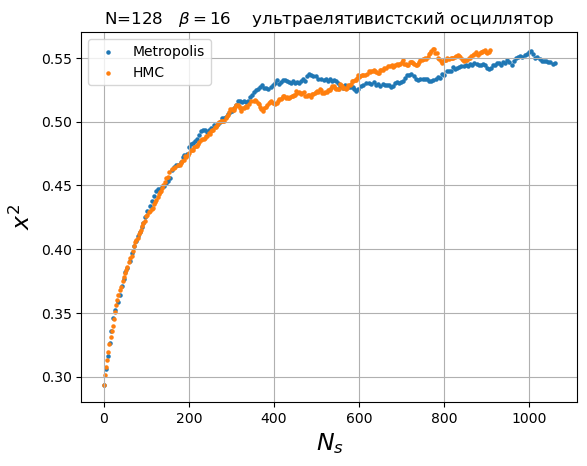

In [109]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta
#from Value import G
#import ensemble
#from NFoscillator import basic_oscillator
#from time import time
#from NFandist import calc_G




fig=plt.figure()

plt.scatter(Metropolis_b.Times,Metropolis_b.res,s=5)
plt.scatter(HMC_b.Times,HMC_b.res,s=5)
#plt.scatter(HMC_NN.Times,HMC_NN.res,s=5)

#plt.scatter(phTimes,phres,s=1)
#plt.xscale("log")
plt.xlabel(r"$N_s$",fontsize=17)
plt.ylabel(r"$x^2$",fontsize=17)
plt.legend(["Metropolis","HMC","HMC latent","Normalizing flow+HMC"])
plt.title("N="+str(N_nod)+"   "+r"$\beta=$"+str(Beta)+"    ультраелятивистский осциллятор")
#plt.scatter(latTimes,l,s=1)
plt.grid(True)
plt.show()

In [32]:
z = torch.ones(10)
z.requires_grad=True
print(z.requires_grad)
x = z
x = 2*x**2
print(y.requires_grad)
x[0].backward()
print(z)
print(z.grad)

True
True
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
tensor([4., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [63]:
t=z.clone()
print(t.requires_grad)

True


In [2]:
def get_points(start,stop,step):
    if step == 0:
        print("step = 0 error")
        return 1
    x=start
    Y=[]
    while x < stop:
        Y.append(x)
        Y.append(x+1)
        x += step
    return Y


def config_RG_masks(m,n_nod):
    masks = []
    start = 0
    step = n_nod // (2 ** (m-1))
    tmp = get_points(start,n_nod,step)
    masks.append(tmp)
    if n_nod == 2 ** m:
        return masks
    start = step//2
    masks.append(get_points(start,n_nod,step))
    while step > 4:
        step //= 2
        start = step//2
        masks.append(get_points(start,n_nod,step))
    return masks

In [3]:
import numpy as np
from NFandist import get_O
O8=get_O(8)
O16=get_O(16)
omasks = config_RG_masks(3,16)
O88 = np.zeros((16,16))
print(O88[[1,2,3],[4,5,6]])
#print(omasks)

[0. 0. 0.]


In [4]:
P1t=np.zeros((16,8))
P1t[omasks[0]]=np.eye(8)
P1=np.transpose(P1t)

P2t=np.zeros((16,8))
P2t[omasks[1]]=np.eye(8)
P2=np.transpose(P2t)
#print(P2)

I=np.ones((8,8))


O88=np.dot(P1t,np.dot(O8,P1))+np.dot(P2t,np.dot(O8,P2))
print(O88)

[[ 3.53553391e-01  3.53553391e-01  0.00000000e+00  0.00000000e+00
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.53553391e-01 -3.53553391e-01  0.00000000e+00  0.00000000e+00
   3.53553391e-01  3.53553391e-01  0.00000000e+00  0.00000000e+00
   3.06161700e-17  5.00000000e-01  0.00000000e+00  0.00000000e+00
  -3.53553391e-01  3.53553391e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.53553391e-01  3.53553391e-01
   0.00000000e+00  0.00000000e+00  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.00000000e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.53553391e-01 -3.53553391e-01
   0.00000000e+00  0.00000000e+00  3.53553391e-01  3.53553391e-01
   0.00000000e+00  0.00000000e+00  3.06161700e-17  5.00000000e-01
   0.00

In [5]:
def getproj(,mask):
    dim = len(mask)
    Pt=torch.zeros((N,dim))
    Pt[omasks[i]] = torch.eye(dim)
    return Pt


def get_multiO(m,N):
    omasks = config_RG_masks(m,N)
    mO=np.zeros((N,N))
    for i in range(len(omasks)):
        dim=len(omasks[i])
        Pt=np.zeros((N,dim))
        Pt[omasks[i]] = np.eye(dim)
        P=np.transpose(Pt)
        O=get_O(dim)
        mO+=np.dot(Pt,np.dot(O,P))
    return mO
O64=get_multiO(3,64)
print(O64)        
        
    
    
    

[[ 0.35355339  0.35355339  0.         ...  0.          0.
   0.        ]
 [ 0.35355339 -0.35355339  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.1767767  ...  0.          0.25
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.13529903  0.
   0.        ]
 [ 0.          0.          0.1767767  ...  0.          0.23096988
   0.09567086]
 [ 0.          0.          0.1767767  ...  0.         -0.24519632
  -0.04877258]]
